# CNN Model 3

**This notebook will build the following model**:
- Use only 50% of the data? Yes
- Batch Size: 32
- Batch Normalization: Yes, after every convolution
- Early Stopping: Yes, patience=3
- Reduce Learning Rate: Yes, patience=1
- Initial Learning Rate: 0.0001
- Epochs (max): 15
- Architecture:
    - Feature Extractor: \[Convolution -> Convolution -> Max Pool] repeated 5 times.
        - Relu activation function throughout
        - 2x2 pooling size
        - 3x3 filter size throughout
        - Filter count per convolution: 32, 64, 128, 256, 512
    - Classifier: 1 dense layer with 256 units
        - Sigmoid activation function

In [1]:
from data_pipeline import (prep_data, get_train_val_test_data, create_tensorflow_datasets, predict_on_kaggle_test_set)
from model_helper_functions import map_to_metrics, plot_metric, plot_learning_rate, save_history
import numpy as np
from PIL import Image
from time import time, gmtime
import json
import os
from collections import OrderedDict
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.optimizers import RMSprop, Adam
from keras import layers
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2024-01-28 01:25:18.089712: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-28 01:25:18.132258: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.random.set_seed(15)

---

## Prepare Data

In [3]:
BATCH_SIZE = 32

In [4]:
data_dir = '../data'
df, train_val_dir = prep_data(data_dir)

In [5]:
train_df, val_df, test_df = get_train_val_test_data(df, use_half_data=True)
train_ds_str, val_ds_str, test_ds_str, train_ds, val_ds, test_ds = create_tensorflow_datasets(train_df, val_df, test_df, BATCH_SIZE)

Training set: 70%, Validation set: 22.5%, Test set: 7.5%


2024-01-28 01:25:24.405298: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-28 01:25:24.439457: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-28 01:25:24.443111: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

ion/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-28 01:25:24.576902: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-28 01:25:24.578309: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-28 01:25:24.579639: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20741 MB memory:  -> device: 0, name: NVIDIA A10, pci bus id: 0000:06:00.0, compute capability: 8.6
2024-01-28 01:25:24.952400: I 

In [6]:
image_count = len(list(train_val_dir.glob('*/*.tif')))
print('Total image count:',image_count)
print('Image count equal to dataframe length?', image_count == len(df))

Total image count: 220025
Image count equal to dataframe length? True


In [7]:
num_train_samples = tf.data.experimental.cardinality(train_ds_str).numpy()
num_val_samples = tf.data.experimental.cardinality(val_ds_str).numpy()
num_test_samples = tf.data.experimental.cardinality(test_ds_str).numpy()
print('Number of training samples:',num_train_samples)
print('Number of validation samples::',num_val_samples)
print('Number of test samples:',num_test_samples)

Number of training samples: 77008
Number of validation samples:: 24753
Number of test samples: 8251


In [8]:
example_image = Image.open(df.loc[0, 'path'])
image_shape = np.array(example_image).shape
print('Image shape:', image_shape)

Image shape: (96, 96, 3)


---

## Define Model

In [9]:
MODEL_NAME = 'model3'

In [10]:
model_metrics = OrderedDict([
    ('accuracy', keras.metrics.BinaryAccuracy(name='accuracy')),
    ('auc', keras.metrics.AUC(name='auc')),
])

In [11]:
model_output_dir = './model_checkpoints'
checkpoint_path = f"{model_output_dir}/{MODEL_NAME}/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_best_only=True, monitor='val_loss')

In [12]:
# Define parameters for early stopping and learning rate reduction
earlystopper = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)

In [13]:
# Model Architecture

model = Sequential()

# Feature Extractor
# N_1
model.add(layers.Conv2D(32, (3, 3), input_shape=image_shape))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.MaxPooling2D((2, 2)))

# N_2
model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.MaxPooling2D((2, 2)))

# N_3
model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

# N_4
model.add(layers.Conv2D(256, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(256, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.MaxPooling2D((2, 2)))

# N_5
model.add(layers.Conv2D(512, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(512, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(256))
model.add(layers.Dense(1, activation = "sigmoid"))


# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss = "binary_crossentropy",
              metrics=list(model_metrics.values()))

model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 conv2d (Conv2D)             (None, 94, 94, 32)        896       


 batch_normalization (Batch  (None, 94, 94, 32)        128       


 Normalization)                                                  


 activation (Activation)     (None, 94, 94, 32)        0         


 conv2d_1 (Conv2D)           (None, 92, 92, 32)        9248      


 batch_normalization_1 (Bat  (None, 92, 92, 32)        128       


 chNormalization)                                                


 activation_1 (Activation)   (None, 92, 92, 32)        0         


 max_pooling2d (MaxPooling2  (None, 46, 46, 32)        0         


 D)                                                              


 conv2d_2 (Conv2D)           (None, 44, 44, 64)        18496     


 batch_normalization_2 (Bat  (None, 44, 44, 64)        256       


 chNormalization)                                                


 activation_2 (Activation)   (None, 44, 44, 64)        0         


 conv2d_3 (Conv2D)           (None, 42, 42, 64)        36928     


 batch_normalization_3 (Bat  (None, 42, 42, 64)        256       


 chNormalization)                                                


 activation_3 (Activation)   (None, 42, 42, 64)        0         


 max_pooling2d_1 (MaxPoolin  (None, 21, 21, 64)        0         


 g2D)                                                            


 conv2d_4 (Conv2D)           (None, 19, 19, 128)       73856     


 batch_normalization_4 (Bat  (None, 19, 19, 128)       512       


 chNormalization)                                                


 activation_4 (Activation)   (None, 19, 19, 128)       0         


 conv2d_5 (Conv2D)           (None, 17, 17, 128)       147584    


 batch_normalization_5 (Bat  (None, 17, 17, 128)       512       


 chNormalization)                                                


 activation_5 (Activation)   (None, 17, 17, 128)       0         


 conv2d_6 (Conv2D)           (None, 15, 15, 256)       295168    


 batch_normalization_6 (Bat  (None, 15, 15, 256)       1024      


 chNormalization)                                                


 activation_6 (Activation)   (None, 15, 15, 256)       0         


 conv2d_7 (Conv2D)           (None, 13, 13, 256)       590080    


 batch_normalization_7 (Bat  (None, 13, 13, 256)       1024      


 chNormalization)                                                


 activation_7 (Activation)   (None, 13, 13, 256)       0         


 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 256)         0         


 g2D)                                                            


 conv2d_8 (Conv2D)           (None, 4, 4, 512)         1180160   


 batch_normalization_8 (Bat  (None, 4, 4, 512)         2048      


 chNormalization)                                                


 activation_8 (Activation)   (None, 4, 4, 512)         0         


 conv2d_9 (Conv2D)           (None, 2, 2, 512)         2359808   


 batch_normalization_9 (Bat  (None, 2, 2, 512)         2048      


 chNormalization)                                                


 activation_9 (Activation)   (None, 2, 2, 512)         0         


 flatten (Flatten)           (None, 2048)              0         


 dense (Dense)               (None, 256)               524544    


 dense_1 (Dense)             (None, 1)                 257       


Total params: 5244961 (20.01 MB)


Trainable params: 5240993 (19.99 MB)


Non-trainable params: 3968 (15.50 KB)


_________________________________________________________________


---

## Fit Model

In [14]:
EPOCHS = 15

In [15]:
start_time = time()
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=EPOCHS,
                    callbacks=[cp_callback, reducel, earlystopper]
                   )
total_time = time() - start_time

Epoch 1/15


2024-01-28 01:25:27.433751: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902


2024-01-28 01:25:27.756688: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


   1/2407 [..............................] - ETA: 1:09:48 - loss: 0.9674 - accuracy: 0.2812 - auc: 0.2446

   5/2407 [..............................] - ETA: 38s - loss: 0.7828 - accuracy: 0.5875 - auc: 0.6426    

   9/2407 [..............................] - ETA: 37s - loss: 0.7225 - accuracy: 0.6424 - auc: 0.7172

  13/2407 [..............................] - ETA: 37s - loss: 0.7240 - accuracy: 0.6490 - auc: 0.7219

  17/2407 [..............................] - ETA: 36s - loss: 0.6881 - accuracy: 0.6765 - auc: 0.7371

  21/2407 [..............................] - ETA: 36s - loss: 0.6899 - accuracy: 0.6830 - auc: 0.7407

  25/2407 [..............................] - ETA: 36s - loss: 0.7022 - accuracy: 0.6913 - auc: 0.7490

  29/2407 [..............................] - ETA: 36s - loss: 0.6872 - accuracy: 0.6961 - auc: 0.7542

  33/2407 [..............................] - ETA: 36s - loss: 0.6749 - accuracy: 0.6989 - auc: 0.7582

  37/2407 [..............................] - ETA: 36s - loss: 0.7070 - accuracy: 0.6909 - auc: 0.7428

  41/2407 [..............................] - ETA: 36s - loss: 0.7004 - accuracy: 0.6921 - auc: 0.7442

  45/2407 [..............................] - ETA: 36s - loss: 0.7031 - accuracy: 0.6924 - auc: 0.7433

  49/2407 [..............................] - ETA: 36s - loss: 0.6941 - accuracy: 0.6971 - auc: 0.7482

  53/2407 [..............................] - ETA: 35s - loss: 0.6844 - accuracy: 0.7052 - auc: 0.7545

  57/2407 [..............................] - ETA: 35s - loss: 0.6763 - accuracy: 0.7083 - auc: 0.7599

  61/2407 [..............................] - ETA: 35s - loss: 0.6727 - accuracy: 0.7116 - auc: 0.7648

  65/2407 [..............................] - ETA: 35s - loss: 0.6678 - accuracy: 0.7120 - auc: 0.7675

  69/2407 [..............................] - ETA: 35s - loss: 0.6651 - accuracy: 0.7129 - auc: 0.7675

  73/2407 [..............................] - ETA: 35s - loss: 0.6551 - accuracy: 0.7145 - auc: 0.7713

  77/2407 [..............................] - ETA: 35s - loss: 0.6531 - accuracy: 0.7179 - auc: 0.7714

  81/2407 [>.............................] - ETA: 35s - loss: 0.6496 - accuracy: 0.7184 - auc: 0.7722

  85/2407 [>.............................] - ETA: 35s - loss: 0.6429 - accuracy: 0.7195 - auc: 0.7743

  89/2407 [>.............................] - ETA: 35s - loss: 0.6349 - accuracy: 0.7212 - auc: 0.7778

  93/2407 [>.............................] - ETA: 35s - loss: 0.6221 - accuracy: 0.7268 - auc: 0.7856

  97/2407 [>.............................] - ETA: 35s - loss: 0.6191 - accuracy: 0.7297 - auc: 0.7884

 101/2407 [>.............................] - ETA: 35s - loss: 0.6199 - accuracy: 0.7305 - auc: 0.7892

 105/2407 [>.............................] - ETA: 35s - loss: 0.6174 - accuracy: 0.7310 - auc: 0.7903

 109/2407 [>.............................] - ETA: 34s - loss: 0.6126 - accuracy: 0.7328 - auc: 0.7926

 113/2407 [>.............................] - ETA: 34s - loss: 0.6101 - accuracy: 0.7323 - auc: 0.7930

 117/2407 [>.............................] - ETA: 34s - loss: 0.6097 - accuracy: 0.7326 - auc: 0.7943

 121/2407 [>.............................] - ETA: 34s - loss: 0.6103 - accuracy: 0.7314 - auc: 0.7943

 125/2407 [>.............................] - ETA: 34s - loss: 0.6122 - accuracy: 0.7305 - auc: 0.7931

 129/2407 [>.............................] - ETA: 34s - loss: 0.6103 - accuracy: 0.7328 - auc: 0.7951

 132/2407 [>.............................] - ETA: 34s - loss: 0.6086 - accuracy: 0.7332 - auc: 0.7955

 136/2407 [>.............................] - ETA: 34s - loss: 0.6029 - accuracy: 0.7360 - auc: 0.7979

 140/2407 [>.............................] - ETA: 34s - loss: 0.6022 - accuracy: 0.7353 - auc: 0.7973

 144/2407 [>.............................] - ETA: 34s - loss: 0.6030 - accuracy: 0.7337 - auc: 0.7959

 148/2407 [>.............................] - ETA: 34s - loss: 0.6014 - accuracy: 0.7344 - auc: 0.7965

 152/2407 [>.............................] - ETA: 34s - loss: 0.5982 - accuracy: 0.7362 - auc: 0.7984

 156/2407 [>.............................] - ETA: 34s - loss: 0.5997 - accuracy: 0.7344 - auc: 0.7972

 160/2407 [>.............................] - ETA: 34s - loss: 0.5991 - accuracy: 0.7336 - auc: 0.7969

 164/2407 [=>............................] - ETA: 34s - loss: 0.5981 - accuracy: 0.7330 - auc: 0.7961

 168/2407 [=>............................] - ETA: 34s - loss: 0.5977 - accuracy: 0.7329 - auc: 0.7957

 172/2407 [=>............................] - ETA: 34s - loss: 0.5965 - accuracy: 0.7322 - auc: 0.7957

 176/2407 [=>............................] - ETA: 34s - loss: 0.5924 - accuracy: 0.7342 - auc: 0.7973

 180/2407 [=>............................] - ETA: 33s - loss: 0.5896 - accuracy: 0.7356 - auc: 0.7989

 184/2407 [=>............................] - ETA: 33s - loss: 0.5900 - accuracy: 0.7356 - auc: 0.7989

 188/2407 [=>............................] - ETA: 33s - loss: 0.5868 - accuracy: 0.7360 - auc: 0.8005

 192/2407 [=>............................] - ETA: 33s - loss: 0.5866 - accuracy: 0.7362 - auc: 0.8001

 196/2407 [=>............................] - ETA: 33s - loss: 0.5861 - accuracy: 0.7353 - auc: 0.7998

 200/2407 [=>............................] - ETA: 33s - loss: 0.5879 - accuracy: 0.7328 - auc: 0.7984

 204/2407 [=>............................] - ETA: 33s - loss: 0.5878 - accuracy: 0.7325 - auc: 0.7978

 208/2407 [=>............................] - ETA: 33s - loss: 0.5867 - accuracy: 0.7326 - auc: 0.7978

 212/2407 [=>............................] - ETA: 33s - loss: 0.5848 - accuracy: 0.7336 - auc: 0.7987

 216/2407 [=>............................] - ETA: 33s - loss: 0.5820 - accuracy: 0.7354 - auc: 0.8003

 220/2407 [=>............................] - ETA: 33s - loss: 0.5811 - accuracy: 0.7359 - auc: 0.8012

 224/2407 [=>............................] - ETA: 33s - loss: 0.5778 - accuracy: 0.7374 - auc: 0.8031

 228/2407 [=>............................] - ETA: 33s - loss: 0.5741 - accuracy: 0.7392 - auc: 0.8055

 232/2407 [=>............................] - ETA: 33s - loss: 0.5724 - accuracy: 0.7400 - auc: 0.8063

 236/2407 [=>............................] - ETA: 33s - loss: 0.5688 - accuracy: 0.7417 - auc: 0.8081

 240/2407 [=>............................] - ETA: 33s - loss: 0.5679 - accuracy: 0.7417 - auc: 0.8088

 244/2407 [==>...........................] - ETA: 32s - loss: 0.5657 - accuracy: 0.7422 - auc: 0.8098

 248/2407 [==>...........................] - ETA: 32s - loss: 0.5661 - accuracy: 0.7422 - auc: 0.8096

 252/2407 [==>...........................] - ETA: 32s - loss: 0.5639 - accuracy: 0.7436 - auc: 0.8108

 256/2407 [==>...........................] - ETA: 32s - loss: 0.5638 - accuracy: 0.7428 - auc: 0.8106

 260/2407 [==>...........................] - ETA: 32s - loss: 0.5624 - accuracy: 0.7437 - auc: 0.8113

 264/2407 [==>...........................] - ETA: 32s - loss: 0.5638 - accuracy: 0.7440 - auc: 0.8106

 268/2407 [==>...........................] - ETA: 32s - loss: 0.5638 - accuracy: 0.7439 - auc: 0.8104

 272/2407 [==>...........................] - ETA: 32s - loss: 0.5629 - accuracy: 0.7444 - auc: 0.8107

 276/2407 [==>...........................] - ETA: 32s - loss: 0.5628 - accuracy: 0.7442 - auc: 0.8106

 280/2407 [==>...........................] - ETA: 32s - loss: 0.5610 - accuracy: 0.7449 - auc: 0.8115

 284/2407 [==>...........................] - ETA: 32s - loss: 0.5612 - accuracy: 0.7444 - auc: 0.8114

 288/2407 [==>...........................] - ETA: 32s - loss: 0.5600 - accuracy: 0.7448 - auc: 0.8121

 292/2407 [==>...........................] - ETA: 32s - loss: 0.5608 - accuracy: 0.7445 - auc: 0.8117

 296/2407 [==>...........................] - ETA: 32s - loss: 0.5599 - accuracy: 0.7456 - auc: 0.8119

 300/2407 [==>...........................] - ETA: 32s - loss: 0.5586 - accuracy: 0.7464 - auc: 0.8123

 304/2407 [==>...........................] - ETA: 32s - loss: 0.5586 - accuracy: 0.7462 - auc: 0.8125

 308/2407 [==>...........................] - ETA: 31s - loss: 0.5578 - accuracy: 0.7471 - auc: 0.8130

 312/2407 [==>...........................] - ETA: 31s - loss: 0.5571 - accuracy: 0.7466 - auc: 0.8132

 316/2407 [==>...........................] - ETA: 31s - loss: 0.5567 - accuracy: 0.7468 - auc: 0.8133

 320/2407 [==>...........................] - ETA: 31s - loss: 0.5573 - accuracy: 0.7470 - auc: 0.8130

 324/2407 [===>..........................] - ETA: 31s - loss: 0.5568 - accuracy: 0.7477 - auc: 0.8129

 328/2407 [===>..........................] - ETA: 31s - loss: 0.5591 - accuracy: 0.7473 - auc: 0.8119

 332/2407 [===>..........................] - ETA: 31s - loss: 0.5580 - accuracy: 0.7480 - auc: 0.8123

 336/2407 [===>..........................] - ETA: 31s - loss: 0.5581 - accuracy: 0.7474 - auc: 0.8121

 340/2407 [===>..........................] - ETA: 31s - loss: 0.5594 - accuracy: 0.7470 - auc: 0.8113

 344/2407 [===>..........................] - ETA: 31s - loss: 0.5587 - accuracy: 0.7472 - auc: 0.8116

 348/2407 [===>..........................] - ETA: 31s - loss: 0.5596 - accuracy: 0.7466 - auc: 0.8112

 352/2407 [===>..........................] - ETA: 31s - loss: 0.5598 - accuracy: 0.7462 - auc: 0.8107

 356/2407 [===>..........................] - ETA: 31s - loss: 0.5597 - accuracy: 0.7469 - auc: 0.8111

 360/2407 [===>..........................] - ETA: 31s - loss: 0.5581 - accuracy: 0.7477 - auc: 0.8119

 364/2407 [===>..........................] - ETA: 31s - loss: 0.5568 - accuracy: 0.7480 - auc: 0.8126

 368/2407 [===>..........................] - ETA: 31s - loss: 0.5551 - accuracy: 0.7488 - auc: 0.8133

 372/2407 [===>..........................] - ETA: 31s - loss: 0.5547 - accuracy: 0.7487 - auc: 0.8135

 376/2407 [===>..........................] - ETA: 30s - loss: 0.5543 - accuracy: 0.7485 - auc: 0.8136

 380/2407 [===>..........................] - ETA: 30s - loss: 0.5534 - accuracy: 0.7490 - auc: 0.8141

 384/2407 [===>..........................] - ETA: 30s - loss: 0.5526 - accuracy: 0.7489 - auc: 0.8146

 388/2407 [===>..........................] - ETA: 30s - loss: 0.5511 - accuracy: 0.7495 - auc: 0.8154

 392/2407 [===>..........................] - ETA: 30s - loss: 0.5513 - accuracy: 0.7496 - auc: 0.8153

 396/2407 [===>..........................] - ETA: 30s - loss: 0.5509 - accuracy: 0.7498 - auc: 0.8153

 400/2407 [===>..........................] - ETA: 30s - loss: 0.5505 - accuracy: 0.7498 - auc: 0.8153

 404/2407 [====>.........................] - ETA: 30s - loss: 0.5504 - accuracy: 0.7502 - auc: 0.8154

 408/2407 [====>.........................] - ETA: 30s - loss: 0.5489 - accuracy: 0.7505 - auc: 0.8162

 412/2407 [====>.........................] - ETA: 30s - loss: 0.5498 - accuracy: 0.7501 - auc: 0.8157

 416/2407 [====>.........................] - ETA: 30s - loss: 0.5507 - accuracy: 0.7498 - auc: 0.8151

 420/2407 [====>.........................] - ETA: 30s - loss: 0.5506 - accuracy: 0.7492 - auc: 0.8150

 424/2407 [====>.........................] - ETA: 30s - loss: 0.5502 - accuracy: 0.7494 - auc: 0.8151

 428/2407 [====>.........................] - ETA: 30s - loss: 0.5489 - accuracy: 0.7501 - auc: 0.8158

 432/2407 [====>.........................] - ETA: 30s - loss: 0.5483 - accuracy: 0.7501 - auc: 0.8160

 436/2407 [====>.........................] - ETA: 30s - loss: 0.5481 - accuracy: 0.7497 - auc: 0.8161

 440/2407 [====>.........................] - ETA: 29s - loss: 0.5469 - accuracy: 0.7500 - auc: 0.8165

 444/2407 [====>.........................] - ETA: 29s - loss: 0.5468 - accuracy: 0.7498 - auc: 0.8165

 448/2407 [====>.........................] - ETA: 29s - loss: 0.5463 - accuracy: 0.7501 - auc: 0.8166

 452/2407 [====>.........................] - ETA: 29s - loss: 0.5459 - accuracy: 0.7503 - auc: 0.8168

 456/2407 [====>.........................] - ETA: 29s - loss: 0.5453 - accuracy: 0.7507 - auc: 0.8169

 460/2407 [====>.........................] - ETA: 29s - loss: 0.5452 - accuracy: 0.7504 - auc: 0.8168

 464/2407 [====>.........................] - ETA: 29s - loss: 0.5442 - accuracy: 0.7511 - auc: 0.8172

 468/2407 [====>.........................] - ETA: 29s - loss: 0.5440 - accuracy: 0.7509 - auc: 0.8173

 472/2407 [====>.........................] - ETA: 29s - loss: 0.5428 - accuracy: 0.7513 - auc: 0.8179

 476/2407 [====>.........................] - ETA: 29s - loss: 0.5426 - accuracy: 0.7514 - auc: 0.8181

 480/2407 [====>.........................] - ETA: 29s - loss: 0.5422 - accuracy: 0.7513 - auc: 0.8181

 484/2407 [=====>........................] - ETA: 29s - loss: 0.5412 - accuracy: 0.7521 - auc: 0.8187

 488/2407 [=====>........................] - ETA: 29s - loss: 0.5411 - accuracy: 0.7519 - auc: 0.8186

 492/2407 [=====>........................] - ETA: 29s - loss: 0.5407 - accuracy: 0.7519 - auc: 0.8187

 496/2407 [=====>........................] - ETA: 29s - loss: 0.5405 - accuracy: 0.7519 - auc: 0.8187

 500/2407 [=====>........................] - ETA: 29s - loss: 0.5396 - accuracy: 0.7523 - auc: 0.8190

 504/2407 [=====>........................] - ETA: 28s - loss: 0.5402 - accuracy: 0.7521 - auc: 0.8187

 508/2407 [=====>........................] - ETA: 28s - loss: 0.5391 - accuracy: 0.7527 - auc: 0.8192

 512/2407 [=====>........................] - ETA: 28s - loss: 0.5387 - accuracy: 0.7532 - auc: 0.8194

 516/2407 [=====>........................] - ETA: 28s - loss: 0.5378 - accuracy: 0.7538 - auc: 0.8198

 520/2407 [=====>........................] - ETA: 28s - loss: 0.5370 - accuracy: 0.7540 - auc: 0.8203

 524/2407 [=====>........................] - ETA: 28s - loss: 0.5356 - accuracy: 0.7547 - auc: 0.8211

 528/2407 [=====>........................] - ETA: 28s - loss: 0.5341 - accuracy: 0.7554 - auc: 0.8220

 532/2407 [=====>........................] - ETA: 28s - loss: 0.5332 - accuracy: 0.7558 - auc: 0.8226

 536/2407 [=====>........................] - ETA: 28s - loss: 0.5324 - accuracy: 0.7563 - auc: 0.8232

 540/2407 [=====>........................] - ETA: 28s - loss: 0.5318 - accuracy: 0.7567 - auc: 0.8237

 544/2407 [=====>........................] - ETA: 28s - loss: 0.5314 - accuracy: 0.7571 - auc: 0.8240

 548/2407 [=====>........................] - ETA: 28s - loss: 0.5312 - accuracy: 0.7572 - auc: 0.8241

 552/2407 [=====>........................] - ETA: 28s - loss: 0.5314 - accuracy: 0.7574 - auc: 0.8239

 556/2407 [=====>........................] - ETA: 28s - loss: 0.5303 - accuracy: 0.7580 - auc: 0.8246

 560/2407 [=====>........................] - ETA: 28s - loss: 0.5299 - accuracy: 0.7580 - auc: 0.8247

 564/2407 [======>.......................] - ETA: 28s - loss: 0.5289 - accuracy: 0.7585 - auc: 0.8254

 568/2407 [======>.......................] - ETA: 28s - loss: 0.5286 - accuracy: 0.7586 - auc: 0.8255

 572/2407 [======>.......................] - ETA: 27s - loss: 0.5282 - accuracy: 0.7590 - auc: 0.8256

 576/2407 [======>.......................] - ETA: 27s - loss: 0.5279 - accuracy: 0.7590 - auc: 0.8256

 580/2407 [======>.......................] - ETA: 27s - loss: 0.5277 - accuracy: 0.7593 - auc: 0.8256

 584/2407 [======>.......................] - ETA: 27s - loss: 0.5275 - accuracy: 0.7594 - auc: 0.8257

 588/2407 [======>.......................] - ETA: 27s - loss: 0.5276 - accuracy: 0.7596 - auc: 0.8257

 592/2407 [======>.......................] - ETA: 27s - loss: 0.5275 - accuracy: 0.7598 - auc: 0.8258

 596/2407 [======>.......................] - ETA: 27s - loss: 0.5268 - accuracy: 0.7601 - auc: 0.8262

 600/2407 [======>.......................] - ETA: 27s - loss: 0.5260 - accuracy: 0.7605 - auc: 0.8267

 604/2407 [======>.......................] - ETA: 27s - loss: 0.5262 - accuracy: 0.7604 - auc: 0.8265

 608/2407 [======>.......................] - ETA: 27s - loss: 0.5262 - accuracy: 0.7602 - auc: 0.8264

 612/2407 [======>.......................] - ETA: 27s - loss: 0.5256 - accuracy: 0.7604 - auc: 0.8268

 616/2407 [======>.......................] - ETA: 27s - loss: 0.5247 - accuracy: 0.7611 - auc: 0.8274

 620/2407 [======>.......................] - ETA: 27s - loss: 0.5252 - accuracy: 0.7615 - auc: 0.8276

 624/2407 [======>.......................] - ETA: 27s - loss: 0.5256 - accuracy: 0.7613 - auc: 0.8273

 628/2407 [======>.......................] - ETA: 27s - loss: 0.5259 - accuracy: 0.7611 - auc: 0.8272

 632/2407 [======>.......................] - ETA: 27s - loss: 0.5256 - accuracy: 0.7613 - auc: 0.8273

 636/2407 [======>.......................] - ETA: 26s - loss: 0.5252 - accuracy: 0.7615 - auc: 0.8276

 640/2407 [======>.......................] - ETA: 26s - loss: 0.5245 - accuracy: 0.7620 - auc: 0.8279

 644/2407 [=======>......................] - ETA: 26s - loss: 0.5235 - accuracy: 0.7624 - auc: 0.8283

 648/2407 [=======>......................] - ETA: 26s - loss: 0.5235 - accuracy: 0.7627 - auc: 0.8286

 652/2407 [=======>......................] - ETA: 26s - loss: 0.5221 - accuracy: 0.7633 - auc: 0.8293

 656/2407 [=======>......................] - ETA: 26s - loss: 0.5220 - accuracy: 0.7634 - auc: 0.8296

 660/2407 [=======>......................] - ETA: 26s - loss: 0.5220 - accuracy: 0.7636 - auc: 0.8297

 664/2407 [=======>......................] - ETA: 26s - loss: 0.5213 - accuracy: 0.7638 - auc: 0.8301

 668/2407 [=======>......................] - ETA: 26s - loss: 0.5210 - accuracy: 0.7639 - auc: 0.8303

 672/2407 [=======>......................] - ETA: 26s - loss: 0.5204 - accuracy: 0.7641 - auc: 0.8306

 676/2407 [=======>......................] - ETA: 26s - loss: 0.5196 - accuracy: 0.7645 - auc: 0.8311

 680/2407 [=======>......................] - ETA: 26s - loss: 0.5191 - accuracy: 0.7645 - auc: 0.8314

 684/2407 [=======>......................] - ETA: 26s - loss: 0.5184 - accuracy: 0.7649 - auc: 0.8318

 688/2407 [=======>......................] - ETA: 26s - loss: 0.5184 - accuracy: 0.7652 - auc: 0.8319

 692/2407 [=======>......................] - ETA: 26s - loss: 0.5182 - accuracy: 0.7653 - auc: 0.8320

 696/2407 [=======>......................] - ETA: 26s - loss: 0.5184 - accuracy: 0.7653 - auc: 0.8319

 700/2407 [=======>......................] - ETA: 26s - loss: 0.5178 - accuracy: 0.7656 - auc: 0.8321

 704/2407 [=======>......................] - ETA: 25s - loss: 0.5173 - accuracy: 0.7658 - auc: 0.8323

 708/2407 [=======>......................] - ETA: 25s - loss: 0.5169 - accuracy: 0.7659 - auc: 0.8325

 712/2407 [=======>......................] - ETA: 25s - loss: 0.5172 - accuracy: 0.7657 - auc: 0.8323

 716/2407 [=======>......................] - ETA: 25s - loss: 0.5170 - accuracy: 0.7658 - auc: 0.8323

 720/2407 [=======>......................] - ETA: 25s - loss: 0.5168 - accuracy: 0.7659 - auc: 0.8324

 724/2407 [========>.....................] - ETA: 25s - loss: 0.5160 - accuracy: 0.7664 - auc: 0.8328

 728/2407 [========>.....................] - ETA: 25s - loss: 0.5154 - accuracy: 0.7666 - auc: 0.8331

 732/2407 [========>.....................] - ETA: 25s - loss: 0.5153 - accuracy: 0.7666 - auc: 0.8332

 736/2407 [========>.....................] - ETA: 25s - loss: 0.5147 - accuracy: 0.7667 - auc: 0.8335

 740/2407 [========>.....................] - ETA: 25s - loss: 0.5144 - accuracy: 0.7668 - auc: 0.8335

 744/2407 [========>.....................] - ETA: 25s - loss: 0.5143 - accuracy: 0.7671 - auc: 0.8335

 748/2407 [========>.....................] - ETA: 25s - loss: 0.5141 - accuracy: 0.7671 - auc: 0.8336

 752/2407 [========>.....................] - ETA: 25s - loss: 0.5132 - accuracy: 0.7676 - auc: 0.8341

 756/2407 [========>.....................] - ETA: 25s - loss: 0.5129 - accuracy: 0.7678 - auc: 0.8343

 760/2407 [========>.....................] - ETA: 25s - loss: 0.5130 - accuracy: 0.7679 - auc: 0.8344

 764/2407 [========>.....................] - ETA: 25s - loss: 0.5129 - accuracy: 0.7680 - auc: 0.8345

 768/2407 [========>.....................] - ETA: 25s - loss: 0.5126 - accuracy: 0.7681 - auc: 0.8347

 772/2407 [========>.....................] - ETA: 24s - loss: 0.5136 - accuracy: 0.7679 - auc: 0.8345

 776/2407 [========>.....................] - ETA: 24s - loss: 0.5135 - accuracy: 0.7679 - auc: 0.8346

 780/2407 [========>.....................] - ETA: 24s - loss: 0.5133 - accuracy: 0.7679 - auc: 0.8346

 784/2407 [========>.....................] - ETA: 24s - loss: 0.5134 - accuracy: 0.7678 - auc: 0.8345

 788/2407 [========>.....................] - ETA: 24s - loss: 0.5130 - accuracy: 0.7680 - auc: 0.8346

 792/2407 [========>.....................] - ETA: 24s - loss: 0.5135 - accuracy: 0.7678 - auc: 0.8344

 796/2407 [========>.....................] - ETA: 24s - loss: 0.5128 - accuracy: 0.7683 - auc: 0.8347

 800/2407 [========>.....................] - ETA: 24s - loss: 0.5128 - accuracy: 0.7682 - auc: 0.8347

 804/2407 [=========>....................] - ETA: 24s - loss: 0.5123 - accuracy: 0.7683 - auc: 0.8350

 808/2407 [=========>....................] - ETA: 24s - loss: 0.5121 - accuracy: 0.7684 - auc: 0.8351

 812/2407 [=========>....................] - ETA: 24s - loss: 0.5117 - accuracy: 0.7686 - auc: 0.8354

 816/2407 [=========>....................] - ETA: 24s - loss: 0.5114 - accuracy: 0.7687 - auc: 0.8355

 820/2407 [=========>....................] - ETA: 24s - loss: 0.5108 - accuracy: 0.7689 - auc: 0.8358

 824/2407 [=========>....................] - ETA: 24s - loss: 0.5103 - accuracy: 0.7693 - auc: 0.8360

 828/2407 [=========>....................] - ETA: 24s - loss: 0.5093 - accuracy: 0.7699 - auc: 0.8365

 832/2407 [=========>....................] - ETA: 24s - loss: 0.5095 - accuracy: 0.7698 - auc: 0.8365

 836/2407 [=========>....................] - ETA: 23s - loss: 0.5091 - accuracy: 0.7701 - auc: 0.8367

 840/2407 [=========>....................] - ETA: 23s - loss: 0.5086 - accuracy: 0.7704 - auc: 0.8370

 844/2407 [=========>....................] - ETA: 23s - loss: 0.5083 - accuracy: 0.7705 - auc: 0.8372

 848/2407 [=========>....................] - ETA: 23s - loss: 0.5081 - accuracy: 0.7706 - auc: 0.8373

 852/2407 [=========>....................] - ETA: 23s - loss: 0.5079 - accuracy: 0.7706 - auc: 0.8374

 856/2407 [=========>....................] - ETA: 23s - loss: 0.5073 - accuracy: 0.7707 - auc: 0.8377

 860/2407 [=========>....................] - ETA: 23s - loss: 0.5074 - accuracy: 0.7707 - auc: 0.8376

 864/2407 [=========>....................] - ETA: 23s - loss: 0.5070 - accuracy: 0.7709 - auc: 0.8377

 868/2407 [=========>....................] - ETA: 23s - loss: 0.5065 - accuracy: 0.7711 - auc: 0.8381

 872/2407 [=========>....................] - ETA: 23s - loss: 0.5063 - accuracy: 0.7714 - auc: 0.8383

 876/2407 [=========>....................] - ETA: 23s - loss: 0.5063 - accuracy: 0.7714 - auc: 0.8383

 880/2407 [=========>....................] - ETA: 23s - loss: 0.5060 - accuracy: 0.7714 - auc: 0.8385

 884/2407 [==========>...................] - ETA: 23s - loss: 0.5053 - accuracy: 0.7719 - auc: 0.8389

 888/2407 [==========>...................] - ETA: 23s - loss: 0.5047 - accuracy: 0.7721 - auc: 0.8393

 892/2407 [==========>...................] - ETA: 23s - loss: 0.5043 - accuracy: 0.7724 - auc: 0.8396

 896/2407 [==========>...................] - ETA: 23s - loss: 0.5036 - accuracy: 0.7727 - auc: 0.8399

 900/2407 [==========>...................] - ETA: 22s - loss: 0.5037 - accuracy: 0.7727 - auc: 0.8400

 904/2407 [==========>...................] - ETA: 22s - loss: 0.5033 - accuracy: 0.7729 - auc: 0.8401

 908/2407 [==========>...................] - ETA: 22s - loss: 0.5030 - accuracy: 0.7731 - auc: 0.8403

 912/2407 [==========>...................] - ETA: 22s - loss: 0.5033 - accuracy: 0.7728 - auc: 0.8401

 916/2407 [==========>...................] - ETA: 22s - loss: 0.5029 - accuracy: 0.7730 - auc: 0.8402

 920/2407 [==========>...................] - ETA: 22s - loss: 0.5027 - accuracy: 0.7731 - auc: 0.8403

 924/2407 [==========>...................] - ETA: 22s - loss: 0.5023 - accuracy: 0.7733 - auc: 0.8405

 928/2407 [==========>...................] - ETA: 22s - loss: 0.5021 - accuracy: 0.7735 - auc: 0.8407

 932/2407 [==========>...................] - ETA: 22s - loss: 0.5024 - accuracy: 0.7734 - auc: 0.8406

 936/2407 [==========>...................] - ETA: 22s - loss: 0.5019 - accuracy: 0.7736 - auc: 0.8408

 940/2407 [==========>...................] - ETA: 22s - loss: 0.5016 - accuracy: 0.7736 - auc: 0.8409

 944/2407 [==========>...................] - ETA: 22s - loss: 0.5019 - accuracy: 0.7737 - auc: 0.8408

 948/2407 [==========>...................] - ETA: 22s - loss: 0.5016 - accuracy: 0.7738 - auc: 0.8410

 952/2407 [==========>...................] - ETA: 22s - loss: 0.5016 - accuracy: 0.7738 - auc: 0.8411

 956/2407 [==========>...................] - ETA: 22s - loss: 0.5014 - accuracy: 0.7738 - auc: 0.8413

 960/2407 [==========>...................] - ETA: 22s - loss: 0.5009 - accuracy: 0.7741 - auc: 0.8416

 964/2407 [===========>..................] - ETA: 22s - loss: 0.5005 - accuracy: 0.7744 - auc: 0.8418

 968/2407 [===========>..................] - ETA: 21s - loss: 0.5010 - accuracy: 0.7744 - auc: 0.8417

 972/2407 [===========>..................] - ETA: 21s - loss: 0.5009 - accuracy: 0.7747 - auc: 0.8418

 976/2407 [===========>..................] - ETA: 21s - loss: 0.5010 - accuracy: 0.7746 - auc: 0.8418

 980/2407 [===========>..................] - ETA: 21s - loss: 0.5008 - accuracy: 0.7748 - auc: 0.8420

 984/2407 [===========>..................] - ETA: 21s - loss: 0.5012 - accuracy: 0.7747 - auc: 0.8417

 988/2407 [===========>..................] - ETA: 21s - loss: 0.5007 - accuracy: 0.7750 - auc: 0.8420

 992/2407 [===========>..................] - ETA: 21s - loss: 0.5011 - accuracy: 0.7748 - auc: 0.8418

 996/2407 [===========>..................] - ETA: 21s - loss: 0.5011 - accuracy: 0.7747 - auc: 0.8417

1000/2407 [===========>..................] - ETA: 21s - loss: 0.5008 - accuracy: 0.7750 - auc: 0.8419

1004/2407 [===========>..................] - ETA: 21s - loss: 0.5007 - accuracy: 0.7750 - auc: 0.8419

1008/2407 [===========>..................] - ETA: 21s - loss: 0.5003 - accuracy: 0.7752 - auc: 0.8421

1012/2407 [===========>..................] - ETA: 21s - loss: 0.5001 - accuracy: 0.7753 - auc: 0.8422

1016/2407 [===========>..................] - ETA: 21s - loss: 0.4998 - accuracy: 0.7755 - auc: 0.8423

1020/2407 [===========>..................] - ETA: 21s - loss: 0.4993 - accuracy: 0.7756 - auc: 0.8426

1024/2407 [===========>..................] - ETA: 21s - loss: 0.4989 - accuracy: 0.7756 - auc: 0.8429

1028/2407 [===========>..................] - ETA: 21s - loss: 0.4984 - accuracy: 0.7759 - auc: 0.8431

1032/2407 [===========>..................] - ETA: 20s - loss: 0.4978 - accuracy: 0.7761 - auc: 0.8434

1036/2407 [===========>..................] - ETA: 20s - loss: 0.4979 - accuracy: 0.7761 - auc: 0.8434

1040/2407 [===========>..................] - ETA: 20s - loss: 0.4978 - accuracy: 0.7762 - auc: 0.8434

1044/2407 [============>.................] - ETA: 20s - loss: 0.4974 - accuracy: 0.7765 - auc: 0.8436

1048/2407 [============>.................] - ETA: 20s - loss: 0.4972 - accuracy: 0.7766 - auc: 0.8437

1052/2407 [============>.................] - ETA: 20s - loss: 0.4969 - accuracy: 0.7767 - auc: 0.8438

1056/2407 [============>.................] - ETA: 20s - loss: 0.4963 - accuracy: 0.7769 - auc: 0.8441

1060/2407 [============>.................] - ETA: 20s - loss: 0.4958 - accuracy: 0.7772 - auc: 0.8445

1064/2407 [============>.................] - ETA: 20s - loss: 0.4953 - accuracy: 0.7775 - auc: 0.8447

1068/2407 [============>.................] - ETA: 20s - loss: 0.4952 - accuracy: 0.7777 - auc: 0.8449

1072/2407 [============>.................] - ETA: 20s - loss: 0.4950 - accuracy: 0.7778 - auc: 0.8451

1076/2407 [============>.................] - ETA: 20s - loss: 0.4945 - accuracy: 0.7780 - auc: 0.8453

1080/2407 [============>.................] - ETA: 20s - loss: 0.4940 - accuracy: 0.7781 - auc: 0.8455

1084/2407 [============>.................] - ETA: 20s - loss: 0.4940 - accuracy: 0.7781 - auc: 0.8456

1088/2407 [============>.................] - ETA: 20s - loss: 0.4943 - accuracy: 0.7781 - auc: 0.8455

1092/2407 [============>.................] - ETA: 20s - loss: 0.4943 - accuracy: 0.7781 - auc: 0.8455

1096/2407 [============>.................] - ETA: 19s - loss: 0.4940 - accuracy: 0.7783 - auc: 0.8456

1100/2407 [============>.................] - ETA: 19s - loss: 0.4936 - accuracy: 0.7784 - auc: 0.8459

1104/2407 [============>.................] - ETA: 19s - loss: 0.4933 - accuracy: 0.7785 - auc: 0.8461

1108/2407 [============>.................] - ETA: 19s - loss: 0.4931 - accuracy: 0.7785 - auc: 0.8462

1112/2407 [============>.................] - ETA: 19s - loss: 0.4933 - accuracy: 0.7784 - auc: 0.8460

1116/2407 [============>.................] - ETA: 19s - loss: 0.4929 - accuracy: 0.7786 - auc: 0.8461

1120/2407 [============>.................] - ETA: 19s - loss: 0.4930 - accuracy: 0.7785 - auc: 0.8461

1124/2407 [=============>................] - ETA: 19s - loss: 0.4926 - accuracy: 0.7788 - auc: 0.8463

1128/2407 [=============>................] - ETA: 19s - loss: 0.4925 - accuracy: 0.7789 - auc: 0.8463

1132/2407 [=============>................] - ETA: 19s - loss: 0.4922 - accuracy: 0.7790 - auc: 0.8465

1136/2407 [=============>................] - ETA: 19s - loss: 0.4916 - accuracy: 0.7793 - auc: 0.8468

1140/2407 [=============>................] - ETA: 19s - loss: 0.4917 - accuracy: 0.7794 - auc: 0.8468

1144/2407 [=============>................] - ETA: 19s - loss: 0.4919 - accuracy: 0.7794 - auc: 0.8468

1148/2407 [=============>................] - ETA: 19s - loss: 0.4914 - accuracy: 0.7797 - auc: 0.8471

1152/2407 [=============>................] - ETA: 19s - loss: 0.4913 - accuracy: 0.7797 - auc: 0.8471

1156/2407 [=============>................] - ETA: 19s - loss: 0.4907 - accuracy: 0.7800 - auc: 0.8474

1160/2407 [=============>................] - ETA: 19s - loss: 0.4903 - accuracy: 0.7802 - auc: 0.8477

1164/2407 [=============>................] - ETA: 18s - loss: 0.4903 - accuracy: 0.7803 - auc: 0.8477

1168/2407 [=============>................] - ETA: 18s - loss: 0.4899 - accuracy: 0.7805 - auc: 0.8479

1172/2407 [=============>................] - ETA: 18s - loss: 0.4898 - accuracy: 0.7805 - auc: 0.8479

1176/2407 [=============>................] - ETA: 18s - loss: 0.4894 - accuracy: 0.7807 - auc: 0.8481

1180/2407 [=============>................] - ETA: 18s - loss: 0.4898 - accuracy: 0.7807 - auc: 0.8481

1184/2407 [=============>................] - ETA: 18s - loss: 0.4893 - accuracy: 0.7809 - auc: 0.8483

1188/2407 [=============>................] - ETA: 18s - loss: 0.4892 - accuracy: 0.7809 - auc: 0.8484

1192/2407 [=============>................] - ETA: 18s - loss: 0.4889 - accuracy: 0.7810 - auc: 0.8486

1196/2407 [=============>................] - ETA: 18s - loss: 0.4886 - accuracy: 0.7813 - auc: 0.8488

1200/2407 [=============>................] - ETA: 18s - loss: 0.4886 - accuracy: 0.7814 - auc: 0.8489

1204/2407 [==============>...............] - ETA: 18s - loss: 0.4886 - accuracy: 0.7814 - auc: 0.8489

1208/2407 [==============>...............] - ETA: 18s - loss: 0.4883 - accuracy: 0.7816 - auc: 0.8491

1212/2407 [==============>...............] - ETA: 18s - loss: 0.4876 - accuracy: 0.7820 - auc: 0.8495

1216/2407 [==============>...............] - ETA: 18s - loss: 0.4873 - accuracy: 0.7823 - auc: 0.8497

1220/2407 [==============>...............] - ETA: 18s - loss: 0.4870 - accuracy: 0.7826 - auc: 0.8499

1224/2407 [==============>...............] - ETA: 18s - loss: 0.4870 - accuracy: 0.7827 - auc: 0.8500

1228/2407 [==============>...............] - ETA: 17s - loss: 0.4869 - accuracy: 0.7826 - auc: 0.8499

1232/2407 [==============>...............] - ETA: 17s - loss: 0.4868 - accuracy: 0.7827 - auc: 0.8499

1236/2407 [==============>...............] - ETA: 17s - loss: 0.4863 - accuracy: 0.7830 - auc: 0.8502

1240/2407 [==============>...............] - ETA: 17s - loss: 0.4862 - accuracy: 0.7830 - auc: 0.8503

1244/2407 [==============>...............] - ETA: 17s - loss: 0.4858 - accuracy: 0.7832 - auc: 0.8505

1248/2407 [==============>...............] - ETA: 17s - loss: 0.4860 - accuracy: 0.7831 - auc: 0.8504

1252/2407 [==============>...............] - ETA: 17s - loss: 0.4856 - accuracy: 0.7832 - auc: 0.8507

1256/2407 [==============>...............] - ETA: 17s - loss: 0.4854 - accuracy: 0.7832 - auc: 0.8507

1260/2407 [==============>...............] - ETA: 17s - loss: 0.4851 - accuracy: 0.7834 - auc: 0.8509

1264/2407 [==============>...............] - ETA: 17s - loss: 0.4847 - accuracy: 0.7836 - auc: 0.8512

1268/2407 [==============>...............] - ETA: 17s - loss: 0.4844 - accuracy: 0.7838 - auc: 0.8513

1272/2407 [==============>...............] - ETA: 17s - loss: 0.4840 - accuracy: 0.7840 - auc: 0.8515

1276/2407 [==============>...............] - ETA: 17s - loss: 0.4837 - accuracy: 0.7841 - auc: 0.8517

1280/2407 [==============>...............] - ETA: 17s - loss: 0.4835 - accuracy: 0.7843 - auc: 0.8518

1284/2407 [===============>..............] - ETA: 17s - loss: 0.4832 - accuracy: 0.7845 - auc: 0.8520

1288/2407 [===============>..............] - ETA: 17s - loss: 0.4830 - accuracy: 0.7846 - auc: 0.8521

1292/2407 [===============>..............] - ETA: 17s - loss: 0.4827 - accuracy: 0.7848 - auc: 0.8523

1296/2407 [===============>..............] - ETA: 16s - loss: 0.4825 - accuracy: 0.7848 - auc: 0.8523

1300/2407 [===============>..............] - ETA: 16s - loss: 0.4824 - accuracy: 0.7849 - auc: 0.8524

1304/2407 [===============>..............] - ETA: 16s - loss: 0.4825 - accuracy: 0.7848 - auc: 0.8524

1308/2407 [===============>..............] - ETA: 16s - loss: 0.4822 - accuracy: 0.7850 - auc: 0.8526

1312/2407 [===============>..............] - ETA: 16s - loss: 0.4816 - accuracy: 0.7853 - auc: 0.8529

1316/2407 [===============>..............] - ETA: 16s - loss: 0.4814 - accuracy: 0.7855 - auc: 0.8531

1320/2407 [===============>..............] - ETA: 16s - loss: 0.4808 - accuracy: 0.7857 - auc: 0.8534

1324/2407 [===============>..............] - ETA: 16s - loss: 0.4808 - accuracy: 0.7858 - auc: 0.8534

1328/2407 [===============>..............] - ETA: 16s - loss: 0.4807 - accuracy: 0.7860 - auc: 0.8535

1332/2407 [===============>..............] - ETA: 16s - loss: 0.4805 - accuracy: 0.7860 - auc: 0.8535

1336/2407 [===============>..............] - ETA: 16s - loss: 0.4803 - accuracy: 0.7862 - auc: 0.8536

1340/2407 [===============>..............] - ETA: 16s - loss: 0.4806 - accuracy: 0.7863 - auc: 0.8535

1344/2407 [===============>..............] - ETA: 16s - loss: 0.4805 - accuracy: 0.7864 - auc: 0.8535

1348/2407 [===============>..............] - ETA: 16s - loss: 0.4804 - accuracy: 0.7864 - auc: 0.8536

1352/2407 [===============>..............] - ETA: 16s - loss: 0.4804 - accuracy: 0.7863 - auc: 0.8535

1356/2407 [===============>..............] - ETA: 16s - loss: 0.4805 - accuracy: 0.7863 - auc: 0.8535

1360/2407 [===============>..............] - ETA: 15s - loss: 0.4804 - accuracy: 0.7864 - auc: 0.8535

1364/2407 [================>.............] - ETA: 15s - loss: 0.4805 - accuracy: 0.7862 - auc: 0.8534

1368/2407 [================>.............] - ETA: 15s - loss: 0.4804 - accuracy: 0.7862 - auc: 0.8534

1372/2407 [================>.............] - ETA: 15s - loss: 0.4803 - accuracy: 0.7862 - auc: 0.8535

1376/2407 [================>.............] - ETA: 15s - loss: 0.4804 - accuracy: 0.7862 - auc: 0.8534

1380/2407 [================>.............] - ETA: 15s - loss: 0.4804 - accuracy: 0.7862 - auc: 0.8534

1384/2407 [================>.............] - ETA: 15s - loss: 0.4801 - accuracy: 0.7864 - auc: 0.8536

1388/2407 [================>.............] - ETA: 15s - loss: 0.4799 - accuracy: 0.7866 - auc: 0.8537

1392/2407 [================>.............] - ETA: 15s - loss: 0.4795 - accuracy: 0.7868 - auc: 0.8539

1396/2407 [================>.............] - ETA: 15s - loss: 0.4794 - accuracy: 0.7869 - auc: 0.8539

1400/2407 [================>.............] - ETA: 15s - loss: 0.4792 - accuracy: 0.7870 - auc: 0.8540

1404/2407 [================>.............] - ETA: 15s - loss: 0.4788 - accuracy: 0.7872 - auc: 0.8542

1408/2407 [================>.............] - ETA: 15s - loss: 0.4785 - accuracy: 0.7874 - auc: 0.8544

1412/2407 [================>.............] - ETA: 15s - loss: 0.4792 - accuracy: 0.7874 - auc: 0.8543

1416/2407 [================>.............] - ETA: 15s - loss: 0.4791 - accuracy: 0.7875 - auc: 0.8544

1420/2407 [================>.............] - ETA: 15s - loss: 0.4790 - accuracy: 0.7876 - auc: 0.8544

1424/2407 [================>.............] - ETA: 14s - loss: 0.4789 - accuracy: 0.7877 - auc: 0.8545

1428/2407 [================>.............] - ETA: 14s - loss: 0.4788 - accuracy: 0.7878 - auc: 0.8546

1432/2407 [================>.............] - ETA: 14s - loss: 0.4790 - accuracy: 0.7878 - auc: 0.8546

1436/2407 [================>.............] - ETA: 14s - loss: 0.4787 - accuracy: 0.7880 - auc: 0.8548

1440/2407 [================>.............] - ETA: 14s - loss: 0.4787 - accuracy: 0.7880 - auc: 0.8548

1444/2407 [================>.............] - ETA: 14s - loss: 0.4787 - accuracy: 0.7880 - auc: 0.8548

1448/2407 [=================>............] - ETA: 14s - loss: 0.4786 - accuracy: 0.7881 - auc: 0.8548

1452/2407 [=================>............] - ETA: 14s - loss: 0.4782 - accuracy: 0.7882 - auc: 0.8550

1456/2407 [=================>............] - ETA: 14s - loss: 0.4782 - accuracy: 0.7882 - auc: 0.8551

1460/2407 [=================>............] - ETA: 14s - loss: 0.4780 - accuracy: 0.7883 - auc: 0.8552

1464/2407 [=================>............] - ETA: 14s - loss: 0.4781 - accuracy: 0.7883 - auc: 0.8551

1468/2407 [=================>............] - ETA: 14s - loss: 0.4780 - accuracy: 0.7884 - auc: 0.8553

1472/2407 [=================>............] - ETA: 14s - loss: 0.4783 - accuracy: 0.7885 - auc: 0.8552

1476/2407 [=================>............] - ETA: 14s - loss: 0.4784 - accuracy: 0.7887 - auc: 0.8554

1480/2407 [=================>............] - ETA: 14s - loss: 0.4788 - accuracy: 0.7887 - auc: 0.8552

1484/2407 [=================>............] - ETA: 14s - loss: 0.4788 - accuracy: 0.7887 - auc: 0.8553

1488/2407 [=================>............] - ETA: 14s - loss: 0.4786 - accuracy: 0.7888 - auc: 0.8553

1492/2407 [=================>............] - ETA: 13s - loss: 0.4788 - accuracy: 0.7887 - auc: 0.8553

1496/2407 [=================>............] - ETA: 13s - loss: 0.4787 - accuracy: 0.7887 - auc: 0.8554

1500/2407 [=================>............] - ETA: 13s - loss: 0.4786 - accuracy: 0.7888 - auc: 0.8555

1504/2407 [=================>............] - ETA: 13s - loss: 0.4783 - accuracy: 0.7890 - auc: 0.8557

1508/2407 [=================>............] - ETA: 13s - loss: 0.4778 - accuracy: 0.7892 - auc: 0.8559

1512/2407 [=================>............] - ETA: 13s - loss: 0.4777 - accuracy: 0.7893 - auc: 0.8560

1516/2407 [=================>............] - ETA: 13s - loss: 0.4773 - accuracy: 0.7894 - auc: 0.8562

1520/2407 [=================>............] - ETA: 13s - loss: 0.4773 - accuracy: 0.7894 - auc: 0.8563

1524/2407 [=================>............] - ETA: 13s - loss: 0.4774 - accuracy: 0.7894 - auc: 0.8562

1528/2407 [==================>...........] - ETA: 13s - loss: 0.4772 - accuracy: 0.7895 - auc: 0.8563

1532/2407 [==================>...........] - ETA: 13s - loss: 0.4771 - accuracy: 0.7895 - auc: 0.8564

1536/2407 [==================>...........] - ETA: 13s - loss: 0.4771 - accuracy: 0.7895 - auc: 0.8563

1540/2407 [==================>...........] - ETA: 13s - loss: 0.4771 - accuracy: 0.7895 - auc: 0.8563

1544/2407 [==================>...........] - ETA: 13s - loss: 0.4770 - accuracy: 0.7896 - auc: 0.8563

1548/2407 [==================>...........] - ETA: 13s - loss: 0.4769 - accuracy: 0.7897 - auc: 0.8563

1552/2407 [==================>...........] - ETA: 13s - loss: 0.4768 - accuracy: 0.7897 - auc: 0.8564

1556/2407 [==================>...........] - ETA: 12s - loss: 0.4764 - accuracy: 0.7899 - auc: 0.8566

1560/2407 [==================>...........] - ETA: 12s - loss: 0.4764 - accuracy: 0.7899 - auc: 0.8566

1564/2407 [==================>...........] - ETA: 12s - loss: 0.4763 - accuracy: 0.7900 - auc: 0.8566

1568/2407 [==================>...........] - ETA: 12s - loss: 0.4761 - accuracy: 0.7901 - auc: 0.8568

1572/2407 [==================>...........] - ETA: 12s - loss: 0.4757 - accuracy: 0.7902 - auc: 0.8569

1576/2407 [==================>...........] - ETA: 12s - loss: 0.4754 - accuracy: 0.7904 - auc: 0.8571

1580/2407 [==================>...........] - ETA: 12s - loss: 0.4752 - accuracy: 0.7905 - auc: 0.8572

1584/2407 [==================>...........] - ETA: 12s - loss: 0.4749 - accuracy: 0.7906 - auc: 0.8574

1588/2407 [==================>...........] - ETA: 12s - loss: 0.4744 - accuracy: 0.7908 - auc: 0.8577

1592/2407 [==================>...........] - ETA: 12s - loss: 0.4744 - accuracy: 0.7908 - auc: 0.8577

1596/2407 [==================>...........] - ETA: 12s - loss: 0.4745 - accuracy: 0.7909 - auc: 0.8576

1600/2407 [==================>...........] - ETA: 12s - loss: 0.4743 - accuracy: 0.7909 - auc: 0.8577

1604/2407 [==================>...........] - ETA: 12s - loss: 0.4744 - accuracy: 0.7909 - auc: 0.8576

1608/2407 [===================>..........] - ETA: 12s - loss: 0.4740 - accuracy: 0.7910 - auc: 0.8578

1612/2407 [===================>..........] - ETA: 12s - loss: 0.4740 - accuracy: 0.7911 - auc: 0.8579

1616/2407 [===================>..........] - ETA: 12s - loss: 0.4738 - accuracy: 0.7911 - auc: 0.8580

1620/2407 [===================>..........] - ETA: 12s - loss: 0.4736 - accuracy: 0.7912 - auc: 0.8581

1624/2407 [===================>..........] - ETA: 11s - loss: 0.4734 - accuracy: 0.7913 - auc: 0.8582

1628/2407 [===================>..........] - ETA: 11s - loss: 0.4732 - accuracy: 0.7914 - auc: 0.8583

1632/2407 [===================>..........] - ETA: 11s - loss: 0.4733 - accuracy: 0.7914 - auc: 0.8583

1636/2407 [===================>..........] - ETA: 11s - loss: 0.4731 - accuracy: 0.7916 - auc: 0.8584

1640/2407 [===================>..........] - ETA: 11s - loss: 0.4731 - accuracy: 0.7915 - auc: 0.8584

1644/2407 [===================>..........] - ETA: 11s - loss: 0.4730 - accuracy: 0.7916 - auc: 0.8584

1648/2407 [===================>..........] - ETA: 11s - loss: 0.4732 - accuracy: 0.7916 - auc: 0.8583

1652/2407 [===================>..........] - ETA: 11s - loss: 0.4730 - accuracy: 0.7917 - auc: 0.8584

1656/2407 [===================>..........] - ETA: 11s - loss: 0.4728 - accuracy: 0.7917 - auc: 0.8585

1660/2407 [===================>..........] - ETA: 11s - loss: 0.4726 - accuracy: 0.7918 - auc: 0.8586

1664/2407 [===================>..........] - ETA: 11s - loss: 0.4723 - accuracy: 0.7920 - auc: 0.8588

1668/2407 [===================>..........] - ETA: 11s - loss: 0.4723 - accuracy: 0.7921 - auc: 0.8588

1672/2407 [===================>..........] - ETA: 11s - loss: 0.4723 - accuracy: 0.7921 - auc: 0.8589

1676/2407 [===================>..........] - ETA: 11s - loss: 0.4721 - accuracy: 0.7922 - auc: 0.8590

1680/2407 [===================>..........] - ETA: 11s - loss: 0.4721 - accuracy: 0.7921 - auc: 0.8589

1684/2407 [===================>..........] - ETA: 11s - loss: 0.4722 - accuracy: 0.7920 - auc: 0.8589

1688/2407 [====================>.........] - ETA: 10s - loss: 0.4720 - accuracy: 0.7922 - auc: 0.8590

1692/2407 [====================>.........] - ETA: 10s - loss: 0.4718 - accuracy: 0.7923 - auc: 0.8591

1696/2407 [====================>.........] - ETA: 10s - loss: 0.4716 - accuracy: 0.7925 - auc: 0.8592

1700/2407 [====================>.........] - ETA: 10s - loss: 0.4714 - accuracy: 0.7925 - auc: 0.8593

1704/2407 [====================>.........] - ETA: 10s - loss: 0.4711 - accuracy: 0.7927 - auc: 0.8595

1708/2407 [====================>.........] - ETA: 10s - loss: 0.4709 - accuracy: 0.7928 - auc: 0.8596

1712/2407 [====================>.........] - ETA: 10s - loss: 0.4707 - accuracy: 0.7929 - auc: 0.8597

1716/2407 [====================>.........] - ETA: 10s - loss: 0.4705 - accuracy: 0.7930 - auc: 0.8598

1720/2407 [====================>.........] - ETA: 10s - loss: 0.4707 - accuracy: 0.7929 - auc: 0.8597

1724/2407 [====================>.........] - ETA: 10s - loss: 0.4706 - accuracy: 0.7929 - auc: 0.8597

1728/2407 [====================>.........] - ETA: 10s - loss: 0.4704 - accuracy: 0.7931 - auc: 0.8598

1732/2407 [====================>.........] - ETA: 10s - loss: 0.4704 - accuracy: 0.7931 - auc: 0.8598

1736/2407 [====================>.........] - ETA: 10s - loss: 0.4703 - accuracy: 0.7932 - auc: 0.8598

1740/2407 [====================>.........] - ETA: 10s - loss: 0.4699 - accuracy: 0.7934 - auc: 0.8600

1744/2407 [====================>.........] - ETA: 10s - loss: 0.4699 - accuracy: 0.7934 - auc: 0.8601

1748/2407 [====================>.........] - ETA: 10s - loss: 0.4695 - accuracy: 0.7936 - auc: 0.8604

1752/2407 [====================>.........] - ETA: 9s - loss: 0.4692 - accuracy: 0.7938 - auc: 0.8606 

1756/2407 [====================>.........] - ETA: 9s - loss: 0.4690 - accuracy: 0.7938 - auc: 0.8607

1760/2407 [====================>.........] - ETA: 9s - loss: 0.4688 - accuracy: 0.7940 - auc: 0.8608

1764/2407 [====================>.........] - ETA: 9s - loss: 0.4687 - accuracy: 0.7941 - auc: 0.8609

1768/2407 [=====================>........] - ETA: 9s - loss: 0.4686 - accuracy: 0.7942 - auc: 0.8609

1772/2407 [=====================>........] - ETA: 9s - loss: 0.4684 - accuracy: 0.7942 - auc: 0.8611

1776/2407 [=====================>........] - ETA: 9s - loss: 0.4684 - accuracy: 0.7943 - auc: 0.8610

1780/2407 [=====================>........] - ETA: 9s - loss: 0.4682 - accuracy: 0.7945 - auc: 0.8612

1784/2407 [=====================>........] - ETA: 9s - loss: 0.4681 - accuracy: 0.7945 - auc: 0.8612

1788/2407 [=====================>........] - ETA: 9s - loss: 0.4679 - accuracy: 0.7946 - auc: 0.8613

1792/2407 [=====================>........] - ETA: 9s - loss: 0.4676 - accuracy: 0.7947 - auc: 0.8615

1796/2407 [=====================>........] - ETA: 9s - loss: 0.4674 - accuracy: 0.7949 - auc: 0.8616

1800/2407 [=====================>........] - ETA: 9s - loss: 0.4674 - accuracy: 0.7948 - auc: 0.8616

1804/2407 [=====================>........] - ETA: 9s - loss: 0.4674 - accuracy: 0.7948 - auc: 0.8616

1808/2407 [=====================>........] - ETA: 9s - loss: 0.4673 - accuracy: 0.7949 - auc: 0.8616

1812/2407 [=====================>........] - ETA: 9s - loss: 0.4672 - accuracy: 0.7950 - auc: 0.8617

1816/2407 [=====================>........] - ETA: 9s - loss: 0.4669 - accuracy: 0.7951 - auc: 0.8619

1820/2407 [=====================>........] - ETA: 8s - loss: 0.4667 - accuracy: 0.7953 - auc: 0.8620

1824/2407 [=====================>........] - ETA: 8s - loss: 0.4665 - accuracy: 0.7954 - auc: 0.8621

1828/2407 [=====================>........] - ETA: 8s - loss: 0.4662 - accuracy: 0.7955 - auc: 0.8623

1832/2407 [=====================>........] - ETA: 8s - loss: 0.4660 - accuracy: 0.7955 - auc: 0.8623

1836/2407 [=====================>........] - ETA: 8s - loss: 0.4659 - accuracy: 0.7956 - auc: 0.8624

1840/2407 [=====================>........] - ETA: 8s - loss: 0.4659 - accuracy: 0.7957 - auc: 0.8624

1844/2407 [=====================>........] - ETA: 8s - loss: 0.4660 - accuracy: 0.7955 - auc: 0.8622

1848/2407 [======================>.......] - ETA: 8s - loss: 0.4662 - accuracy: 0.7953 - auc: 0.8622

1852/2407 [======================>.......] - ETA: 8s - loss: 0.4659 - accuracy: 0.7954 - auc: 0.8623

1856/2407 [======================>.......] - ETA: 8s - loss: 0.4658 - accuracy: 0.7954 - auc: 0.8624

1860/2407 [======================>.......] - ETA: 8s - loss: 0.4657 - accuracy: 0.7954 - auc: 0.8624

1864/2407 [======================>.......] - ETA: 8s - loss: 0.4655 - accuracy: 0.7955 - auc: 0.8626

1868/2407 [======================>.......] - ETA: 8s - loss: 0.4656 - accuracy: 0.7955 - auc: 0.8625

1872/2407 [======================>.......] - ETA: 8s - loss: 0.4655 - accuracy: 0.7956 - auc: 0.8626

1876/2407 [======================>.......] - ETA: 8s - loss: 0.4653 - accuracy: 0.7956 - auc: 0.8627

1880/2407 [======================>.......] - ETA: 8s - loss: 0.4651 - accuracy: 0.7958 - auc: 0.8628

1884/2407 [======================>.......] - ETA: 7s - loss: 0.4648 - accuracy: 0.7959 - auc: 0.8629

1888/2407 [======================>.......] - ETA: 7s - loss: 0.4646 - accuracy: 0.7960 - auc: 0.8630

1892/2407 [======================>.......] - ETA: 7s - loss: 0.4646 - accuracy: 0.7960 - auc: 0.8630

1896/2407 [======================>.......] - ETA: 7s - loss: 0.4644 - accuracy: 0.7960 - auc: 0.8631

1900/2407 [======================>.......] - ETA: 7s - loss: 0.4643 - accuracy: 0.7961 - auc: 0.8631

1904/2407 [======================>.......] - ETA: 7s - loss: 0.4641 - accuracy: 0.7962 - auc: 0.8632

1908/2407 [======================>.......] - ETA: 7s - loss: 0.4639 - accuracy: 0.7963 - auc: 0.8633

1912/2407 [======================>.......] - ETA: 7s - loss: 0.4636 - accuracy: 0.7964 - auc: 0.8635

1916/2407 [======================>.......] - ETA: 7s - loss: 0.4636 - accuracy: 0.7965 - auc: 0.8635

1920/2407 [======================>.......] - ETA: 7s - loss: 0.4635 - accuracy: 0.7966 - auc: 0.8636

1924/2407 [======================>.......] - ETA: 7s - loss: 0.4633 - accuracy: 0.7968 - auc: 0.8637

1928/2407 [=======================>......] - ETA: 7s - loss: 0.4631 - accuracy: 0.7969 - auc: 0.8638

1932/2407 [=======================>......] - ETA: 7s - loss: 0.4629 - accuracy: 0.7969 - auc: 0.8639

1936/2407 [=======================>......] - ETA: 7s - loss: 0.4631 - accuracy: 0.7968 - auc: 0.8638

1940/2407 [=======================>......] - ETA: 7s - loss: 0.4632 - accuracy: 0.7967 - auc: 0.8637

1944/2407 [=======================>......] - ETA: 7s - loss: 0.4631 - accuracy: 0.7968 - auc: 0.8637

1948/2407 [=======================>......] - ETA: 7s - loss: 0.4629 - accuracy: 0.7969 - auc: 0.8638

1952/2407 [=======================>......] - ETA: 6s - loss: 0.4630 - accuracy: 0.7970 - auc: 0.8639

1956/2407 [=======================>......] - ETA: 6s - loss: 0.4629 - accuracy: 0.7971 - auc: 0.8639

1960/2407 [=======================>......] - ETA: 6s - loss: 0.4628 - accuracy: 0.7972 - auc: 0.8640

1964/2407 [=======================>......] - ETA: 6s - loss: 0.4627 - accuracy: 0.7972 - auc: 0.8640

1968/2407 [=======================>......] - ETA: 6s - loss: 0.4626 - accuracy: 0.7973 - auc: 0.8641

1972/2407 [=======================>......] - ETA: 6s - loss: 0.4626 - accuracy: 0.7973 - auc: 0.8641

1976/2407 [=======================>......] - ETA: 6s - loss: 0.4625 - accuracy: 0.7974 - auc: 0.8642

1980/2407 [=======================>......] - ETA: 6s - loss: 0.4624 - accuracy: 0.7975 - auc: 0.8642

1984/2407 [=======================>......] - ETA: 6s - loss: 0.4623 - accuracy: 0.7976 - auc: 0.8643

1988/2407 [=======================>......] - ETA: 6s - loss: 0.4622 - accuracy: 0.7976 - auc: 0.8643

1992/2407 [=======================>......] - ETA: 6s - loss: 0.4620 - accuracy: 0.7978 - auc: 0.8644

1996/2407 [=======================>......] - ETA: 6s - loss: 0.4619 - accuracy: 0.7979 - auc: 0.8645

2000/2407 [=======================>......] - ETA: 6s - loss: 0.4619 - accuracy: 0.7979 - auc: 0.8646

2004/2407 [=======================>......] - ETA: 6s - loss: 0.4618 - accuracy: 0.7980 - auc: 0.8646

2008/2407 [========================>.....] - ETA: 6s - loss: 0.4618 - accuracy: 0.7980 - auc: 0.8646

2012/2407 [========================>.....] - ETA: 6s - loss: 0.4617 - accuracy: 0.7980 - auc: 0.8646

2016/2407 [========================>.....] - ETA: 5s - loss: 0.4616 - accuracy: 0.7981 - auc: 0.8647

2020/2407 [========================>.....] - ETA: 5s - loss: 0.4614 - accuracy: 0.7982 - auc: 0.8648

2024/2407 [========================>.....] - ETA: 5s - loss: 0.4614 - accuracy: 0.7982 - auc: 0.8648

2028/2407 [========================>.....] - ETA: 5s - loss: 0.4614 - accuracy: 0.7982 - auc: 0.8648

2032/2407 [========================>.....] - ETA: 5s - loss: 0.4612 - accuracy: 0.7983 - auc: 0.8649

2036/2407 [========================>.....] - ETA: 5s - loss: 0.4611 - accuracy: 0.7984 - auc: 0.8650

2040/2407 [========================>.....] - ETA: 5s - loss: 0.4609 - accuracy: 0.7985 - auc: 0.8650

2044/2407 [========================>.....] - ETA: 5s - loss: 0.4606 - accuracy: 0.7986 - auc: 0.8652

2048/2407 [========================>.....] - ETA: 5s - loss: 0.4604 - accuracy: 0.7986 - auc: 0.8653

2052/2407 [========================>.....] - ETA: 5s - loss: 0.4605 - accuracy: 0.7987 - auc: 0.8654

2056/2407 [========================>.....] - ETA: 5s - loss: 0.4603 - accuracy: 0.7988 - auc: 0.8655

2060/2407 [========================>.....] - ETA: 5s - loss: 0.4603 - accuracy: 0.7988 - auc: 0.8655

2064/2407 [========================>.....] - ETA: 5s - loss: 0.4601 - accuracy: 0.7989 - auc: 0.8656

2068/2407 [========================>.....] - ETA: 5s - loss: 0.4599 - accuracy: 0.7990 - auc: 0.8657

2072/2407 [========================>.....] - ETA: 5s - loss: 0.4599 - accuracy: 0.7990 - auc: 0.8657

2076/2407 [========================>.....] - ETA: 5s - loss: 0.4599 - accuracy: 0.7990 - auc: 0.8657

2080/2407 [========================>.....] - ETA: 4s - loss: 0.4599 - accuracy: 0.7991 - auc: 0.8657

2084/2407 [========================>.....] - ETA: 4s - loss: 0.4598 - accuracy: 0.7991 - auc: 0.8658

2088/2407 [=========================>....] - ETA: 4s - loss: 0.4596 - accuracy: 0.7992 - auc: 0.8658

2092/2407 [=========================>....] - ETA: 4s - loss: 0.4594 - accuracy: 0.7993 - auc: 0.8659

2096/2407 [=========================>....] - ETA: 4s - loss: 0.4595 - accuracy: 0.7992 - auc: 0.8659

2100/2407 [=========================>....] - ETA: 4s - loss: 0.4591 - accuracy: 0.7994 - auc: 0.8660

2104/2407 [=========================>....] - ETA: 4s - loss: 0.4591 - accuracy: 0.7994 - auc: 0.8661

2108/2407 [=========================>....] - ETA: 4s - loss: 0.4587 - accuracy: 0.7996 - auc: 0.8663

2112/2407 [=========================>....] - ETA: 4s - loss: 0.4590 - accuracy: 0.7996 - auc: 0.8662

2116/2407 [=========================>....] - ETA: 4s - loss: 0.4589 - accuracy: 0.7996 - auc: 0.8663

2120/2407 [=========================>....] - ETA: 4s - loss: 0.4587 - accuracy: 0.7997 - auc: 0.8664

2124/2407 [=========================>....] - ETA: 4s - loss: 0.4587 - accuracy: 0.7996 - auc: 0.8664

2128/2407 [=========================>....] - ETA: 4s - loss: 0.4586 - accuracy: 0.7997 - auc: 0.8664

2132/2407 [=========================>....] - ETA: 4s - loss: 0.4585 - accuracy: 0.7997 - auc: 0.8665

2136/2407 [=========================>....] - ETA: 4s - loss: 0.4583 - accuracy: 0.7997 - auc: 0.8666

2140/2407 [=========================>....] - ETA: 4s - loss: 0.4582 - accuracy: 0.7998 - auc: 0.8667

2144/2407 [=========================>....] - ETA: 4s - loss: 0.4580 - accuracy: 0.7999 - auc: 0.8668

2148/2407 [=========================>....] - ETA: 3s - loss: 0.4578 - accuracy: 0.8000 - auc: 0.8669

2152/2407 [=========================>....] - ETA: 3s - loss: 0.4578 - accuracy: 0.8001 - auc: 0.8669

2156/2407 [=========================>....] - ETA: 3s - loss: 0.4578 - accuracy: 0.8001 - auc: 0.8669

2160/2407 [=========================>....] - ETA: 3s - loss: 0.4579 - accuracy: 0.8000 - auc: 0.8669

2164/2407 [=========================>....] - ETA: 3s - loss: 0.4578 - accuracy: 0.8000 - auc: 0.8669

2168/2407 [==========================>...] - ETA: 3s - loss: 0.4577 - accuracy: 0.8001 - auc: 0.8670

2172/2407 [==========================>...] - ETA: 3s - loss: 0.4577 - accuracy: 0.8001 - auc: 0.8669

2176/2407 [==========================>...] - ETA: 3s - loss: 0.4577 - accuracy: 0.8001 - auc: 0.8669

2180/2407 [==========================>...] - ETA: 3s - loss: 0.4577 - accuracy: 0.8001 - auc: 0.8669

2184/2407 [==========================>...] - ETA: 3s - loss: 0.4575 - accuracy: 0.8002 - auc: 0.8671

2188/2407 [==========================>...] - ETA: 3s - loss: 0.4573 - accuracy: 0.8002 - auc: 0.8671

2192/2407 [==========================>...] - ETA: 3s - loss: 0.4570 - accuracy: 0.8003 - auc: 0.8673

2196/2407 [==========================>...] - ETA: 3s - loss: 0.4568 - accuracy: 0.8004 - auc: 0.8674

2200/2407 [==========================>...] - ETA: 3s - loss: 0.4568 - accuracy: 0.8006 - auc: 0.8675

2204/2407 [==========================>...] - ETA: 3s - loss: 0.4565 - accuracy: 0.8007 - auc: 0.8676

2208/2407 [==========================>...] - ETA: 3s - loss: 0.4566 - accuracy: 0.8008 - auc: 0.8676

2212/2407 [==========================>...] - ETA: 2s - loss: 0.4564 - accuracy: 0.8008 - auc: 0.8677

2216/2407 [==========================>...] - ETA: 2s - loss: 0.4561 - accuracy: 0.8009 - auc: 0.8679

2220/2407 [==========================>...] - ETA: 2s - loss: 0.4562 - accuracy: 0.8008 - auc: 0.8678

2224/2407 [==========================>...] - ETA: 2s - loss: 0.4560 - accuracy: 0.8009 - auc: 0.8679

2228/2407 [==========================>...] - ETA: 2s - loss: 0.4561 - accuracy: 0.8008 - auc: 0.8679

2232/2407 [==========================>...] - ETA: 2s - loss: 0.4561 - accuracy: 0.8009 - auc: 0.8679

2236/2407 [==========================>...] - ETA: 2s - loss: 0.4560 - accuracy: 0.8009 - auc: 0.8679

2240/2407 [==========================>...] - ETA: 2s - loss: 0.4559 - accuracy: 0.8009 - auc: 0.8680

2244/2407 [==========================>...] - ETA: 2s - loss: 0.4558 - accuracy: 0.8009 - auc: 0.8680

2248/2407 [===========================>..] - ETA: 2s - loss: 0.4556 - accuracy: 0.8010 - auc: 0.8681

2252/2407 [===========================>..] - ETA: 2s - loss: 0.4555 - accuracy: 0.8011 - auc: 0.8682

2256/2407 [===========================>..] - ETA: 2s - loss: 0.4553 - accuracy: 0.8011 - auc: 0.8683

2260/2407 [===========================>..] - ETA: 2s - loss: 0.4551 - accuracy: 0.8012 - auc: 0.8684

2264/2407 [===========================>..] - ETA: 2s - loss: 0.4553 - accuracy: 0.8011 - auc: 0.8683

2268/2407 [===========================>..] - ETA: 2s - loss: 0.4553 - accuracy: 0.8010 - auc: 0.8683

2272/2407 [===========================>..] - ETA: 2s - loss: 0.4553 - accuracy: 0.8011 - auc: 0.8683

2276/2407 [===========================>..] - ETA: 2s - loss: 0.4550 - accuracy: 0.8013 - auc: 0.8685

2280/2407 [===========================>..] - ETA: 1s - loss: 0.4551 - accuracy: 0.8013 - auc: 0.8685

2284/2407 [===========================>..] - ETA: 1s - loss: 0.4551 - accuracy: 0.8013 - auc: 0.8685

2288/2407 [===========================>..] - ETA: 1s - loss: 0.4553 - accuracy: 0.8013 - auc: 0.8685

2292/2407 [===========================>..] - ETA: 1s - loss: 0.4551 - accuracy: 0.8013 - auc: 0.8686

2296/2407 [===========================>..] - ETA: 1s - loss: 0.4550 - accuracy: 0.8014 - auc: 0.8686

2300/2407 [===========================>..] - ETA: 1s - loss: 0.4549 - accuracy: 0.8015 - auc: 0.8687

2304/2407 [===========================>..] - ETA: 1s - loss: 0.4548 - accuracy: 0.8015 - auc: 0.8687

2308/2407 [===========================>..] - ETA: 1s - loss: 0.4548 - accuracy: 0.8015 - auc: 0.8688

2312/2407 [===========================>..] - ETA: 1s - loss: 0.4546 - accuracy: 0.8016 - auc: 0.8689

2316/2407 [===========================>..] - ETA: 1s - loss: 0.4544 - accuracy: 0.8016 - auc: 0.8690

2320/2407 [===========================>..] - ETA: 1s - loss: 0.4542 - accuracy: 0.8018 - auc: 0.8691

2324/2407 [===========================>..] - ETA: 1s - loss: 0.4542 - accuracy: 0.8017 - auc: 0.8691

2328/2407 [============================>.] - ETA: 1s - loss: 0.4540 - accuracy: 0.8018 - auc: 0.8692

2332/2407 [============================>.] - ETA: 1s - loss: 0.4539 - accuracy: 0.8019 - auc: 0.8693

2336/2407 [============================>.] - ETA: 1s - loss: 0.4538 - accuracy: 0.8019 - auc: 0.8693

2340/2407 [============================>.] - ETA: 1s - loss: 0.4536 - accuracy: 0.8021 - auc: 0.8694

2344/2407 [============================>.] - ETA: 0s - loss: 0.4534 - accuracy: 0.8022 - auc: 0.8695

2348/2407 [============================>.] - ETA: 0s - loss: 0.4534 - accuracy: 0.8022 - auc: 0.8695

2352/2407 [============================>.] - ETA: 0s - loss: 0.4533 - accuracy: 0.8022 - auc: 0.8696

2356/2407 [============================>.] - ETA: 0s - loss: 0.4531 - accuracy: 0.8023 - auc: 0.8697

2360/2407 [============================>.] - ETA: 0s - loss: 0.4531 - accuracy: 0.8023 - auc: 0.8697

2364/2407 [============================>.] - ETA: 0s - loss: 0.4530 - accuracy: 0.8023 - auc: 0.8697

2368/2407 [============================>.] - ETA: 0s - loss: 0.4529 - accuracy: 0.8024 - auc: 0.8698

2372/2407 [============================>.] - ETA: 0s - loss: 0.4529 - accuracy: 0.8025 - auc: 0.8698

2376/2407 [============================>.] - ETA: 0s - loss: 0.4527 - accuracy: 0.8026 - auc: 0.8699

2380/2407 [============================>.] - ETA: 0s - loss: 0.4526 - accuracy: 0.8026 - auc: 0.8700

2384/2407 [============================>.] - ETA: 0s - loss: 0.4525 - accuracy: 0.8027 - auc: 0.8700

2388/2407 [============================>.] - ETA: 0s - loss: 0.4523 - accuracy: 0.8028 - auc: 0.8701

2392/2407 [============================>.] - ETA: 0s - loss: 0.4521 - accuracy: 0.8029 - auc: 0.8702

2396/2407 [============================>.] - ETA: 0s - loss: 0.4519 - accuracy: 0.8030 - auc: 0.8703

2400/2407 [============================>.] - ETA: 0s - loss: 0.4519 - accuracy: 0.8030 - auc: 0.8703

2404/2407 [============================>.] - ETA: 0s - loss: 0.4518 - accuracy: 0.8031 - auc: 0.8704

2407/2407 [==============================] - ETA: 0s - loss: 0.4519 - accuracy: 0.8031 - auc: 0.8703


Epoch 1: val_loss improved from inf to 0.36537, saving model to ./model_checkpoints/model3/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model3/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model3/cp.ckpt/assets


2407/2407 [==============================] - 45s 18ms/step - loss: 0.4519 - accuracy: 0.8031 - auc: 0.8703 - val_loss: 0.3654 - val_accuracy: 0.8524 - val_auc: 0.9166 - lr: 1.0000e-04


Epoch 2/15


   1/2407 [..............................] - ETA: 1:17 - loss: 0.2878 - accuracy: 0.8750 - auc: 0.9531

   5/2407 [..............................] - ETA: 36s - loss: 0.3038 - accuracy: 0.8813 - auc: 0.9527 

   9/2407 [..............................] - ETA: 36s - loss: 0.2912 - accuracy: 0.8785 - auc: 0.9516

  13/2407 [..............................] - ETA: 36s - loss: 0.3283 - accuracy: 0.8654 - auc: 0.9325

  17/2407 [..............................] - ETA: 36s - loss: 0.3784 - accuracy: 0.8438 - auc: 0.9107

  21/2407 [..............................] - ETA: 36s - loss: 0.3684 - accuracy: 0.8527 - auc: 0.9147

  25/2407 [..............................] - ETA: 36s - loss: 0.3577 - accuracy: 0.8537 - auc: 0.9187

  29/2407 [..............................] - ETA: 36s - loss: 0.3575 - accuracy: 0.8567 - auc: 0.9193

  33/2407 [..............................] - ETA: 36s - loss: 0.3613 - accuracy: 0.8532 - auc: 0.9175

  37/2407 [..............................] - ETA: 36s - loss: 0.3636 - accuracy: 0.8522 - auc: 0.9157

  41/2407 [..............................] - ETA: 36s - loss: 0.3608 - accuracy: 0.8529 - auc: 0.9163

  45/2407 [..............................] - ETA: 35s - loss: 0.3700 - accuracy: 0.8465 - auc: 0.9114

  49/2407 [..............................] - ETA: 35s - loss: 0.3689 - accuracy: 0.8463 - auc: 0.9126

  53/2407 [..............................] - ETA: 35s - loss: 0.3766 - accuracy: 0.8432 - auc: 0.9091

  57/2407 [..............................] - ETA: 35s - loss: 0.3801 - accuracy: 0.8416 - auc: 0.9066

  61/2407 [..............................] - ETA: 35s - loss: 0.3760 - accuracy: 0.8438 - auc: 0.9088

  65/2407 [..............................] - ETA: 35s - loss: 0.3775 - accuracy: 0.8423 - auc: 0.9077

  69/2407 [..............................] - ETA: 35s - loss: 0.3802 - accuracy: 0.8401 - auc: 0.9062

  73/2407 [..............................] - ETA: 35s - loss: 0.3729 - accuracy: 0.8433 - auc: 0.9099

  77/2407 [..............................] - ETA: 35s - loss: 0.3702 - accuracy: 0.8433 - auc: 0.9111

  81/2407 [>.............................] - ETA: 35s - loss: 0.3721 - accuracy: 0.8434 - auc: 0.9106

  85/2407 [>.............................] - ETA: 35s - loss: 0.3754 - accuracy: 0.8415 - auc: 0.9089

  89/2407 [>.............................] - ETA: 35s - loss: 0.3758 - accuracy: 0.8416 - auc: 0.9086

  93/2407 [>.............................] - ETA: 35s - loss: 0.3705 - accuracy: 0.8448 - auc: 0.9112

  97/2407 [>.............................] - ETA: 35s - loss: 0.3717 - accuracy: 0.8438 - auc: 0.9110

 101/2407 [>.............................] - ETA: 35s - loss: 0.3714 - accuracy: 0.8444 - auc: 0.9109

 105/2407 [>.............................] - ETA: 35s - loss: 0.3721 - accuracy: 0.8438 - auc: 0.9102

 109/2407 [>.............................] - ETA: 35s - loss: 0.3747 - accuracy: 0.8426 - auc: 0.9092

 113/2407 [>.............................] - ETA: 35s - loss: 0.3735 - accuracy: 0.8415 - auc: 0.9099

 117/2407 [>.............................] - ETA: 34s - loss: 0.3740 - accuracy: 0.8416 - auc: 0.9098

 121/2407 [>.............................] - ETA: 34s - loss: 0.3735 - accuracy: 0.8417 - auc: 0.9099

 125/2407 [>.............................] - ETA: 34s - loss: 0.3740 - accuracy: 0.8413 - auc: 0.9095

 129/2407 [>.............................] - ETA: 34s - loss: 0.3773 - accuracy: 0.8404 - auc: 0.9086

 133/2407 [>.............................] - ETA: 34s - loss: 0.3756 - accuracy: 0.8414 - auc: 0.9095

 137/2407 [>.............................] - ETA: 34s - loss: 0.3766 - accuracy: 0.8415 - auc: 0.9091

 141/2407 [>.............................] - ETA: 34s - loss: 0.3769 - accuracy: 0.8422 - auc: 0.9090

 145/2407 [>.............................] - ETA: 34s - loss: 0.3790 - accuracy: 0.8407 - auc: 0.9081

 149/2407 [>.............................] - ETA: 34s - loss: 0.3789 - accuracy: 0.8404 - auc: 0.9080

 153/2407 [>.............................] - ETA: 34s - loss: 0.3777 - accuracy: 0.8405 - auc: 0.9084

 157/2407 [>.............................] - ETA: 34s - loss: 0.3801 - accuracy: 0.8392 - auc: 0.9072

 161/2407 [=>............................] - ETA: 34s - loss: 0.3798 - accuracy: 0.8405 - auc: 0.9074

 165/2407 [=>............................] - ETA: 34s - loss: 0.3791 - accuracy: 0.8405 - auc: 0.9077

 169/2407 [=>............................] - ETA: 34s - loss: 0.3777 - accuracy: 0.8413 - auc: 0.9082

 173/2407 [=>............................] - ETA: 34s - loss: 0.3781 - accuracy: 0.8400 - auc: 0.9080

 177/2407 [=>............................] - ETA: 34s - loss: 0.3780 - accuracy: 0.8404 - auc: 0.9081

 181/2407 [=>............................] - ETA: 34s - loss: 0.3815 - accuracy: 0.8389 - auc: 0.9067

 185/2407 [=>............................] - ETA: 33s - loss: 0.3790 - accuracy: 0.8402 - auc: 0.9079

 189/2407 [=>............................] - ETA: 33s - loss: 0.3797 - accuracy: 0.8396 - auc: 0.9076

 193/2407 [=>............................] - ETA: 33s - loss: 0.3788 - accuracy: 0.8399 - auc: 0.9080

 197/2407 [=>............................] - ETA: 33s - loss: 0.3777 - accuracy: 0.8406 - auc: 0.9087

 201/2407 [=>............................] - ETA: 33s - loss: 0.3786 - accuracy: 0.8400 - auc: 0.9085

 205/2407 [=>............................] - ETA: 33s - loss: 0.3803 - accuracy: 0.8395 - auc: 0.9080

 209/2407 [=>............................] - ETA: 33s - loss: 0.3824 - accuracy: 0.8384 - auc: 0.9067

 213/2407 [=>............................] - ETA: 33s - loss: 0.3826 - accuracy: 0.8379 - auc: 0.9066

 217/2407 [=>............................] - ETA: 33s - loss: 0.3854 - accuracy: 0.8371 - auc: 0.9054

 221/2407 [=>............................] - ETA: 33s - loss: 0.3870 - accuracy: 0.8372 - auc: 0.9048

 225/2407 [=>............................] - ETA: 33s - loss: 0.3873 - accuracy: 0.8372 - auc: 0.9046

 229/2407 [=>............................] - ETA: 33s - loss: 0.3867 - accuracy: 0.8375 - auc: 0.9050

 233/2407 [=>............................] - ETA: 33s - loss: 0.3863 - accuracy: 0.8374 - auc: 0.9050

 237/2407 [=>............................] - ETA: 33s - loss: 0.3880 - accuracy: 0.8369 - auc: 0.9046

 241/2407 [==>...........................] - ETA: 33s - loss: 0.3878 - accuracy: 0.8374 - auc: 0.9047

 245/2407 [==>...........................] - ETA: 33s - loss: 0.3877 - accuracy: 0.8378 - auc: 0.9049

 249/2407 [==>...........................] - ETA: 32s - loss: 0.3908 - accuracy: 0.8371 - auc: 0.9036

 253/2407 [==>...........................] - ETA: 32s - loss: 0.3911 - accuracy: 0.8376 - auc: 0.9036

 257/2407 [==>...........................] - ETA: 32s - loss: 0.3916 - accuracy: 0.8369 - auc: 0.9031

 261/2407 [==>...........................] - ETA: 32s - loss: 0.3927 - accuracy: 0.8368 - auc: 0.9026

 265/2407 [==>...........................] - ETA: 32s - loss: 0.3920 - accuracy: 0.8371 - auc: 0.9029

 269/2407 [==>...........................] - ETA: 32s - loss: 0.3907 - accuracy: 0.8374 - auc: 0.9033

 273/2407 [==>...........................] - ETA: 32s - loss: 0.3915 - accuracy: 0.8367 - auc: 0.9031

 277/2407 [==>...........................] - ETA: 32s - loss: 0.3904 - accuracy: 0.8370 - auc: 0.9036

 281/2407 [==>...........................] - ETA: 32s - loss: 0.3900 - accuracy: 0.8374 - auc: 0.9040

 285/2407 [==>...........................] - ETA: 32s - loss: 0.3899 - accuracy: 0.8375 - auc: 0.9041

 289/2407 [==>...........................] - ETA: 32s - loss: 0.3900 - accuracy: 0.8372 - auc: 0.9042

 293/2407 [==>...........................] - ETA: 32s - loss: 0.3894 - accuracy: 0.8375 - auc: 0.9045

 297/2407 [==>...........................] - ETA: 32s - loss: 0.3891 - accuracy: 0.8378 - auc: 0.9046

 301/2407 [==>...........................] - ETA: 32s - loss: 0.3900 - accuracy: 0.8378 - auc: 0.9043

 305/2407 [==>...........................] - ETA: 32s - loss: 0.3889 - accuracy: 0.8382 - auc: 0.9048

 309/2407 [==>...........................] - ETA: 32s - loss: 0.3888 - accuracy: 0.8385 - auc: 0.9049

 313/2407 [==>...........................] - ETA: 32s - loss: 0.3885 - accuracy: 0.8388 - auc: 0.9050

 317/2407 [==>...........................] - ETA: 31s - loss: 0.3898 - accuracy: 0.8383 - auc: 0.9042

 321/2407 [===>..........................] - ETA: 31s - loss: 0.3904 - accuracy: 0.8381 - auc: 0.9040

 325/2407 [===>..........................] - ETA: 31s - loss: 0.3898 - accuracy: 0.8384 - auc: 0.9044

 329/2407 [===>..........................] - ETA: 31s - loss: 0.3901 - accuracy: 0.8381 - auc: 0.9042

 333/2407 [===>..........................] - ETA: 31s - loss: 0.3896 - accuracy: 0.8382 - auc: 0.9044

 337/2407 [===>..........................] - ETA: 31s - loss: 0.3889 - accuracy: 0.8383 - auc: 0.9048

 341/2407 [===>..........................] - ETA: 31s - loss: 0.3890 - accuracy: 0.8382 - auc: 0.9047

 345/2407 [===>..........................] - ETA: 31s - loss: 0.3880 - accuracy: 0.8386 - auc: 0.9052

 349/2407 [===>..........................] - ETA: 31s - loss: 0.3901 - accuracy: 0.8374 - auc: 0.9041

 353/2407 [===>..........................] - ETA: 31s - loss: 0.3908 - accuracy: 0.8372 - auc: 0.9038

 357/2407 [===>..........................] - ETA: 31s - loss: 0.3906 - accuracy: 0.8372 - auc: 0.9040

 361/2407 [===>..........................] - ETA: 31s - loss: 0.3908 - accuracy: 0.8373 - auc: 0.9039

 365/2407 [===>..........................] - ETA: 31s - loss: 0.3909 - accuracy: 0.8375 - auc: 0.9038

 369/2407 [===>..........................] - ETA: 31s - loss: 0.3920 - accuracy: 0.8378 - auc: 0.9035

 373/2407 [===>..........................] - ETA: 31s - loss: 0.3921 - accuracy: 0.8377 - auc: 0.9035

 377/2407 [===>..........................] - ETA: 31s - loss: 0.3913 - accuracy: 0.8381 - auc: 0.9039

 381/2407 [===>..........................] - ETA: 31s - loss: 0.3911 - accuracy: 0.8380 - auc: 0.9039

 385/2407 [===>..........................] - ETA: 30s - loss: 0.3918 - accuracy: 0.8377 - auc: 0.9036

 389/2407 [===>..........................] - ETA: 30s - loss: 0.3925 - accuracy: 0.8369 - auc: 0.9032

 393/2407 [===>..........................] - ETA: 30s - loss: 0.3925 - accuracy: 0.8372 - auc: 0.9032

 397/2407 [===>..........................] - ETA: 30s - loss: 0.3923 - accuracy: 0.8376 - auc: 0.9032

 401/2407 [===>..........................] - ETA: 30s - loss: 0.3915 - accuracy: 0.8379 - auc: 0.9036

 405/2407 [====>.........................] - ETA: 30s - loss: 0.3909 - accuracy: 0.8383 - auc: 0.9038

 409/2407 [====>.........................] - ETA: 30s - loss: 0.3901 - accuracy: 0.8382 - auc: 0.9041

 413/2407 [====>.........................] - ETA: 30s - loss: 0.3900 - accuracy: 0.8384 - auc: 0.9042

 417/2407 [====>.........................] - ETA: 30s - loss: 0.3918 - accuracy: 0.8378 - auc: 0.9033

 421/2407 [====>.........................] - ETA: 30s - loss: 0.3915 - accuracy: 0.8379 - auc: 0.9035

 425/2407 [====>.........................] - ETA: 30s - loss: 0.3915 - accuracy: 0.8378 - auc: 0.9035

 429/2407 [====>.........................] - ETA: 30s - loss: 0.3918 - accuracy: 0.8373 - auc: 0.9034

 433/2407 [====>.........................] - ETA: 30s - loss: 0.3916 - accuracy: 0.8373 - auc: 0.9035

 437/2407 [====>.........................] - ETA: 30s - loss: 0.3913 - accuracy: 0.8370 - auc: 0.9036

 441/2407 [====>.........................] - ETA: 30s - loss: 0.3911 - accuracy: 0.8370 - auc: 0.9037

 445/2407 [====>.........................] - ETA: 30s - loss: 0.3905 - accuracy: 0.8374 - auc: 0.9041

 449/2407 [====>.........................] - ETA: 29s - loss: 0.3901 - accuracy: 0.8376 - auc: 0.9042

 453/2407 [====>.........................] - ETA: 29s - loss: 0.3896 - accuracy: 0.8376 - auc: 0.9044

 457/2407 [====>.........................] - ETA: 29s - loss: 0.3903 - accuracy: 0.8373 - auc: 0.9041

 461/2407 [====>.........................] - ETA: 29s - loss: 0.3899 - accuracy: 0.8376 - auc: 0.9043

 465/2407 [====>.........................] - ETA: 29s - loss: 0.3897 - accuracy: 0.8372 - auc: 0.9044

 469/2407 [====>.........................] - ETA: 29s - loss: 0.3887 - accuracy: 0.8378 - auc: 0.9049

 473/2407 [====>.........................] - ETA: 29s - loss: 0.3892 - accuracy: 0.8375 - auc: 0.9046

 477/2407 [====>.........................] - ETA: 29s - loss: 0.3890 - accuracy: 0.8377 - auc: 0.9046

 481/2407 [====>.........................] - ETA: 29s - loss: 0.3894 - accuracy: 0.8373 - auc: 0.9045

 485/2407 [=====>........................] - ETA: 29s - loss: 0.3902 - accuracy: 0.8367 - auc: 0.9041

 489/2407 [=====>........................] - ETA: 29s - loss: 0.3901 - accuracy: 0.8368 - auc: 0.9041

 493/2407 [=====>........................] - ETA: 29s - loss: 0.3899 - accuracy: 0.8366 - auc: 0.9041

 497/2407 [=====>........................] - ETA: 29s - loss: 0.3903 - accuracy: 0.8361 - auc: 0.9039

 501/2407 [=====>........................] - ETA: 29s - loss: 0.3892 - accuracy: 0.8367 - auc: 0.9045

 505/2407 [=====>........................] - ETA: 29s - loss: 0.3891 - accuracy: 0.8367 - auc: 0.9045

 509/2407 [=====>........................] - ETA: 29s - loss: 0.3886 - accuracy: 0.8369 - auc: 0.9048

 513/2407 [=====>........................] - ETA: 28s - loss: 0.3881 - accuracy: 0.8369 - auc: 0.9050

 517/2407 [=====>........................] - ETA: 28s - loss: 0.3877 - accuracy: 0.8372 - auc: 0.9051

 521/2407 [=====>........................] - ETA: 28s - loss: 0.3882 - accuracy: 0.8369 - auc: 0.9049

 525/2407 [=====>........................] - ETA: 28s - loss: 0.3882 - accuracy: 0.8370 - auc: 0.9049

 529/2407 [=====>........................] - ETA: 28s - loss: 0.3893 - accuracy: 0.8367 - auc: 0.9045

 533/2407 [=====>........................] - ETA: 28s - loss: 0.3904 - accuracy: 0.8360 - auc: 0.9039

 537/2407 [=====>........................] - ETA: 28s - loss: 0.3909 - accuracy: 0.8357 - auc: 0.9036

 541/2407 [=====>........................] - ETA: 28s - loss: 0.3908 - accuracy: 0.8355 - auc: 0.9037

 545/2407 [=====>........................] - ETA: 28s - loss: 0.3911 - accuracy: 0.8356 - auc: 0.9036

 549/2407 [=====>........................] - ETA: 28s - loss: 0.3914 - accuracy: 0.8356 - auc: 0.9036

 553/2407 [=====>........................] - ETA: 28s - loss: 0.3912 - accuracy: 0.8357 - auc: 0.9036

 557/2407 [=====>........................] - ETA: 28s - loss: 0.3905 - accuracy: 0.8363 - auc: 0.9040

 561/2407 [=====>........................] - ETA: 28s - loss: 0.3901 - accuracy: 0.8364 - auc: 0.9041

 565/2407 [======>.......................] - ETA: 28s - loss: 0.3918 - accuracy: 0.8360 - auc: 0.9035

 569/2407 [======>.......................] - ETA: 28s - loss: 0.3910 - accuracy: 0.8363 - auc: 0.9038

 573/2407 [======>.......................] - ETA: 28s - loss: 0.3909 - accuracy: 0.8363 - auc: 0.9038

 577/2407 [======>.......................] - ETA: 28s - loss: 0.3900 - accuracy: 0.8368 - auc: 0.9042

 581/2407 [======>.......................] - ETA: 27s - loss: 0.3894 - accuracy: 0.8370 - auc: 0.9045

 585/2407 [======>.......................] - ETA: 27s - loss: 0.3891 - accuracy: 0.8372 - auc: 0.9046

 589/2407 [======>.......................] - ETA: 27s - loss: 0.3894 - accuracy: 0.8372 - auc: 0.9045

 593/2407 [======>.......................] - ETA: 27s - loss: 0.3895 - accuracy: 0.8372 - auc: 0.9045

 597/2407 [======>.......................] - ETA: 27s - loss: 0.3892 - accuracy: 0.8372 - auc: 0.9046

 601/2407 [======>.......................] - ETA: 27s - loss: 0.3889 - accuracy: 0.8376 - auc: 0.9047

 605/2407 [======>.......................] - ETA: 27s - loss: 0.3885 - accuracy: 0.8377 - auc: 0.9048

 609/2407 [======>.......................] - ETA: 27s - loss: 0.3879 - accuracy: 0.8377 - auc: 0.9051

 613/2407 [======>.......................] - ETA: 27s - loss: 0.3877 - accuracy: 0.8378 - auc: 0.9052

 617/2407 [======>.......................] - ETA: 27s - loss: 0.3877 - accuracy: 0.8378 - auc: 0.9052

 621/2407 [======>.......................] - ETA: 27s - loss: 0.3873 - accuracy: 0.8381 - auc: 0.9054

 625/2407 [======>.......................] - ETA: 27s - loss: 0.3876 - accuracy: 0.8379 - auc: 0.9052

 629/2407 [======>.......................] - ETA: 27s - loss: 0.3873 - accuracy: 0.8380 - auc: 0.9053

 633/2407 [======>.......................] - ETA: 27s - loss: 0.3872 - accuracy: 0.8382 - auc: 0.9054

 637/2407 [======>.......................] - ETA: 27s - loss: 0.3876 - accuracy: 0.8381 - auc: 0.9053

 641/2407 [======>.......................] - ETA: 27s - loss: 0.3875 - accuracy: 0.8380 - auc: 0.9052

 645/2407 [=======>......................] - ETA: 26s - loss: 0.3875 - accuracy: 0.8379 - auc: 0.9053

 649/2407 [=======>......................] - ETA: 26s - loss: 0.3873 - accuracy: 0.8382 - auc: 0.9054

 653/2407 [=======>......................] - ETA: 26s - loss: 0.3872 - accuracy: 0.8382 - auc: 0.9055

 657/2407 [=======>......................] - ETA: 26s - loss: 0.3877 - accuracy: 0.8382 - auc: 0.9053

 661/2407 [=======>......................] - ETA: 26s - loss: 0.3870 - accuracy: 0.8385 - auc: 0.9056

 665/2407 [=======>......................] - ETA: 26s - loss: 0.3867 - accuracy: 0.8387 - auc: 0.9057

 669/2407 [=======>......................] - ETA: 26s - loss: 0.3870 - accuracy: 0.8387 - auc: 0.9056

 673/2407 [=======>......................] - ETA: 26s - loss: 0.3867 - accuracy: 0.8389 - auc: 0.9057

 677/2407 [=======>......................] - ETA: 26s - loss: 0.3867 - accuracy: 0.8389 - auc: 0.9057

 681/2407 [=======>......................] - ETA: 26s - loss: 0.3870 - accuracy: 0.8386 - auc: 0.9055

 685/2407 [=======>......................] - ETA: 26s - loss: 0.3868 - accuracy: 0.8387 - auc: 0.9055

 689/2407 [=======>......................] - ETA: 26s - loss: 0.3874 - accuracy: 0.8384 - auc: 0.9052

 693/2407 [=======>......................] - ETA: 26s - loss: 0.3875 - accuracy: 0.8384 - auc: 0.9053

 697/2407 [=======>......................] - ETA: 26s - loss: 0.3871 - accuracy: 0.8386 - auc: 0.9054

 701/2407 [=======>......................] - ETA: 26s - loss: 0.3868 - accuracy: 0.8387 - auc: 0.9056

 705/2407 [=======>......................] - ETA: 26s - loss: 0.3869 - accuracy: 0.8386 - auc: 0.9055

 709/2407 [=======>......................] - ETA: 26s - loss: 0.3865 - accuracy: 0.8387 - auc: 0.9057

 713/2407 [=======>......................] - ETA: 25s - loss: 0.3864 - accuracy: 0.8386 - auc: 0.9058

 717/2407 [=======>......................] - ETA: 25s - loss: 0.3869 - accuracy: 0.8383 - auc: 0.9055

 721/2407 [=======>......................] - ETA: 25s - loss: 0.3871 - accuracy: 0.8383 - auc: 0.9055

 725/2407 [========>.....................] - ETA: 25s - loss: 0.3871 - accuracy: 0.8383 - auc: 0.9055

 729/2407 [========>.....................] - ETA: 25s - loss: 0.3873 - accuracy: 0.8380 - auc: 0.9054

 733/2407 [========>.....................] - ETA: 25s - loss: 0.3872 - accuracy: 0.8382 - auc: 0.9055

 737/2407 [========>.....................] - ETA: 25s - loss: 0.3868 - accuracy: 0.8381 - auc: 0.9056

 741/2407 [========>.....................] - ETA: 25s - loss: 0.3865 - accuracy: 0.8384 - auc: 0.9058

 745/2407 [========>.....................] - ETA: 25s - loss: 0.3864 - accuracy: 0.8383 - auc: 0.9058

 749/2407 [========>.....................] - ETA: 25s - loss: 0.3858 - accuracy: 0.8385 - auc: 0.9060

 753/2407 [========>.....................] - ETA: 25s - loss: 0.3862 - accuracy: 0.8385 - auc: 0.9058

 757/2407 [========>.....................] - ETA: 25s - loss: 0.3868 - accuracy: 0.8384 - auc: 0.9057

 761/2407 [========>.....................] - ETA: 25s - loss: 0.3869 - accuracy: 0.8385 - auc: 0.9056

 765/2407 [========>.....................] - ETA: 25s - loss: 0.3869 - accuracy: 0.8384 - auc: 0.9056

 769/2407 [========>.....................] - ETA: 25s - loss: 0.3865 - accuracy: 0.8382 - auc: 0.9058

 773/2407 [========>.....................] - ETA: 25s - loss: 0.3862 - accuracy: 0.8385 - auc: 0.9059

 777/2407 [========>.....................] - ETA: 24s - loss: 0.3860 - accuracy: 0.8386 - auc: 0.9060

 781/2407 [========>.....................] - ETA: 24s - loss: 0.3861 - accuracy: 0.8387 - auc: 0.9059

 785/2407 [========>.....................] - ETA: 24s - loss: 0.3861 - accuracy: 0.8385 - auc: 0.9059

 789/2407 [========>.....................] - ETA: 24s - loss: 0.3860 - accuracy: 0.8384 - auc: 0.9060

 793/2407 [========>.....................] - ETA: 24s - loss: 0.3857 - accuracy: 0.8388 - auc: 0.9061

 797/2407 [========>.....................] - ETA: 24s - loss: 0.3858 - accuracy: 0.8387 - auc: 0.9060

 801/2407 [========>.....................] - ETA: 24s - loss: 0.3857 - accuracy: 0.8388 - auc: 0.9060

 805/2407 [=========>....................] - ETA: 24s - loss: 0.3858 - accuracy: 0.8388 - auc: 0.9059

 809/2407 [=========>....................] - ETA: 24s - loss: 0.3856 - accuracy: 0.8388 - auc: 0.9060

 813/2407 [=========>....................] - ETA: 24s - loss: 0.3856 - accuracy: 0.8389 - auc: 0.9059

 817/2407 [=========>....................] - ETA: 24s - loss: 0.3857 - accuracy: 0.8387 - auc: 0.9058

 821/2407 [=========>....................] - ETA: 24s - loss: 0.3856 - accuracy: 0.8387 - auc: 0.9059

 825/2407 [=========>....................] - ETA: 24s - loss: 0.3858 - accuracy: 0.8386 - auc: 0.9058

 829/2407 [=========>....................] - ETA: 24s - loss: 0.3853 - accuracy: 0.8388 - auc: 0.9060

 833/2407 [=========>....................] - ETA: 24s - loss: 0.3851 - accuracy: 0.8390 - auc: 0.9061

 837/2407 [=========>....................] - ETA: 24s - loss: 0.3846 - accuracy: 0.8392 - auc: 0.9063

 841/2407 [=========>....................] - ETA: 24s - loss: 0.3847 - accuracy: 0.8390 - auc: 0.9063

 845/2407 [=========>....................] - ETA: 23s - loss: 0.3847 - accuracy: 0.8389 - auc: 0.9063

 849/2407 [=========>....................] - ETA: 23s - loss: 0.3844 - accuracy: 0.8391 - auc: 0.9064

 853/2407 [=========>....................] - ETA: 23s - loss: 0.3843 - accuracy: 0.8392 - auc: 0.9065

 857/2407 [=========>....................] - ETA: 23s - loss: 0.3847 - accuracy: 0.8391 - auc: 0.9063

 861/2407 [=========>....................] - ETA: 23s - loss: 0.3849 - accuracy: 0.8392 - auc: 0.9062

 865/2407 [=========>....................] - ETA: 23s - loss: 0.3849 - accuracy: 0.8391 - auc: 0.9062

 869/2407 [=========>....................] - ETA: 23s - loss: 0.3847 - accuracy: 0.8393 - auc: 0.9062

 873/2407 [=========>....................] - ETA: 23s - loss: 0.3849 - accuracy: 0.8391 - auc: 0.9061

 877/2407 [=========>....................] - ETA: 23s - loss: 0.3846 - accuracy: 0.8392 - auc: 0.9062

 881/2407 [=========>....................] - ETA: 23s - loss: 0.3840 - accuracy: 0.8394 - auc: 0.9065

 885/2407 [==========>...................] - ETA: 23s - loss: 0.3839 - accuracy: 0.8394 - auc: 0.9065

 889/2407 [==========>...................] - ETA: 23s - loss: 0.3840 - accuracy: 0.8393 - auc: 0.9065

 893/2407 [==========>...................] - ETA: 23s - loss: 0.3838 - accuracy: 0.8394 - auc: 0.9066

 897/2407 [==========>...................] - ETA: 23s - loss: 0.3839 - accuracy: 0.8393 - auc: 0.9065

 901/2407 [==========>...................] - ETA: 23s - loss: 0.3835 - accuracy: 0.8395 - auc: 0.9067

 905/2407 [==========>...................] - ETA: 23s - loss: 0.3837 - accuracy: 0.8395 - auc: 0.9066

 909/2407 [==========>...................] - ETA: 22s - loss: 0.3836 - accuracy: 0.8394 - auc: 0.9067

 913/2407 [==========>...................] - ETA: 22s - loss: 0.3833 - accuracy: 0.8394 - auc: 0.9068

 917/2407 [==========>...................] - ETA: 22s - loss: 0.3838 - accuracy: 0.8390 - auc: 0.9066

 921/2407 [==========>...................] - ETA: 22s - loss: 0.3839 - accuracy: 0.8390 - auc: 0.9065

 925/2407 [==========>...................] - ETA: 22s - loss: 0.3836 - accuracy: 0.8391 - auc: 0.9066

 929/2407 [==========>...................] - ETA: 22s - loss: 0.3833 - accuracy: 0.8393 - auc: 0.9068

 933/2407 [==========>...................] - ETA: 22s - loss: 0.3831 - accuracy: 0.8394 - auc: 0.9068

 937/2407 [==========>...................] - ETA: 22s - loss: 0.3827 - accuracy: 0.8396 - auc: 0.9070

 941/2407 [==========>...................] - ETA: 22s - loss: 0.3826 - accuracy: 0.8396 - auc: 0.9071

 945/2407 [==========>...................] - ETA: 22s - loss: 0.3820 - accuracy: 0.8398 - auc: 0.9074

 949/2407 [==========>...................] - ETA: 22s - loss: 0.3820 - accuracy: 0.8399 - auc: 0.9074

 953/2407 [==========>...................] - ETA: 22s - loss: 0.3818 - accuracy: 0.8399 - auc: 0.9075

 957/2407 [==========>...................] - ETA: 22s - loss: 0.3816 - accuracy: 0.8400 - auc: 0.9076

 961/2407 [==========>...................] - ETA: 22s - loss: 0.3819 - accuracy: 0.8400 - auc: 0.9075

 965/2407 [===========>..................] - ETA: 22s - loss: 0.3823 - accuracy: 0.8398 - auc: 0.9074

 969/2407 [===========>..................] - ETA: 22s - loss: 0.3821 - accuracy: 0.8398 - auc: 0.9074

 973/2407 [===========>..................] - ETA: 21s - loss: 0.3818 - accuracy: 0.8400 - auc: 0.9075

 977/2407 [===========>..................] - ETA: 21s - loss: 0.3818 - accuracy: 0.8399 - auc: 0.9075

 981/2407 [===========>..................] - ETA: 21s - loss: 0.3815 - accuracy: 0.8400 - auc: 0.9076

 985/2407 [===========>..................] - ETA: 21s - loss: 0.3818 - accuracy: 0.8399 - auc: 0.9076

 989/2407 [===========>..................] - ETA: 21s - loss: 0.3819 - accuracy: 0.8400 - auc: 0.9075

 993/2407 [===========>..................] - ETA: 21s - loss: 0.3820 - accuracy: 0.8399 - auc: 0.9075

 997/2407 [===========>..................] - ETA: 21s - loss: 0.3823 - accuracy: 0.8398 - auc: 0.9074

1001/2407 [===========>..................] - ETA: 21s - loss: 0.3821 - accuracy: 0.8398 - auc: 0.9074

1005/2407 [===========>..................] - ETA: 21s - loss: 0.3820 - accuracy: 0.8398 - auc: 0.9074

1009/2407 [===========>..................] - ETA: 21s - loss: 0.3818 - accuracy: 0.8399 - auc: 0.9075

1013/2407 [===========>..................] - ETA: 21s - loss: 0.3815 - accuracy: 0.8401 - auc: 0.9077

1017/2407 [===========>..................] - ETA: 21s - loss: 0.3814 - accuracy: 0.8400 - auc: 0.9077

1021/2407 [===========>..................] - ETA: 21s - loss: 0.3818 - accuracy: 0.8399 - auc: 0.9075

1025/2407 [===========>..................] - ETA: 21s - loss: 0.3821 - accuracy: 0.8398 - auc: 0.9074

1029/2407 [===========>..................] - ETA: 21s - loss: 0.3824 - accuracy: 0.8397 - auc: 0.9072

1033/2407 [===========>..................] - ETA: 21s - loss: 0.3827 - accuracy: 0.8395 - auc: 0.9071

1037/2407 [===========>..................] - ETA: 21s - loss: 0.3827 - accuracy: 0.8394 - auc: 0.9071

1041/2407 [===========>..................] - ETA: 20s - loss: 0.3826 - accuracy: 0.8393 - auc: 0.9071

1045/2407 [============>.................] - ETA: 20s - loss: 0.3822 - accuracy: 0.8395 - auc: 0.9073

1049/2407 [============>.................] - ETA: 20s - loss: 0.3818 - accuracy: 0.8396 - auc: 0.9074

1053/2407 [============>.................] - ETA: 20s - loss: 0.3818 - accuracy: 0.8398 - auc: 0.9075

1057/2407 [============>.................] - ETA: 20s - loss: 0.3817 - accuracy: 0.8399 - auc: 0.9076

1061/2407 [============>.................] - ETA: 20s - loss: 0.3820 - accuracy: 0.8398 - auc: 0.9074

1065/2407 [============>.................] - ETA: 20s - loss: 0.3815 - accuracy: 0.8399 - auc: 0.9076

1069/2407 [============>.................] - ETA: 20s - loss: 0.3813 - accuracy: 0.8400 - auc: 0.9077

1073/2407 [============>.................] - ETA: 20s - loss: 0.3811 - accuracy: 0.8402 - auc: 0.9078

1077/2407 [============>.................] - ETA: 20s - loss: 0.3808 - accuracy: 0.8404 - auc: 0.9080

1081/2407 [============>.................] - ETA: 20s - loss: 0.3807 - accuracy: 0.8404 - auc: 0.9080

1085/2407 [============>.................] - ETA: 20s - loss: 0.3806 - accuracy: 0.8404 - auc: 0.9080

1089/2407 [============>.................] - ETA: 20s - loss: 0.3805 - accuracy: 0.8404 - auc: 0.9080

1093/2407 [============>.................] - ETA: 20s - loss: 0.3805 - accuracy: 0.8405 - auc: 0.9080

1097/2407 [============>.................] - ETA: 20s - loss: 0.3805 - accuracy: 0.8404 - auc: 0.9080

1101/2407 [============>.................] - ETA: 20s - loss: 0.3807 - accuracy: 0.8404 - auc: 0.9079

1105/2407 [============>.................] - ETA: 19s - loss: 0.3805 - accuracy: 0.8406 - auc: 0.9081

1109/2407 [============>.................] - ETA: 19s - loss: 0.3802 - accuracy: 0.8408 - auc: 0.9082

1113/2407 [============>.................] - ETA: 19s - loss: 0.3800 - accuracy: 0.8408 - auc: 0.9083

1117/2407 [============>.................] - ETA: 19s - loss: 0.3798 - accuracy: 0.8410 - auc: 0.9084

1121/2407 [============>.................] - ETA: 19s - loss: 0.3799 - accuracy: 0.8409 - auc: 0.9083

1125/2407 [=============>................] - ETA: 19s - loss: 0.3800 - accuracy: 0.8409 - auc: 0.9083

1129/2407 [=============>................] - ETA: 19s - loss: 0.3799 - accuracy: 0.8410 - auc: 0.9084

1133/2407 [=============>................] - ETA: 19s - loss: 0.3800 - accuracy: 0.8409 - auc: 0.9083

1137/2407 [=============>................] - ETA: 19s - loss: 0.3797 - accuracy: 0.8410 - auc: 0.9085

1141/2407 [=============>................] - ETA: 19s - loss: 0.3793 - accuracy: 0.8410 - auc: 0.9086

1145/2407 [=============>................] - ETA: 19s - loss: 0.3792 - accuracy: 0.8409 - auc: 0.9087

1149/2407 [=============>................] - ETA: 19s - loss: 0.3791 - accuracy: 0.8409 - auc: 0.9087

1153/2407 [=============>................] - ETA: 19s - loss: 0.3789 - accuracy: 0.8410 - auc: 0.9088

1157/2407 [=============>................] - ETA: 19s - loss: 0.3787 - accuracy: 0.8411 - auc: 0.9090

1161/2407 [=============>................] - ETA: 19s - loss: 0.3789 - accuracy: 0.8410 - auc: 0.9089

1165/2407 [=============>................] - ETA: 19s - loss: 0.3792 - accuracy: 0.8409 - auc: 0.9088

1169/2407 [=============>................] - ETA: 19s - loss: 0.3796 - accuracy: 0.8407 - auc: 0.9086

1173/2407 [=============>................] - ETA: 18s - loss: 0.3794 - accuracy: 0.8407 - auc: 0.9087

1177/2407 [=============>................] - ETA: 18s - loss: 0.3795 - accuracy: 0.8406 - auc: 0.9086

1181/2407 [=============>................] - ETA: 18s - loss: 0.3793 - accuracy: 0.8407 - auc: 0.9087

1185/2407 [=============>................] - ETA: 18s - loss: 0.3793 - accuracy: 0.8407 - auc: 0.9087

1189/2407 [=============>................] - ETA: 18s - loss: 0.3792 - accuracy: 0.8406 - auc: 0.9087

1193/2407 [=============>................] - ETA: 18s - loss: 0.3792 - accuracy: 0.8408 - auc: 0.9087

1197/2407 [=============>................] - ETA: 18s - loss: 0.3793 - accuracy: 0.8407 - auc: 0.9087

1201/2407 [=============>................] - ETA: 18s - loss: 0.3793 - accuracy: 0.8406 - auc: 0.9087

1205/2407 [==============>...............] - ETA: 18s - loss: 0.3794 - accuracy: 0.8406 - auc: 0.9086

1209/2407 [==============>...............] - ETA: 18s - loss: 0.3792 - accuracy: 0.8406 - auc: 0.9087

1213/2407 [==============>...............] - ETA: 18s - loss: 0.3787 - accuracy: 0.8409 - auc: 0.9089

1217/2407 [==============>...............] - ETA: 18s - loss: 0.3790 - accuracy: 0.8409 - auc: 0.9088

1221/2407 [==============>...............] - ETA: 18s - loss: 0.3786 - accuracy: 0.8411 - auc: 0.9090

1225/2407 [==============>...............] - ETA: 18s - loss: 0.3785 - accuracy: 0.8412 - auc: 0.9090

1229/2407 [==============>...............] - ETA: 18s - loss: 0.3783 - accuracy: 0.8413 - auc: 0.9091

1233/2407 [==============>...............] - ETA: 18s - loss: 0.3787 - accuracy: 0.8412 - auc: 0.9089

1237/2407 [==============>...............] - ETA: 17s - loss: 0.3788 - accuracy: 0.8411 - auc: 0.9089

1241/2407 [==============>...............] - ETA: 17s - loss: 0.3789 - accuracy: 0.8411 - auc: 0.9088

1245/2407 [==============>...............] - ETA: 17s - loss: 0.3785 - accuracy: 0.8412 - auc: 0.9090

1249/2407 [==============>...............] - ETA: 17s - loss: 0.3786 - accuracy: 0.8412 - auc: 0.9090

1253/2407 [==============>...............] - ETA: 17s - loss: 0.3788 - accuracy: 0.8412 - auc: 0.9089

1257/2407 [==============>...............] - ETA: 17s - loss: 0.3790 - accuracy: 0.8411 - auc: 0.9088

1261/2407 [==============>...............] - ETA: 17s - loss: 0.3788 - accuracy: 0.8412 - auc: 0.9089

1265/2407 [==============>...............] - ETA: 17s - loss: 0.3786 - accuracy: 0.8413 - auc: 0.9090

1269/2407 [==============>...............] - ETA: 17s - loss: 0.3786 - accuracy: 0.8414 - auc: 0.9089

1273/2407 [==============>...............] - ETA: 17s - loss: 0.3782 - accuracy: 0.8415 - auc: 0.9092

1277/2407 [==============>...............] - ETA: 17s - loss: 0.3780 - accuracy: 0.8415 - auc: 0.9093

1281/2407 [==============>...............] - ETA: 17s - loss: 0.3779 - accuracy: 0.8416 - auc: 0.9093

1285/2407 [===============>..............] - ETA: 17s - loss: 0.3777 - accuracy: 0.8418 - auc: 0.9094

1289/2407 [===============>..............] - ETA: 17s - loss: 0.3776 - accuracy: 0.8418 - auc: 0.9095

1293/2407 [===============>..............] - ETA: 17s - loss: 0.3771 - accuracy: 0.8419 - auc: 0.9097

1297/2407 [===============>..............] - ETA: 17s - loss: 0.3771 - accuracy: 0.8420 - auc: 0.9097

1301/2407 [===============>..............] - ETA: 16s - loss: 0.3772 - accuracy: 0.8420 - auc: 0.9097

1305/2407 [===============>..............] - ETA: 16s - loss: 0.3773 - accuracy: 0.8419 - auc: 0.9096

1309/2407 [===============>..............] - ETA: 16s - loss: 0.3771 - accuracy: 0.8420 - auc: 0.9097

1313/2407 [===============>..............] - ETA: 16s - loss: 0.3768 - accuracy: 0.8421 - auc: 0.9098

1317/2407 [===============>..............] - ETA: 16s - loss: 0.3771 - accuracy: 0.8420 - auc: 0.9097

1321/2407 [===============>..............] - ETA: 16s - loss: 0.3770 - accuracy: 0.8420 - auc: 0.9097

1325/2407 [===============>..............] - ETA: 16s - loss: 0.3768 - accuracy: 0.8421 - auc: 0.9098

1329/2407 [===============>..............] - ETA: 16s - loss: 0.3766 - accuracy: 0.8422 - auc: 0.9099

1333/2407 [===============>..............] - ETA: 16s - loss: 0.3765 - accuracy: 0.8423 - auc: 0.9099

1337/2407 [===============>..............] - ETA: 16s - loss: 0.3762 - accuracy: 0.8425 - auc: 0.9100

1341/2407 [===============>..............] - ETA: 16s - loss: 0.3767 - accuracy: 0.8424 - auc: 0.9099

1345/2407 [===============>..............] - ETA: 16s - loss: 0.3765 - accuracy: 0.8424 - auc: 0.9099

1349/2407 [===============>..............] - ETA: 16s - loss: 0.3769 - accuracy: 0.8423 - auc: 0.9097

1353/2407 [===============>..............] - ETA: 16s - loss: 0.3769 - accuracy: 0.8424 - auc: 0.9097

1357/2407 [===============>..............] - ETA: 16s - loss: 0.3768 - accuracy: 0.8425 - auc: 0.9098

1361/2407 [===============>..............] - ETA: 16s - loss: 0.3768 - accuracy: 0.8425 - auc: 0.9098

1365/2407 [================>.............] - ETA: 15s - loss: 0.3770 - accuracy: 0.8425 - auc: 0.9097

1369/2407 [================>.............] - ETA: 15s - loss: 0.3769 - accuracy: 0.8425 - auc: 0.9097

1373/2407 [================>.............] - ETA: 15s - loss: 0.3768 - accuracy: 0.8425 - auc: 0.9098

1377/2407 [================>.............] - ETA: 15s - loss: 0.3766 - accuracy: 0.8427 - auc: 0.9098

1381/2407 [================>.............] - ETA: 15s - loss: 0.3769 - accuracy: 0.8426 - auc: 0.9097

1385/2407 [================>.............] - ETA: 15s - loss: 0.3769 - accuracy: 0.8426 - auc: 0.9097

1389/2407 [================>.............] - ETA: 15s - loss: 0.3768 - accuracy: 0.8426 - auc: 0.9098

1393/2407 [================>.............] - ETA: 15s - loss: 0.3769 - accuracy: 0.8424 - auc: 0.9097

1397/2407 [================>.............] - ETA: 15s - loss: 0.3771 - accuracy: 0.8424 - auc: 0.9096

1401/2407 [================>.............] - ETA: 15s - loss: 0.3771 - accuracy: 0.8423 - auc: 0.9096

1405/2407 [================>.............] - ETA: 15s - loss: 0.3770 - accuracy: 0.8423 - auc: 0.9096

1409/2407 [================>.............] - ETA: 15s - loss: 0.3768 - accuracy: 0.8425 - auc: 0.9097

1413/2407 [================>.............] - ETA: 15s - loss: 0.3767 - accuracy: 0.8425 - auc: 0.9098

1417/2407 [================>.............] - ETA: 15s - loss: 0.3770 - accuracy: 0.8424 - auc: 0.9096

1421/2407 [================>.............] - ETA: 15s - loss: 0.3771 - accuracy: 0.8424 - auc: 0.9096

1425/2407 [================>.............] - ETA: 15s - loss: 0.3769 - accuracy: 0.8423 - auc: 0.9097

1429/2407 [================>.............] - ETA: 15s - loss: 0.3770 - accuracy: 0.8423 - auc: 0.9096

1433/2407 [================>.............] - ETA: 14s - loss: 0.3768 - accuracy: 0.8424 - auc: 0.9097

1437/2407 [================>.............] - ETA: 14s - loss: 0.3766 - accuracy: 0.8426 - auc: 0.9098

1441/2407 [================>.............] - ETA: 14s - loss: 0.3765 - accuracy: 0.8427 - auc: 0.9098

1445/2407 [=================>............] - ETA: 14s - loss: 0.3765 - accuracy: 0.8427 - auc: 0.9098

1449/2407 [=================>............] - ETA: 14s - loss: 0.3762 - accuracy: 0.8428 - auc: 0.9099

1453/2407 [=================>............] - ETA: 14s - loss: 0.3762 - accuracy: 0.8427 - auc: 0.9099

1457/2407 [=================>............] - ETA: 14s - loss: 0.3763 - accuracy: 0.8426 - auc: 0.9099

1461/2407 [=================>............] - ETA: 14s - loss: 0.3761 - accuracy: 0.8427 - auc: 0.9099

1465/2407 [=================>............] - ETA: 14s - loss: 0.3762 - accuracy: 0.8427 - auc: 0.9099

1469/2407 [=================>............] - ETA: 14s - loss: 0.3761 - accuracy: 0.8427 - auc: 0.9099

1473/2407 [=================>............] - ETA: 14s - loss: 0.3762 - accuracy: 0.8426 - auc: 0.9099

1477/2407 [=================>............] - ETA: 14s - loss: 0.3761 - accuracy: 0.8426 - auc: 0.9100

1481/2407 [=================>............] - ETA: 14s - loss: 0.3760 - accuracy: 0.8427 - auc: 0.9100

1485/2407 [=================>............] - ETA: 14s - loss: 0.3758 - accuracy: 0.8428 - auc: 0.9101

1489/2407 [=================>............] - ETA: 14s - loss: 0.3759 - accuracy: 0.8428 - auc: 0.9102

1493/2407 [=================>............] - ETA: 14s - loss: 0.3759 - accuracy: 0.8428 - auc: 0.9102

1497/2407 [=================>............] - ETA: 13s - loss: 0.3757 - accuracy: 0.8429 - auc: 0.9103

1501/2407 [=================>............] - ETA: 13s - loss: 0.3753 - accuracy: 0.8431 - auc: 0.9104

1505/2407 [=================>............] - ETA: 13s - loss: 0.3754 - accuracy: 0.8431 - auc: 0.9104

1509/2407 [=================>............] - ETA: 13s - loss: 0.3754 - accuracy: 0.8429 - auc: 0.9104

1513/2407 [=================>............] - ETA: 13s - loss: 0.3753 - accuracy: 0.8429 - auc: 0.9104

1517/2407 [=================>............] - ETA: 13s - loss: 0.3753 - accuracy: 0.8428 - auc: 0.9104

1521/2407 [=================>............] - ETA: 13s - loss: 0.3754 - accuracy: 0.8428 - auc: 0.9104

1525/2407 [==================>...........] - ETA: 13s - loss: 0.3752 - accuracy: 0.8429 - auc: 0.9105

1529/2407 [==================>...........] - ETA: 13s - loss: 0.3752 - accuracy: 0.8428 - auc: 0.9104

1533/2407 [==================>...........] - ETA: 13s - loss: 0.3750 - accuracy: 0.8429 - auc: 0.9105

1537/2407 [==================>...........] - ETA: 13s - loss: 0.3749 - accuracy: 0.8429 - auc: 0.9105

1541/2407 [==================>...........] - ETA: 13s - loss: 0.3746 - accuracy: 0.8430 - auc: 0.9106

1545/2407 [==================>...........] - ETA: 13s - loss: 0.3745 - accuracy: 0.8430 - auc: 0.9107

1549/2407 [==================>...........] - ETA: 13s - loss: 0.3748 - accuracy: 0.8429 - auc: 0.9106

1553/2407 [==================>...........] - ETA: 13s - loss: 0.3748 - accuracy: 0.8430 - auc: 0.9106

1557/2407 [==================>...........] - ETA: 13s - loss: 0.3750 - accuracy: 0.8429 - auc: 0.9105

1561/2407 [==================>...........] - ETA: 12s - loss: 0.3750 - accuracy: 0.8429 - auc: 0.9105

1565/2407 [==================>...........] - ETA: 12s - loss: 0.3750 - accuracy: 0.8429 - auc: 0.9105

1569/2407 [==================>...........] - ETA: 12s - loss: 0.3748 - accuracy: 0.8431 - auc: 0.9106

1573/2407 [==================>...........] - ETA: 12s - loss: 0.3746 - accuracy: 0.8433 - auc: 0.9107

1577/2407 [==================>...........] - ETA: 12s - loss: 0.3743 - accuracy: 0.8433 - auc: 0.9108

1581/2407 [==================>...........] - ETA: 12s - loss: 0.3743 - accuracy: 0.8433 - auc: 0.9108

1585/2407 [==================>...........] - ETA: 12s - loss: 0.3742 - accuracy: 0.8434 - auc: 0.9109

1589/2407 [==================>...........] - ETA: 12s - loss: 0.3740 - accuracy: 0.8435 - auc: 0.9109

1593/2407 [==================>...........] - ETA: 12s - loss: 0.3738 - accuracy: 0.8436 - auc: 0.9110

1597/2407 [==================>...........] - ETA: 12s - loss: 0.3737 - accuracy: 0.8437 - auc: 0.9111

1601/2407 [==================>...........] - ETA: 12s - loss: 0.3737 - accuracy: 0.8437 - auc: 0.9111

1605/2407 [===================>..........] - ETA: 12s - loss: 0.3737 - accuracy: 0.8437 - auc: 0.9111

1609/2407 [===================>..........] - ETA: 12s - loss: 0.3736 - accuracy: 0.8437 - auc: 0.9111

1613/2407 [===================>..........] - ETA: 12s - loss: 0.3735 - accuracy: 0.8438 - auc: 0.9112

1617/2407 [===================>..........] - ETA: 12s - loss: 0.3735 - accuracy: 0.8438 - auc: 0.9112

1621/2407 [===================>..........] - ETA: 12s - loss: 0.3734 - accuracy: 0.8438 - auc: 0.9113

1625/2407 [===================>..........] - ETA: 12s - loss: 0.3733 - accuracy: 0.8439 - auc: 0.9113

1629/2407 [===================>..........] - ETA: 11s - loss: 0.3733 - accuracy: 0.8439 - auc: 0.9113

1633/2407 [===================>..........] - ETA: 11s - loss: 0.3732 - accuracy: 0.8440 - auc: 0.9114

1637/2407 [===================>..........] - ETA: 11s - loss: 0.3735 - accuracy: 0.8438 - auc: 0.9112

1641/2407 [===================>..........] - ETA: 11s - loss: 0.3734 - accuracy: 0.8438 - auc: 0.9112

1645/2407 [===================>..........] - ETA: 11s - loss: 0.3734 - accuracy: 0.8438 - auc: 0.9112

1649/2407 [===================>..........] - ETA: 11s - loss: 0.3733 - accuracy: 0.8440 - auc: 0.9113

1653/2407 [===================>..........] - ETA: 11s - loss: 0.3734 - accuracy: 0.8439 - auc: 0.9113

1657/2407 [===================>..........] - ETA: 11s - loss: 0.3731 - accuracy: 0.8441 - auc: 0.9114

1661/2407 [===================>..........] - ETA: 11s - loss: 0.3731 - accuracy: 0.8441 - auc: 0.9114

1665/2407 [===================>..........] - ETA: 11s - loss: 0.3732 - accuracy: 0.8441 - auc: 0.9114

1669/2407 [===================>..........] - ETA: 11s - loss: 0.3732 - accuracy: 0.8441 - auc: 0.9114

1673/2407 [===================>..........] - ETA: 11s - loss: 0.3730 - accuracy: 0.8442 - auc: 0.9114

1677/2407 [===================>..........] - ETA: 11s - loss: 0.3729 - accuracy: 0.8442 - auc: 0.9115

1681/2407 [===================>..........] - ETA: 11s - loss: 0.3727 - accuracy: 0.8443 - auc: 0.9116

1685/2407 [====================>.........] - ETA: 11s - loss: 0.3726 - accuracy: 0.8444 - auc: 0.9116

1689/2407 [====================>.........] - ETA: 11s - loss: 0.3726 - accuracy: 0.8444 - auc: 0.9116

1693/2407 [====================>.........] - ETA: 10s - loss: 0.3727 - accuracy: 0.8444 - auc: 0.9116

1697/2407 [====================>.........] - ETA: 10s - loss: 0.3726 - accuracy: 0.8444 - auc: 0.9117

1701/2407 [====================>.........] - ETA: 10s - loss: 0.3724 - accuracy: 0.8445 - auc: 0.9117

1705/2407 [====================>.........] - ETA: 10s - loss: 0.3724 - accuracy: 0.8446 - auc: 0.9118

1709/2407 [====================>.........] - ETA: 10s - loss: 0.3723 - accuracy: 0.8446 - auc: 0.9118

1713/2407 [====================>.........] - ETA: 10s - loss: 0.3724 - accuracy: 0.8446 - auc: 0.9118

1717/2407 [====================>.........] - ETA: 10s - loss: 0.3723 - accuracy: 0.8447 - auc: 0.9118

1721/2407 [====================>.........] - ETA: 10s - loss: 0.3723 - accuracy: 0.8447 - auc: 0.9118

1725/2407 [====================>.........] - ETA: 10s - loss: 0.3722 - accuracy: 0.8446 - auc: 0.9119

1729/2407 [====================>.........] - ETA: 10s - loss: 0.3720 - accuracy: 0.8448 - auc: 0.9119

1733/2407 [====================>.........] - ETA: 10s - loss: 0.3718 - accuracy: 0.8448 - auc: 0.9120

1737/2407 [====================>.........] - ETA: 10s - loss: 0.3718 - accuracy: 0.8448 - auc: 0.9120

1741/2407 [====================>.........] - ETA: 10s - loss: 0.3719 - accuracy: 0.8449 - auc: 0.9120

1745/2407 [====================>.........] - ETA: 10s - loss: 0.3717 - accuracy: 0.8449 - auc: 0.9121

1749/2407 [====================>.........] - ETA: 10s - loss: 0.3717 - accuracy: 0.8449 - auc: 0.9121

1753/2407 [====================>.........] - ETA: 10s - loss: 0.3718 - accuracy: 0.8450 - auc: 0.9120

1757/2407 [====================>.........] - ETA: 9s - loss: 0.3718 - accuracy: 0.8451 - auc: 0.9120 

1761/2407 [====================>.........] - ETA: 9s - loss: 0.3719 - accuracy: 0.8449 - auc: 0.9120

1765/2407 [====================>.........] - ETA: 9s - loss: 0.3717 - accuracy: 0.8449 - auc: 0.9120

1769/2407 [=====================>........] - ETA: 9s - loss: 0.3718 - accuracy: 0.8448 - auc: 0.9120

1773/2407 [=====================>........] - ETA: 9s - loss: 0.3717 - accuracy: 0.8448 - auc: 0.9120

1777/2407 [=====================>........] - ETA: 9s - loss: 0.3717 - accuracy: 0.8448 - auc: 0.9121

1781/2407 [=====================>........] - ETA: 9s - loss: 0.3716 - accuracy: 0.8449 - auc: 0.9121

1785/2407 [=====================>........] - ETA: 9s - loss: 0.3717 - accuracy: 0.8449 - auc: 0.9121

1789/2407 [=====================>........] - ETA: 9s - loss: 0.3717 - accuracy: 0.8449 - auc: 0.9121

1793/2407 [=====================>........] - ETA: 9s - loss: 0.3719 - accuracy: 0.8449 - auc: 0.9120

1797/2407 [=====================>........] - ETA: 9s - loss: 0.3719 - accuracy: 0.8449 - auc: 0.9120

1801/2407 [=====================>........] - ETA: 9s - loss: 0.3719 - accuracy: 0.8449 - auc: 0.9120

1805/2407 [=====================>........] - ETA: 9s - loss: 0.3717 - accuracy: 0.8450 - auc: 0.9121

1809/2407 [=====================>........] - ETA: 9s - loss: 0.3716 - accuracy: 0.8450 - auc: 0.9122

1813/2407 [=====================>........] - ETA: 9s - loss: 0.3718 - accuracy: 0.8451 - auc: 0.9121

1817/2407 [=====================>........] - ETA: 9s - loss: 0.3719 - accuracy: 0.8451 - auc: 0.9121

1821/2407 [=====================>........] - ETA: 8s - loss: 0.3720 - accuracy: 0.8450 - auc: 0.9120

1825/2407 [=====================>........] - ETA: 8s - loss: 0.3718 - accuracy: 0.8451 - auc: 0.9121

1829/2407 [=====================>........] - ETA: 8s - loss: 0.3716 - accuracy: 0.8452 - auc: 0.9122

1833/2407 [=====================>........] - ETA: 8s - loss: 0.3715 - accuracy: 0.8453 - auc: 0.9122

1837/2407 [=====================>........] - ETA: 8s - loss: 0.3715 - accuracy: 0.8453 - auc: 0.9123

1841/2407 [=====================>........] - ETA: 8s - loss: 0.3716 - accuracy: 0.8453 - auc: 0.9122

1845/2407 [=====================>........] - ETA: 8s - loss: 0.3719 - accuracy: 0.8452 - auc: 0.9121

1849/2407 [======================>.......] - ETA: 8s - loss: 0.3719 - accuracy: 0.8452 - auc: 0.9121

1853/2407 [======================>.......] - ETA: 8s - loss: 0.3719 - accuracy: 0.8452 - auc: 0.9121

1857/2407 [======================>.......] - ETA: 8s - loss: 0.3718 - accuracy: 0.8453 - auc: 0.9122

1861/2407 [======================>.......] - ETA: 8s - loss: 0.3717 - accuracy: 0.8454 - auc: 0.9122

1865/2407 [======================>.......] - ETA: 8s - loss: 0.3714 - accuracy: 0.8454 - auc: 0.9123

1869/2407 [======================>.......] - ETA: 8s - loss: 0.3715 - accuracy: 0.8454 - auc: 0.9123

1873/2407 [======================>.......] - ETA: 8s - loss: 0.3716 - accuracy: 0.8454 - auc: 0.9122

1877/2407 [======================>.......] - ETA: 8s - loss: 0.3717 - accuracy: 0.8454 - auc: 0.9122

1881/2407 [======================>.......] - ETA: 8s - loss: 0.3718 - accuracy: 0.8453 - auc: 0.9122

1885/2407 [======================>.......] - ETA: 8s - loss: 0.3717 - accuracy: 0.8453 - auc: 0.9122

1889/2407 [======================>.......] - ETA: 7s - loss: 0.3716 - accuracy: 0.8453 - auc: 0.9122

1893/2407 [======================>.......] - ETA: 7s - loss: 0.3717 - accuracy: 0.8452 - auc: 0.9122

1897/2407 [======================>.......] - ETA: 7s - loss: 0.3714 - accuracy: 0.8454 - auc: 0.9123

1901/2407 [======================>.......] - ETA: 7s - loss: 0.3713 - accuracy: 0.8454 - auc: 0.9123

1905/2407 [======================>.......] - ETA: 7s - loss: 0.3711 - accuracy: 0.8455 - auc: 0.9124

1909/2407 [======================>.......] - ETA: 7s - loss: 0.3711 - accuracy: 0.8456 - auc: 0.9125

1913/2407 [======================>.......] - ETA: 7s - loss: 0.3711 - accuracy: 0.8455 - auc: 0.9124

1917/2407 [======================>.......] - ETA: 7s - loss: 0.3711 - accuracy: 0.8455 - auc: 0.9125

1921/2407 [======================>.......] - ETA: 7s - loss: 0.3710 - accuracy: 0.8456 - auc: 0.9125

1925/2407 [======================>.......] - ETA: 7s - loss: 0.3707 - accuracy: 0.8457 - auc: 0.9126

1929/2407 [=======================>......] - ETA: 7s - loss: 0.3709 - accuracy: 0.8456 - auc: 0.9126

1933/2407 [=======================>......] - ETA: 7s - loss: 0.3709 - accuracy: 0.8456 - auc: 0.9126

1937/2407 [=======================>......] - ETA: 7s - loss: 0.3706 - accuracy: 0.8458 - auc: 0.9127

1941/2407 [=======================>......] - ETA: 7s - loss: 0.3704 - accuracy: 0.8458 - auc: 0.9127

1945/2407 [=======================>......] - ETA: 7s - loss: 0.3705 - accuracy: 0.8457 - auc: 0.9127

1949/2407 [=======================>......] - ETA: 7s - loss: 0.3703 - accuracy: 0.8458 - auc: 0.9128

1953/2407 [=======================>......] - ETA: 6s - loss: 0.3703 - accuracy: 0.8458 - auc: 0.9128

1957/2407 [=======================>......] - ETA: 6s - loss: 0.3701 - accuracy: 0.8459 - auc: 0.9129

1961/2407 [=======================>......] - ETA: 6s - loss: 0.3702 - accuracy: 0.8459 - auc: 0.9128

1965/2407 [=======================>......] - ETA: 6s - loss: 0.3701 - accuracy: 0.8459 - auc: 0.9129

1969/2407 [=======================>......] - ETA: 6s - loss: 0.3700 - accuracy: 0.8461 - auc: 0.9129

1973/2407 [=======================>......] - ETA: 6s - loss: 0.3699 - accuracy: 0.8462 - auc: 0.9130

1977/2407 [=======================>......] - ETA: 6s - loss: 0.3698 - accuracy: 0.8462 - auc: 0.9130

1981/2407 [=======================>......] - ETA: 6s - loss: 0.3697 - accuracy: 0.8462 - auc: 0.9131

1985/2407 [=======================>......] - ETA: 6s - loss: 0.3698 - accuracy: 0.8462 - auc: 0.9131

1989/2407 [=======================>......] - ETA: 6s - loss: 0.3697 - accuracy: 0.8462 - auc: 0.9131

1993/2407 [=======================>......] - ETA: 6s - loss: 0.3695 - accuracy: 0.8463 - auc: 0.9131

1997/2407 [=======================>......] - ETA: 6s - loss: 0.3695 - accuracy: 0.8463 - auc: 0.9131

2001/2407 [=======================>......] - ETA: 6s - loss: 0.3694 - accuracy: 0.8463 - auc: 0.9132

2005/2407 [=======================>......] - ETA: 6s - loss: 0.3694 - accuracy: 0.8463 - auc: 0.9132

2009/2407 [========================>.....] - ETA: 6s - loss: 0.3693 - accuracy: 0.8463 - auc: 0.9132

2013/2407 [========================>.....] - ETA: 6s - loss: 0.3692 - accuracy: 0.8464 - auc: 0.9133

2017/2407 [========================>.....] - ETA: 5s - loss: 0.3692 - accuracy: 0.8463 - auc: 0.9132

2021/2407 [========================>.....] - ETA: 5s - loss: 0.3693 - accuracy: 0.8463 - auc: 0.9132

2025/2407 [========================>.....] - ETA: 5s - loss: 0.3694 - accuracy: 0.8462 - auc: 0.9132

2029/2407 [========================>.....] - ETA: 5s - loss: 0.3695 - accuracy: 0.8461 - auc: 0.9131

2033/2407 [========================>.....] - ETA: 5s - loss: 0.3695 - accuracy: 0.8462 - auc: 0.9132

2037/2407 [========================>.....] - ETA: 5s - loss: 0.3693 - accuracy: 0.8464 - auc: 0.9132

2041/2407 [========================>.....] - ETA: 5s - loss: 0.3690 - accuracy: 0.8465 - auc: 0.9134

2045/2407 [========================>.....] - ETA: 5s - loss: 0.3687 - accuracy: 0.8467 - auc: 0.9135

2049/2407 [========================>.....] - ETA: 5s - loss: 0.3686 - accuracy: 0.8468 - auc: 0.9136

2053/2407 [========================>.....] - ETA: 5s - loss: 0.3685 - accuracy: 0.8468 - auc: 0.9136

2057/2407 [========================>.....] - ETA: 5s - loss: 0.3685 - accuracy: 0.8469 - auc: 0.9136

2061/2407 [========================>.....] - ETA: 5s - loss: 0.3685 - accuracy: 0.8468 - auc: 0.9137

2065/2407 [========================>.....] - ETA: 5s - loss: 0.3684 - accuracy: 0.8469 - auc: 0.9137

2069/2407 [========================>.....] - ETA: 5s - loss: 0.3682 - accuracy: 0.8470 - auc: 0.9138

2073/2407 [========================>.....] - ETA: 5s - loss: 0.3682 - accuracy: 0.8470 - auc: 0.9138

2077/2407 [========================>.....] - ETA: 5s - loss: 0.3681 - accuracy: 0.8470 - auc: 0.9138

2081/2407 [========================>.....] - ETA: 5s - loss: 0.3680 - accuracy: 0.8471 - auc: 0.9139

2085/2407 [========================>.....] - ETA: 4s - loss: 0.3678 - accuracy: 0.8472 - auc: 0.9140

2089/2407 [=========================>....] - ETA: 4s - loss: 0.3678 - accuracy: 0.8472 - auc: 0.9140

2093/2407 [=========================>....] - ETA: 4s - loss: 0.3680 - accuracy: 0.8472 - auc: 0.9139

2097/2407 [=========================>....] - ETA: 4s - loss: 0.3681 - accuracy: 0.8472 - auc: 0.9139

2101/2407 [=========================>....] - ETA: 4s - loss: 0.3679 - accuracy: 0.8473 - auc: 0.9139

2105/2407 [=========================>....] - ETA: 4s - loss: 0.3677 - accuracy: 0.8475 - auc: 0.9140

2109/2407 [=========================>....] - ETA: 4s - loss: 0.3680 - accuracy: 0.8474 - auc: 0.9139

2113/2407 [=========================>....] - ETA: 4s - loss: 0.3682 - accuracy: 0.8474 - auc: 0.9138

2117/2407 [=========================>....] - ETA: 4s - loss: 0.3683 - accuracy: 0.8473 - auc: 0.9138

2121/2407 [=========================>....] - ETA: 4s - loss: 0.3683 - accuracy: 0.8474 - auc: 0.9138

2125/2407 [=========================>....] - ETA: 4s - loss: 0.3682 - accuracy: 0.8473 - auc: 0.9138

2129/2407 [=========================>....] - ETA: 4s - loss: 0.3682 - accuracy: 0.8474 - auc: 0.9138

2133/2407 [=========================>....] - ETA: 4s - loss: 0.3681 - accuracy: 0.8474 - auc: 0.9139

2137/2407 [=========================>....] - ETA: 4s - loss: 0.3681 - accuracy: 0.8474 - auc: 0.9139

2141/2407 [=========================>....] - ETA: 4s - loss: 0.3682 - accuracy: 0.8474 - auc: 0.9139

2145/2407 [=========================>....] - ETA: 4s - loss: 0.3681 - accuracy: 0.8474 - auc: 0.9139

2149/2407 [=========================>....] - ETA: 3s - loss: 0.3682 - accuracy: 0.8474 - auc: 0.9139

2153/2407 [=========================>....] - ETA: 3s - loss: 0.3682 - accuracy: 0.8474 - auc: 0.9138

2157/2407 [=========================>....] - ETA: 3s - loss: 0.3681 - accuracy: 0.8474 - auc: 0.9139

2161/2407 [=========================>....] - ETA: 3s - loss: 0.3682 - accuracy: 0.8474 - auc: 0.9138

2165/2407 [=========================>....] - ETA: 3s - loss: 0.3682 - accuracy: 0.8474 - auc: 0.9138

2169/2407 [==========================>...] - ETA: 3s - loss: 0.3681 - accuracy: 0.8474 - auc: 0.9139

2173/2407 [==========================>...] - ETA: 3s - loss: 0.3679 - accuracy: 0.8475 - auc: 0.9140

2177/2407 [==========================>...] - ETA: 3s - loss: 0.3680 - accuracy: 0.8475 - auc: 0.9140

2181/2407 [==========================>...] - ETA: 3s - loss: 0.3680 - accuracy: 0.8475 - auc: 0.9140

2185/2407 [==========================>...] - ETA: 3s - loss: 0.3684 - accuracy: 0.8474 - auc: 0.9138

2189/2407 [==========================>...] - ETA: 3s - loss: 0.3684 - accuracy: 0.8474 - auc: 0.9138

2193/2407 [==========================>...] - ETA: 3s - loss: 0.3684 - accuracy: 0.8473 - auc: 0.9138

2197/2407 [==========================>...] - ETA: 3s - loss: 0.3685 - accuracy: 0.8473 - auc: 0.9137

2201/2407 [==========================>...] - ETA: 3s - loss: 0.3684 - accuracy: 0.8473 - auc: 0.9138

2205/2407 [==========================>...] - ETA: 3s - loss: 0.3685 - accuracy: 0.8473 - auc: 0.9137

2209/2407 [==========================>...] - ETA: 3s - loss: 0.3685 - accuracy: 0.8472 - auc: 0.9137

2213/2407 [==========================>...] - ETA: 2s - loss: 0.3684 - accuracy: 0.8472 - auc: 0.9138

2217/2407 [==========================>...] - ETA: 2s - loss: 0.3684 - accuracy: 0.8472 - auc: 0.9138

2221/2407 [==========================>...] - ETA: 2s - loss: 0.3683 - accuracy: 0.8473 - auc: 0.9138

2225/2407 [==========================>...] - ETA: 2s - loss: 0.3683 - accuracy: 0.8473 - auc: 0.9138

2229/2407 [==========================>...] - ETA: 2s - loss: 0.3686 - accuracy: 0.8472 - auc: 0.9137

2233/2407 [==========================>...] - ETA: 2s - loss: 0.3685 - accuracy: 0.8473 - auc: 0.9137

2237/2407 [==========================>...] - ETA: 2s - loss: 0.3684 - accuracy: 0.8474 - auc: 0.9138

2241/2407 [==========================>...] - ETA: 2s - loss: 0.3685 - accuracy: 0.8474 - auc: 0.9138

2245/2407 [==========================>...] - ETA: 2s - loss: 0.3686 - accuracy: 0.8474 - auc: 0.9137

2249/2407 [===========================>..] - ETA: 2s - loss: 0.3685 - accuracy: 0.8474 - auc: 0.9138

2253/2407 [===========================>..] - ETA: 2s - loss: 0.3684 - accuracy: 0.8475 - auc: 0.9138

2257/2407 [===========================>..] - ETA: 2s - loss: 0.3682 - accuracy: 0.8475 - auc: 0.9139

2261/2407 [===========================>..] - ETA: 2s - loss: 0.3682 - accuracy: 0.8475 - auc: 0.9139

2265/2407 [===========================>..] - ETA: 2s - loss: 0.3681 - accuracy: 0.8475 - auc: 0.9140

2269/2407 [===========================>..] - ETA: 2s - loss: 0.3680 - accuracy: 0.8476 - auc: 0.9140

2273/2407 [===========================>..] - ETA: 2s - loss: 0.3679 - accuracy: 0.8476 - auc: 0.9140

2277/2407 [===========================>..] - ETA: 1s - loss: 0.3679 - accuracy: 0.8476 - auc: 0.9141

2281/2407 [===========================>..] - ETA: 1s - loss: 0.3677 - accuracy: 0.8476 - auc: 0.9141

2285/2407 [===========================>..] - ETA: 1s - loss: 0.3677 - accuracy: 0.8476 - auc: 0.9141

2289/2407 [===========================>..] - ETA: 1s - loss: 0.3677 - accuracy: 0.8476 - auc: 0.9141

2293/2407 [===========================>..] - ETA: 1s - loss: 0.3674 - accuracy: 0.8478 - auc: 0.9142

2297/2407 [===========================>..] - ETA: 1s - loss: 0.3674 - accuracy: 0.8478 - auc: 0.9142

2301/2407 [===========================>..] - ETA: 1s - loss: 0.3675 - accuracy: 0.8477 - auc: 0.9142

2305/2407 [===========================>..] - ETA: 1s - loss: 0.3673 - accuracy: 0.8479 - auc: 0.9143

2309/2407 [===========================>..] - ETA: 1s - loss: 0.3672 - accuracy: 0.8478 - auc: 0.9143

2313/2407 [===========================>..] - ETA: 1s - loss: 0.3672 - accuracy: 0.8479 - auc: 0.9143

2317/2407 [===========================>..] - ETA: 1s - loss: 0.3670 - accuracy: 0.8479 - auc: 0.9144

2321/2407 [===========================>..] - ETA: 1s - loss: 0.3670 - accuracy: 0.8480 - auc: 0.9144

2325/2407 [===========================>..] - ETA: 1s - loss: 0.3670 - accuracy: 0.8480 - auc: 0.9145

2329/2407 [============================>.] - ETA: 1s - loss: 0.3669 - accuracy: 0.8480 - auc: 0.9145

2333/2407 [============================>.] - ETA: 1s - loss: 0.3670 - accuracy: 0.8480 - auc: 0.9145

2337/2407 [============================>.] - ETA: 1s - loss: 0.3670 - accuracy: 0.8480 - auc: 0.9145

2341/2407 [============================>.] - ETA: 1s - loss: 0.3668 - accuracy: 0.8480 - auc: 0.9146

2345/2407 [============================>.] - ETA: 0s - loss: 0.3667 - accuracy: 0.8481 - auc: 0.9146

2349/2407 [============================>.] - ETA: 0s - loss: 0.3667 - accuracy: 0.8481 - auc: 0.9146

2353/2407 [============================>.] - ETA: 0s - loss: 0.3667 - accuracy: 0.8480 - auc: 0.9146

2357/2407 [============================>.] - ETA: 0s - loss: 0.3667 - accuracy: 0.8481 - auc: 0.9146

2361/2407 [============================>.] - ETA: 0s - loss: 0.3667 - accuracy: 0.8481 - auc: 0.9146

2365/2407 [============================>.] - ETA: 0s - loss: 0.3665 - accuracy: 0.8482 - auc: 0.9147

2369/2407 [============================>.] - ETA: 0s - loss: 0.3664 - accuracy: 0.8482 - auc: 0.9147

2373/2407 [============================>.] - ETA: 0s - loss: 0.3663 - accuracy: 0.8483 - auc: 0.9148

2377/2407 [============================>.] - ETA: 0s - loss: 0.3662 - accuracy: 0.8484 - auc: 0.9148

2381/2407 [============================>.] - ETA: 0s - loss: 0.3662 - accuracy: 0.8484 - auc: 0.9148

2385/2407 [============================>.] - ETA: 0s - loss: 0.3661 - accuracy: 0.8484 - auc: 0.9149

2389/2407 [============================>.] - ETA: 0s - loss: 0.3660 - accuracy: 0.8485 - auc: 0.9149

2393/2407 [============================>.] - ETA: 0s - loss: 0.3659 - accuracy: 0.8485 - auc: 0.9150

2397/2407 [============================>.] - ETA: 0s - loss: 0.3659 - accuracy: 0.8485 - auc: 0.9150

2401/2407 [============================>.] - ETA: 0s - loss: 0.3659 - accuracy: 0.8485 - auc: 0.9150

2405/2407 [============================>.] - ETA: 0s - loss: 0.3659 - accuracy: 0.8485 - auc: 0.9150


Epoch 2: val_loss did not improve from 0.36537



Epoch 2: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.


2407/2407 [==============================] - 40s 17ms/step - loss: 0.3659 - accuracy: 0.8485 - auc: 0.9150 - val_loss: 0.4202 - val_accuracy: 0.8116 - val_auc: 0.9176 - lr: 1.0000e-04


Epoch 3/15


   1/2407 [..............................] - ETA: 1:20 - loss: 0.1983 - accuracy: 0.9688 - auc: 0.9979

   5/2407 [..............................] - ETA: 36s - loss: 0.3155 - accuracy: 0.8625 - auc: 0.9372 

   9/2407 [..............................] - ETA: 36s - loss: 0.3220 - accuracy: 0.8646 - auc: 0.9337

  13/2407 [..............................] - ETA: 36s - loss: 0.3507 - accuracy: 0.8389 - auc: 0.9202

  17/2407 [..............................] - ETA: 36s - loss: 0.3323 - accuracy: 0.8493 - auc: 0.9314

  21/2407 [..............................] - ETA: 36s - loss: 0.3308 - accuracy: 0.8557 - auc: 0.9313

  25/2407 [..............................] - ETA: 36s - loss: 0.3341 - accuracy: 0.8512 - auc: 0.9282

  29/2407 [..............................] - ETA: 36s - loss: 0.3331 - accuracy: 0.8545 - auc: 0.9281

  33/2407 [..............................] - ETA: 36s - loss: 0.3291 - accuracy: 0.8551 - auc: 0.9302

  37/2407 [..............................] - ETA: 36s - loss: 0.3340 - accuracy: 0.8522 - auc: 0.9293

  41/2407 [..............................] - ETA: 36s - loss: 0.3330 - accuracy: 0.8537 - auc: 0.9290

  45/2407 [..............................] - ETA: 36s - loss: 0.3328 - accuracy: 0.8549 - auc: 0.9298

  49/2407 [..............................] - ETA: 36s - loss: 0.3237 - accuracy: 0.8610 - auc: 0.9334

  53/2407 [..............................] - ETA: 36s - loss: 0.3237 - accuracy: 0.8603 - auc: 0.9326

  57/2407 [..............................] - ETA: 36s - loss: 0.3236 - accuracy: 0.8575 - auc: 0.9321

  61/2407 [..............................] - ETA: 36s - loss: 0.3210 - accuracy: 0.8591 - auc: 0.9328

  65/2407 [..............................] - ETA: 36s - loss: 0.3185 - accuracy: 0.8615 - auc: 0.9337

  69/2407 [..............................] - ETA: 35s - loss: 0.3201 - accuracy: 0.8628 - auc: 0.9333

  73/2407 [..............................] - ETA: 35s - loss: 0.3186 - accuracy: 0.8639 - auc: 0.9339

  77/2407 [..............................] - ETA: 35s - loss: 0.3185 - accuracy: 0.8644 - auc: 0.9342

  81/2407 [>.............................] - ETA: 35s - loss: 0.3153 - accuracy: 0.8654 - auc: 0.9356

  85/2407 [>.............................] - ETA: 35s - loss: 0.3144 - accuracy: 0.8658 - auc: 0.9359

  89/2407 [>.............................] - ETA: 35s - loss: 0.3136 - accuracy: 0.8655 - auc: 0.9360

  93/2407 [>.............................] - ETA: 35s - loss: 0.3167 - accuracy: 0.8639 - auc: 0.9344

  97/2407 [>.............................] - ETA: 35s - loss: 0.3138 - accuracy: 0.8647 - auc: 0.9358

 101/2407 [>.............................] - ETA: 35s - loss: 0.3126 - accuracy: 0.8651 - auc: 0.9363

 105/2407 [>.............................] - ETA: 35s - loss: 0.3102 - accuracy: 0.8676 - auc: 0.9371

 109/2407 [>.............................] - ETA: 35s - loss: 0.3131 - accuracy: 0.8653 - auc: 0.9358

 113/2407 [>.............................] - ETA: 35s - loss: 0.3139 - accuracy: 0.8631 - auc: 0.9359

 117/2407 [>.............................] - ETA: 35s - loss: 0.3112 - accuracy: 0.8640 - auc: 0.9369

 121/2407 [>.............................] - ETA: 35s - loss: 0.3106 - accuracy: 0.8649 - auc: 0.9374

 125/2407 [>.............................] - ETA: 35s - loss: 0.3134 - accuracy: 0.8625 - auc: 0.9366

 129/2407 [>.............................] - ETA: 34s - loss: 0.3148 - accuracy: 0.8624 - auc: 0.9358

 133/2407 [>.............................] - ETA: 34s - loss: 0.3124 - accuracy: 0.8633 - auc: 0.9368

 137/2407 [>.............................] - ETA: 34s - loss: 0.3123 - accuracy: 0.8629 - auc: 0.9367

 141/2407 [>.............................] - ETA: 34s - loss: 0.3114 - accuracy: 0.8630 - auc: 0.9373

 145/2407 [>.............................] - ETA: 34s - loss: 0.3121 - accuracy: 0.8623 - auc: 0.9369

 149/2407 [>.............................] - ETA: 34s - loss: 0.3129 - accuracy: 0.8622 - auc: 0.9366

 153/2407 [>.............................] - ETA: 34s - loss: 0.3122 - accuracy: 0.8623 - auc: 0.9371

 157/2407 [>.............................] - ETA: 34s - loss: 0.3130 - accuracy: 0.8621 - auc: 0.9369

 161/2407 [=>............................] - ETA: 34s - loss: 0.3116 - accuracy: 0.8634 - auc: 0.9374

 165/2407 [=>............................] - ETA: 34s - loss: 0.3104 - accuracy: 0.8636 - auc: 0.9379

 169/2407 [=>............................] - ETA: 34s - loss: 0.3103 - accuracy: 0.8637 - auc: 0.9379

 173/2407 [=>............................] - ETA: 34s - loss: 0.3094 - accuracy: 0.8645 - auc: 0.9382

 177/2407 [=>............................] - ETA: 34s - loss: 0.3074 - accuracy: 0.8655 - auc: 0.9390

 181/2407 [=>............................] - ETA: 34s - loss: 0.3077 - accuracy: 0.8652 - auc: 0.9389

 185/2407 [=>............................] - ETA: 34s - loss: 0.3092 - accuracy: 0.8650 - auc: 0.9383

 189/2407 [=>............................] - ETA: 34s - loss: 0.3088 - accuracy: 0.8649 - auc: 0.9384

 193/2407 [=>............................] - ETA: 33s - loss: 0.3090 - accuracy: 0.8653 - auc: 0.9382

 197/2407 [=>............................] - ETA: 33s - loss: 0.3084 - accuracy: 0.8661 - auc: 0.9384

 201/2407 [=>............................] - ETA: 33s - loss: 0.3090 - accuracy: 0.8663 - auc: 0.9382

 205/2407 [=>............................] - ETA: 33s - loss: 0.3104 - accuracy: 0.8663 - auc: 0.9376

 209/2407 [=>............................] - ETA: 33s - loss: 0.3105 - accuracy: 0.8668 - auc: 0.9377

 213/2407 [=>............................] - ETA: 33s - loss: 0.3101 - accuracy: 0.8668 - auc: 0.9380

 217/2407 [=>............................] - ETA: 33s - loss: 0.3101 - accuracy: 0.8666 - auc: 0.9381

 221/2407 [=>............................] - ETA: 33s - loss: 0.3107 - accuracy: 0.8665 - auc: 0.9380

 225/2407 [=>............................] - ETA: 33s - loss: 0.3121 - accuracy: 0.8664 - auc: 0.9375

 229/2407 [=>............................] - ETA: 33s - loss: 0.3125 - accuracy: 0.8660 - auc: 0.9373

 233/2407 [=>............................] - ETA: 33s - loss: 0.3124 - accuracy: 0.8660 - auc: 0.9373

 237/2407 [=>............................] - ETA: 33s - loss: 0.3118 - accuracy: 0.8664 - auc: 0.9375

 241/2407 [==>...........................] - ETA: 33s - loss: 0.3118 - accuracy: 0.8667 - auc: 0.9375

 245/2407 [==>...........................] - ETA: 33s - loss: 0.3120 - accuracy: 0.8670 - auc: 0.9375

 249/2407 [==>...........................] - ETA: 33s - loss: 0.3111 - accuracy: 0.8677 - auc: 0.9377

 253/2407 [==>...........................] - ETA: 33s - loss: 0.3110 - accuracy: 0.8677 - auc: 0.9378

 257/2407 [==>...........................] - ETA: 33s - loss: 0.3119 - accuracy: 0.8673 - auc: 0.9374

 261/2407 [==>...........................] - ETA: 32s - loss: 0.3128 - accuracy: 0.8669 - auc: 0.9371

 265/2407 [==>...........................] - ETA: 32s - loss: 0.3119 - accuracy: 0.8671 - auc: 0.9375

 269/2407 [==>...........................] - ETA: 32s - loss: 0.3131 - accuracy: 0.8662 - auc: 0.9370

 273/2407 [==>...........................] - ETA: 32s - loss: 0.3118 - accuracy: 0.8668 - auc: 0.9375

 277/2407 [==>...........................] - ETA: 32s - loss: 0.3129 - accuracy: 0.8659 - auc: 0.9372

 281/2407 [==>...........................] - ETA: 32s - loss: 0.3136 - accuracy: 0.8653 - auc: 0.9369

 285/2407 [==>...........................] - ETA: 32s - loss: 0.3133 - accuracy: 0.8649 - auc: 0.9372

 289/2407 [==>...........................] - ETA: 32s - loss: 0.3135 - accuracy: 0.8649 - auc: 0.9371

 293/2407 [==>...........................] - ETA: 32s - loss: 0.3128 - accuracy: 0.8654 - auc: 0.9373

 297/2407 [==>...........................] - ETA: 32s - loss: 0.3115 - accuracy: 0.8666 - auc: 0.9379

 301/2407 [==>...........................] - ETA: 32s - loss: 0.3115 - accuracy: 0.8665 - auc: 0.9380

 305/2407 [==>...........................] - ETA: 32s - loss: 0.3112 - accuracy: 0.8665 - auc: 0.9382

 309/2407 [==>...........................] - ETA: 32s - loss: 0.3108 - accuracy: 0.8669 - auc: 0.9383

 313/2407 [==>...........................] - ETA: 32s - loss: 0.3103 - accuracy: 0.8670 - auc: 0.9386

 317/2407 [==>...........................] - ETA: 32s - loss: 0.3106 - accuracy: 0.8669 - auc: 0.9384

 321/2407 [===>..........................] - ETA: 32s - loss: 0.3111 - accuracy: 0.8668 - auc: 0.9382

 325/2407 [===>..........................] - ETA: 31s - loss: 0.3110 - accuracy: 0.8668 - auc: 0.9382

 329/2407 [===>..........................] - ETA: 31s - loss: 0.3109 - accuracy: 0.8668 - auc: 0.9383

 333/2407 [===>..........................] - ETA: 31s - loss: 0.3107 - accuracy: 0.8671 - auc: 0.9384

 337/2407 [===>..........................] - ETA: 31s - loss: 0.3113 - accuracy: 0.8671 - auc: 0.9382

 341/2407 [===>..........................] - ETA: 31s - loss: 0.3117 - accuracy: 0.8672 - auc: 0.9379

 345/2407 [===>..........................] - ETA: 31s - loss: 0.3116 - accuracy: 0.8672 - auc: 0.9379

 349/2407 [===>..........................] - ETA: 31s - loss: 0.3116 - accuracy: 0.8677 - auc: 0.9379

 353/2407 [===>..........................] - ETA: 31s - loss: 0.3110 - accuracy: 0.8680 - auc: 0.9382

 357/2407 [===>..........................] - ETA: 31s - loss: 0.3104 - accuracy: 0.8689 - auc: 0.9385

 361/2407 [===>..........................] - ETA: 31s - loss: 0.3106 - accuracy: 0.8684 - auc: 0.9383

 365/2407 [===>..........................] - ETA: 31s - loss: 0.3107 - accuracy: 0.8684 - auc: 0.9382

 369/2407 [===>..........................] - ETA: 31s - loss: 0.3105 - accuracy: 0.8686 - auc: 0.9383

 373/2407 [===>..........................] - ETA: 31s - loss: 0.3114 - accuracy: 0.8682 - auc: 0.9380

 377/2407 [===>..........................] - ETA: 31s - loss: 0.3106 - accuracy: 0.8688 - auc: 0.9384

 381/2407 [===>..........................] - ETA: 31s - loss: 0.3126 - accuracy: 0.8680 - auc: 0.9375

 385/2407 [===>..........................] - ETA: 31s - loss: 0.3121 - accuracy: 0.8683 - auc: 0.9377

 389/2407 [===>..........................] - ETA: 31s - loss: 0.3119 - accuracy: 0.8684 - auc: 0.9379

 393/2407 [===>..........................] - ETA: 30s - loss: 0.3114 - accuracy: 0.8685 - auc: 0.9380

 397/2407 [===>..........................] - ETA: 30s - loss: 0.3106 - accuracy: 0.8688 - auc: 0.9384

 401/2407 [===>..........................] - ETA: 30s - loss: 0.3114 - accuracy: 0.8683 - auc: 0.9381

 405/2407 [====>.........................] - ETA: 30s - loss: 0.3109 - accuracy: 0.8687 - auc: 0.9382

 409/2407 [====>.........................] - ETA: 30s - loss: 0.3121 - accuracy: 0.8682 - auc: 0.9377

 413/2407 [====>.........................] - ETA: 30s - loss: 0.3125 - accuracy: 0.8678 - auc: 0.9376

 417/2407 [====>.........................] - ETA: 30s - loss: 0.3128 - accuracy: 0.8678 - auc: 0.9374

 421/2407 [====>.........................] - ETA: 30s - loss: 0.3132 - accuracy: 0.8674 - auc: 0.9372

 425/2407 [====>.........................] - ETA: 30s - loss: 0.3134 - accuracy: 0.8672 - auc: 0.9372

 429/2407 [====>.........................] - ETA: 30s - loss: 0.3139 - accuracy: 0.8673 - auc: 0.9370

 433/2407 [====>.........................] - ETA: 30s - loss: 0.3133 - accuracy: 0.8676 - auc: 0.9373

 437/2407 [====>.........................] - ETA: 30s - loss: 0.3127 - accuracy: 0.8678 - auc: 0.9374

 441/2407 [====>.........................] - ETA: 30s - loss: 0.3119 - accuracy: 0.8682 - auc: 0.9378

 445/2407 [====>.........................] - ETA: 30s - loss: 0.3115 - accuracy: 0.8685 - auc: 0.9380

 449/2407 [====>.........................] - ETA: 30s - loss: 0.3114 - accuracy: 0.8688 - auc: 0.9381

 453/2407 [====>.........................] - ETA: 30s - loss: 0.3112 - accuracy: 0.8689 - auc: 0.9382

 457/2407 [====>.........................] - ETA: 30s - loss: 0.3105 - accuracy: 0.8691 - auc: 0.9385

 461/2407 [====>.........................] - ETA: 29s - loss: 0.3102 - accuracy: 0.8688 - auc: 0.9385

 465/2407 [====>.........................] - ETA: 29s - loss: 0.3098 - accuracy: 0.8691 - auc: 0.9387

 469/2407 [====>.........................] - ETA: 29s - loss: 0.3101 - accuracy: 0.8687 - auc: 0.9386

 473/2407 [====>.........................] - ETA: 29s - loss: 0.3099 - accuracy: 0.8687 - auc: 0.9386

 477/2407 [====>.........................] - ETA: 29s - loss: 0.3103 - accuracy: 0.8686 - auc: 0.9385

 481/2407 [====>.........................] - ETA: 29s - loss: 0.3098 - accuracy: 0.8688 - auc: 0.9387

 485/2407 [=====>........................] - ETA: 29s - loss: 0.3096 - accuracy: 0.8687 - auc: 0.9387

 489/2407 [=====>........................] - ETA: 29s - loss: 0.3092 - accuracy: 0.8690 - auc: 0.9389

 493/2407 [=====>........................] - ETA: 29s - loss: 0.3094 - accuracy: 0.8687 - auc: 0.9389

 497/2407 [=====>........................] - ETA: 29s - loss: 0.3092 - accuracy: 0.8690 - auc: 0.9390

 501/2407 [=====>........................] - ETA: 29s - loss: 0.3085 - accuracy: 0.8694 - auc: 0.9392

 505/2407 [=====>........................] - ETA: 29s - loss: 0.3091 - accuracy: 0.8692 - auc: 0.9390

 509/2407 [=====>........................] - ETA: 29s - loss: 0.3086 - accuracy: 0.8695 - auc: 0.9392

 513/2407 [=====>........................] - ETA: 29s - loss: 0.3085 - accuracy: 0.8695 - auc: 0.9393

 517/2407 [=====>........................] - ETA: 29s - loss: 0.3089 - accuracy: 0.8691 - auc: 0.9392

 521/2407 [=====>........................] - ETA: 29s - loss: 0.3087 - accuracy: 0.8692 - auc: 0.9392

 525/2407 [=====>........................] - ETA: 28s - loss: 0.3086 - accuracy: 0.8693 - auc: 0.9392

 529/2407 [=====>........................] - ETA: 28s - loss: 0.3083 - accuracy: 0.8696 - auc: 0.9393

 533/2407 [=====>........................] - ETA: 28s - loss: 0.3080 - accuracy: 0.8698 - auc: 0.9394

 537/2407 [=====>........................] - ETA: 28s - loss: 0.3073 - accuracy: 0.8701 - auc: 0.9397

 541/2407 [=====>........................] - ETA: 28s - loss: 0.3073 - accuracy: 0.8701 - auc: 0.9397

 545/2407 [=====>........................] - ETA: 28s - loss: 0.3071 - accuracy: 0.8701 - auc: 0.9398

 549/2407 [=====>........................] - ETA: 28s - loss: 0.3063 - accuracy: 0.8706 - auc: 0.9401

 553/2407 [=====>........................] - ETA: 28s - loss: 0.3058 - accuracy: 0.8708 - auc: 0.9403

 557/2407 [=====>........................] - ETA: 28s - loss: 0.3057 - accuracy: 0.8706 - auc: 0.9404

 561/2407 [=====>........................] - ETA: 28s - loss: 0.3055 - accuracy: 0.8708 - auc: 0.9404

 565/2407 [======>.......................] - ETA: 28s - loss: 0.3054 - accuracy: 0.8707 - auc: 0.9404

 569/2407 [======>.......................] - ETA: 28s - loss: 0.3049 - accuracy: 0.8710 - auc: 0.9406

 573/2407 [======>.......................] - ETA: 28s - loss: 0.3044 - accuracy: 0.8712 - auc: 0.9408

 577/2407 [======>.......................] - ETA: 28s - loss: 0.3050 - accuracy: 0.8712 - auc: 0.9405

 581/2407 [======>.......................] - ETA: 28s - loss: 0.3050 - accuracy: 0.8712 - auc: 0.9405

 585/2407 [======>.......................] - ETA: 28s - loss: 0.3042 - accuracy: 0.8716 - auc: 0.9408

 589/2407 [======>.......................] - ETA: 27s - loss: 0.3037 - accuracy: 0.8719 - auc: 0.9410

 593/2407 [======>.......................] - ETA: 27s - loss: 0.3035 - accuracy: 0.8719 - auc: 0.9411

 597/2407 [======>.......................] - ETA: 27s - loss: 0.3034 - accuracy: 0.8720 - auc: 0.9411

 601/2407 [======>.......................] - ETA: 27s - loss: 0.3035 - accuracy: 0.8721 - auc: 0.9411

 605/2407 [======>.......................] - ETA: 27s - loss: 0.3030 - accuracy: 0.8723 - auc: 0.9413

 609/2407 [======>.......................] - ETA: 27s - loss: 0.3035 - accuracy: 0.8721 - auc: 0.9410

 613/2407 [======>.......................] - ETA: 27s - loss: 0.3046 - accuracy: 0.8714 - auc: 0.9406

 617/2407 [======>.......................] - ETA: 27s - loss: 0.3045 - accuracy: 0.8714 - auc: 0.9406

 621/2407 [======>.......................] - ETA: 27s - loss: 0.3046 - accuracy: 0.8713 - auc: 0.9406

 625/2407 [======>.......................] - ETA: 27s - loss: 0.3042 - accuracy: 0.8715 - auc: 0.9407

 629/2407 [======>.......................] - ETA: 27s - loss: 0.3036 - accuracy: 0.8718 - auc: 0.9409

 633/2407 [======>.......................] - ETA: 27s - loss: 0.3033 - accuracy: 0.8719 - auc: 0.9411

 637/2407 [======>.......................] - ETA: 27s - loss: 0.3031 - accuracy: 0.8722 - auc: 0.9412

 641/2407 [======>.......................] - ETA: 27s - loss: 0.3039 - accuracy: 0.8717 - auc: 0.9408

 645/2407 [=======>......................] - ETA: 27s - loss: 0.3035 - accuracy: 0.8719 - auc: 0.9410

 649/2407 [=======>......................] - ETA: 27s - loss: 0.3031 - accuracy: 0.8722 - auc: 0.9412

 653/2407 [=======>......................] - ETA: 27s - loss: 0.3034 - accuracy: 0.8720 - auc: 0.9411

 657/2407 [=======>......................] - ETA: 26s - loss: 0.3036 - accuracy: 0.8720 - auc: 0.9410

 661/2407 [=======>......................] - ETA: 26s - loss: 0.3034 - accuracy: 0.8722 - auc: 0.9411

 665/2407 [=======>......................] - ETA: 26s - loss: 0.3034 - accuracy: 0.8720 - auc: 0.9411

 669/2407 [=======>......................] - ETA: 26s - loss: 0.3038 - accuracy: 0.8718 - auc: 0.9409

 673/2407 [=======>......................] - ETA: 26s - loss: 0.3037 - accuracy: 0.8720 - auc: 0.9410

 677/2407 [=======>......................] - ETA: 26s - loss: 0.3034 - accuracy: 0.8723 - auc: 0.9411

 681/2407 [=======>......................] - ETA: 26s - loss: 0.3035 - accuracy: 0.8723 - auc: 0.9410

 685/2407 [=======>......................] - ETA: 26s - loss: 0.3032 - accuracy: 0.8725 - auc: 0.9412

 689/2407 [=======>......................] - ETA: 26s - loss: 0.3035 - accuracy: 0.8723 - auc: 0.9410

 693/2407 [=======>......................] - ETA: 26s - loss: 0.3032 - accuracy: 0.8726 - auc: 0.9412

 697/2407 [=======>......................] - ETA: 26s - loss: 0.3030 - accuracy: 0.8728 - auc: 0.9412

 701/2407 [=======>......................] - ETA: 26s - loss: 0.3025 - accuracy: 0.8729 - auc: 0.9414

 705/2407 [=======>......................] - ETA: 26s - loss: 0.3021 - accuracy: 0.8730 - auc: 0.9415

 709/2407 [=======>......................] - ETA: 26s - loss: 0.3020 - accuracy: 0.8732 - auc: 0.9415

 713/2407 [=======>......................] - ETA: 26s - loss: 0.3019 - accuracy: 0.8733 - auc: 0.9416

 717/2407 [=======>......................] - ETA: 26s - loss: 0.3016 - accuracy: 0.8736 - auc: 0.9417

 721/2407 [=======>......................] - ETA: 25s - loss: 0.3014 - accuracy: 0.8738 - auc: 0.9417

 725/2407 [========>.....................] - ETA: 25s - loss: 0.3011 - accuracy: 0.8739 - auc: 0.9419

 729/2407 [========>.....................] - ETA: 25s - loss: 0.3011 - accuracy: 0.8737 - auc: 0.9419

 733/2407 [========>.....................] - ETA: 25s - loss: 0.3008 - accuracy: 0.8739 - auc: 0.9420

 737/2407 [========>.....................] - ETA: 25s - loss: 0.3004 - accuracy: 0.8740 - auc: 0.9421

 741/2407 [========>.....................] - ETA: 25s - loss: 0.3006 - accuracy: 0.8739 - auc: 0.9421

 745/2407 [========>.....................] - ETA: 25s - loss: 0.3012 - accuracy: 0.8736 - auc: 0.9418

 749/2407 [========>.....................] - ETA: 25s - loss: 0.3012 - accuracy: 0.8736 - auc: 0.9418

 753/2407 [========>.....................] - ETA: 25s - loss: 0.3008 - accuracy: 0.8737 - auc: 0.9420

 757/2407 [========>.....................] - ETA: 25s - loss: 0.3009 - accuracy: 0.8738 - auc: 0.9420

 761/2407 [========>.....................] - ETA: 25s - loss: 0.3005 - accuracy: 0.8739 - auc: 0.9421

 765/2407 [========>.....................] - ETA: 25s - loss: 0.3004 - accuracy: 0.8741 - auc: 0.9422

 769/2407 [========>.....................] - ETA: 25s - loss: 0.3006 - accuracy: 0.8739 - auc: 0.9421

 773/2407 [========>.....................] - ETA: 25s - loss: 0.3008 - accuracy: 0.8738 - auc: 0.9420

 777/2407 [========>.....................] - ETA: 25s - loss: 0.3008 - accuracy: 0.8738 - auc: 0.9420

 781/2407 [========>.....................] - ETA: 25s - loss: 0.3010 - accuracy: 0.8737 - auc: 0.9419

 785/2407 [========>.....................] - ETA: 24s - loss: 0.3008 - accuracy: 0.8738 - auc: 0.9420

 789/2407 [========>.....................] - ETA: 24s - loss: 0.3011 - accuracy: 0.8735 - auc: 0.9419

 793/2407 [========>.....................] - ETA: 24s - loss: 0.3011 - accuracy: 0.8735 - auc: 0.9418

 797/2407 [========>.....................] - ETA: 24s - loss: 0.3016 - accuracy: 0.8731 - auc: 0.9417

 801/2407 [========>.....................] - ETA: 24s - loss: 0.3019 - accuracy: 0.8730 - auc: 0.9415

 805/2407 [=========>....................] - ETA: 24s - loss: 0.3019 - accuracy: 0.8728 - auc: 0.9415

 809/2407 [=========>....................] - ETA: 24s - loss: 0.3019 - accuracy: 0.8731 - auc: 0.9415

 813/2407 [=========>....................] - ETA: 24s - loss: 0.3018 - accuracy: 0.8731 - auc: 0.9415

 817/2407 [=========>....................] - ETA: 24s - loss: 0.3016 - accuracy: 0.8732 - auc: 0.9416

 821/2407 [=========>....................] - ETA: 24s - loss: 0.3013 - accuracy: 0.8735 - auc: 0.9417

 825/2407 [=========>....................] - ETA: 24s - loss: 0.3013 - accuracy: 0.8735 - auc: 0.9417

 829/2407 [=========>....................] - ETA: 24s - loss: 0.3014 - accuracy: 0.8733 - auc: 0.9417

 833/2407 [=========>....................] - ETA: 24s - loss: 0.3010 - accuracy: 0.8735 - auc: 0.9419

 837/2407 [=========>....................] - ETA: 24s - loss: 0.3008 - accuracy: 0.8737 - auc: 0.9419

 841/2407 [=========>....................] - ETA: 24s - loss: 0.3004 - accuracy: 0.8741 - auc: 0.9421

 845/2407 [=========>....................] - ETA: 24s - loss: 0.3004 - accuracy: 0.8741 - auc: 0.9421

 849/2407 [=========>....................] - ETA: 23s - loss: 0.3003 - accuracy: 0.8741 - auc: 0.9421

 853/2407 [=========>....................] - ETA: 23s - loss: 0.3003 - accuracy: 0.8739 - auc: 0.9421

 857/2407 [=========>....................] - ETA: 23s - loss: 0.3001 - accuracy: 0.8741 - auc: 0.9422

 861/2407 [=========>....................] - ETA: 23s - loss: 0.2999 - accuracy: 0.8740 - auc: 0.9423

 865/2407 [=========>....................] - ETA: 23s - loss: 0.2998 - accuracy: 0.8741 - auc: 0.9423

 869/2407 [=========>....................] - ETA: 23s - loss: 0.2997 - accuracy: 0.8741 - auc: 0.9424

 873/2407 [=========>....................] - ETA: 23s - loss: 0.2992 - accuracy: 0.8744 - auc: 0.9426

 877/2407 [=========>....................] - ETA: 23s - loss: 0.2996 - accuracy: 0.8743 - auc: 0.9424

 881/2407 [=========>....................] - ETA: 23s - loss: 0.2995 - accuracy: 0.8743 - auc: 0.9424

 885/2407 [==========>...................] - ETA: 23s - loss: 0.2990 - accuracy: 0.8746 - auc: 0.9427

 889/2407 [==========>...................] - ETA: 23s - loss: 0.2989 - accuracy: 0.8746 - auc: 0.9427

 893/2407 [==========>...................] - ETA: 23s - loss: 0.2989 - accuracy: 0.8745 - auc: 0.9427

 897/2407 [==========>...................] - ETA: 23s - loss: 0.2985 - accuracy: 0.8748 - auc: 0.9429

 901/2407 [==========>...................] - ETA: 23s - loss: 0.2983 - accuracy: 0.8749 - auc: 0.9429

 905/2407 [==========>...................] - ETA: 23s - loss: 0.2982 - accuracy: 0.8749 - auc: 0.9429

 909/2407 [==========>...................] - ETA: 23s - loss: 0.2978 - accuracy: 0.8751 - auc: 0.9431

 913/2407 [==========>...................] - ETA: 22s - loss: 0.2978 - accuracy: 0.8752 - auc: 0.9431

 917/2407 [==========>...................] - ETA: 22s - loss: 0.2979 - accuracy: 0.8751 - auc: 0.9431

 921/2407 [==========>...................] - ETA: 22s - loss: 0.2976 - accuracy: 0.8753 - auc: 0.9432

 925/2407 [==========>...................] - ETA: 22s - loss: 0.2976 - accuracy: 0.8752 - auc: 0.9432

 929/2407 [==========>...................] - ETA: 22s - loss: 0.2976 - accuracy: 0.8751 - auc: 0.9433

 933/2407 [==========>...................] - ETA: 22s - loss: 0.2979 - accuracy: 0.8748 - auc: 0.9431

 937/2407 [==========>...................] - ETA: 22s - loss: 0.2974 - accuracy: 0.8750 - auc: 0.9433

 941/2407 [==========>...................] - ETA: 22s - loss: 0.2973 - accuracy: 0.8751 - auc: 0.9433

 945/2407 [==========>...................] - ETA: 22s - loss: 0.2970 - accuracy: 0.8752 - auc: 0.9435

 949/2407 [==========>...................] - ETA: 22s - loss: 0.2969 - accuracy: 0.8752 - auc: 0.9435

 953/2407 [==========>...................] - ETA: 22s - loss: 0.2967 - accuracy: 0.8753 - auc: 0.9435

 957/2407 [==========>...................] - ETA: 22s - loss: 0.2964 - accuracy: 0.8755 - auc: 0.9437

 961/2407 [==========>...................] - ETA: 22s - loss: 0.2965 - accuracy: 0.8753 - auc: 0.9436

 965/2407 [===========>..................] - ETA: 22s - loss: 0.2962 - accuracy: 0.8755 - auc: 0.9438

 969/2407 [===========>..................] - ETA: 22s - loss: 0.2957 - accuracy: 0.8757 - auc: 0.9440

 973/2407 [===========>..................] - ETA: 22s - loss: 0.2958 - accuracy: 0.8756 - auc: 0.9440

 977/2407 [===========>..................] - ETA: 21s - loss: 0.2955 - accuracy: 0.8758 - auc: 0.9441

 981/2407 [===========>..................] - ETA: 21s - loss: 0.2954 - accuracy: 0.8759 - auc: 0.9441

 985/2407 [===========>..................] - ETA: 21s - loss: 0.2951 - accuracy: 0.8760 - auc: 0.9442

 989/2407 [===========>..................] - ETA: 21s - loss: 0.2946 - accuracy: 0.8762 - auc: 0.9444

 993/2407 [===========>..................] - ETA: 21s - loss: 0.2945 - accuracy: 0.8764 - auc: 0.9444

 997/2407 [===========>..................] - ETA: 21s - loss: 0.2943 - accuracy: 0.8765 - auc: 0.9445

1001/2407 [===========>..................] - ETA: 21s - loss: 0.2941 - accuracy: 0.8766 - auc: 0.9446

1005/2407 [===========>..................] - ETA: 21s - loss: 0.2945 - accuracy: 0.8765 - auc: 0.9444

1009/2407 [===========>..................] - ETA: 21s - loss: 0.2943 - accuracy: 0.8766 - auc: 0.9445

1013/2407 [===========>..................] - ETA: 21s - loss: 0.2945 - accuracy: 0.8764 - auc: 0.9444

1017/2407 [===========>..................] - ETA: 21s - loss: 0.2944 - accuracy: 0.8764 - auc: 0.9444

1021/2407 [===========>..................] - ETA: 21s - loss: 0.2946 - accuracy: 0.8762 - auc: 0.9444

1025/2407 [===========>..................] - ETA: 21s - loss: 0.2945 - accuracy: 0.8762 - auc: 0.9444

1029/2407 [===========>..................] - ETA: 21s - loss: 0.2948 - accuracy: 0.8761 - auc: 0.9443

1033/2407 [===========>..................] - ETA: 21s - loss: 0.2950 - accuracy: 0.8760 - auc: 0.9443

1037/2407 [===========>..................] - ETA: 21s - loss: 0.2947 - accuracy: 0.8761 - auc: 0.9444

1041/2407 [===========>..................] - ETA: 21s - loss: 0.2948 - accuracy: 0.8761 - auc: 0.9443

1045/2407 [============>.................] - ETA: 20s - loss: 0.2951 - accuracy: 0.8760 - auc: 0.9442

1049/2407 [============>.................] - ETA: 20s - loss: 0.2948 - accuracy: 0.8762 - auc: 0.9443

1053/2407 [============>.................] - ETA: 20s - loss: 0.2947 - accuracy: 0.8762 - auc: 0.9444

1057/2407 [============>.................] - ETA: 20s - loss: 0.2948 - accuracy: 0.8762 - auc: 0.9443

1061/2407 [============>.................] - ETA: 20s - loss: 0.2951 - accuracy: 0.8761 - auc: 0.9442

1065/2407 [============>.................] - ETA: 20s - loss: 0.2948 - accuracy: 0.8762 - auc: 0.9443

1069/2407 [============>.................] - ETA: 20s - loss: 0.2946 - accuracy: 0.8763 - auc: 0.9444

1073/2407 [============>.................] - ETA: 20s - loss: 0.2943 - accuracy: 0.8765 - auc: 0.9445

1077/2407 [============>.................] - ETA: 20s - loss: 0.2942 - accuracy: 0.8767 - auc: 0.9446

1081/2407 [============>.................] - ETA: 20s - loss: 0.2943 - accuracy: 0.8766 - auc: 0.9445

1085/2407 [============>.................] - ETA: 20s - loss: 0.2942 - accuracy: 0.8767 - auc: 0.9445

1089/2407 [============>.................] - ETA: 20s - loss: 0.2940 - accuracy: 0.8768 - auc: 0.9446

1093/2407 [============>.................] - ETA: 20s - loss: 0.2939 - accuracy: 0.8768 - auc: 0.9446

1097/2407 [============>.................] - ETA: 20s - loss: 0.2936 - accuracy: 0.8770 - auc: 0.9447

1101/2407 [============>.................] - ETA: 20s - loss: 0.2935 - accuracy: 0.8772 - auc: 0.9448

1105/2407 [============>.................] - ETA: 20s - loss: 0.2934 - accuracy: 0.8772 - auc: 0.9448

1109/2407 [============>.................] - ETA: 19s - loss: 0.2933 - accuracy: 0.8773 - auc: 0.9449

1113/2407 [============>.................] - ETA: 19s - loss: 0.2934 - accuracy: 0.8772 - auc: 0.9448

1117/2407 [============>.................] - ETA: 19s - loss: 0.2936 - accuracy: 0.8774 - auc: 0.9448

1121/2407 [============>.................] - ETA: 19s - loss: 0.2938 - accuracy: 0.8773 - auc: 0.9448

1125/2407 [=============>................] - ETA: 19s - loss: 0.2938 - accuracy: 0.8773 - auc: 0.9448

1129/2407 [=============>................] - ETA: 19s - loss: 0.2937 - accuracy: 0.8773 - auc: 0.9448

1133/2407 [=============>................] - ETA: 19s - loss: 0.2936 - accuracy: 0.8773 - auc: 0.9448

1137/2407 [=============>................] - ETA: 19s - loss: 0.2935 - accuracy: 0.8775 - auc: 0.9449

1141/2407 [=============>................] - ETA: 19s - loss: 0.2937 - accuracy: 0.8775 - auc: 0.9448

1145/2407 [=============>................] - ETA: 19s - loss: 0.2936 - accuracy: 0.8776 - auc: 0.9448

1149/2407 [=============>................] - ETA: 19s - loss: 0.2933 - accuracy: 0.8776 - auc: 0.9449

1153/2407 [=============>................] - ETA: 19s - loss: 0.2932 - accuracy: 0.8777 - auc: 0.9450

1157/2407 [=============>................] - ETA: 19s - loss: 0.2929 - accuracy: 0.8777 - auc: 0.9451

1161/2407 [=============>................] - ETA: 19s - loss: 0.2930 - accuracy: 0.8777 - auc: 0.9451

1165/2407 [=============>................] - ETA: 19s - loss: 0.2931 - accuracy: 0.8777 - auc: 0.9450

1169/2407 [=============>................] - ETA: 19s - loss: 0.2931 - accuracy: 0.8777 - auc: 0.9450

1173/2407 [=============>................] - ETA: 18s - loss: 0.2930 - accuracy: 0.8777 - auc: 0.9451

1177/2407 [=============>................] - ETA: 18s - loss: 0.2933 - accuracy: 0.8776 - auc: 0.9450

1181/2407 [=============>................] - ETA: 18s - loss: 0.2930 - accuracy: 0.8777 - auc: 0.9451

1185/2407 [=============>................] - ETA: 18s - loss: 0.2931 - accuracy: 0.8776 - auc: 0.9450

1189/2407 [=============>................] - ETA: 18s - loss: 0.2930 - accuracy: 0.8777 - auc: 0.9450

1193/2407 [=============>................] - ETA: 18s - loss: 0.2933 - accuracy: 0.8776 - auc: 0.9449

1197/2407 [=============>................] - ETA: 18s - loss: 0.2930 - accuracy: 0.8777 - auc: 0.9450

1201/2407 [=============>................] - ETA: 18s - loss: 0.2927 - accuracy: 0.8780 - auc: 0.9452

1205/2407 [==============>...............] - ETA: 18s - loss: 0.2927 - accuracy: 0.8781 - auc: 0.9452

1209/2407 [==============>...............] - ETA: 18s - loss: 0.2925 - accuracy: 0.8781 - auc: 0.9452

1213/2407 [==============>...............] - ETA: 18s - loss: 0.2923 - accuracy: 0.8782 - auc: 0.9453

1217/2407 [==============>...............] - ETA: 18s - loss: 0.2922 - accuracy: 0.8782 - auc: 0.9453

1221/2407 [==============>...............] - ETA: 18s - loss: 0.2921 - accuracy: 0.8781 - auc: 0.9454

1225/2407 [==============>...............] - ETA: 18s - loss: 0.2921 - accuracy: 0.8781 - auc: 0.9454

1229/2407 [==============>...............] - ETA: 18s - loss: 0.2918 - accuracy: 0.8782 - auc: 0.9455

1233/2407 [==============>...............] - ETA: 18s - loss: 0.2916 - accuracy: 0.8782 - auc: 0.9456

1237/2407 [==============>...............] - ETA: 17s - loss: 0.2916 - accuracy: 0.8782 - auc: 0.9456

1241/2407 [==============>...............] - ETA: 17s - loss: 0.2915 - accuracy: 0.8783 - auc: 0.9456

1245/2407 [==============>...............] - ETA: 17s - loss: 0.2913 - accuracy: 0.8784 - auc: 0.9457

1249/2407 [==============>...............] - ETA: 17s - loss: 0.2912 - accuracy: 0.8785 - auc: 0.9457

1253/2407 [==============>...............] - ETA: 17s - loss: 0.2914 - accuracy: 0.8785 - auc: 0.9457

1257/2407 [==============>...............] - ETA: 17s - loss: 0.2914 - accuracy: 0.8785 - auc: 0.9457

1261/2407 [==============>...............] - ETA: 17s - loss: 0.2913 - accuracy: 0.8786 - auc: 0.9457

1265/2407 [==============>...............] - ETA: 17s - loss: 0.2915 - accuracy: 0.8785 - auc: 0.9457

1269/2407 [==============>...............] - ETA: 17s - loss: 0.2913 - accuracy: 0.8786 - auc: 0.9457

1273/2407 [==============>...............] - ETA: 17s - loss: 0.2913 - accuracy: 0.8786 - auc: 0.9457

1277/2407 [==============>...............] - ETA: 17s - loss: 0.2910 - accuracy: 0.8787 - auc: 0.9459

1281/2407 [==============>...............] - ETA: 17s - loss: 0.2908 - accuracy: 0.8789 - auc: 0.9460

1285/2407 [===============>..............] - ETA: 17s - loss: 0.2906 - accuracy: 0.8789 - auc: 0.9460

1289/2407 [===============>..............] - ETA: 17s - loss: 0.2907 - accuracy: 0.8789 - auc: 0.9460

1293/2407 [===============>..............] - ETA: 17s - loss: 0.2906 - accuracy: 0.8789 - auc: 0.9460

1297/2407 [===============>..............] - ETA: 17s - loss: 0.2904 - accuracy: 0.8790 - auc: 0.9461

1301/2407 [===============>..............] - ETA: 17s - loss: 0.2901 - accuracy: 0.8792 - auc: 0.9462

1305/2407 [===============>..............] - ETA: 16s - loss: 0.2903 - accuracy: 0.8789 - auc: 0.9461

1309/2407 [===============>..............] - ETA: 16s - loss: 0.2903 - accuracy: 0.8790 - auc: 0.9461

1313/2407 [===============>..............] - ETA: 16s - loss: 0.2901 - accuracy: 0.8790 - auc: 0.9462

1317/2407 [===============>..............] - ETA: 16s - loss: 0.2898 - accuracy: 0.8792 - auc: 0.9463

1321/2407 [===============>..............] - ETA: 16s - loss: 0.2896 - accuracy: 0.8792 - auc: 0.9464

1325/2407 [===============>..............] - ETA: 16s - loss: 0.2895 - accuracy: 0.8792 - auc: 0.9464

1329/2407 [===============>..............] - ETA: 16s - loss: 0.2896 - accuracy: 0.8792 - auc: 0.9463

1333/2407 [===============>..............] - ETA: 16s - loss: 0.2897 - accuracy: 0.8791 - auc: 0.9463

1337/2407 [===============>..............] - ETA: 16s - loss: 0.2898 - accuracy: 0.8790 - auc: 0.9463

1341/2407 [===============>..............] - ETA: 16s - loss: 0.2895 - accuracy: 0.8792 - auc: 0.9464

1345/2407 [===============>..............] - ETA: 16s - loss: 0.2893 - accuracy: 0.8793 - auc: 0.9465

1349/2407 [===============>..............] - ETA: 16s - loss: 0.2895 - accuracy: 0.8793 - auc: 0.9464

1353/2407 [===============>..............] - ETA: 16s - loss: 0.2894 - accuracy: 0.8792 - auc: 0.9464

1357/2407 [===============>..............] - ETA: 16s - loss: 0.2895 - accuracy: 0.8792 - auc: 0.9464

1361/2407 [===============>..............] - ETA: 16s - loss: 0.2895 - accuracy: 0.8792 - auc: 0.9464

1365/2407 [================>.............] - ETA: 16s - loss: 0.2896 - accuracy: 0.8790 - auc: 0.9463

1369/2407 [================>.............] - ETA: 15s - loss: 0.2896 - accuracy: 0.8790 - auc: 0.9463

1373/2407 [================>.............] - ETA: 15s - loss: 0.2897 - accuracy: 0.8790 - auc: 0.9463

1377/2407 [================>.............] - ETA: 15s - loss: 0.2896 - accuracy: 0.8790 - auc: 0.9464

1381/2407 [================>.............] - ETA: 15s - loss: 0.2895 - accuracy: 0.8791 - auc: 0.9464

1385/2407 [================>.............] - ETA: 15s - loss: 0.2895 - accuracy: 0.8790 - auc: 0.9464

1389/2407 [================>.............] - ETA: 15s - loss: 0.2896 - accuracy: 0.8789 - auc: 0.9463

1393/2407 [================>.............] - ETA: 15s - loss: 0.2897 - accuracy: 0.8789 - auc: 0.9463

1397/2407 [================>.............] - ETA: 15s - loss: 0.2898 - accuracy: 0.8787 - auc: 0.9463

1401/2407 [================>.............] - ETA: 15s - loss: 0.2899 - accuracy: 0.8787 - auc: 0.9462

1405/2407 [================>.............] - ETA: 15s - loss: 0.2897 - accuracy: 0.8788 - auc: 0.9463

1409/2407 [================>.............] - ETA: 15s - loss: 0.2900 - accuracy: 0.8787 - auc: 0.9462

1413/2407 [================>.............] - ETA: 15s - loss: 0.2901 - accuracy: 0.8787 - auc: 0.9462

1417/2407 [================>.............] - ETA: 15s - loss: 0.2899 - accuracy: 0.8787 - auc: 0.9463

1421/2407 [================>.............] - ETA: 15s - loss: 0.2897 - accuracy: 0.8788 - auc: 0.9463

1425/2407 [================>.............] - ETA: 15s - loss: 0.2896 - accuracy: 0.8788 - auc: 0.9463

1429/2407 [================>.............] - ETA: 15s - loss: 0.2894 - accuracy: 0.8789 - auc: 0.9464

1433/2407 [================>.............] - ETA: 14s - loss: 0.2892 - accuracy: 0.8790 - auc: 0.9465

1437/2407 [================>.............] - ETA: 14s - loss: 0.2890 - accuracy: 0.8791 - auc: 0.9466

1441/2407 [================>.............] - ETA: 14s - loss: 0.2893 - accuracy: 0.8790 - auc: 0.9465

1445/2407 [=================>............] - ETA: 14s - loss: 0.2892 - accuracy: 0.8790 - auc: 0.9465

1449/2407 [=================>............] - ETA: 14s - loss: 0.2891 - accuracy: 0.8791 - auc: 0.9466

1453/2407 [=================>............] - ETA: 14s - loss: 0.2893 - accuracy: 0.8790 - auc: 0.9465

1457/2407 [=================>............] - ETA: 14s - loss: 0.2894 - accuracy: 0.8791 - auc: 0.9465

1461/2407 [=================>............] - ETA: 14s - loss: 0.2894 - accuracy: 0.8790 - auc: 0.9464

1465/2407 [=================>............] - ETA: 14s - loss: 0.2894 - accuracy: 0.8791 - auc: 0.9464

1469/2407 [=================>............] - ETA: 14s - loss: 0.2893 - accuracy: 0.8791 - auc: 0.9465

1473/2407 [=================>............] - ETA: 14s - loss: 0.2892 - accuracy: 0.8792 - auc: 0.9465

1477/2407 [=================>............] - ETA: 14s - loss: 0.2892 - accuracy: 0.8791 - auc: 0.9465

1481/2407 [=================>............] - ETA: 14s - loss: 0.2891 - accuracy: 0.8792 - auc: 0.9466

1485/2407 [=================>............] - ETA: 14s - loss: 0.2888 - accuracy: 0.8793 - auc: 0.9467

1489/2407 [=================>............] - ETA: 14s - loss: 0.2887 - accuracy: 0.8793 - auc: 0.9467

1493/2407 [=================>............] - ETA: 14s - loss: 0.2888 - accuracy: 0.8793 - auc: 0.9467

1497/2407 [=================>............] - ETA: 13s - loss: 0.2889 - accuracy: 0.8793 - auc: 0.9466

1501/2407 [=================>............] - ETA: 13s - loss: 0.2887 - accuracy: 0.8795 - auc: 0.9467

1505/2407 [=================>............] - ETA: 13s - loss: 0.2886 - accuracy: 0.8795 - auc: 0.9467

1509/2407 [=================>............] - ETA: 13s - loss: 0.2885 - accuracy: 0.8796 - auc: 0.9468

1513/2407 [=================>............] - ETA: 13s - loss: 0.2884 - accuracy: 0.8796 - auc: 0.9468

1517/2407 [=================>............] - ETA: 13s - loss: 0.2885 - accuracy: 0.8796 - auc: 0.9467

1521/2407 [=================>............] - ETA: 13s - loss: 0.2885 - accuracy: 0.8796 - auc: 0.9468

1525/2407 [==================>...........] - ETA: 13s - loss: 0.2883 - accuracy: 0.8797 - auc: 0.9468

1529/2407 [==================>...........] - ETA: 13s - loss: 0.2882 - accuracy: 0.8797 - auc: 0.9469

1533/2407 [==================>...........] - ETA: 13s - loss: 0.2879 - accuracy: 0.8799 - auc: 0.9470

1537/2407 [==================>...........] - ETA: 13s - loss: 0.2877 - accuracy: 0.8800 - auc: 0.9471

1541/2407 [==================>...........] - ETA: 13s - loss: 0.2877 - accuracy: 0.8800 - auc: 0.9471

1545/2407 [==================>...........] - ETA: 13s - loss: 0.2877 - accuracy: 0.8800 - auc: 0.9471

1549/2407 [==================>...........] - ETA: 13s - loss: 0.2876 - accuracy: 0.8800 - auc: 0.9471

1553/2407 [==================>...........] - ETA: 13s - loss: 0.2877 - accuracy: 0.8799 - auc: 0.9471

1557/2407 [==================>...........] - ETA: 13s - loss: 0.2875 - accuracy: 0.8800 - auc: 0.9472

1561/2407 [==================>...........] - ETA: 13s - loss: 0.2876 - accuracy: 0.8800 - auc: 0.9471

1565/2407 [==================>...........] - ETA: 12s - loss: 0.2875 - accuracy: 0.8800 - auc: 0.9471

1569/2407 [==================>...........] - ETA: 12s - loss: 0.2874 - accuracy: 0.8800 - auc: 0.9472

1573/2407 [==================>...........] - ETA: 12s - loss: 0.2873 - accuracy: 0.8801 - auc: 0.9472

1577/2407 [==================>...........] - ETA: 12s - loss: 0.2873 - accuracy: 0.8802 - auc: 0.9472

1581/2407 [==================>...........] - ETA: 12s - loss: 0.2875 - accuracy: 0.8801 - auc: 0.9472

1585/2407 [==================>...........] - ETA: 12s - loss: 0.2874 - accuracy: 0.8801 - auc: 0.9472

1589/2407 [==================>...........] - ETA: 12s - loss: 0.2872 - accuracy: 0.8802 - auc: 0.9473

1593/2407 [==================>...........] - ETA: 12s - loss: 0.2873 - accuracy: 0.8802 - auc: 0.9473

1597/2407 [==================>...........] - ETA: 12s - loss: 0.2871 - accuracy: 0.8802 - auc: 0.9473

1601/2407 [==================>...........] - ETA: 12s - loss: 0.2874 - accuracy: 0.8801 - auc: 0.9472

1605/2407 [===================>..........] - ETA: 12s - loss: 0.2872 - accuracy: 0.8802 - auc: 0.9473

1609/2407 [===================>..........] - ETA: 12s - loss: 0.2872 - accuracy: 0.8802 - auc: 0.9473

1613/2407 [===================>..........] - ETA: 12s - loss: 0.2871 - accuracy: 0.8802 - auc: 0.9473

1617/2407 [===================>..........] - ETA: 12s - loss: 0.2869 - accuracy: 0.8803 - auc: 0.9474

1621/2407 [===================>..........] - ETA: 12s - loss: 0.2869 - accuracy: 0.8804 - auc: 0.9474

1625/2407 [===================>..........] - ETA: 12s - loss: 0.2870 - accuracy: 0.8804 - auc: 0.9474

1629/2407 [===================>..........] - ETA: 11s - loss: 0.2869 - accuracy: 0.8804 - auc: 0.9474

1633/2407 [===================>..........] - ETA: 11s - loss: 0.2870 - accuracy: 0.8804 - auc: 0.9473

1637/2407 [===================>..........] - ETA: 11s - loss: 0.2869 - accuracy: 0.8804 - auc: 0.9473

1641/2407 [===================>..........] - ETA: 11s - loss: 0.2867 - accuracy: 0.8805 - auc: 0.9474

1645/2407 [===================>..........] - ETA: 11s - loss: 0.2866 - accuracy: 0.8806 - auc: 0.9475

1649/2407 [===================>..........] - ETA: 11s - loss: 0.2864 - accuracy: 0.8806 - auc: 0.9475

1653/2407 [===================>..........] - ETA: 11s - loss: 0.2863 - accuracy: 0.8807 - auc: 0.9476

1657/2407 [===================>..........] - ETA: 11s - loss: 0.2863 - accuracy: 0.8806 - auc: 0.9476

1661/2407 [===================>..........] - ETA: 11s - loss: 0.2861 - accuracy: 0.8807 - auc: 0.9477

1665/2407 [===================>..........] - ETA: 11s - loss: 0.2860 - accuracy: 0.8808 - auc: 0.9477

1669/2407 [===================>..........] - ETA: 11s - loss: 0.2860 - accuracy: 0.8808 - auc: 0.9477

1673/2407 [===================>..........] - ETA: 11s - loss: 0.2858 - accuracy: 0.8809 - auc: 0.9478

1677/2407 [===================>..........] - ETA: 11s - loss: 0.2858 - accuracy: 0.8809 - auc: 0.9478

1681/2407 [===================>..........] - ETA: 11s - loss: 0.2857 - accuracy: 0.8809 - auc: 0.9478

1685/2407 [====================>.........] - ETA: 11s - loss: 0.2855 - accuracy: 0.8810 - auc: 0.9479

1689/2407 [====================>.........] - ETA: 11s - loss: 0.2854 - accuracy: 0.8810 - auc: 0.9479

1693/2407 [====================>.........] - ETA: 10s - loss: 0.2852 - accuracy: 0.8811 - auc: 0.9480

1697/2407 [====================>.........] - ETA: 10s - loss: 0.2852 - accuracy: 0.8810 - auc: 0.9480

1701/2407 [====================>.........] - ETA: 10s - loss: 0.2850 - accuracy: 0.8812 - auc: 0.9481

1705/2407 [====================>.........] - ETA: 10s - loss: 0.2849 - accuracy: 0.8812 - auc: 0.9481

1709/2407 [====================>.........] - ETA: 10s - loss: 0.2848 - accuracy: 0.8812 - auc: 0.9482

1713/2407 [====================>.........] - ETA: 10s - loss: 0.2847 - accuracy: 0.8813 - auc: 0.9482

1717/2407 [====================>.........] - ETA: 10s - loss: 0.2847 - accuracy: 0.8813 - auc: 0.9482

1721/2407 [====================>.........] - ETA: 10s - loss: 0.2845 - accuracy: 0.8814 - auc: 0.9483

1725/2407 [====================>.........] - ETA: 10s - loss: 0.2845 - accuracy: 0.8814 - auc: 0.9483

1729/2407 [====================>.........] - ETA: 10s - loss: 0.2845 - accuracy: 0.8814 - auc: 0.9483

1733/2407 [====================>.........] - ETA: 10s - loss: 0.2844 - accuracy: 0.8815 - auc: 0.9483

1737/2407 [====================>.........] - ETA: 10s - loss: 0.2842 - accuracy: 0.8816 - auc: 0.9484

1741/2407 [====================>.........] - ETA: 10s - loss: 0.2843 - accuracy: 0.8815 - auc: 0.9483

1745/2407 [====================>.........] - ETA: 10s - loss: 0.2842 - accuracy: 0.8815 - auc: 0.9484

1749/2407 [====================>.........] - ETA: 10s - loss: 0.2843 - accuracy: 0.8815 - auc: 0.9484

1753/2407 [====================>.........] - ETA: 10s - loss: 0.2843 - accuracy: 0.8814 - auc: 0.9484

1757/2407 [====================>.........] - ETA: 9s - loss: 0.2842 - accuracy: 0.8814 - auc: 0.9484 

1761/2407 [====================>.........] - ETA: 9s - loss: 0.2843 - accuracy: 0.8814 - auc: 0.9484

1765/2407 [====================>.........] - ETA: 9s - loss: 0.2842 - accuracy: 0.8814 - auc: 0.9484

1769/2407 [=====================>........] - ETA: 9s - loss: 0.2841 - accuracy: 0.8815 - auc: 0.9484

1773/2407 [=====================>........] - ETA: 9s - loss: 0.2841 - accuracy: 0.8815 - auc: 0.9484

1777/2407 [=====================>........] - ETA: 9s - loss: 0.2841 - accuracy: 0.8815 - auc: 0.9485

1781/2407 [=====================>........] - ETA: 9s - loss: 0.2839 - accuracy: 0.8815 - auc: 0.9485

1785/2407 [=====================>........] - ETA: 9s - loss: 0.2838 - accuracy: 0.8817 - auc: 0.9486

1789/2407 [=====================>........] - ETA: 9s - loss: 0.2839 - accuracy: 0.8816 - auc: 0.9485

1793/2407 [=====================>........] - ETA: 9s - loss: 0.2836 - accuracy: 0.8818 - auc: 0.9486

1797/2407 [=====================>........] - ETA: 9s - loss: 0.2835 - accuracy: 0.8818 - auc: 0.9487

1801/2407 [=====================>........] - ETA: 9s - loss: 0.2835 - accuracy: 0.8819 - auc: 0.9487

1805/2407 [=====================>........] - ETA: 9s - loss: 0.2833 - accuracy: 0.8819 - auc: 0.9487

1809/2407 [=====================>........] - ETA: 9s - loss: 0.2833 - accuracy: 0.8820 - auc: 0.9487

1813/2407 [=====================>........] - ETA: 9s - loss: 0.2832 - accuracy: 0.8820 - auc: 0.9488

1817/2407 [=====================>........] - ETA: 9s - loss: 0.2830 - accuracy: 0.8822 - auc: 0.9489

1821/2407 [=====================>........] - ETA: 9s - loss: 0.2828 - accuracy: 0.8822 - auc: 0.9489

1825/2407 [=====================>........] - ETA: 8s - loss: 0.2828 - accuracy: 0.8822 - auc: 0.9489

1829/2407 [=====================>........] - ETA: 8s - loss: 0.2827 - accuracy: 0.8822 - auc: 0.9490

1833/2407 [=====================>........] - ETA: 8s - loss: 0.2825 - accuracy: 0.8822 - auc: 0.9490

1837/2407 [=====================>........] - ETA: 8s - loss: 0.2824 - accuracy: 0.8824 - auc: 0.9491

1841/2407 [=====================>........] - ETA: 8s - loss: 0.2823 - accuracy: 0.8825 - auc: 0.9491

1845/2407 [=====================>........] - ETA: 8s - loss: 0.2822 - accuracy: 0.8825 - auc: 0.9491

1849/2407 [======================>.......] - ETA: 8s - loss: 0.2823 - accuracy: 0.8825 - auc: 0.9491

1853/2407 [======================>.......] - ETA: 8s - loss: 0.2822 - accuracy: 0.8826 - auc: 0.9491

1857/2407 [======================>.......] - ETA: 8s - loss: 0.2822 - accuracy: 0.8826 - auc: 0.9491

1861/2407 [======================>.......] - ETA: 8s - loss: 0.2820 - accuracy: 0.8827 - auc: 0.9492

1865/2407 [======================>.......] - ETA: 8s - loss: 0.2818 - accuracy: 0.8829 - auc: 0.9493

1869/2407 [======================>.......] - ETA: 8s - loss: 0.2819 - accuracy: 0.8828 - auc: 0.9492

1873/2407 [======================>.......] - ETA: 8s - loss: 0.2819 - accuracy: 0.8828 - auc: 0.9492

1877/2407 [======================>.......] - ETA: 8s - loss: 0.2819 - accuracy: 0.8828 - auc: 0.9492

1881/2407 [======================>.......] - ETA: 8s - loss: 0.2818 - accuracy: 0.8828 - auc: 0.9493

1885/2407 [======================>.......] - ETA: 8s - loss: 0.2817 - accuracy: 0.8828 - auc: 0.9493

1889/2407 [======================>.......] - ETA: 7s - loss: 0.2816 - accuracy: 0.8828 - auc: 0.9494

1893/2407 [======================>.......] - ETA: 7s - loss: 0.2814 - accuracy: 0.8829 - auc: 0.9494

1897/2407 [======================>.......] - ETA: 7s - loss: 0.2812 - accuracy: 0.8829 - auc: 0.9495

1901/2407 [======================>.......] - ETA: 7s - loss: 0.2811 - accuracy: 0.8829 - auc: 0.9495

1905/2407 [======================>.......] - ETA: 7s - loss: 0.2810 - accuracy: 0.8830 - auc: 0.9496

1909/2407 [======================>.......] - ETA: 7s - loss: 0.2809 - accuracy: 0.8831 - auc: 0.9496

1913/2407 [======================>.......] - ETA: 7s - loss: 0.2809 - accuracy: 0.8831 - auc: 0.9496

1917/2407 [======================>.......] - ETA: 7s - loss: 0.2808 - accuracy: 0.8831 - auc: 0.9496

1921/2407 [======================>.......] - ETA: 7s - loss: 0.2807 - accuracy: 0.8831 - auc: 0.9497

1925/2407 [======================>.......] - ETA: 7s - loss: 0.2804 - accuracy: 0.8832 - auc: 0.9497

1929/2407 [=======================>......] - ETA: 7s - loss: 0.2803 - accuracy: 0.8833 - auc: 0.9498

1933/2407 [=======================>......] - ETA: 7s - loss: 0.2805 - accuracy: 0.8833 - auc: 0.9497

1937/2407 [=======================>......] - ETA: 7s - loss: 0.2804 - accuracy: 0.8833 - auc: 0.9498

1941/2407 [=======================>......] - ETA: 7s - loss: 0.2803 - accuracy: 0.8833 - auc: 0.9498

1945/2407 [=======================>......] - ETA: 7s - loss: 0.2803 - accuracy: 0.8833 - auc: 0.9498

1949/2407 [=======================>......] - ETA: 7s - loss: 0.2801 - accuracy: 0.8834 - auc: 0.9498

1953/2407 [=======================>......] - ETA: 6s - loss: 0.2800 - accuracy: 0.8835 - auc: 0.9499

1957/2407 [=======================>......] - ETA: 6s - loss: 0.2799 - accuracy: 0.8835 - auc: 0.9499

1961/2407 [=======================>......] - ETA: 6s - loss: 0.2798 - accuracy: 0.8836 - auc: 0.9500

1965/2407 [=======================>......] - ETA: 6s - loss: 0.2798 - accuracy: 0.8836 - auc: 0.9500

1969/2407 [=======================>......] - ETA: 6s - loss: 0.2796 - accuracy: 0.8837 - auc: 0.9500

1973/2407 [=======================>......] - ETA: 6s - loss: 0.2795 - accuracy: 0.8837 - auc: 0.9501

1977/2407 [=======================>......] - ETA: 6s - loss: 0.2794 - accuracy: 0.8838 - auc: 0.9501

1981/2407 [=======================>......] - ETA: 6s - loss: 0.2792 - accuracy: 0.8839 - auc: 0.9502

1985/2407 [=======================>......] - ETA: 6s - loss: 0.2790 - accuracy: 0.8840 - auc: 0.9503

1989/2407 [=======================>......] - ETA: 6s - loss: 0.2789 - accuracy: 0.8840 - auc: 0.9503

1993/2407 [=======================>......] - ETA: 6s - loss: 0.2788 - accuracy: 0.8841 - auc: 0.9503

1997/2407 [=======================>......] - ETA: 6s - loss: 0.2786 - accuracy: 0.8842 - auc: 0.9504

2001/2407 [=======================>......] - ETA: 6s - loss: 0.2784 - accuracy: 0.8843 - auc: 0.9504

2005/2407 [=======================>......] - ETA: 6s - loss: 0.2783 - accuracy: 0.8843 - auc: 0.9505

2009/2407 [========================>.....] - ETA: 6s - loss: 0.2783 - accuracy: 0.8843 - auc: 0.9505

2013/2407 [========================>.....] - ETA: 6s - loss: 0.2782 - accuracy: 0.8843 - auc: 0.9505

2017/2407 [========================>.....] - ETA: 5s - loss: 0.2782 - accuracy: 0.8844 - auc: 0.9505

2021/2407 [========================>.....] - ETA: 5s - loss: 0.2779 - accuracy: 0.8845 - auc: 0.9506

2025/2407 [========================>.....] - ETA: 5s - loss: 0.2776 - accuracy: 0.8847 - auc: 0.9507

2029/2407 [========================>.....] - ETA: 5s - loss: 0.2775 - accuracy: 0.8847 - auc: 0.9508

2033/2407 [========================>.....] - ETA: 5s - loss: 0.2774 - accuracy: 0.8847 - auc: 0.9508

2037/2407 [========================>.....] - ETA: 5s - loss: 0.2774 - accuracy: 0.8848 - auc: 0.9508

2041/2407 [========================>.....] - ETA: 5s - loss: 0.2772 - accuracy: 0.8849 - auc: 0.9509

2045/2407 [========================>.....] - ETA: 5s - loss: 0.2770 - accuracy: 0.8850 - auc: 0.9510

2049/2407 [========================>.....] - ETA: 5s - loss: 0.2769 - accuracy: 0.8851 - auc: 0.9510

2053/2407 [========================>.....] - ETA: 5s - loss: 0.2767 - accuracy: 0.8851 - auc: 0.9511

2057/2407 [========================>.....] - ETA: 5s - loss: 0.2765 - accuracy: 0.8852 - auc: 0.9512

2061/2407 [========================>.....] - ETA: 5s - loss: 0.2763 - accuracy: 0.8854 - auc: 0.9512

2065/2407 [========================>.....] - ETA: 5s - loss: 0.2763 - accuracy: 0.8853 - auc: 0.9513

2069/2407 [========================>.....] - ETA: 5s - loss: 0.2761 - accuracy: 0.8854 - auc: 0.9513

2073/2407 [========================>.....] - ETA: 5s - loss: 0.2758 - accuracy: 0.8856 - auc: 0.9514

2077/2407 [========================>.....] - ETA: 5s - loss: 0.2757 - accuracy: 0.8855 - auc: 0.9515

2081/2407 [========================>.....] - ETA: 5s - loss: 0.2757 - accuracy: 0.8856 - auc: 0.9515

2085/2407 [========================>.....] - ETA: 4s - loss: 0.2755 - accuracy: 0.8856 - auc: 0.9515

2089/2407 [=========================>....] - ETA: 4s - loss: 0.2754 - accuracy: 0.8857 - auc: 0.9516

2093/2407 [=========================>....] - ETA: 4s - loss: 0.2752 - accuracy: 0.8858 - auc: 0.9517

2097/2407 [=========================>....] - ETA: 4s - loss: 0.2751 - accuracy: 0.8858 - auc: 0.9517

2101/2407 [=========================>....] - ETA: 4s - loss: 0.2752 - accuracy: 0.8857 - auc: 0.9517

2105/2407 [=========================>....] - ETA: 4s - loss: 0.2750 - accuracy: 0.8858 - auc: 0.9517

2109/2407 [=========================>....] - ETA: 4s - loss: 0.2750 - accuracy: 0.8858 - auc: 0.9517

2113/2407 [=========================>....] - ETA: 4s - loss: 0.2750 - accuracy: 0.8858 - auc: 0.9517

2117/2407 [=========================>....] - ETA: 4s - loss: 0.2752 - accuracy: 0.8857 - auc: 0.9517

2121/2407 [=========================>....] - ETA: 4s - loss: 0.2753 - accuracy: 0.8858 - auc: 0.9516

2125/2407 [=========================>....] - ETA: 4s - loss: 0.2752 - accuracy: 0.8858 - auc: 0.9517

2129/2407 [=========================>....] - ETA: 4s - loss: 0.2752 - accuracy: 0.8858 - auc: 0.9517

2133/2407 [=========================>....] - ETA: 4s - loss: 0.2751 - accuracy: 0.8858 - auc: 0.9517

2137/2407 [=========================>....] - ETA: 4s - loss: 0.2750 - accuracy: 0.8859 - auc: 0.9517

2141/2407 [=========================>....] - ETA: 4s - loss: 0.2749 - accuracy: 0.8859 - auc: 0.9518

2145/2407 [=========================>....] - ETA: 4s - loss: 0.2748 - accuracy: 0.8859 - auc: 0.9518

2149/2407 [=========================>....] - ETA: 3s - loss: 0.2748 - accuracy: 0.8859 - auc: 0.9518

2153/2407 [=========================>....] - ETA: 3s - loss: 0.2748 - accuracy: 0.8859 - auc: 0.9518

2157/2407 [=========================>....] - ETA: 3s - loss: 0.2747 - accuracy: 0.8860 - auc: 0.9519

2161/2407 [=========================>....] - ETA: 3s - loss: 0.2745 - accuracy: 0.8861 - auc: 0.9519

2165/2407 [=========================>....] - ETA: 3s - loss: 0.2743 - accuracy: 0.8862 - auc: 0.9520

2169/2407 [==========================>...] - ETA: 3s - loss: 0.2742 - accuracy: 0.8862 - auc: 0.9520

2173/2407 [==========================>...] - ETA: 3s - loss: 0.2742 - accuracy: 0.8862 - auc: 0.9521

2177/2407 [==========================>...] - ETA: 3s - loss: 0.2739 - accuracy: 0.8863 - auc: 0.9522

2181/2407 [==========================>...] - ETA: 3s - loss: 0.2739 - accuracy: 0.8863 - auc: 0.9522

2185/2407 [==========================>...] - ETA: 3s - loss: 0.2738 - accuracy: 0.8863 - auc: 0.9522

2189/2407 [==========================>...] - ETA: 3s - loss: 0.2737 - accuracy: 0.8863 - auc: 0.9522

2193/2407 [==========================>...] - ETA: 3s - loss: 0.2736 - accuracy: 0.8864 - auc: 0.9523

2197/2407 [==========================>...] - ETA: 3s - loss: 0.2735 - accuracy: 0.8864 - auc: 0.9523

2201/2407 [==========================>...] - ETA: 3s - loss: 0.2732 - accuracy: 0.8865 - auc: 0.9524

2205/2407 [==========================>...] - ETA: 3s - loss: 0.2732 - accuracy: 0.8866 - auc: 0.9524

2209/2407 [==========================>...] - ETA: 3s - loss: 0.2731 - accuracy: 0.8866 - auc: 0.9524

2213/2407 [==========================>...] - ETA: 2s - loss: 0.2730 - accuracy: 0.8867 - auc: 0.9525

2217/2407 [==========================>...] - ETA: 2s - loss: 0.2729 - accuracy: 0.8867 - auc: 0.9525

2221/2407 [==========================>...] - ETA: 2s - loss: 0.2729 - accuracy: 0.8867 - auc: 0.9525

2225/2407 [==========================>...] - ETA: 2s - loss: 0.2727 - accuracy: 0.8868 - auc: 0.9526

2229/2407 [==========================>...] - ETA: 2s - loss: 0.2727 - accuracy: 0.8868 - auc: 0.9526

2233/2407 [==========================>...] - ETA: 2s - loss: 0.2725 - accuracy: 0.8869 - auc: 0.9527

2237/2407 [==========================>...] - ETA: 2s - loss: 0.2724 - accuracy: 0.8870 - auc: 0.9527

2241/2407 [==========================>...] - ETA: 2s - loss: 0.2722 - accuracy: 0.8871 - auc: 0.9528

2245/2407 [==========================>...] - ETA: 2s - loss: 0.2721 - accuracy: 0.8872 - auc: 0.9528

2249/2407 [===========================>..] - ETA: 2s - loss: 0.2720 - accuracy: 0.8873 - auc: 0.9528

2253/2407 [===========================>..] - ETA: 2s - loss: 0.2718 - accuracy: 0.8873 - auc: 0.9529

2257/2407 [===========================>..] - ETA: 2s - loss: 0.2718 - accuracy: 0.8873 - auc: 0.9529

2261/2407 [===========================>..] - ETA: 2s - loss: 0.2716 - accuracy: 0.8874 - auc: 0.9530

2265/2407 [===========================>..] - ETA: 2s - loss: 0.2714 - accuracy: 0.8875 - auc: 0.9531

2269/2407 [===========================>..] - ETA: 2s - loss: 0.2713 - accuracy: 0.8876 - auc: 0.9531

2273/2407 [===========================>..] - ETA: 2s - loss: 0.2713 - accuracy: 0.8876 - auc: 0.9531

2277/2407 [===========================>..] - ETA: 2s - loss: 0.2712 - accuracy: 0.8876 - auc: 0.9531

2281/2407 [===========================>..] - ETA: 1s - loss: 0.2711 - accuracy: 0.8877 - auc: 0.9532

2285/2407 [===========================>..] - ETA: 1s - loss: 0.2709 - accuracy: 0.8878 - auc: 0.9532

2289/2407 [===========================>..] - ETA: 1s - loss: 0.2709 - accuracy: 0.8878 - auc: 0.9532

2293/2407 [===========================>..] - ETA: 1s - loss: 0.2708 - accuracy: 0.8879 - auc: 0.9533

2297/2407 [===========================>..] - ETA: 1s - loss: 0.2706 - accuracy: 0.8880 - auc: 0.9533

2301/2407 [===========================>..] - ETA: 1s - loss: 0.2705 - accuracy: 0.8881 - auc: 0.9534

2305/2407 [===========================>..] - ETA: 1s - loss: 0.2702 - accuracy: 0.8882 - auc: 0.9535

2309/2407 [===========================>..] - ETA: 1s - loss: 0.2702 - accuracy: 0.8882 - auc: 0.9535

2313/2407 [===========================>..] - ETA: 1s - loss: 0.2700 - accuracy: 0.8883 - auc: 0.9535

2317/2407 [===========================>..] - ETA: 1s - loss: 0.2698 - accuracy: 0.8884 - auc: 0.9536

2321/2407 [===========================>..] - ETA: 1s - loss: 0.2696 - accuracy: 0.8885 - auc: 0.9537

2325/2407 [===========================>..] - ETA: 1s - loss: 0.2696 - accuracy: 0.8885 - auc: 0.9537

2329/2407 [============================>.] - ETA: 1s - loss: 0.2695 - accuracy: 0.8886 - auc: 0.9537

2333/2407 [============================>.] - ETA: 1s - loss: 0.2695 - accuracy: 0.8886 - auc: 0.9537

2337/2407 [============================>.] - ETA: 1s - loss: 0.2694 - accuracy: 0.8887 - auc: 0.9538

2341/2407 [============================>.] - ETA: 1s - loss: 0.2694 - accuracy: 0.8887 - auc: 0.9538

2345/2407 [============================>.] - ETA: 0s - loss: 0.2693 - accuracy: 0.8887 - auc: 0.9538

2349/2407 [============================>.] - ETA: 0s - loss: 0.2692 - accuracy: 0.8887 - auc: 0.9538

2353/2407 [============================>.] - ETA: 0s - loss: 0.2691 - accuracy: 0.8888 - auc: 0.9539

2357/2407 [============================>.] - ETA: 0s - loss: 0.2690 - accuracy: 0.8888 - auc: 0.9539

2361/2407 [============================>.] - ETA: 0s - loss: 0.2690 - accuracy: 0.8888 - auc: 0.9539

2365/2407 [============================>.] - ETA: 0s - loss: 0.2689 - accuracy: 0.8888 - auc: 0.9539

2369/2407 [============================>.] - ETA: 0s - loss: 0.2687 - accuracy: 0.8889 - auc: 0.9540

2373/2407 [============================>.] - ETA: 0s - loss: 0.2687 - accuracy: 0.8889 - auc: 0.9540

2377/2407 [============================>.] - ETA: 0s - loss: 0.2686 - accuracy: 0.8889 - auc: 0.9540

2381/2407 [============================>.] - ETA: 0s - loss: 0.2686 - accuracy: 0.8890 - auc: 0.9541

2385/2407 [============================>.] - ETA: 0s - loss: 0.2684 - accuracy: 0.8890 - auc: 0.9541

2389/2407 [============================>.] - ETA: 0s - loss: 0.2683 - accuracy: 0.8891 - auc: 0.9542

2393/2407 [============================>.] - ETA: 0s - loss: 0.2681 - accuracy: 0.8892 - auc: 0.9542

2397/2407 [============================>.] - ETA: 0s - loss: 0.2680 - accuracy: 0.8892 - auc: 0.9542

2401/2407 [============================>.] - ETA: 0s - loss: 0.2679 - accuracy: 0.8892 - auc: 0.9543

2405/2407 [============================>.] - ETA: 0s - loss: 0.2678 - accuracy: 0.8892 - auc: 0.9543


Epoch 3: val_loss improved from 0.36537 to 0.29139, saving model to ./model_checkpoints/model3/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model3/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model3/cp.ckpt/assets


2407/2407 [==============================] - 43s 18ms/step - loss: 0.2677 - accuracy: 0.8893 - auc: 0.9544 - val_loss: 0.2914 - val_accuracy: 0.8841 - val_auc: 0.9492 - lr: 1.0000e-05


Epoch 4/15


   1/2407 [..............................] - ETA: 1:18 - loss: 0.1703 - accuracy: 0.9375 - auc: 1.0000

   5/2407 [..............................] - ETA: 35s - loss: 0.1914 - accuracy: 0.9187 - auc: 0.9778 

   9/2407 [..............................] - ETA: 36s - loss: 0.2271 - accuracy: 0.8993 - auc: 0.9683

  13/2407 [..............................] - ETA: 36s - loss: 0.2624 - accuracy: 0.8846 - auc: 0.9584

  17/2407 [..............................] - ETA: 36s - loss: 0.2845 - accuracy: 0.8824 - auc: 0.9503

  21/2407 [..............................] - ETA: 36s - loss: 0.2901 - accuracy: 0.8780 - auc: 0.9478

  25/2407 [..............................] - ETA: 36s - loss: 0.2829 - accuracy: 0.8825 - auc: 0.9498

  29/2407 [..............................] - ETA: 36s - loss: 0.2789 - accuracy: 0.8836 - auc: 0.9502

  33/2407 [..............................] - ETA: 36s - loss: 0.2859 - accuracy: 0.8826 - auc: 0.9476

  37/2407 [..............................] - ETA: 36s - loss: 0.2780 - accuracy: 0.8868 - auc: 0.9498

  41/2407 [..............................] - ETA: 36s - loss: 0.2868 - accuracy: 0.8857 - auc: 0.9468

  45/2407 [..............................] - ETA: 36s - loss: 0.2779 - accuracy: 0.8889 - auc: 0.9501

  49/2407 [..............................] - ETA: 36s - loss: 0.2783 - accuracy: 0.8884 - auc: 0.9501

  53/2407 [..............................] - ETA: 36s - loss: 0.2843 - accuracy: 0.8827 - auc: 0.9487

  57/2407 [..............................] - ETA: 36s - loss: 0.2843 - accuracy: 0.8827 - auc: 0.9487

  61/2407 [..............................] - ETA: 36s - loss: 0.2841 - accuracy: 0.8827 - auc: 0.9489

  65/2407 [..............................] - ETA: 36s - loss: 0.2788 - accuracy: 0.8856 - auc: 0.9507

  69/2407 [..............................] - ETA: 35s - loss: 0.2792 - accuracy: 0.8832 - auc: 0.9504

  73/2407 [..............................] - ETA: 35s - loss: 0.2789 - accuracy: 0.8831 - auc: 0.9503

  77/2407 [..............................] - ETA: 35s - loss: 0.2820 - accuracy: 0.8811 - auc: 0.9494

  81/2407 [>.............................] - ETA: 35s - loss: 0.2823 - accuracy: 0.8816 - auc: 0.9492

  85/2407 [>.............................] - ETA: 35s - loss: 0.2796 - accuracy: 0.8827 - auc: 0.9501

  89/2407 [>.............................] - ETA: 35s - loss: 0.2750 - accuracy: 0.8852 - auc: 0.9513

  93/2407 [>.............................] - ETA: 35s - loss: 0.2755 - accuracy: 0.8861 - auc: 0.9514

  97/2407 [>.............................] - ETA: 35s - loss: 0.2721 - accuracy: 0.8882 - auc: 0.9526

 101/2407 [>.............................] - ETA: 35s - loss: 0.2701 - accuracy: 0.8892 - auc: 0.9533

 105/2407 [>.............................] - ETA: 35s - loss: 0.2701 - accuracy: 0.8902 - auc: 0.9532

 109/2407 [>.............................] - ETA: 35s - loss: 0.2716 - accuracy: 0.8893 - auc: 0.9528

 113/2407 [>.............................] - ETA: 35s - loss: 0.2728 - accuracy: 0.8891 - auc: 0.9526

 117/2407 [>.............................] - ETA: 35s - loss: 0.2717 - accuracy: 0.8894 - auc: 0.9529

 121/2407 [>.............................] - ETA: 35s - loss: 0.2743 - accuracy: 0.8887 - auc: 0.9522

 125/2407 [>.............................] - ETA: 35s - loss: 0.2748 - accuracy: 0.8890 - auc: 0.9519

 129/2407 [>.............................] - ETA: 35s - loss: 0.2781 - accuracy: 0.8876 - auc: 0.9508

 133/2407 [>.............................] - ETA: 34s - loss: 0.2800 - accuracy: 0.8870 - auc: 0.9503

 137/2407 [>.............................] - ETA: 34s - loss: 0.2812 - accuracy: 0.8866 - auc: 0.9498

 141/2407 [>.............................] - ETA: 34s - loss: 0.2801 - accuracy: 0.8879 - auc: 0.9502

 145/2407 [>.............................] - ETA: 34s - loss: 0.2789 - accuracy: 0.8877 - auc: 0.9505

 149/2407 [>.............................] - ETA: 34s - loss: 0.2806 - accuracy: 0.8867 - auc: 0.9498

 153/2407 [>.............................] - ETA: 34s - loss: 0.2817 - accuracy: 0.8858 - auc: 0.9494

 157/2407 [>.............................] - ETA: 34s - loss: 0.2800 - accuracy: 0.8865 - auc: 0.9499

 161/2407 [=>............................] - ETA: 34s - loss: 0.2800 - accuracy: 0.8863 - auc: 0.9499

 165/2407 [=>............................] - ETA: 34s - loss: 0.2780 - accuracy: 0.8873 - auc: 0.9506

 169/2407 [=>............................] - ETA: 34s - loss: 0.2803 - accuracy: 0.8861 - auc: 0.9499

 173/2407 [=>............................] - ETA: 34s - loss: 0.2800 - accuracy: 0.8866 - auc: 0.9500

 177/2407 [=>............................] - ETA: 34s - loss: 0.2802 - accuracy: 0.8868 - auc: 0.9498

 181/2407 [=>............................] - ETA: 34s - loss: 0.2816 - accuracy: 0.8864 - auc: 0.9494

 185/2407 [=>............................] - ETA: 34s - loss: 0.2815 - accuracy: 0.8865 - auc: 0.9493

 189/2407 [=>............................] - ETA: 34s - loss: 0.2830 - accuracy: 0.8861 - auc: 0.9489

 193/2407 [=>............................] - ETA: 34s - loss: 0.2818 - accuracy: 0.8860 - auc: 0.9493

 197/2407 [=>............................] - ETA: 33s - loss: 0.2809 - accuracy: 0.8855 - auc: 0.9497

 201/2407 [=>............................] - ETA: 33s - loss: 0.2797 - accuracy: 0.8859 - auc: 0.9501

 205/2407 [=>............................] - ETA: 33s - loss: 0.2793 - accuracy: 0.8857 - auc: 0.9503

 209/2407 [=>............................] - ETA: 33s - loss: 0.2795 - accuracy: 0.8856 - auc: 0.9502

 213/2407 [=>............................] - ETA: 33s - loss: 0.2783 - accuracy: 0.8864 - auc: 0.9506

 217/2407 [=>............................] - ETA: 33s - loss: 0.2778 - accuracy: 0.8865 - auc: 0.9507

 221/2407 [=>............................] - ETA: 33s - loss: 0.2759 - accuracy: 0.8874 - auc: 0.9514

 225/2407 [=>............................] - ETA: 33s - loss: 0.2765 - accuracy: 0.8868 - auc: 0.9511

 229/2407 [=>............................] - ETA: 33s - loss: 0.2758 - accuracy: 0.8870 - auc: 0.9513

 233/2407 [=>............................] - ETA: 33s - loss: 0.2757 - accuracy: 0.8877 - auc: 0.9513

 237/2407 [=>............................] - ETA: 33s - loss: 0.2750 - accuracy: 0.8879 - auc: 0.9516

 241/2407 [==>...........................] - ETA: 33s - loss: 0.2741 - accuracy: 0.8886 - auc: 0.9519

 245/2407 [==>...........................] - ETA: 33s - loss: 0.2742 - accuracy: 0.8888 - auc: 0.9518

 249/2407 [==>...........................] - ETA: 33s - loss: 0.2768 - accuracy: 0.8878 - auc: 0.9511

 253/2407 [==>...........................] - ETA: 33s - loss: 0.2771 - accuracy: 0.8880 - auc: 0.9510

 257/2407 [==>...........................] - ETA: 33s - loss: 0.2768 - accuracy: 0.8880 - auc: 0.9511

 261/2407 [==>...........................] - ETA: 33s - loss: 0.2796 - accuracy: 0.8869 - auc: 0.9501

 265/2407 [==>...........................] - ETA: 32s - loss: 0.2790 - accuracy: 0.8871 - auc: 0.9503

 269/2407 [==>...........................] - ETA: 32s - loss: 0.2789 - accuracy: 0.8872 - auc: 0.9503

 273/2407 [==>...........................] - ETA: 32s - loss: 0.2788 - accuracy: 0.8872 - auc: 0.9504

 277/2407 [==>...........................] - ETA: 32s - loss: 0.2780 - accuracy: 0.8875 - auc: 0.9507

 281/2407 [==>...........................] - ETA: 32s - loss: 0.2768 - accuracy: 0.8879 - auc: 0.9511

 285/2407 [==>...........................] - ETA: 32s - loss: 0.2772 - accuracy: 0.8875 - auc: 0.9510

 289/2407 [==>...........................] - ETA: 32s - loss: 0.2781 - accuracy: 0.8870 - auc: 0.9507

 293/2407 [==>...........................] - ETA: 32s - loss: 0.2765 - accuracy: 0.8877 - auc: 0.9512

 297/2407 [==>...........................] - ETA: 32s - loss: 0.2760 - accuracy: 0.8877 - auc: 0.9514

 301/2407 [==>...........................] - ETA: 32s - loss: 0.2760 - accuracy: 0.8878 - auc: 0.9514

 305/2407 [==>...........................] - ETA: 32s - loss: 0.2754 - accuracy: 0.8881 - auc: 0.9515

 309/2407 [==>...........................] - ETA: 32s - loss: 0.2745 - accuracy: 0.8886 - auc: 0.9518

 313/2407 [==>...........................] - ETA: 32s - loss: 0.2743 - accuracy: 0.8886 - auc: 0.9519

 317/2407 [==>...........................] - ETA: 32s - loss: 0.2749 - accuracy: 0.8882 - auc: 0.9517

 321/2407 [===>..........................] - ETA: 32s - loss: 0.2759 - accuracy: 0.8879 - auc: 0.9513

 325/2407 [===>..........................] - ETA: 32s - loss: 0.2760 - accuracy: 0.8878 - auc: 0.9513

 329/2407 [===>..........................] - ETA: 31s - loss: 0.2750 - accuracy: 0.8882 - auc: 0.9517

 333/2407 [===>..........................] - ETA: 31s - loss: 0.2743 - accuracy: 0.8882 - auc: 0.9519

 337/2407 [===>..........................] - ETA: 31s - loss: 0.2741 - accuracy: 0.8884 - auc: 0.9520

 341/2407 [===>..........................] - ETA: 31s - loss: 0.2734 - accuracy: 0.8886 - auc: 0.9522

 345/2407 [===>..........................] - ETA: 31s - loss: 0.2733 - accuracy: 0.8888 - auc: 0.9523

 349/2407 [===>..........................] - ETA: 31s - loss: 0.2724 - accuracy: 0.8891 - auc: 0.9526

 353/2407 [===>..........................] - ETA: 31s - loss: 0.2721 - accuracy: 0.8892 - auc: 0.9527

 357/2407 [===>..........................] - ETA: 31s - loss: 0.2726 - accuracy: 0.8893 - auc: 0.9526

 361/2407 [===>..........................] - ETA: 31s - loss: 0.2732 - accuracy: 0.8890 - auc: 0.9524

 365/2407 [===>..........................] - ETA: 31s - loss: 0.2728 - accuracy: 0.8890 - auc: 0.9525

 369/2407 [===>..........................] - ETA: 31s - loss: 0.2727 - accuracy: 0.8890 - auc: 0.9525

 373/2407 [===>..........................] - ETA: 31s - loss: 0.2731 - accuracy: 0.8889 - auc: 0.9524

 377/2407 [===>..........................] - ETA: 31s - loss: 0.2744 - accuracy: 0.8883 - auc: 0.9520

 381/2407 [===>..........................] - ETA: 31s - loss: 0.2745 - accuracy: 0.8882 - auc: 0.9520

 385/2407 [===>..........................] - ETA: 31s - loss: 0.2738 - accuracy: 0.8885 - auc: 0.9523

 389/2407 [===>..........................] - ETA: 31s - loss: 0.2737 - accuracy: 0.8883 - auc: 0.9523

 393/2407 [===>..........................] - ETA: 31s - loss: 0.2740 - accuracy: 0.8884 - auc: 0.9521

 397/2407 [===>..........................] - ETA: 30s - loss: 0.2734 - accuracy: 0.8889 - auc: 0.9522

 401/2407 [===>..........................] - ETA: 30s - loss: 0.2732 - accuracy: 0.8889 - auc: 0.9523

 405/2407 [====>.........................] - ETA: 30s - loss: 0.2726 - accuracy: 0.8892 - auc: 0.9525

 409/2407 [====>.........................] - ETA: 30s - loss: 0.2731 - accuracy: 0.8891 - auc: 0.9523

 413/2407 [====>.........................] - ETA: 30s - loss: 0.2732 - accuracy: 0.8889 - auc: 0.9522

 417/2407 [====>.........................] - ETA: 30s - loss: 0.2728 - accuracy: 0.8892 - auc: 0.9523

 421/2407 [====>.........................] - ETA: 30s - loss: 0.2723 - accuracy: 0.8897 - auc: 0.9525

 425/2407 [====>.........................] - ETA: 30s - loss: 0.2719 - accuracy: 0.8897 - auc: 0.9526

 429/2407 [====>.........................] - ETA: 30s - loss: 0.2718 - accuracy: 0.8897 - auc: 0.9526

 433/2407 [====>.........................] - ETA: 30s - loss: 0.2719 - accuracy: 0.8897 - auc: 0.9526

 437/2407 [====>.........................] - ETA: 30s - loss: 0.2719 - accuracy: 0.8897 - auc: 0.9526

 441/2407 [====>.........................] - ETA: 30s - loss: 0.2716 - accuracy: 0.8900 - auc: 0.9528

 445/2407 [====>.........................] - ETA: 30s - loss: 0.2714 - accuracy: 0.8901 - auc: 0.9528

 449/2407 [====>.........................] - ETA: 30s - loss: 0.2718 - accuracy: 0.8898 - auc: 0.9528

 453/2407 [====>.........................] - ETA: 30s - loss: 0.2711 - accuracy: 0.8901 - auc: 0.9530

 457/2407 [====>.........................] - ETA: 30s - loss: 0.2714 - accuracy: 0.8900 - auc: 0.9528

 461/2407 [====>.........................] - ETA: 29s - loss: 0.2706 - accuracy: 0.8905 - auc: 0.9531

 465/2407 [====>.........................] - ETA: 29s - loss: 0.2706 - accuracy: 0.8905 - auc: 0.9531

 469/2407 [====>.........................] - ETA: 29s - loss: 0.2702 - accuracy: 0.8907 - auc: 0.9533

 473/2407 [====>.........................] - ETA: 29s - loss: 0.2701 - accuracy: 0.8907 - auc: 0.9533

 477/2407 [====>.........................] - ETA: 29s - loss: 0.2697 - accuracy: 0.8909 - auc: 0.9535

 481/2407 [====>.........................] - ETA: 29s - loss: 0.2696 - accuracy: 0.8908 - auc: 0.9535

 485/2407 [=====>........................] - ETA: 29s - loss: 0.2696 - accuracy: 0.8908 - auc: 0.9535

 489/2407 [=====>........................] - ETA: 29s - loss: 0.2703 - accuracy: 0.8901 - auc: 0.9533

 493/2407 [=====>........................] - ETA: 29s - loss: 0.2700 - accuracy: 0.8901 - auc: 0.9534

 497/2407 [=====>........................] - ETA: 29s - loss: 0.2699 - accuracy: 0.8903 - auc: 0.9534

 501/2407 [=====>........................] - ETA: 29s - loss: 0.2697 - accuracy: 0.8902 - auc: 0.9535

 505/2407 [=====>........................] - ETA: 29s - loss: 0.2706 - accuracy: 0.8898 - auc: 0.9532

 509/2407 [=====>........................] - ETA: 29s - loss: 0.2705 - accuracy: 0.8899 - auc: 0.9532

 513/2407 [=====>........................] - ETA: 29s - loss: 0.2700 - accuracy: 0.8903 - auc: 0.9533

 517/2407 [=====>........................] - ETA: 29s - loss: 0.2697 - accuracy: 0.8905 - auc: 0.9535

 521/2407 [=====>........................] - ETA: 29s - loss: 0.2694 - accuracy: 0.8905 - auc: 0.9536

 525/2407 [=====>........................] - ETA: 28s - loss: 0.2689 - accuracy: 0.8907 - auc: 0.9537

 529/2407 [=====>........................] - ETA: 28s - loss: 0.2682 - accuracy: 0.8910 - auc: 0.9539

 533/2407 [=====>........................] - ETA: 28s - loss: 0.2679 - accuracy: 0.8911 - auc: 0.9541

 537/2407 [=====>........................] - ETA: 28s - loss: 0.2676 - accuracy: 0.8912 - auc: 0.9542

 541/2407 [=====>........................] - ETA: 28s - loss: 0.2671 - accuracy: 0.8912 - auc: 0.9543

 545/2407 [=====>........................] - ETA: 28s - loss: 0.2674 - accuracy: 0.8911 - auc: 0.9542

 549/2407 [=====>........................] - ETA: 28s - loss: 0.2676 - accuracy: 0.8911 - auc: 0.9541

 553/2407 [=====>........................] - ETA: 28s - loss: 0.2670 - accuracy: 0.8914 - auc: 0.9544

 557/2407 [=====>........................] - ETA: 28s - loss: 0.2671 - accuracy: 0.8914 - auc: 0.9544

 561/2407 [=====>........................] - ETA: 28s - loss: 0.2662 - accuracy: 0.8917 - auc: 0.9547

 565/2407 [======>.......................] - ETA: 28s - loss: 0.2654 - accuracy: 0.8921 - auc: 0.9549

 569/2407 [======>.......................] - ETA: 28s - loss: 0.2658 - accuracy: 0.8919 - auc: 0.9548

 573/2407 [======>.......................] - ETA: 28s - loss: 0.2660 - accuracy: 0.8915 - auc: 0.9548

 577/2407 [======>.......................] - ETA: 28s - loss: 0.2660 - accuracy: 0.8916 - auc: 0.9548

 581/2407 [======>.......................] - ETA: 28s - loss: 0.2657 - accuracy: 0.8918 - auc: 0.9548

 585/2407 [======>.......................] - ETA: 28s - loss: 0.2660 - accuracy: 0.8917 - auc: 0.9548

 589/2407 [======>.......................] - ETA: 27s - loss: 0.2657 - accuracy: 0.8917 - auc: 0.9548

 593/2407 [======>.......................] - ETA: 27s - loss: 0.2659 - accuracy: 0.8914 - auc: 0.9548

 597/2407 [======>.......................] - ETA: 27s - loss: 0.2656 - accuracy: 0.8914 - auc: 0.9549

 601/2407 [======>.......................] - ETA: 27s - loss: 0.2658 - accuracy: 0.8914 - auc: 0.9548

 605/2407 [======>.......................] - ETA: 27s - loss: 0.2659 - accuracy: 0.8915 - auc: 0.9548

 609/2407 [======>.......................] - ETA: 27s - loss: 0.2658 - accuracy: 0.8914 - auc: 0.9548

 613/2407 [======>.......................] - ETA: 27s - loss: 0.2657 - accuracy: 0.8914 - auc: 0.9549

 617/2407 [======>.......................] - ETA: 27s - loss: 0.2651 - accuracy: 0.8916 - auc: 0.9550

 621/2407 [======>.......................] - ETA: 27s - loss: 0.2653 - accuracy: 0.8916 - auc: 0.9550

 625/2407 [======>.......................] - ETA: 27s - loss: 0.2651 - accuracy: 0.8917 - auc: 0.9550

 629/2407 [======>.......................] - ETA: 27s - loss: 0.2650 - accuracy: 0.8917 - auc: 0.9551

 633/2407 [======>.......................] - ETA: 27s - loss: 0.2651 - accuracy: 0.8917 - auc: 0.9550

 637/2407 [======>.......................] - ETA: 27s - loss: 0.2651 - accuracy: 0.8917 - auc: 0.9551

 641/2407 [======>.......................] - ETA: 27s - loss: 0.2652 - accuracy: 0.8917 - auc: 0.9550

 645/2407 [=======>......................] - ETA: 27s - loss: 0.2648 - accuracy: 0.8917 - auc: 0.9551

 649/2407 [=======>......................] - ETA: 27s - loss: 0.2644 - accuracy: 0.8919 - auc: 0.9553

 653/2407 [=======>......................] - ETA: 27s - loss: 0.2645 - accuracy: 0.8916 - auc: 0.9552

 657/2407 [=======>......................] - ETA: 26s - loss: 0.2644 - accuracy: 0.8917 - auc: 0.9553

 661/2407 [=======>......................] - ETA: 26s - loss: 0.2645 - accuracy: 0.8918 - auc: 0.9553

 665/2407 [=======>......................] - ETA: 26s - loss: 0.2643 - accuracy: 0.8918 - auc: 0.9553

 669/2407 [=======>......................] - ETA: 26s - loss: 0.2650 - accuracy: 0.8916 - auc: 0.9552

 673/2407 [=======>......................] - ETA: 26s - loss: 0.2652 - accuracy: 0.8916 - auc: 0.9551

 677/2407 [=======>......................] - ETA: 26s - loss: 0.2660 - accuracy: 0.8912 - auc: 0.9549

 681/2407 [=======>......................] - ETA: 26s - loss: 0.2665 - accuracy: 0.8908 - auc: 0.9547

 685/2407 [=======>......................] - ETA: 26s - loss: 0.2663 - accuracy: 0.8910 - auc: 0.9548

 689/2407 [=======>......................] - ETA: 26s - loss: 0.2661 - accuracy: 0.8912 - auc: 0.9548

 693/2407 [=======>......................] - ETA: 26s - loss: 0.2657 - accuracy: 0.8915 - auc: 0.9549

 697/2407 [=======>......................] - ETA: 26s - loss: 0.2659 - accuracy: 0.8914 - auc: 0.9549

 701/2407 [=======>......................] - ETA: 26s - loss: 0.2655 - accuracy: 0.8916 - auc: 0.9550

 705/2407 [=======>......................] - ETA: 26s - loss: 0.2662 - accuracy: 0.8913 - auc: 0.9548

 709/2407 [=======>......................] - ETA: 26s - loss: 0.2663 - accuracy: 0.8912 - auc: 0.9547

 713/2407 [=======>......................] - ETA: 26s - loss: 0.2663 - accuracy: 0.8913 - auc: 0.9547

 717/2407 [=======>......................] - ETA: 26s - loss: 0.2663 - accuracy: 0.8914 - auc: 0.9547

 721/2407 [=======>......................] - ETA: 25s - loss: 0.2664 - accuracy: 0.8914 - auc: 0.9546

 725/2407 [========>.....................] - ETA: 25s - loss: 0.2665 - accuracy: 0.8914 - auc: 0.9546

 729/2407 [========>.....................] - ETA: 25s - loss: 0.2664 - accuracy: 0.8915 - auc: 0.9546

 733/2407 [========>.....................] - ETA: 25s - loss: 0.2667 - accuracy: 0.8916 - auc: 0.9545

 737/2407 [========>.....................] - ETA: 25s - loss: 0.2664 - accuracy: 0.8917 - auc: 0.9546

 741/2407 [========>.....................] - ETA: 25s - loss: 0.2664 - accuracy: 0.8917 - auc: 0.9546

 745/2407 [========>.....................] - ETA: 25s - loss: 0.2666 - accuracy: 0.8915 - auc: 0.9546

 749/2407 [========>.....................] - ETA: 25s - loss: 0.2665 - accuracy: 0.8915 - auc: 0.9546

 753/2407 [========>.....................] - ETA: 25s - loss: 0.2661 - accuracy: 0.8917 - auc: 0.9547

 757/2407 [========>.....................] - ETA: 25s - loss: 0.2663 - accuracy: 0.8915 - auc: 0.9547

 761/2407 [========>.....................] - ETA: 25s - loss: 0.2659 - accuracy: 0.8917 - auc: 0.9548

 765/2407 [========>.....................] - ETA: 25s - loss: 0.2658 - accuracy: 0.8918 - auc: 0.9548

 769/2407 [========>.....................] - ETA: 25s - loss: 0.2658 - accuracy: 0.8918 - auc: 0.9548

 773/2407 [========>.....................] - ETA: 25s - loss: 0.2655 - accuracy: 0.8919 - auc: 0.9549

 777/2407 [========>.....................] - ETA: 25s - loss: 0.2653 - accuracy: 0.8921 - auc: 0.9550

 781/2407 [========>.....................] - ETA: 25s - loss: 0.2653 - accuracy: 0.8920 - auc: 0.9550

 785/2407 [========>.....................] - ETA: 24s - loss: 0.2652 - accuracy: 0.8920 - auc: 0.9550

 789/2407 [========>.....................] - ETA: 24s - loss: 0.2656 - accuracy: 0.8918 - auc: 0.9549

 793/2407 [========>.....................] - ETA: 24s - loss: 0.2653 - accuracy: 0.8920 - auc: 0.9550

 797/2407 [========>.....................] - ETA: 24s - loss: 0.2654 - accuracy: 0.8919 - auc: 0.9550

 801/2407 [========>.....................] - ETA: 24s - loss: 0.2649 - accuracy: 0.8922 - auc: 0.9551

 805/2407 [=========>....................] - ETA: 24s - loss: 0.2649 - accuracy: 0.8922 - auc: 0.9551

 809/2407 [=========>....................] - ETA: 24s - loss: 0.2646 - accuracy: 0.8923 - auc: 0.9552

 813/2407 [=========>....................] - ETA: 24s - loss: 0.2645 - accuracy: 0.8924 - auc: 0.9552

 817/2407 [=========>....................] - ETA: 24s - loss: 0.2646 - accuracy: 0.8924 - auc: 0.9552

 821/2407 [=========>....................] - ETA: 24s - loss: 0.2645 - accuracy: 0.8923 - auc: 0.9552

 825/2407 [=========>....................] - ETA: 24s - loss: 0.2648 - accuracy: 0.8922 - auc: 0.9551

 829/2407 [=========>....................] - ETA: 24s - loss: 0.2647 - accuracy: 0.8922 - auc: 0.9552

 833/2407 [=========>....................] - ETA: 24s - loss: 0.2649 - accuracy: 0.8920 - auc: 0.9551

 837/2407 [=========>....................] - ETA: 24s - loss: 0.2648 - accuracy: 0.8920 - auc: 0.9551

 841/2407 [=========>....................] - ETA: 24s - loss: 0.2646 - accuracy: 0.8922 - auc: 0.9552

 845/2407 [=========>....................] - ETA: 24s - loss: 0.2643 - accuracy: 0.8924 - auc: 0.9553

 849/2407 [=========>....................] - ETA: 23s - loss: 0.2640 - accuracy: 0.8926 - auc: 0.9554

 853/2407 [=========>....................] - ETA: 23s - loss: 0.2637 - accuracy: 0.8928 - auc: 0.9555

 857/2407 [=========>....................] - ETA: 23s - loss: 0.2635 - accuracy: 0.8929 - auc: 0.9556

 861/2407 [=========>....................] - ETA: 23s - loss: 0.2635 - accuracy: 0.8928 - auc: 0.9556

 865/2407 [=========>....................] - ETA: 23s - loss: 0.2632 - accuracy: 0.8930 - auc: 0.9557

 869/2407 [=========>....................] - ETA: 23s - loss: 0.2629 - accuracy: 0.8931 - auc: 0.9558

 873/2407 [=========>....................] - ETA: 23s - loss: 0.2624 - accuracy: 0.8934 - auc: 0.9560

 877/2407 [=========>....................] - ETA: 23s - loss: 0.2629 - accuracy: 0.8932 - auc: 0.9558

 881/2407 [=========>....................] - ETA: 23s - loss: 0.2627 - accuracy: 0.8935 - auc: 0.9558

 885/2407 [==========>...................] - ETA: 23s - loss: 0.2624 - accuracy: 0.8936 - auc: 0.9559

 889/2407 [==========>...................] - ETA: 23s - loss: 0.2624 - accuracy: 0.8935 - auc: 0.9559

 893/2407 [==========>...................] - ETA: 23s - loss: 0.2625 - accuracy: 0.8935 - auc: 0.9559

 897/2407 [==========>...................] - ETA: 23s - loss: 0.2623 - accuracy: 0.8936 - auc: 0.9560

 901/2407 [==========>...................] - ETA: 23s - loss: 0.2621 - accuracy: 0.8937 - auc: 0.9560

 905/2407 [==========>...................] - ETA: 23s - loss: 0.2619 - accuracy: 0.8939 - auc: 0.9561

 909/2407 [==========>...................] - ETA: 23s - loss: 0.2619 - accuracy: 0.8939 - auc: 0.9561

 913/2407 [==========>...................] - ETA: 23s - loss: 0.2616 - accuracy: 0.8941 - auc: 0.9562

 917/2407 [==========>...................] - ETA: 22s - loss: 0.2612 - accuracy: 0.8943 - auc: 0.9563

 921/2407 [==========>...................] - ETA: 22s - loss: 0.2611 - accuracy: 0.8944 - auc: 0.9563

 925/2407 [==========>...................] - ETA: 22s - loss: 0.2609 - accuracy: 0.8945 - auc: 0.9564

 929/2407 [==========>...................] - ETA: 22s - loss: 0.2614 - accuracy: 0.8944 - auc: 0.9563

 933/2407 [==========>...................] - ETA: 22s - loss: 0.2617 - accuracy: 0.8944 - auc: 0.9562

 937/2407 [==========>...................] - ETA: 22s - loss: 0.2620 - accuracy: 0.8942 - auc: 0.9561

 941/2407 [==========>...................] - ETA: 22s - loss: 0.2619 - accuracy: 0.8942 - auc: 0.9561

 945/2407 [==========>...................] - ETA: 22s - loss: 0.2618 - accuracy: 0.8942 - auc: 0.9562

 949/2407 [==========>...................] - ETA: 22s - loss: 0.2616 - accuracy: 0.8943 - auc: 0.9563

 953/2407 [==========>...................] - ETA: 22s - loss: 0.2614 - accuracy: 0.8944 - auc: 0.9563

 957/2407 [==========>...................] - ETA: 22s - loss: 0.2615 - accuracy: 0.8944 - auc: 0.9563

 961/2407 [==========>...................] - ETA: 22s - loss: 0.2612 - accuracy: 0.8945 - auc: 0.9564

 965/2407 [===========>..................] - ETA: 22s - loss: 0.2609 - accuracy: 0.8946 - auc: 0.9565

 969/2407 [===========>..................] - ETA: 22s - loss: 0.2608 - accuracy: 0.8946 - auc: 0.9565

 973/2407 [===========>..................] - ETA: 22s - loss: 0.2608 - accuracy: 0.8946 - auc: 0.9565

 977/2407 [===========>..................] - ETA: 22s - loss: 0.2606 - accuracy: 0.8946 - auc: 0.9566

 981/2407 [===========>..................] - ETA: 21s - loss: 0.2601 - accuracy: 0.8948 - auc: 0.9568

 985/2407 [===========>..................] - ETA: 21s - loss: 0.2601 - accuracy: 0.8948 - auc: 0.9568

 989/2407 [===========>..................] - ETA: 21s - loss: 0.2598 - accuracy: 0.8949 - auc: 0.9569

 993/2407 [===========>..................] - ETA: 21s - loss: 0.2597 - accuracy: 0.8948 - auc: 0.9569

 997/2407 [===========>..................] - ETA: 21s - loss: 0.2598 - accuracy: 0.8948 - auc: 0.9569

1001/2407 [===========>..................] - ETA: 21s - loss: 0.2595 - accuracy: 0.8949 - auc: 0.9570

1005/2407 [===========>..................] - ETA: 21s - loss: 0.2593 - accuracy: 0.8950 - auc: 0.9571

1009/2407 [===========>..................] - ETA: 21s - loss: 0.2595 - accuracy: 0.8949 - auc: 0.9570

1013/2407 [===========>..................] - ETA: 21s - loss: 0.2592 - accuracy: 0.8951 - auc: 0.9571

1017/2407 [===========>..................] - ETA: 21s - loss: 0.2591 - accuracy: 0.8951 - auc: 0.9571

1021/2407 [===========>..................] - ETA: 21s - loss: 0.2590 - accuracy: 0.8950 - auc: 0.9571

1025/2407 [===========>..................] - ETA: 21s - loss: 0.2586 - accuracy: 0.8952 - auc: 0.9573

1029/2407 [===========>..................] - ETA: 21s - loss: 0.2584 - accuracy: 0.8953 - auc: 0.9573

1033/2407 [===========>..................] - ETA: 21s - loss: 0.2583 - accuracy: 0.8954 - auc: 0.9574

1037/2407 [===========>..................] - ETA: 21s - loss: 0.2587 - accuracy: 0.8952 - auc: 0.9572

1041/2407 [===========>..................] - ETA: 21s - loss: 0.2587 - accuracy: 0.8952 - auc: 0.9573

1045/2407 [============>.................] - ETA: 20s - loss: 0.2589 - accuracy: 0.8951 - auc: 0.9572

1049/2407 [============>.................] - ETA: 20s - loss: 0.2588 - accuracy: 0.8951 - auc: 0.9572

1053/2407 [============>.................] - ETA: 20s - loss: 0.2586 - accuracy: 0.8952 - auc: 0.9573

1057/2407 [============>.................] - ETA: 20s - loss: 0.2585 - accuracy: 0.8951 - auc: 0.9573

1061/2407 [============>.................] - ETA: 20s - loss: 0.2583 - accuracy: 0.8951 - auc: 0.9574

1065/2407 [============>.................] - ETA: 20s - loss: 0.2585 - accuracy: 0.8952 - auc: 0.9574

1069/2407 [============>.................] - ETA: 20s - loss: 0.2585 - accuracy: 0.8953 - auc: 0.9574

1073/2407 [============>.................] - ETA: 20s - loss: 0.2582 - accuracy: 0.8954 - auc: 0.9574

1077/2407 [============>.................] - ETA: 20s - loss: 0.2581 - accuracy: 0.8955 - auc: 0.9575

1081/2407 [============>.................] - ETA: 20s - loss: 0.2580 - accuracy: 0.8956 - auc: 0.9575

1085/2407 [============>.................] - ETA: 20s - loss: 0.2578 - accuracy: 0.8957 - auc: 0.9576

1089/2407 [============>.................] - ETA: 20s - loss: 0.2575 - accuracy: 0.8958 - auc: 0.9577

1093/2407 [============>.................] - ETA: 20s - loss: 0.2572 - accuracy: 0.8959 - auc: 0.9578

1097/2407 [============>.................] - ETA: 20s - loss: 0.2570 - accuracy: 0.8960 - auc: 0.9578

1101/2407 [============>.................] - ETA: 20s - loss: 0.2570 - accuracy: 0.8960 - auc: 0.9578

1105/2407 [============>.................] - ETA: 20s - loss: 0.2566 - accuracy: 0.8962 - auc: 0.9579

1109/2407 [============>.................] - ETA: 19s - loss: 0.2568 - accuracy: 0.8962 - auc: 0.9579

1113/2407 [============>.................] - ETA: 19s - loss: 0.2567 - accuracy: 0.8962 - auc: 0.9580

1117/2407 [============>.................] - ETA: 19s - loss: 0.2568 - accuracy: 0.8961 - auc: 0.9579

1121/2407 [============>.................] - ETA: 19s - loss: 0.2566 - accuracy: 0.8963 - auc: 0.9580

1125/2407 [=============>................] - ETA: 19s - loss: 0.2565 - accuracy: 0.8963 - auc: 0.9580

1129/2407 [=============>................] - ETA: 19s - loss: 0.2563 - accuracy: 0.8965 - auc: 0.9581

1133/2407 [=============>................] - ETA: 19s - loss: 0.2565 - accuracy: 0.8963 - auc: 0.9581

1137/2407 [=============>................] - ETA: 19s - loss: 0.2562 - accuracy: 0.8964 - auc: 0.9581

1141/2407 [=============>................] - ETA: 19s - loss: 0.2559 - accuracy: 0.8966 - auc: 0.9582

1145/2407 [=============>................] - ETA: 19s - loss: 0.2558 - accuracy: 0.8966 - auc: 0.9583

1149/2407 [=============>................] - ETA: 19s - loss: 0.2559 - accuracy: 0.8968 - auc: 0.9582

1153/2407 [=============>................] - ETA: 19s - loss: 0.2558 - accuracy: 0.8968 - auc: 0.9583

1157/2407 [=============>................] - ETA: 19s - loss: 0.2555 - accuracy: 0.8969 - auc: 0.9584

1161/2407 [=============>................] - ETA: 19s - loss: 0.2557 - accuracy: 0.8968 - auc: 0.9583

1165/2407 [=============>................] - ETA: 19s - loss: 0.2556 - accuracy: 0.8968 - auc: 0.9584

1169/2407 [=============>................] - ETA: 19s - loss: 0.2554 - accuracy: 0.8969 - auc: 0.9584

1173/2407 [=============>................] - ETA: 19s - loss: 0.2554 - accuracy: 0.8968 - auc: 0.9584

1177/2407 [=============>................] - ETA: 18s - loss: 0.2552 - accuracy: 0.8968 - auc: 0.9585

1181/2407 [=============>................] - ETA: 18s - loss: 0.2551 - accuracy: 0.8969 - auc: 0.9585

1185/2407 [=============>................] - ETA: 18s - loss: 0.2548 - accuracy: 0.8969 - auc: 0.9586

1189/2407 [=============>................] - ETA: 18s - loss: 0.2546 - accuracy: 0.8970 - auc: 0.9587

1193/2407 [=============>................] - ETA: 18s - loss: 0.2545 - accuracy: 0.8971 - auc: 0.9587

1197/2407 [=============>................] - ETA: 18s - loss: 0.2543 - accuracy: 0.8973 - auc: 0.9588

1201/2407 [=============>................] - ETA: 18s - loss: 0.2544 - accuracy: 0.8972 - auc: 0.9587

1205/2407 [==============>...............] - ETA: 18s - loss: 0.2543 - accuracy: 0.8972 - auc: 0.9588

1209/2407 [==============>...............] - ETA: 18s - loss: 0.2543 - accuracy: 0.8972 - auc: 0.9587

1213/2407 [==============>...............] - ETA: 18s - loss: 0.2540 - accuracy: 0.8974 - auc: 0.9588

1217/2407 [==============>...............] - ETA: 18s - loss: 0.2539 - accuracy: 0.8975 - auc: 0.9589

1221/2407 [==============>...............] - ETA: 18s - loss: 0.2536 - accuracy: 0.8977 - auc: 0.9590

1225/2407 [==============>...............] - ETA: 18s - loss: 0.2534 - accuracy: 0.8977 - auc: 0.9590

1229/2407 [==============>...............] - ETA: 18s - loss: 0.2535 - accuracy: 0.8977 - auc: 0.9590

1233/2407 [==============>...............] - ETA: 18s - loss: 0.2533 - accuracy: 0.8978 - auc: 0.9591

1237/2407 [==============>...............] - ETA: 18s - loss: 0.2535 - accuracy: 0.8976 - auc: 0.9590

1241/2407 [==============>...............] - ETA: 17s - loss: 0.2535 - accuracy: 0.8976 - auc: 0.9590

1245/2407 [==============>...............] - ETA: 17s - loss: 0.2532 - accuracy: 0.8977 - auc: 0.9591

1249/2407 [==============>...............] - ETA: 17s - loss: 0.2532 - accuracy: 0.8978 - auc: 0.9591

1253/2407 [==============>...............] - ETA: 17s - loss: 0.2532 - accuracy: 0.8976 - auc: 0.9591

1257/2407 [==============>...............] - ETA: 17s - loss: 0.2530 - accuracy: 0.8977 - auc: 0.9592

1261/2407 [==============>...............] - ETA: 17s - loss: 0.2528 - accuracy: 0.8977 - auc: 0.9592

1265/2407 [==============>...............] - ETA: 17s - loss: 0.2525 - accuracy: 0.8979 - auc: 0.9593

1269/2407 [==============>...............] - ETA: 17s - loss: 0.2525 - accuracy: 0.8979 - auc: 0.9593

1273/2407 [==============>...............] - ETA: 17s - loss: 0.2523 - accuracy: 0.8980 - auc: 0.9594

1277/2407 [==============>...............] - ETA: 17s - loss: 0.2521 - accuracy: 0.8981 - auc: 0.9595

1281/2407 [==============>...............] - ETA: 17s - loss: 0.2518 - accuracy: 0.8981 - auc: 0.9596

1285/2407 [===============>..............] - ETA: 17s - loss: 0.2515 - accuracy: 0.8982 - auc: 0.9597

1289/2407 [===============>..............] - ETA: 17s - loss: 0.2512 - accuracy: 0.8983 - auc: 0.9598

1293/2407 [===============>..............] - ETA: 17s - loss: 0.2513 - accuracy: 0.8983 - auc: 0.9598

1297/2407 [===============>..............] - ETA: 17s - loss: 0.2512 - accuracy: 0.8983 - auc: 0.9598

1301/2407 [===============>..............] - ETA: 17s - loss: 0.2510 - accuracy: 0.8984 - auc: 0.9598

1305/2407 [===============>..............] - ETA: 16s - loss: 0.2510 - accuracy: 0.8984 - auc: 0.9599

1309/2407 [===============>..............] - ETA: 16s - loss: 0.2510 - accuracy: 0.8984 - auc: 0.9598

1313/2407 [===============>..............] - ETA: 16s - loss: 0.2510 - accuracy: 0.8984 - auc: 0.9598

1317/2407 [===============>..............] - ETA: 16s - loss: 0.2510 - accuracy: 0.8985 - auc: 0.9598

1321/2407 [===============>..............] - ETA: 16s - loss: 0.2512 - accuracy: 0.8984 - auc: 0.9598

1325/2407 [===============>..............] - ETA: 16s - loss: 0.2511 - accuracy: 0.8985 - auc: 0.9598

1329/2407 [===============>..............] - ETA: 16s - loss: 0.2508 - accuracy: 0.8986 - auc: 0.9599

1333/2407 [===============>..............] - ETA: 16s - loss: 0.2505 - accuracy: 0.8987 - auc: 0.9600

1337/2407 [===============>..............] - ETA: 16s - loss: 0.2505 - accuracy: 0.8987 - auc: 0.9600

1341/2407 [===============>..............] - ETA: 16s - loss: 0.2503 - accuracy: 0.8987 - auc: 0.9600

1345/2407 [===============>..............] - ETA: 16s - loss: 0.2501 - accuracy: 0.8988 - auc: 0.9601

1349/2407 [===============>..............] - ETA: 16s - loss: 0.2501 - accuracy: 0.8989 - auc: 0.9601

1353/2407 [===============>..............] - ETA: 16s - loss: 0.2500 - accuracy: 0.8989 - auc: 0.9601

1357/2407 [===============>..............] - ETA: 16s - loss: 0.2498 - accuracy: 0.8990 - auc: 0.9602

1361/2407 [===============>..............] - ETA: 16s - loss: 0.2497 - accuracy: 0.8990 - auc: 0.9602

1365/2407 [================>.............] - ETA: 16s - loss: 0.2497 - accuracy: 0.8990 - auc: 0.9602

1369/2407 [================>.............] - ETA: 15s - loss: 0.2495 - accuracy: 0.8990 - auc: 0.9603

1373/2407 [================>.............] - ETA: 15s - loss: 0.2497 - accuracy: 0.8989 - auc: 0.9602

1377/2407 [================>.............] - ETA: 15s - loss: 0.2496 - accuracy: 0.8990 - auc: 0.9602

1381/2407 [================>.............] - ETA: 15s - loss: 0.2494 - accuracy: 0.8991 - auc: 0.9603

1385/2407 [================>.............] - ETA: 15s - loss: 0.2494 - accuracy: 0.8991 - auc: 0.9603

1389/2407 [================>.............] - ETA: 15s - loss: 0.2492 - accuracy: 0.8991 - auc: 0.9604

1393/2407 [================>.............] - ETA: 15s - loss: 0.2492 - accuracy: 0.8992 - auc: 0.9604

1397/2407 [================>.............] - ETA: 15s - loss: 0.2492 - accuracy: 0.8992 - auc: 0.9603

1401/2407 [================>.............] - ETA: 15s - loss: 0.2492 - accuracy: 0.8991 - auc: 0.9603

1405/2407 [================>.............] - ETA: 15s - loss: 0.2492 - accuracy: 0.8991 - auc: 0.9603

1409/2407 [================>.............] - ETA: 15s - loss: 0.2492 - accuracy: 0.8991 - auc: 0.9603

1413/2407 [================>.............] - ETA: 15s - loss: 0.2491 - accuracy: 0.8992 - auc: 0.9604

1417/2407 [================>.............] - ETA: 15s - loss: 0.2492 - accuracy: 0.8991 - auc: 0.9603

1421/2407 [================>.............] - ETA: 15s - loss: 0.2493 - accuracy: 0.8991 - auc: 0.9603

1425/2407 [================>.............] - ETA: 15s - loss: 0.2491 - accuracy: 0.8991 - auc: 0.9604

1429/2407 [================>.............] - ETA: 15s - loss: 0.2491 - accuracy: 0.8991 - auc: 0.9604

1433/2407 [================>.............] - ETA: 15s - loss: 0.2491 - accuracy: 0.8992 - auc: 0.9604

1437/2407 [================>.............] - ETA: 14s - loss: 0.2491 - accuracy: 0.8991 - auc: 0.9604

1441/2407 [================>.............] - ETA: 14s - loss: 0.2488 - accuracy: 0.8992 - auc: 0.9605

1445/2407 [=================>............] - ETA: 14s - loss: 0.2488 - accuracy: 0.8993 - auc: 0.9605

1449/2407 [=================>............] - ETA: 14s - loss: 0.2485 - accuracy: 0.8994 - auc: 0.9606

1453/2407 [=================>............] - ETA: 14s - loss: 0.2483 - accuracy: 0.8995 - auc: 0.9606

1457/2407 [=================>............] - ETA: 14s - loss: 0.2483 - accuracy: 0.8995 - auc: 0.9606

1461/2407 [=================>............] - ETA: 14s - loss: 0.2482 - accuracy: 0.8995 - auc: 0.9606

1465/2407 [=================>............] - ETA: 14s - loss: 0.2483 - accuracy: 0.8995 - auc: 0.9606

1469/2407 [=================>............] - ETA: 14s - loss: 0.2480 - accuracy: 0.8996 - auc: 0.9607

1473/2407 [=================>............] - ETA: 14s - loss: 0.2479 - accuracy: 0.8996 - auc: 0.9607

1477/2407 [=================>............] - ETA: 14s - loss: 0.2477 - accuracy: 0.8997 - auc: 0.9608

1481/2407 [=================>............] - ETA: 14s - loss: 0.2477 - accuracy: 0.8997 - auc: 0.9608

1485/2407 [=================>............] - ETA: 14s - loss: 0.2477 - accuracy: 0.8997 - auc: 0.9608

1489/2407 [=================>............] - ETA: 14s - loss: 0.2478 - accuracy: 0.8997 - auc: 0.9608

1493/2407 [=================>............] - ETA: 14s - loss: 0.2475 - accuracy: 0.8998 - auc: 0.9609

1497/2407 [=================>............] - ETA: 14s - loss: 0.2475 - accuracy: 0.8998 - auc: 0.9609

1501/2407 [=================>............] - ETA: 13s - loss: 0.2474 - accuracy: 0.8998 - auc: 0.9609

1505/2407 [=================>............] - ETA: 13s - loss: 0.2473 - accuracy: 0.8998 - auc: 0.9610

1509/2407 [=================>............] - ETA: 13s - loss: 0.2470 - accuracy: 0.8999 - auc: 0.9610

1513/2407 [=================>............] - ETA: 13s - loss: 0.2468 - accuracy: 0.9000 - auc: 0.9611

1517/2407 [=================>............] - ETA: 13s - loss: 0.2469 - accuracy: 0.9000 - auc: 0.9611

1521/2407 [=================>............] - ETA: 13s - loss: 0.2470 - accuracy: 0.8999 - auc: 0.9610

1525/2407 [==================>...........] - ETA: 13s - loss: 0.2468 - accuracy: 0.9000 - auc: 0.9611

1529/2407 [==================>...........] - ETA: 13s - loss: 0.2467 - accuracy: 0.9001 - auc: 0.9611

1533/2407 [==================>...........] - ETA: 13s - loss: 0.2466 - accuracy: 0.9001 - auc: 0.9612

1537/2407 [==================>...........] - ETA: 13s - loss: 0.2467 - accuracy: 0.9001 - auc: 0.9611

1541/2407 [==================>...........] - ETA: 13s - loss: 0.2467 - accuracy: 0.9000 - auc: 0.9611

1545/2407 [==================>...........] - ETA: 13s - loss: 0.2466 - accuracy: 0.9001 - auc: 0.9611

1549/2407 [==================>...........] - ETA: 13s - loss: 0.2466 - accuracy: 0.9001 - auc: 0.9612

1553/2407 [==================>...........] - ETA: 13s - loss: 0.2465 - accuracy: 0.9001 - auc: 0.9612

1557/2407 [==================>...........] - ETA: 13s - loss: 0.2463 - accuracy: 0.9002 - auc: 0.9613

1561/2407 [==================>...........] - ETA: 13s - loss: 0.2463 - accuracy: 0.9001 - auc: 0.9612

1565/2407 [==================>...........] - ETA: 12s - loss: 0.2461 - accuracy: 0.9003 - auc: 0.9613

1569/2407 [==================>...........] - ETA: 12s - loss: 0.2461 - accuracy: 0.9002 - auc: 0.9613

1573/2407 [==================>...........] - ETA: 12s - loss: 0.2460 - accuracy: 0.9003 - auc: 0.9614

1577/2407 [==================>...........] - ETA: 12s - loss: 0.2458 - accuracy: 0.9004 - auc: 0.9614

1581/2407 [==================>...........] - ETA: 12s - loss: 0.2457 - accuracy: 0.9004 - auc: 0.9615

1585/2407 [==================>...........] - ETA: 12s - loss: 0.2454 - accuracy: 0.9005 - auc: 0.9615

1589/2407 [==================>...........] - ETA: 12s - loss: 0.2452 - accuracy: 0.9006 - auc: 0.9616

1593/2407 [==================>...........] - ETA: 12s - loss: 0.2451 - accuracy: 0.9007 - auc: 0.9616

1597/2407 [==================>...........] - ETA: 12s - loss: 0.2449 - accuracy: 0.9008 - auc: 0.9617

1601/2407 [==================>...........] - ETA: 12s - loss: 0.2447 - accuracy: 0.9009 - auc: 0.9618

1605/2407 [===================>..........] - ETA: 12s - loss: 0.2444 - accuracy: 0.9010 - auc: 0.9618

1609/2407 [===================>..........] - ETA: 12s - loss: 0.2443 - accuracy: 0.9010 - auc: 0.9619

1613/2407 [===================>..........] - ETA: 12s - loss: 0.2442 - accuracy: 0.9011 - auc: 0.9619

1617/2407 [===================>..........] - ETA: 12s - loss: 0.2440 - accuracy: 0.9012 - auc: 0.9620

1621/2407 [===================>..........] - ETA: 12s - loss: 0.2440 - accuracy: 0.9012 - auc: 0.9620

1625/2407 [===================>..........] - ETA: 12s - loss: 0.2440 - accuracy: 0.9012 - auc: 0.9620

1629/2407 [===================>..........] - ETA: 11s - loss: 0.2438 - accuracy: 0.9013 - auc: 0.9620

1633/2407 [===================>..........] - ETA: 11s - loss: 0.2436 - accuracy: 0.9014 - auc: 0.9621

1637/2407 [===================>..........] - ETA: 11s - loss: 0.2437 - accuracy: 0.9014 - auc: 0.9621

1641/2407 [===================>..........] - ETA: 11s - loss: 0.2438 - accuracy: 0.9014 - auc: 0.9620

1645/2407 [===================>..........] - ETA: 11s - loss: 0.2438 - accuracy: 0.9014 - auc: 0.9620

1649/2407 [===================>..........] - ETA: 11s - loss: 0.2436 - accuracy: 0.9016 - auc: 0.9621

1653/2407 [===================>..........] - ETA: 11s - loss: 0.2433 - accuracy: 0.9017 - auc: 0.9622

1657/2407 [===================>..........] - ETA: 11s - loss: 0.2432 - accuracy: 0.9017 - auc: 0.9622

1661/2407 [===================>..........] - ETA: 11s - loss: 0.2434 - accuracy: 0.9017 - auc: 0.9622

1665/2407 [===================>..........] - ETA: 11s - loss: 0.2432 - accuracy: 0.9019 - auc: 0.9622

1669/2407 [===================>..........] - ETA: 11s - loss: 0.2433 - accuracy: 0.9018 - auc: 0.9622

1673/2407 [===================>..........] - ETA: 11s - loss: 0.2431 - accuracy: 0.9018 - auc: 0.9622

1677/2407 [===================>..........] - ETA: 11s - loss: 0.2429 - accuracy: 0.9019 - auc: 0.9623

1681/2407 [===================>..........] - ETA: 11s - loss: 0.2429 - accuracy: 0.9020 - auc: 0.9623

1685/2407 [====================>.........] - ETA: 11s - loss: 0.2428 - accuracy: 0.9020 - auc: 0.9623

1689/2407 [====================>.........] - ETA: 11s - loss: 0.2425 - accuracy: 0.9021 - auc: 0.9624

1693/2407 [====================>.........] - ETA: 11s - loss: 0.2423 - accuracy: 0.9022 - auc: 0.9625

1697/2407 [====================>.........] - ETA: 10s - loss: 0.2422 - accuracy: 0.9023 - auc: 0.9625

1701/2407 [====================>.........] - ETA: 10s - loss: 0.2420 - accuracy: 0.9024 - auc: 0.9626

1705/2407 [====================>.........] - ETA: 10s - loss: 0.2420 - accuracy: 0.9024 - auc: 0.9626

1709/2407 [====================>.........] - ETA: 10s - loss: 0.2419 - accuracy: 0.9025 - auc: 0.9626

1713/2407 [====================>.........] - ETA: 10s - loss: 0.2419 - accuracy: 0.9024 - auc: 0.9626

1717/2407 [====================>.........] - ETA: 10s - loss: 0.2418 - accuracy: 0.9025 - auc: 0.9626

1721/2407 [====================>.........] - ETA: 10s - loss: 0.2420 - accuracy: 0.9024 - auc: 0.9626

1725/2407 [====================>.........] - ETA: 10s - loss: 0.2419 - accuracy: 0.9025 - auc: 0.9626

1729/2407 [====================>.........] - ETA: 10s - loss: 0.2417 - accuracy: 0.9025 - auc: 0.9627

1733/2407 [====================>.........] - ETA: 10s - loss: 0.2414 - accuracy: 0.9026 - auc: 0.9628

1737/2407 [====================>.........] - ETA: 10s - loss: 0.2412 - accuracy: 0.9027 - auc: 0.9629

1741/2407 [====================>.........] - ETA: 10s - loss: 0.2411 - accuracy: 0.9028 - auc: 0.9629

1745/2407 [====================>.........] - ETA: 10s - loss: 0.2409 - accuracy: 0.9029 - auc: 0.9629

1749/2407 [====================>.........] - ETA: 10s - loss: 0.2409 - accuracy: 0.9029 - auc: 0.9630

1753/2407 [====================>.........] - ETA: 10s - loss: 0.2406 - accuracy: 0.9030 - auc: 0.9630

1757/2407 [====================>.........] - ETA: 10s - loss: 0.2405 - accuracy: 0.9031 - auc: 0.9631

1761/2407 [====================>.........] - ETA: 9s - loss: 0.2403 - accuracy: 0.9031 - auc: 0.9631 

1765/2407 [====================>.........] - ETA: 9s - loss: 0.2402 - accuracy: 0.9032 - auc: 0.9631

1769/2407 [=====================>........] - ETA: 9s - loss: 0.2402 - accuracy: 0.9032 - auc: 0.9632

1773/2407 [=====================>........] - ETA: 9s - loss: 0.2399 - accuracy: 0.9033 - auc: 0.9632

1777/2407 [=====================>........] - ETA: 9s - loss: 0.2399 - accuracy: 0.9034 - auc: 0.9633

1781/2407 [=====================>........] - ETA: 9s - loss: 0.2400 - accuracy: 0.9032 - auc: 0.9632

1785/2407 [=====================>........] - ETA: 9s - loss: 0.2401 - accuracy: 0.9032 - auc: 0.9632

1789/2407 [=====================>........] - ETA: 9s - loss: 0.2401 - accuracy: 0.9032 - auc: 0.9632

1793/2407 [=====================>........] - ETA: 9s - loss: 0.2401 - accuracy: 0.9033 - auc: 0.9632

1797/2407 [=====================>........] - ETA: 9s - loss: 0.2399 - accuracy: 0.9033 - auc: 0.9632

1801/2407 [=====================>........] - ETA: 9s - loss: 0.2398 - accuracy: 0.9034 - auc: 0.9633

1805/2407 [=====================>........] - ETA: 9s - loss: 0.2398 - accuracy: 0.9035 - auc: 0.9633

1809/2407 [=====================>........] - ETA: 9s - loss: 0.2398 - accuracy: 0.9035 - auc: 0.9633

1813/2407 [=====================>........] - ETA: 9s - loss: 0.2396 - accuracy: 0.9035 - auc: 0.9633

1817/2407 [=====================>........] - ETA: 9s - loss: 0.2397 - accuracy: 0.9034 - auc: 0.9633

1821/2407 [=====================>........] - ETA: 9s - loss: 0.2395 - accuracy: 0.9036 - auc: 0.9634

1825/2407 [=====================>........] - ETA: 8s - loss: 0.2394 - accuracy: 0.9036 - auc: 0.9634

1829/2407 [=====================>........] - ETA: 8s - loss: 0.2393 - accuracy: 0.9037 - auc: 0.9634

1833/2407 [=====================>........] - ETA: 8s - loss: 0.2390 - accuracy: 0.9038 - auc: 0.9635

1837/2407 [=====================>........] - ETA: 8s - loss: 0.2390 - accuracy: 0.9039 - auc: 0.9635

1841/2407 [=====================>........] - ETA: 8s - loss: 0.2390 - accuracy: 0.9039 - auc: 0.9636

1845/2407 [=====================>........] - ETA: 8s - loss: 0.2389 - accuracy: 0.9040 - auc: 0.9636

1849/2407 [======================>.......] - ETA: 8s - loss: 0.2389 - accuracy: 0.9040 - auc: 0.9636

1853/2407 [======================>.......] - ETA: 8s - loss: 0.2391 - accuracy: 0.9039 - auc: 0.9635

1857/2407 [======================>.......] - ETA: 8s - loss: 0.2390 - accuracy: 0.9039 - auc: 0.9635

1861/2407 [======================>.......] - ETA: 8s - loss: 0.2389 - accuracy: 0.9040 - auc: 0.9636

1865/2407 [======================>.......] - ETA: 8s - loss: 0.2387 - accuracy: 0.9040 - auc: 0.9636

1869/2407 [======================>.......] - ETA: 8s - loss: 0.2386 - accuracy: 0.9040 - auc: 0.9637

1873/2407 [======================>.......] - ETA: 8s - loss: 0.2383 - accuracy: 0.9042 - auc: 0.9637

1877/2407 [======================>.......] - ETA: 8s - loss: 0.2385 - accuracy: 0.9041 - auc: 0.9637

1881/2407 [======================>.......] - ETA: 8s - loss: 0.2384 - accuracy: 0.9041 - auc: 0.9637

1885/2407 [======================>.......] - ETA: 8s - loss: 0.2384 - accuracy: 0.9041 - auc: 0.9637

1889/2407 [======================>.......] - ETA: 7s - loss: 0.2384 - accuracy: 0.9041 - auc: 0.9637

1893/2407 [======================>.......] - ETA: 7s - loss: 0.2383 - accuracy: 0.9041 - auc: 0.9638

1897/2407 [======================>.......] - ETA: 7s - loss: 0.2381 - accuracy: 0.9042 - auc: 0.9638

1901/2407 [======================>.......] - ETA: 7s - loss: 0.2379 - accuracy: 0.9042 - auc: 0.9639

1905/2407 [======================>.......] - ETA: 7s - loss: 0.2379 - accuracy: 0.9043 - auc: 0.9639

1909/2407 [======================>.......] - ETA: 7s - loss: 0.2378 - accuracy: 0.9043 - auc: 0.9639

1913/2407 [======================>.......] - ETA: 7s - loss: 0.2376 - accuracy: 0.9044 - auc: 0.9640

1917/2407 [======================>.......] - ETA: 7s - loss: 0.2374 - accuracy: 0.9045 - auc: 0.9640

1921/2407 [======================>.......] - ETA: 7s - loss: 0.2374 - accuracy: 0.9044 - auc: 0.9640

1925/2407 [======================>.......] - ETA: 7s - loss: 0.2374 - accuracy: 0.9044 - auc: 0.9640

1929/2407 [=======================>......] - ETA: 7s - loss: 0.2374 - accuracy: 0.9045 - auc: 0.9640

1933/2407 [=======================>......] - ETA: 7s - loss: 0.2372 - accuracy: 0.9046 - auc: 0.9641

1937/2407 [=======================>......] - ETA: 7s - loss: 0.2371 - accuracy: 0.9046 - auc: 0.9641

1941/2407 [=======================>......] - ETA: 7s - loss: 0.2370 - accuracy: 0.9047 - auc: 0.9641

1945/2407 [=======================>......] - ETA: 7s - loss: 0.2367 - accuracy: 0.9048 - auc: 0.9642

1949/2407 [=======================>......] - ETA: 7s - loss: 0.2366 - accuracy: 0.9049 - auc: 0.9643

1953/2407 [=======================>......] - ETA: 6s - loss: 0.2365 - accuracy: 0.9049 - auc: 0.9643

1957/2407 [=======================>......] - ETA: 6s - loss: 0.2364 - accuracy: 0.9050 - auc: 0.9643

1961/2407 [=======================>......] - ETA: 6s - loss: 0.2363 - accuracy: 0.9051 - auc: 0.9644

1965/2407 [=======================>......] - ETA: 6s - loss: 0.2362 - accuracy: 0.9051 - auc: 0.9644

1969/2407 [=======================>......] - ETA: 6s - loss: 0.2361 - accuracy: 0.9051 - auc: 0.9644

1973/2407 [=======================>......] - ETA: 6s - loss: 0.2360 - accuracy: 0.9051 - auc: 0.9644

1977/2407 [=======================>......] - ETA: 6s - loss: 0.2358 - accuracy: 0.9052 - auc: 0.9645

1981/2407 [=======================>......] - ETA: 6s - loss: 0.2356 - accuracy: 0.9052 - auc: 0.9645

1985/2407 [=======================>......] - ETA: 6s - loss: 0.2356 - accuracy: 0.9053 - auc: 0.9646

1989/2407 [=======================>......] - ETA: 6s - loss: 0.2354 - accuracy: 0.9054 - auc: 0.9646

1993/2407 [=======================>......] - ETA: 6s - loss: 0.2353 - accuracy: 0.9055 - auc: 0.9646

1997/2407 [=======================>......] - ETA: 6s - loss: 0.2352 - accuracy: 0.9055 - auc: 0.9647

2001/2407 [=======================>......] - ETA: 6s - loss: 0.2351 - accuracy: 0.9055 - auc: 0.9647

2005/2407 [=======================>......] - ETA: 6s - loss: 0.2348 - accuracy: 0.9056 - auc: 0.9648

2009/2407 [========================>.....] - ETA: 6s - loss: 0.2347 - accuracy: 0.9057 - auc: 0.9648

2013/2407 [========================>.....] - ETA: 6s - loss: 0.2347 - accuracy: 0.9057 - auc: 0.9648

2017/2407 [========================>.....] - ETA: 6s - loss: 0.2346 - accuracy: 0.9057 - auc: 0.9649

2021/2407 [========================>.....] - ETA: 5s - loss: 0.2344 - accuracy: 0.9059 - auc: 0.9649

2025/2407 [========================>.....] - ETA: 5s - loss: 0.2342 - accuracy: 0.9059 - auc: 0.9650

2029/2407 [========================>.....] - ETA: 5s - loss: 0.2341 - accuracy: 0.9060 - auc: 0.9650

2033/2407 [========================>.....] - ETA: 5s - loss: 0.2339 - accuracy: 0.9060 - auc: 0.9651

2037/2407 [========================>.....] - ETA: 5s - loss: 0.2338 - accuracy: 0.9061 - auc: 0.9651

2041/2407 [========================>.....] - ETA: 5s - loss: 0.2337 - accuracy: 0.9061 - auc: 0.9651

2045/2407 [========================>.....] - ETA: 5s - loss: 0.2336 - accuracy: 0.9061 - auc: 0.9652

2049/2407 [========================>.....] - ETA: 5s - loss: 0.2335 - accuracy: 0.9061 - auc: 0.9652

2053/2407 [========================>.....] - ETA: 5s - loss: 0.2333 - accuracy: 0.9062 - auc: 0.9653

2057/2407 [========================>.....] - ETA: 5s - loss: 0.2333 - accuracy: 0.9061 - auc: 0.9653

2061/2407 [========================>.....] - ETA: 5s - loss: 0.2331 - accuracy: 0.9062 - auc: 0.9653

2065/2407 [========================>.....] - ETA: 5s - loss: 0.2330 - accuracy: 0.9063 - auc: 0.9654

2069/2407 [========================>.....] - ETA: 5s - loss: 0.2330 - accuracy: 0.9063 - auc: 0.9654

2073/2407 [========================>.....] - ETA: 5s - loss: 0.2329 - accuracy: 0.9063 - auc: 0.9654

2077/2407 [========================>.....] - ETA: 5s - loss: 0.2329 - accuracy: 0.9063 - auc: 0.9654

2081/2407 [========================>.....] - ETA: 5s - loss: 0.2327 - accuracy: 0.9064 - auc: 0.9654

2085/2407 [========================>.....] - ETA: 4s - loss: 0.2325 - accuracy: 0.9064 - auc: 0.9655

2089/2407 [=========================>....] - ETA: 4s - loss: 0.2323 - accuracy: 0.9065 - auc: 0.9656

2093/2407 [=========================>....] - ETA: 4s - loss: 0.2322 - accuracy: 0.9065 - auc: 0.9656

2097/2407 [=========================>....] - ETA: 4s - loss: 0.2321 - accuracy: 0.9066 - auc: 0.9656

2101/2407 [=========================>....] - ETA: 4s - loss: 0.2320 - accuracy: 0.9066 - auc: 0.9657

2105/2407 [=========================>....] - ETA: 4s - loss: 0.2319 - accuracy: 0.9067 - auc: 0.9657

2109/2407 [=========================>....] - ETA: 4s - loss: 0.2318 - accuracy: 0.9067 - auc: 0.9657

2113/2407 [=========================>....] - ETA: 4s - loss: 0.2317 - accuracy: 0.9068 - auc: 0.9658

2117/2407 [=========================>....] - ETA: 4s - loss: 0.2314 - accuracy: 0.9069 - auc: 0.9659

2121/2407 [=========================>....] - ETA: 4s - loss: 0.2315 - accuracy: 0.9069 - auc: 0.9658

2125/2407 [=========================>....] - ETA: 4s - loss: 0.2314 - accuracy: 0.9070 - auc: 0.9658

2129/2407 [=========================>....] - ETA: 4s - loss: 0.2312 - accuracy: 0.9071 - auc: 0.9659

2133/2407 [=========================>....] - ETA: 4s - loss: 0.2311 - accuracy: 0.9071 - auc: 0.9659

2137/2407 [=========================>....] - ETA: 4s - loss: 0.2310 - accuracy: 0.9071 - auc: 0.9660

2141/2407 [=========================>....] - ETA: 4s - loss: 0.2309 - accuracy: 0.9072 - auc: 0.9660

2145/2407 [=========================>....] - ETA: 4s - loss: 0.2309 - accuracy: 0.9072 - auc: 0.9660

2149/2407 [=========================>....] - ETA: 3s - loss: 0.2307 - accuracy: 0.9073 - auc: 0.9660

2153/2407 [=========================>....] - ETA: 3s - loss: 0.2307 - accuracy: 0.9074 - auc: 0.9660

2157/2407 [=========================>....] - ETA: 3s - loss: 0.2305 - accuracy: 0.9074 - auc: 0.9661

2161/2407 [=========================>....] - ETA: 3s - loss: 0.2304 - accuracy: 0.9076 - auc: 0.9661

2165/2407 [=========================>....] - ETA: 3s - loss: 0.2302 - accuracy: 0.9077 - auc: 0.9662

2169/2407 [==========================>...] - ETA: 3s - loss: 0.2302 - accuracy: 0.9077 - auc: 0.9662

2173/2407 [==========================>...] - ETA: 3s - loss: 0.2299 - accuracy: 0.9078 - auc: 0.9663

2177/2407 [==========================>...] - ETA: 3s - loss: 0.2297 - accuracy: 0.9079 - auc: 0.9663

2181/2407 [==========================>...] - ETA: 3s - loss: 0.2297 - accuracy: 0.9079 - auc: 0.9663

2185/2407 [==========================>...] - ETA: 3s - loss: 0.2296 - accuracy: 0.9080 - auc: 0.9663

2189/2407 [==========================>...] - ETA: 3s - loss: 0.2294 - accuracy: 0.9081 - auc: 0.9664

2193/2407 [==========================>...] - ETA: 3s - loss: 0.2294 - accuracy: 0.9081 - auc: 0.9664

2197/2407 [==========================>...] - ETA: 3s - loss: 0.2293 - accuracy: 0.9082 - auc: 0.9665

2201/2407 [==========================>...] - ETA: 3s - loss: 0.2293 - accuracy: 0.9082 - auc: 0.9665

2205/2407 [==========================>...] - ETA: 3s - loss: 0.2292 - accuracy: 0.9082 - auc: 0.9665

2209/2407 [==========================>...] - ETA: 3s - loss: 0.2291 - accuracy: 0.9082 - auc: 0.9665

2213/2407 [==========================>...] - ETA: 2s - loss: 0.2290 - accuracy: 0.9082 - auc: 0.9665

2217/2407 [==========================>...] - ETA: 2s - loss: 0.2289 - accuracy: 0.9083 - auc: 0.9666

2221/2407 [==========================>...] - ETA: 2s - loss: 0.2287 - accuracy: 0.9084 - auc: 0.9666

2225/2407 [==========================>...] - ETA: 2s - loss: 0.2285 - accuracy: 0.9085 - auc: 0.9667

2229/2407 [==========================>...] - ETA: 2s - loss: 0.2284 - accuracy: 0.9085 - auc: 0.9667

2233/2407 [==========================>...] - ETA: 2s - loss: 0.2283 - accuracy: 0.9086 - auc: 0.9667

2237/2407 [==========================>...] - ETA: 2s - loss: 0.2282 - accuracy: 0.9086 - auc: 0.9668

2241/2407 [==========================>...] - ETA: 2s - loss: 0.2281 - accuracy: 0.9086 - auc: 0.9668

2245/2407 [==========================>...] - ETA: 2s - loss: 0.2279 - accuracy: 0.9087 - auc: 0.9668

2249/2407 [===========================>..] - ETA: 2s - loss: 0.2278 - accuracy: 0.9087 - auc: 0.9669

2253/2407 [===========================>..] - ETA: 2s - loss: 0.2278 - accuracy: 0.9088 - auc: 0.9669

2257/2407 [===========================>..] - ETA: 2s - loss: 0.2276 - accuracy: 0.9088 - auc: 0.9669

2261/2407 [===========================>..] - ETA: 2s - loss: 0.2275 - accuracy: 0.9089 - auc: 0.9670

2265/2407 [===========================>..] - ETA: 2s - loss: 0.2275 - accuracy: 0.9089 - auc: 0.9670

2269/2407 [===========================>..] - ETA: 2s - loss: 0.2273 - accuracy: 0.9090 - auc: 0.9670

2273/2407 [===========================>..] - ETA: 2s - loss: 0.2270 - accuracy: 0.9091 - auc: 0.9671

2277/2407 [===========================>..] - ETA: 2s - loss: 0.2269 - accuracy: 0.9092 - auc: 0.9672

2281/2407 [===========================>..] - ETA: 1s - loss: 0.2268 - accuracy: 0.9092 - auc: 0.9672

2285/2407 [===========================>..] - ETA: 1s - loss: 0.2266 - accuracy: 0.9093 - auc: 0.9672

2289/2407 [===========================>..] - ETA: 1s - loss: 0.2264 - accuracy: 0.9094 - auc: 0.9673

2293/2407 [===========================>..] - ETA: 1s - loss: 0.2263 - accuracy: 0.9095 - auc: 0.9673

2297/2407 [===========================>..] - ETA: 1s - loss: 0.2261 - accuracy: 0.9096 - auc: 0.9674

2301/2407 [===========================>..] - ETA: 1s - loss: 0.2259 - accuracy: 0.9097 - auc: 0.9674

2305/2407 [===========================>..] - ETA: 1s - loss: 0.2258 - accuracy: 0.9098 - auc: 0.9675

2309/2407 [===========================>..] - ETA: 1s - loss: 0.2256 - accuracy: 0.9099 - auc: 0.9675

2313/2407 [===========================>..] - ETA: 1s - loss: 0.2255 - accuracy: 0.9099 - auc: 0.9676

2317/2407 [===========================>..] - ETA: 1s - loss: 0.2253 - accuracy: 0.9100 - auc: 0.9676

2321/2407 [===========================>..] - ETA: 1s - loss: 0.2251 - accuracy: 0.9100 - auc: 0.9677

2325/2407 [===========================>..] - ETA: 1s - loss: 0.2250 - accuracy: 0.9101 - auc: 0.9677

2329/2407 [============================>.] - ETA: 1s - loss: 0.2248 - accuracy: 0.9102 - auc: 0.9678

2333/2407 [============================>.] - ETA: 1s - loss: 0.2247 - accuracy: 0.9102 - auc: 0.9678

2337/2407 [============================>.] - ETA: 1s - loss: 0.2245 - accuracy: 0.9103 - auc: 0.9678

2341/2407 [============================>.] - ETA: 1s - loss: 0.2244 - accuracy: 0.9104 - auc: 0.9679

2345/2407 [============================>.] - ETA: 0s - loss: 0.2243 - accuracy: 0.9104 - auc: 0.9679

2349/2407 [============================>.] - ETA: 0s - loss: 0.2242 - accuracy: 0.9104 - auc: 0.9679

2353/2407 [============================>.] - ETA: 0s - loss: 0.2240 - accuracy: 0.9105 - auc: 0.9680

2357/2407 [============================>.] - ETA: 0s - loss: 0.2240 - accuracy: 0.9105 - auc: 0.9680

2361/2407 [============================>.] - ETA: 0s - loss: 0.2240 - accuracy: 0.9105 - auc: 0.9680

2365/2407 [============================>.] - ETA: 0s - loss: 0.2239 - accuracy: 0.9105 - auc: 0.9680

2369/2407 [============================>.] - ETA: 0s - loss: 0.2237 - accuracy: 0.9106 - auc: 0.9681

2373/2407 [============================>.] - ETA: 0s - loss: 0.2235 - accuracy: 0.9107 - auc: 0.9681

2377/2407 [============================>.] - ETA: 0s - loss: 0.2235 - accuracy: 0.9107 - auc: 0.9681

2381/2407 [============================>.] - ETA: 0s - loss: 0.2233 - accuracy: 0.9108 - auc: 0.9682

2385/2407 [============================>.] - ETA: 0s - loss: 0.2232 - accuracy: 0.9108 - auc: 0.9682

2389/2407 [============================>.] - ETA: 0s - loss: 0.2231 - accuracy: 0.9109 - auc: 0.9682

2393/2407 [============================>.] - ETA: 0s - loss: 0.2231 - accuracy: 0.9109 - auc: 0.9682

2397/2407 [============================>.] - ETA: 0s - loss: 0.2230 - accuracy: 0.9110 - auc: 0.9683

2401/2407 [============================>.] - ETA: 0s - loss: 0.2229 - accuracy: 0.9110 - auc: 0.9683

2405/2407 [============================>.] - ETA: 0s - loss: 0.2229 - accuracy: 0.9110 - auc: 0.9683


Epoch 4: val_loss did not improve from 0.29139



Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.


2407/2407 [==============================] - 41s 17ms/step - loss: 0.2228 - accuracy: 0.9110 - auc: 0.9683 - val_loss: 0.3356 - val_accuracy: 0.8765 - val_auc: 0.9410 - lr: 1.0000e-05


Epoch 5/15


   1/2407 [..............................] - ETA: 1:19 - loss: 0.5417 - accuracy: 0.8125 - auc: 0.8706

   5/2407 [..............................] - ETA: 35s - loss: 0.2461 - accuracy: 0.9312 - auc: 0.9613 

   9/2407 [..............................] - ETA: 36s - loss: 0.2666 - accuracy: 0.8958 - auc: 0.9551

  13/2407 [..............................] - ETA: 36s - loss: 0.2306 - accuracy: 0.9087 - auc: 0.9654

  17/2407 [..............................] - ETA: 36s - loss: 0.2147 - accuracy: 0.9210 - auc: 0.9700

  21/2407 [..............................] - ETA: 36s - loss: 0.2169 - accuracy: 0.9167 - auc: 0.9701

  25/2407 [..............................] - ETA: 36s - loss: 0.2296 - accuracy: 0.9125 - auc: 0.9667

  29/2407 [..............................] - ETA: 36s - loss: 0.2248 - accuracy: 0.9149 - auc: 0.9677

  33/2407 [..............................] - ETA: 36s - loss: 0.2272 - accuracy: 0.9148 - auc: 0.9668

  37/2407 [..............................] - ETA: 36s - loss: 0.2285 - accuracy: 0.9147 - auc: 0.9662

  41/2407 [..............................] - ETA: 36s - loss: 0.2280 - accuracy: 0.9139 - auc: 0.9659

  45/2407 [..............................] - ETA: 36s - loss: 0.2238 - accuracy: 0.9146 - auc: 0.9671

  49/2407 [..............................] - ETA: 36s - loss: 0.2260 - accuracy: 0.9120 - auc: 0.9668

  53/2407 [..............................] - ETA: 36s - loss: 0.2246 - accuracy: 0.9127 - auc: 0.9675

  57/2407 [..............................] - ETA: 36s - loss: 0.2243 - accuracy: 0.9139 - auc: 0.9673

  61/2407 [..............................] - ETA: 36s - loss: 0.2242 - accuracy: 0.9139 - auc: 0.9669

  65/2407 [..............................] - ETA: 36s - loss: 0.2228 - accuracy: 0.9139 - auc: 0.9673

  69/2407 [..............................] - ETA: 35s - loss: 0.2242 - accuracy: 0.9112 - auc: 0.9670

  73/2407 [..............................] - ETA: 35s - loss: 0.2243 - accuracy: 0.9110 - auc: 0.9672

  77/2407 [..............................] - ETA: 35s - loss: 0.2240 - accuracy: 0.9107 - auc: 0.9673

  81/2407 [>.............................] - ETA: 35s - loss: 0.2258 - accuracy: 0.9120 - auc: 0.9668

  85/2407 [>.............................] - ETA: 35s - loss: 0.2250 - accuracy: 0.9118 - auc: 0.9672

  89/2407 [>.............................] - ETA: 35s - loss: 0.2274 - accuracy: 0.9091 - auc: 0.9667

  93/2407 [>.............................] - ETA: 35s - loss: 0.2290 - accuracy: 0.9079 - auc: 0.9663

  97/2407 [>.............................] - ETA: 35s - loss: 0.2299 - accuracy: 0.9079 - auc: 0.9661

 101/2407 [>.............................] - ETA: 35s - loss: 0.2283 - accuracy: 0.9090 - auc: 0.9666

 105/2407 [>.............................] - ETA: 35s - loss: 0.2268 - accuracy: 0.9101 - auc: 0.9668

 109/2407 [>.............................] - ETA: 35s - loss: 0.2233 - accuracy: 0.9120 - auc: 0.9678

 113/2407 [>.............................] - ETA: 35s - loss: 0.2222 - accuracy: 0.9123 - auc: 0.9680

 117/2407 [>.............................] - ETA: 35s - loss: 0.2224 - accuracy: 0.9124 - auc: 0.9680

 121/2407 [>.............................] - ETA: 35s - loss: 0.2252 - accuracy: 0.9109 - auc: 0.9673

 125/2407 [>.............................] - ETA: 35s - loss: 0.2284 - accuracy: 0.9095 - auc: 0.9665

 129/2407 [>.............................] - ETA: 35s - loss: 0.2325 - accuracy: 0.9077 - auc: 0.9655

 133/2407 [>.............................] - ETA: 35s - loss: 0.2354 - accuracy: 0.9079 - auc: 0.9647

 137/2407 [>.............................] - ETA: 35s - loss: 0.2358 - accuracy: 0.9078 - auc: 0.9647

 141/2407 [>.............................] - ETA: 34s - loss: 0.2391 - accuracy: 0.9067 - auc: 0.9638

 145/2407 [>.............................] - ETA: 34s - loss: 0.2418 - accuracy: 0.9056 - auc: 0.9632

 149/2407 [>.............................] - ETA: 34s - loss: 0.2410 - accuracy: 0.9056 - auc: 0.9634

 153/2407 [>.............................] - ETA: 34s - loss: 0.2422 - accuracy: 0.9048 - auc: 0.9632

 157/2407 [>.............................] - ETA: 34s - loss: 0.2414 - accuracy: 0.9045 - auc: 0.9634

 161/2407 [=>............................] - ETA: 34s - loss: 0.2406 - accuracy: 0.9043 - auc: 0.9635

 165/2407 [=>............................] - ETA: 34s - loss: 0.2416 - accuracy: 0.9047 - auc: 0.9633

 169/2407 [=>............................] - ETA: 34s - loss: 0.2419 - accuracy: 0.9051 - auc: 0.9631

 173/2407 [=>............................] - ETA: 34s - loss: 0.2432 - accuracy: 0.9048 - auc: 0.9629

 177/2407 [=>............................] - ETA: 34s - loss: 0.2452 - accuracy: 0.9041 - auc: 0.9622

 181/2407 [=>............................] - ETA: 34s - loss: 0.2447 - accuracy: 0.9044 - auc: 0.9623

 185/2407 [=>............................] - ETA: 34s - loss: 0.2451 - accuracy: 0.9035 - auc: 0.9622

 189/2407 [=>............................] - ETA: 34s - loss: 0.2445 - accuracy: 0.9038 - auc: 0.9624

 193/2407 [=>............................] - ETA: 34s - loss: 0.2432 - accuracy: 0.9045 - auc: 0.9628

 197/2407 [=>............................] - ETA: 34s - loss: 0.2424 - accuracy: 0.9042 - auc: 0.9630

 201/2407 [=>............................] - ETA: 34s - loss: 0.2422 - accuracy: 0.9041 - auc: 0.9630

 205/2407 [=>............................] - ETA: 33s - loss: 0.2420 - accuracy: 0.9043 - auc: 0.9631

 209/2407 [=>............................] - ETA: 33s - loss: 0.2416 - accuracy: 0.9045 - auc: 0.9632

 213/2407 [=>............................] - ETA: 33s - loss: 0.2420 - accuracy: 0.9040 - auc: 0.9631

 217/2407 [=>............................] - ETA: 33s - loss: 0.2417 - accuracy: 0.9041 - auc: 0.9632

 221/2407 [=>............................] - ETA: 33s - loss: 0.2423 - accuracy: 0.9036 - auc: 0.9630

 225/2407 [=>............................] - ETA: 33s - loss: 0.2424 - accuracy: 0.9035 - auc: 0.9630

 229/2407 [=>............................] - ETA: 33s - loss: 0.2419 - accuracy: 0.9038 - auc: 0.9631

 233/2407 [=>............................] - ETA: 33s - loss: 0.2403 - accuracy: 0.9044 - auc: 0.9636

 237/2407 [=>............................] - ETA: 33s - loss: 0.2391 - accuracy: 0.9043 - auc: 0.9639

 241/2407 [==>...........................] - ETA: 33s - loss: 0.2375 - accuracy: 0.9050 - auc: 0.9644

 245/2407 [==>...........................] - ETA: 33s - loss: 0.2375 - accuracy: 0.9051 - auc: 0.9644

 249/2407 [==>...........................] - ETA: 33s - loss: 0.2366 - accuracy: 0.9057 - auc: 0.9646

 253/2407 [==>...........................] - ETA: 33s - loss: 0.2385 - accuracy: 0.9054 - auc: 0.9640

 257/2407 [==>...........................] - ETA: 33s - loss: 0.2410 - accuracy: 0.9044 - auc: 0.9632

 261/2407 [==>...........................] - ETA: 33s - loss: 0.2405 - accuracy: 0.9045 - auc: 0.9634

 265/2407 [==>...........................] - ETA: 33s - loss: 0.2411 - accuracy: 0.9041 - auc: 0.9632

 269/2407 [==>...........................] - ETA: 33s - loss: 0.2409 - accuracy: 0.9040 - auc: 0.9633

 273/2407 [==>...........................] - ETA: 32s - loss: 0.2407 - accuracy: 0.9040 - auc: 0.9633

 277/2407 [==>...........................] - ETA: 32s - loss: 0.2409 - accuracy: 0.9041 - auc: 0.9633

 281/2407 [==>...........................] - ETA: 32s - loss: 0.2401 - accuracy: 0.9041 - auc: 0.9635

 285/2407 [==>...........................] - ETA: 32s - loss: 0.2404 - accuracy: 0.9039 - auc: 0.9635

 289/2407 [==>...........................] - ETA: 32s - loss: 0.2412 - accuracy: 0.9035 - auc: 0.9632

 293/2407 [==>...........................] - ETA: 32s - loss: 0.2402 - accuracy: 0.9040 - auc: 0.9635

 297/2407 [==>...........................] - ETA: 32s - loss: 0.2396 - accuracy: 0.9040 - auc: 0.9637

 301/2407 [==>...........................] - ETA: 32s - loss: 0.2387 - accuracy: 0.9045 - auc: 0.9640

 305/2407 [==>...........................] - ETA: 32s - loss: 0.2383 - accuracy: 0.9043 - auc: 0.9641

 309/2407 [==>...........................] - ETA: 32s - loss: 0.2384 - accuracy: 0.9037 - auc: 0.9641

 313/2407 [==>...........................] - ETA: 32s - loss: 0.2389 - accuracy: 0.9037 - auc: 0.9640

 317/2407 [==>...........................] - ETA: 32s - loss: 0.2381 - accuracy: 0.9039 - auc: 0.9642

 321/2407 [===>..........................] - ETA: 32s - loss: 0.2397 - accuracy: 0.9029 - auc: 0.9638

 325/2407 [===>..........................] - ETA: 32s - loss: 0.2394 - accuracy: 0.9030 - auc: 0.9638

 329/2407 [===>..........................] - ETA: 32s - loss: 0.2391 - accuracy: 0.9032 - auc: 0.9639

 333/2407 [===>..........................] - ETA: 32s - loss: 0.2387 - accuracy: 0.9034 - auc: 0.9640

 337/2407 [===>..........................] - ETA: 31s - loss: 0.2391 - accuracy: 0.9032 - auc: 0.9639

 341/2407 [===>..........................] - ETA: 31s - loss: 0.2397 - accuracy: 0.9033 - auc: 0.9637

 345/2407 [===>..........................] - ETA: 31s - loss: 0.2406 - accuracy: 0.9028 - auc: 0.9635

 349/2407 [===>..........................] - ETA: 31s - loss: 0.2415 - accuracy: 0.9028 - auc: 0.9632

 353/2407 [===>..........................] - ETA: 31s - loss: 0.2420 - accuracy: 0.9026 - auc: 0.9631

 357/2407 [===>..........................] - ETA: 31s - loss: 0.2412 - accuracy: 0.9032 - auc: 0.9633

 361/2407 [===>..........................] - ETA: 31s - loss: 0.2422 - accuracy: 0.9030 - auc: 0.9630

 365/2407 [===>..........................] - ETA: 31s - loss: 0.2422 - accuracy: 0.9028 - auc: 0.9630

 369/2407 [===>..........................] - ETA: 31s - loss: 0.2417 - accuracy: 0.9029 - auc: 0.9631

 373/2407 [===>..........................] - ETA: 31s - loss: 0.2414 - accuracy: 0.9031 - auc: 0.9632

 377/2407 [===>..........................] - ETA: 31s - loss: 0.2417 - accuracy: 0.9029 - auc: 0.9632

 381/2407 [===>..........................] - ETA: 31s - loss: 0.2418 - accuracy: 0.9030 - auc: 0.9631

 385/2407 [===>..........................] - ETA: 31s - loss: 0.2411 - accuracy: 0.9034 - auc: 0.9633

 389/2407 [===>..........................] - ETA: 31s - loss: 0.2412 - accuracy: 0.9033 - auc: 0.9633

 393/2407 [===>..........................] - ETA: 31s - loss: 0.2415 - accuracy: 0.9031 - auc: 0.9632

 397/2407 [===>..........................] - ETA: 31s - loss: 0.2412 - accuracy: 0.9033 - auc: 0.9633

 401/2407 [===>..........................] - ETA: 30s - loss: 0.2413 - accuracy: 0.9031 - auc: 0.9633

 405/2407 [====>.........................] - ETA: 30s - loss: 0.2412 - accuracy: 0.9031 - auc: 0.9633

 409/2407 [====>.........................] - ETA: 30s - loss: 0.2428 - accuracy: 0.9028 - auc: 0.9628

 413/2407 [====>.........................] - ETA: 30s - loss: 0.2416 - accuracy: 0.9035 - auc: 0.9631

 417/2407 [====>.........................] - ETA: 30s - loss: 0.2418 - accuracy: 0.9034 - auc: 0.9630

 421/2407 [====>.........................] - ETA: 30s - loss: 0.2416 - accuracy: 0.9035 - auc: 0.9631

 425/2407 [====>.........................] - ETA: 30s - loss: 0.2410 - accuracy: 0.9035 - auc: 0.9633

 429/2407 [====>.........................] - ETA: 30s - loss: 0.2413 - accuracy: 0.9034 - auc: 0.9632

 433/2407 [====>.........................] - ETA: 30s - loss: 0.2408 - accuracy: 0.9039 - auc: 0.9633

 437/2407 [====>.........................] - ETA: 30s - loss: 0.2417 - accuracy: 0.9032 - auc: 0.9631

 441/2407 [====>.........................] - ETA: 30s - loss: 0.2420 - accuracy: 0.9032 - auc: 0.9630

 445/2407 [====>.........................] - ETA: 30s - loss: 0.2419 - accuracy: 0.9032 - auc: 0.9630

 449/2407 [====>.........................] - ETA: 30s - loss: 0.2417 - accuracy: 0.9032 - auc: 0.9631

 453/2407 [====>.........................] - ETA: 30s - loss: 0.2413 - accuracy: 0.9035 - auc: 0.9632

 457/2407 [====>.........................] - ETA: 30s - loss: 0.2410 - accuracy: 0.9036 - auc: 0.9633

 461/2407 [====>.........................] - ETA: 30s - loss: 0.2409 - accuracy: 0.9037 - auc: 0.9633

 465/2407 [====>.........................] - ETA: 30s - loss: 0.2408 - accuracy: 0.9038 - auc: 0.9633

 469/2407 [====>.........................] - ETA: 29s - loss: 0.2405 - accuracy: 0.9040 - auc: 0.9634

 473/2407 [====>.........................] - ETA: 29s - loss: 0.2400 - accuracy: 0.9041 - auc: 0.9635

 477/2407 [====>.........................] - ETA: 29s - loss: 0.2399 - accuracy: 0.9042 - auc: 0.9635

 481/2407 [====>.........................] - ETA: 29s - loss: 0.2394 - accuracy: 0.9044 - auc: 0.9637

 485/2407 [=====>........................] - ETA: 29s - loss: 0.2395 - accuracy: 0.9044 - auc: 0.9637

 489/2407 [=====>........................] - ETA: 29s - loss: 0.2397 - accuracy: 0.9043 - auc: 0.9636

 493/2407 [=====>........................] - ETA: 29s - loss: 0.2395 - accuracy: 0.9040 - auc: 0.9637

 497/2407 [=====>........................] - ETA: 29s - loss: 0.2400 - accuracy: 0.9039 - auc: 0.9636

 501/2407 [=====>........................] - ETA: 29s - loss: 0.2400 - accuracy: 0.9039 - auc: 0.9636

 505/2407 [=====>........................] - ETA: 29s - loss: 0.2408 - accuracy: 0.9035 - auc: 0.9633

 509/2407 [=====>........................] - ETA: 29s - loss: 0.2402 - accuracy: 0.9039 - auc: 0.9635

 513/2407 [=====>........................] - ETA: 29s - loss: 0.2396 - accuracy: 0.9041 - auc: 0.9637

 517/2407 [=====>........................] - ETA: 29s - loss: 0.2386 - accuracy: 0.9045 - auc: 0.9640

 521/2407 [=====>........................] - ETA: 29s - loss: 0.2380 - accuracy: 0.9048 - auc: 0.9641

 525/2407 [=====>........................] - ETA: 29s - loss: 0.2373 - accuracy: 0.9051 - auc: 0.9643

 529/2407 [=====>........................] - ETA: 29s - loss: 0.2366 - accuracy: 0.9054 - auc: 0.9645

 533/2407 [=====>........................] - ETA: 28s - loss: 0.2369 - accuracy: 0.9053 - auc: 0.9644

 537/2407 [=====>........................] - ETA: 28s - loss: 0.2363 - accuracy: 0.9056 - auc: 0.9646

 541/2407 [=====>........................] - ETA: 28s - loss: 0.2361 - accuracy: 0.9057 - auc: 0.9647

 545/2407 [=====>........................] - ETA: 28s - loss: 0.2354 - accuracy: 0.9060 - auc: 0.9648

 549/2407 [=====>........................] - ETA: 28s - loss: 0.2359 - accuracy: 0.9058 - auc: 0.9647

 553/2407 [=====>........................] - ETA: 28s - loss: 0.2354 - accuracy: 0.9059 - auc: 0.9649

 557/2407 [=====>........................] - ETA: 28s - loss: 0.2354 - accuracy: 0.9060 - auc: 0.9649

 561/2407 [=====>........................] - ETA: 28s - loss: 0.2346 - accuracy: 0.9062 - auc: 0.9651

 565/2407 [======>.......................] - ETA: 28s - loss: 0.2340 - accuracy: 0.9065 - auc: 0.9653

 569/2407 [======>.......................] - ETA: 28s - loss: 0.2336 - accuracy: 0.9066 - auc: 0.9653

 573/2407 [======>.......................] - ETA: 28s - loss: 0.2340 - accuracy: 0.9064 - auc: 0.9653

 577/2407 [======>.......................] - ETA: 28s - loss: 0.2344 - accuracy: 0.9064 - auc: 0.9651

 581/2407 [======>.......................] - ETA: 28s - loss: 0.2343 - accuracy: 0.9064 - auc: 0.9651

 585/2407 [======>.......................] - ETA: 28s - loss: 0.2341 - accuracy: 0.9064 - auc: 0.9652

 589/2407 [======>.......................] - ETA: 28s - loss: 0.2342 - accuracy: 0.9064 - auc: 0.9652

 593/2407 [======>.......................] - ETA: 28s - loss: 0.2341 - accuracy: 0.9062 - auc: 0.9652

 597/2407 [======>.......................] - ETA: 27s - loss: 0.2338 - accuracy: 0.9064 - auc: 0.9653

 601/2407 [======>.......................] - ETA: 27s - loss: 0.2334 - accuracy: 0.9065 - auc: 0.9654

 605/2407 [======>.......................] - ETA: 27s - loss: 0.2332 - accuracy: 0.9066 - auc: 0.9655

 609/2407 [======>.......................] - ETA: 27s - loss: 0.2328 - accuracy: 0.9068 - auc: 0.9656

 613/2407 [======>.......................] - ETA: 27s - loss: 0.2324 - accuracy: 0.9069 - auc: 0.9657

 617/2407 [======>.......................] - ETA: 27s - loss: 0.2326 - accuracy: 0.9068 - auc: 0.9657

 621/2407 [======>.......................] - ETA: 27s - loss: 0.2328 - accuracy: 0.9067 - auc: 0.9656

 625/2407 [======>.......................] - ETA: 27s - loss: 0.2328 - accuracy: 0.9068 - auc: 0.9656

 629/2407 [======>.......................] - ETA: 27s - loss: 0.2326 - accuracy: 0.9067 - auc: 0.9657

 633/2407 [======>.......................] - ETA: 27s - loss: 0.2326 - accuracy: 0.9068 - auc: 0.9657

 637/2407 [======>.......................] - ETA: 27s - loss: 0.2329 - accuracy: 0.9065 - auc: 0.9656

 641/2407 [======>.......................] - ETA: 27s - loss: 0.2334 - accuracy: 0.9064 - auc: 0.9655

 645/2407 [=======>......................] - ETA: 27s - loss: 0.2331 - accuracy: 0.9066 - auc: 0.9656

 649/2407 [=======>......................] - ETA: 27s - loss: 0.2330 - accuracy: 0.9065 - auc: 0.9656

 653/2407 [=======>......................] - ETA: 27s - loss: 0.2324 - accuracy: 0.9068 - auc: 0.9658

 657/2407 [=======>......................] - ETA: 27s - loss: 0.2328 - accuracy: 0.9066 - auc: 0.9657

 661/2407 [=======>......................] - ETA: 26s - loss: 0.2329 - accuracy: 0.9064 - auc: 0.9657

 665/2407 [=======>......................] - ETA: 26s - loss: 0.2327 - accuracy: 0.9065 - auc: 0.9657

 669/2407 [=======>......................] - ETA: 26s - loss: 0.2324 - accuracy: 0.9067 - auc: 0.9658

 673/2407 [=======>......................] - ETA: 26s - loss: 0.2326 - accuracy: 0.9067 - auc: 0.9657

 677/2407 [=======>......................] - ETA: 26s - loss: 0.2327 - accuracy: 0.9067 - auc: 0.9657

 681/2407 [=======>......................] - ETA: 26s - loss: 0.2326 - accuracy: 0.9070 - auc: 0.9657

 685/2407 [=======>......................] - ETA: 26s - loss: 0.2328 - accuracy: 0.9069 - auc: 0.9657

 689/2407 [=======>......................] - ETA: 26s - loss: 0.2324 - accuracy: 0.9071 - auc: 0.9658

 693/2407 [=======>......................] - ETA: 26s - loss: 0.2318 - accuracy: 0.9073 - auc: 0.9659

 697/2407 [=======>......................] - ETA: 26s - loss: 0.2315 - accuracy: 0.9076 - auc: 0.9660

 701/2407 [=======>......................] - ETA: 26s - loss: 0.2316 - accuracy: 0.9076 - auc: 0.9660

 705/2407 [=======>......................] - ETA: 26s - loss: 0.2322 - accuracy: 0.9072 - auc: 0.9658

 709/2407 [=======>......................] - ETA: 26s - loss: 0.2321 - accuracy: 0.9073 - auc: 0.9659

 713/2407 [=======>......................] - ETA: 26s - loss: 0.2321 - accuracy: 0.9073 - auc: 0.9659

 717/2407 [=======>......................] - ETA: 26s - loss: 0.2317 - accuracy: 0.9074 - auc: 0.9660

 721/2407 [=======>......................] - ETA: 26s - loss: 0.2324 - accuracy: 0.9072 - auc: 0.9658

 725/2407 [========>.....................] - ETA: 25s - loss: 0.2325 - accuracy: 0.9070 - auc: 0.9658

 729/2407 [========>.....................] - ETA: 25s - loss: 0.2328 - accuracy: 0.9067 - auc: 0.9657

 733/2407 [========>.....................] - ETA: 25s - loss: 0.2328 - accuracy: 0.9067 - auc: 0.9657

 737/2407 [========>.....................] - ETA: 25s - loss: 0.2326 - accuracy: 0.9068 - auc: 0.9657

 741/2407 [========>.....................] - ETA: 25s - loss: 0.2328 - accuracy: 0.9067 - auc: 0.9657

 745/2407 [========>.....................] - ETA: 25s - loss: 0.2328 - accuracy: 0.9066 - auc: 0.9657

 749/2407 [========>.....................] - ETA: 25s - loss: 0.2328 - accuracy: 0.9064 - auc: 0.9657

 753/2407 [========>.....................] - ETA: 25s - loss: 0.2329 - accuracy: 0.9063 - auc: 0.9657

 757/2407 [========>.....................] - ETA: 25s - loss: 0.2329 - accuracy: 0.9064 - auc: 0.9657

 761/2407 [========>.....................] - ETA: 25s - loss: 0.2325 - accuracy: 0.9066 - auc: 0.9658

 765/2407 [========>.....................] - ETA: 25s - loss: 0.2322 - accuracy: 0.9068 - auc: 0.9658

 769/2407 [========>.....................] - ETA: 25s - loss: 0.2321 - accuracy: 0.9069 - auc: 0.9659

 773/2407 [========>.....................] - ETA: 25s - loss: 0.2318 - accuracy: 0.9069 - auc: 0.9659

 777/2407 [========>.....................] - ETA: 25s - loss: 0.2314 - accuracy: 0.9072 - auc: 0.9660

 781/2407 [========>.....................] - ETA: 25s - loss: 0.2316 - accuracy: 0.9071 - auc: 0.9660

 785/2407 [========>.....................] - ETA: 25s - loss: 0.2315 - accuracy: 0.9070 - auc: 0.9660

 789/2407 [========>.....................] - ETA: 25s - loss: 0.2316 - accuracy: 0.9070 - auc: 0.9660

 793/2407 [========>.....................] - ETA: 24s - loss: 0.2319 - accuracy: 0.9067 - auc: 0.9659

 797/2407 [========>.....................] - ETA: 24s - loss: 0.2318 - accuracy: 0.9067 - auc: 0.9660

 801/2407 [========>.....................] - ETA: 24s - loss: 0.2319 - accuracy: 0.9066 - auc: 0.9660

 805/2407 [=========>....................] - ETA: 24s - loss: 0.2315 - accuracy: 0.9068 - auc: 0.9661

 809/2407 [=========>....................] - ETA: 24s - loss: 0.2317 - accuracy: 0.9067 - auc: 0.9660

 813/2407 [=========>....................] - ETA: 24s - loss: 0.2319 - accuracy: 0.9066 - auc: 0.9659

 817/2407 [=========>....................] - ETA: 24s - loss: 0.2318 - accuracy: 0.9067 - auc: 0.9660

 821/2407 [=========>....................] - ETA: 24s - loss: 0.2317 - accuracy: 0.9068 - auc: 0.9660

 825/2407 [=========>....................] - ETA: 24s - loss: 0.2314 - accuracy: 0.9070 - auc: 0.9661

 829/2407 [=========>....................] - ETA: 24s - loss: 0.2312 - accuracy: 0.9071 - auc: 0.9661

 833/2407 [=========>....................] - ETA: 24s - loss: 0.2312 - accuracy: 0.9072 - auc: 0.9661

 837/2407 [=========>....................] - ETA: 24s - loss: 0.2308 - accuracy: 0.9073 - auc: 0.9662

 841/2407 [=========>....................] - ETA: 24s - loss: 0.2303 - accuracy: 0.9076 - auc: 0.9664

 845/2407 [=========>....................] - ETA: 24s - loss: 0.2299 - accuracy: 0.9078 - auc: 0.9665

 849/2407 [=========>....................] - ETA: 24s - loss: 0.2296 - accuracy: 0.9078 - auc: 0.9665

 853/2407 [=========>....................] - ETA: 24s - loss: 0.2294 - accuracy: 0.9080 - auc: 0.9666

 857/2407 [=========>....................] - ETA: 23s - loss: 0.2293 - accuracy: 0.9079 - auc: 0.9666

 861/2407 [=========>....................] - ETA: 23s - loss: 0.2292 - accuracy: 0.9079 - auc: 0.9666

 865/2407 [=========>....................] - ETA: 23s - loss: 0.2287 - accuracy: 0.9082 - auc: 0.9668

 869/2407 [=========>....................] - ETA: 23s - loss: 0.2284 - accuracy: 0.9084 - auc: 0.9668

 873/2407 [=========>....................] - ETA: 23s - loss: 0.2281 - accuracy: 0.9084 - auc: 0.9669

 877/2407 [=========>....................] - ETA: 23s - loss: 0.2281 - accuracy: 0.9084 - auc: 0.9670

 881/2407 [=========>....................] - ETA: 23s - loss: 0.2279 - accuracy: 0.9084 - auc: 0.9670

 885/2407 [==========>...................] - ETA: 23s - loss: 0.2276 - accuracy: 0.9086 - auc: 0.9671

 889/2407 [==========>...................] - ETA: 23s - loss: 0.2273 - accuracy: 0.9088 - auc: 0.9671

 893/2407 [==========>...................] - ETA: 23s - loss: 0.2275 - accuracy: 0.9086 - auc: 0.9671

 897/2407 [==========>...................] - ETA: 23s - loss: 0.2273 - accuracy: 0.9087 - auc: 0.9671

 901/2407 [==========>...................] - ETA: 23s - loss: 0.2275 - accuracy: 0.9086 - auc: 0.9671

 905/2407 [==========>...................] - ETA: 23s - loss: 0.2273 - accuracy: 0.9087 - auc: 0.9672

 909/2407 [==========>...................] - ETA: 23s - loss: 0.2267 - accuracy: 0.9090 - auc: 0.9673

 913/2407 [==========>...................] - ETA: 23s - loss: 0.2264 - accuracy: 0.9092 - auc: 0.9674

 917/2407 [==========>...................] - ETA: 23s - loss: 0.2266 - accuracy: 0.9091 - auc: 0.9673

 921/2407 [==========>...................] - ETA: 22s - loss: 0.2263 - accuracy: 0.9092 - auc: 0.9674

 925/2407 [==========>...................] - ETA: 22s - loss: 0.2260 - accuracy: 0.9093 - auc: 0.9675

 929/2407 [==========>...................] - ETA: 22s - loss: 0.2261 - accuracy: 0.9093 - auc: 0.9675

 933/2407 [==========>...................] - ETA: 22s - loss: 0.2257 - accuracy: 0.9094 - auc: 0.9676

 937/2407 [==========>...................] - ETA: 22s - loss: 0.2256 - accuracy: 0.9095 - auc: 0.9676

 941/2407 [==========>...................] - ETA: 22s - loss: 0.2254 - accuracy: 0.9096 - auc: 0.9676

 945/2407 [==========>...................] - ETA: 22s - loss: 0.2250 - accuracy: 0.9098 - auc: 0.9677

 949/2407 [==========>...................] - ETA: 22s - loss: 0.2251 - accuracy: 0.9098 - auc: 0.9677

 953/2407 [==========>...................] - ETA: 22s - loss: 0.2251 - accuracy: 0.9098 - auc: 0.9677

 957/2407 [==========>...................] - ETA: 22s - loss: 0.2250 - accuracy: 0.9098 - auc: 0.9677

 961/2407 [==========>...................] - ETA: 22s - loss: 0.2248 - accuracy: 0.9097 - auc: 0.9678

 965/2407 [===========>..................] - ETA: 22s - loss: 0.2245 - accuracy: 0.9098 - auc: 0.9679

 969/2407 [===========>..................] - ETA: 22s - loss: 0.2246 - accuracy: 0.9097 - auc: 0.9679

 973/2407 [===========>..................] - ETA: 22s - loss: 0.2243 - accuracy: 0.9099 - auc: 0.9679

 977/2407 [===========>..................] - ETA: 22s - loss: 0.2239 - accuracy: 0.9101 - auc: 0.9680

 981/2407 [===========>..................] - ETA: 22s - loss: 0.2239 - accuracy: 0.9101 - auc: 0.9680

 985/2407 [===========>..................] - ETA: 21s - loss: 0.2239 - accuracy: 0.9102 - auc: 0.9680

 989/2407 [===========>..................] - ETA: 21s - loss: 0.2241 - accuracy: 0.9101 - auc: 0.9680

 993/2407 [===========>..................] - ETA: 21s - loss: 0.2238 - accuracy: 0.9102 - auc: 0.9680

 997/2407 [===========>..................] - ETA: 21s - loss: 0.2237 - accuracy: 0.9102 - auc: 0.9681

1001/2407 [===========>..................] - ETA: 21s - loss: 0.2233 - accuracy: 0.9103 - auc: 0.9682

1005/2407 [===========>..................] - ETA: 21s - loss: 0.2233 - accuracy: 0.9103 - auc: 0.9682

1009/2407 [===========>..................] - ETA: 21s - loss: 0.2231 - accuracy: 0.9105 - auc: 0.9682

1013/2407 [===========>..................] - ETA: 21s - loss: 0.2231 - accuracy: 0.9105 - auc: 0.9682

1017/2407 [===========>..................] - ETA: 21s - loss: 0.2229 - accuracy: 0.9107 - auc: 0.9683

1021/2407 [===========>..................] - ETA: 21s - loss: 0.2231 - accuracy: 0.9105 - auc: 0.9682

1025/2407 [===========>..................] - ETA: 21s - loss: 0.2230 - accuracy: 0.9105 - auc: 0.9683

1029/2407 [===========>..................] - ETA: 21s - loss: 0.2227 - accuracy: 0.9106 - auc: 0.9683

1033/2407 [===========>..................] - ETA: 21s - loss: 0.2224 - accuracy: 0.9108 - auc: 0.9684

1037/2407 [===========>..................] - ETA: 21s - loss: 0.2219 - accuracy: 0.9111 - auc: 0.9686

1041/2407 [===========>..................] - ETA: 21s - loss: 0.2220 - accuracy: 0.9110 - auc: 0.9685

1045/2407 [============>.................] - ETA: 21s - loss: 0.2223 - accuracy: 0.9109 - auc: 0.9685

1049/2407 [============>.................] - ETA: 20s - loss: 0.2223 - accuracy: 0.9110 - auc: 0.9685

1053/2407 [============>.................] - ETA: 20s - loss: 0.2223 - accuracy: 0.9110 - auc: 0.9685

1057/2407 [============>.................] - ETA: 20s - loss: 0.2223 - accuracy: 0.9109 - auc: 0.9685

1061/2407 [============>.................] - ETA: 20s - loss: 0.2224 - accuracy: 0.9110 - auc: 0.9684

1065/2407 [============>.................] - ETA: 20s - loss: 0.2223 - accuracy: 0.9111 - auc: 0.9685

1069/2407 [============>.................] - ETA: 20s - loss: 0.2219 - accuracy: 0.9112 - auc: 0.9686

1073/2407 [============>.................] - ETA: 20s - loss: 0.2217 - accuracy: 0.9113 - auc: 0.9686

1077/2407 [============>.................] - ETA: 20s - loss: 0.2217 - accuracy: 0.9113 - auc: 0.9686

1081/2407 [============>.................] - ETA: 20s - loss: 0.2214 - accuracy: 0.9113 - auc: 0.9687

1085/2407 [============>.................] - ETA: 20s - loss: 0.2217 - accuracy: 0.9112 - auc: 0.9686

1089/2407 [============>.................] - ETA: 20s - loss: 0.2216 - accuracy: 0.9112 - auc: 0.9687

1093/2407 [============>.................] - ETA: 20s - loss: 0.2214 - accuracy: 0.9112 - auc: 0.9687

1097/2407 [============>.................] - ETA: 20s - loss: 0.2211 - accuracy: 0.9114 - auc: 0.9688

1101/2407 [============>.................] - ETA: 20s - loss: 0.2211 - accuracy: 0.9114 - auc: 0.9688

1105/2407 [============>.................] - ETA: 20s - loss: 0.2210 - accuracy: 0.9116 - auc: 0.9688

1109/2407 [============>.................] - ETA: 20s - loss: 0.2210 - accuracy: 0.9116 - auc: 0.9688

1113/2407 [============>.................] - ETA: 20s - loss: 0.2208 - accuracy: 0.9117 - auc: 0.9689

1117/2407 [============>.................] - ETA: 19s - loss: 0.2207 - accuracy: 0.9117 - auc: 0.9689

1121/2407 [============>.................] - ETA: 19s - loss: 0.2207 - accuracy: 0.9117 - auc: 0.9689

1125/2407 [=============>................] - ETA: 19s - loss: 0.2205 - accuracy: 0.9118 - auc: 0.9690

1129/2407 [=============>................] - ETA: 19s - loss: 0.2202 - accuracy: 0.9120 - auc: 0.9690

1133/2407 [=============>................] - ETA: 19s - loss: 0.2201 - accuracy: 0.9121 - auc: 0.9691

1137/2407 [=============>................] - ETA: 19s - loss: 0.2198 - accuracy: 0.9122 - auc: 0.9691

1141/2407 [=============>................] - ETA: 19s - loss: 0.2198 - accuracy: 0.9121 - auc: 0.9691

1145/2407 [=============>................] - ETA: 19s - loss: 0.2200 - accuracy: 0.9120 - auc: 0.9691

1149/2407 [=============>................] - ETA: 19s - loss: 0.2197 - accuracy: 0.9122 - auc: 0.9692

1153/2407 [=============>................] - ETA: 19s - loss: 0.2198 - accuracy: 0.9121 - auc: 0.9691

1157/2407 [=============>................] - ETA: 19s - loss: 0.2197 - accuracy: 0.9122 - auc: 0.9692

1161/2407 [=============>................] - ETA: 19s - loss: 0.2194 - accuracy: 0.9123 - auc: 0.9692

1165/2407 [=============>................] - ETA: 19s - loss: 0.2193 - accuracy: 0.9123 - auc: 0.9693

1169/2407 [=============>................] - ETA: 19s - loss: 0.2190 - accuracy: 0.9124 - auc: 0.9694

1173/2407 [=============>................] - ETA: 19s - loss: 0.2189 - accuracy: 0.9124 - auc: 0.9694

1177/2407 [=============>................] - ETA: 19s - loss: 0.2187 - accuracy: 0.9124 - auc: 0.9694

1181/2407 [=============>................] - ETA: 18s - loss: 0.2186 - accuracy: 0.9125 - auc: 0.9695

1185/2407 [=============>................] - ETA: 18s - loss: 0.2185 - accuracy: 0.9125 - auc: 0.9695

1189/2407 [=============>................] - ETA: 18s - loss: 0.2184 - accuracy: 0.9125 - auc: 0.9695

1193/2407 [=============>................] - ETA: 18s - loss: 0.2182 - accuracy: 0.9126 - auc: 0.9696

1197/2407 [=============>................] - ETA: 18s - loss: 0.2180 - accuracy: 0.9127 - auc: 0.9697

1201/2407 [=============>................] - ETA: 18s - loss: 0.2176 - accuracy: 0.9130 - auc: 0.9698

1205/2407 [==============>...............] - ETA: 18s - loss: 0.2176 - accuracy: 0.9129 - auc: 0.9697

1209/2407 [==============>...............] - ETA: 18s - loss: 0.2172 - accuracy: 0.9131 - auc: 0.9698

1213/2407 [==============>...............] - ETA: 18s - loss: 0.2169 - accuracy: 0.9133 - auc: 0.9699

1217/2407 [==============>...............] - ETA: 18s - loss: 0.2168 - accuracy: 0.9133 - auc: 0.9699

1221/2407 [==============>...............] - ETA: 18s - loss: 0.2168 - accuracy: 0.9132 - auc: 0.9700

1225/2407 [==============>...............] - ETA: 18s - loss: 0.2165 - accuracy: 0.9134 - auc: 0.9700

1229/2407 [==============>...............] - ETA: 18s - loss: 0.2161 - accuracy: 0.9136 - auc: 0.9701

1233/2407 [==============>...............] - ETA: 18s - loss: 0.2162 - accuracy: 0.9136 - auc: 0.9701

1237/2407 [==============>...............] - ETA: 18s - loss: 0.2160 - accuracy: 0.9137 - auc: 0.9702

1241/2407 [==============>...............] - ETA: 18s - loss: 0.2159 - accuracy: 0.9137 - auc: 0.9702

1245/2407 [==============>...............] - ETA: 17s - loss: 0.2157 - accuracy: 0.9137 - auc: 0.9703

1249/2407 [==============>...............] - ETA: 17s - loss: 0.2156 - accuracy: 0.9138 - auc: 0.9703

1253/2407 [==============>...............] - ETA: 17s - loss: 0.2155 - accuracy: 0.9139 - auc: 0.9703

1257/2407 [==============>...............] - ETA: 17s - loss: 0.2155 - accuracy: 0.9139 - auc: 0.9703

1261/2407 [==============>...............] - ETA: 17s - loss: 0.2154 - accuracy: 0.9139 - auc: 0.9703

1265/2407 [==============>...............] - ETA: 17s - loss: 0.2151 - accuracy: 0.9140 - auc: 0.9704

1269/2407 [==============>...............] - ETA: 17s - loss: 0.2149 - accuracy: 0.9141 - auc: 0.9705

1273/2407 [==============>...............] - ETA: 17s - loss: 0.2146 - accuracy: 0.9142 - auc: 0.9705

1277/2407 [==============>...............] - ETA: 17s - loss: 0.2145 - accuracy: 0.9142 - auc: 0.9706

1281/2407 [==============>...............] - ETA: 17s - loss: 0.2143 - accuracy: 0.9143 - auc: 0.9706

1285/2407 [===============>..............] - ETA: 17s - loss: 0.2141 - accuracy: 0.9144 - auc: 0.9707

1289/2407 [===============>..............] - ETA: 17s - loss: 0.2141 - accuracy: 0.9144 - auc: 0.9707

1293/2407 [===============>..............] - ETA: 17s - loss: 0.2140 - accuracy: 0.9144 - auc: 0.9707

1297/2407 [===============>..............] - ETA: 17s - loss: 0.2138 - accuracy: 0.9145 - auc: 0.9708

1301/2407 [===============>..............] - ETA: 17s - loss: 0.2138 - accuracy: 0.9144 - auc: 0.9708

1305/2407 [===============>..............] - ETA: 17s - loss: 0.2137 - accuracy: 0.9144 - auc: 0.9708

1309/2407 [===============>..............] - ETA: 16s - loss: 0.2135 - accuracy: 0.9145 - auc: 0.9708

1313/2407 [===============>..............] - ETA: 16s - loss: 0.2134 - accuracy: 0.9146 - auc: 0.9709

1317/2407 [===============>..............] - ETA: 16s - loss: 0.2130 - accuracy: 0.9147 - auc: 0.9709

1321/2407 [===============>..............] - ETA: 16s - loss: 0.2128 - accuracy: 0.9148 - auc: 0.9710

1325/2407 [===============>..............] - ETA: 16s - loss: 0.2126 - accuracy: 0.9150 - auc: 0.9711

1329/2407 [===============>..............] - ETA: 16s - loss: 0.2125 - accuracy: 0.9150 - auc: 0.9711

1333/2407 [===============>..............] - ETA: 16s - loss: 0.2123 - accuracy: 0.9151 - auc: 0.9711

1337/2407 [===============>..............] - ETA: 16s - loss: 0.2121 - accuracy: 0.9152 - auc: 0.9712

1341/2407 [===============>..............] - ETA: 16s - loss: 0.2119 - accuracy: 0.9153 - auc: 0.9712

1345/2407 [===============>..............] - ETA: 16s - loss: 0.2118 - accuracy: 0.9153 - auc: 0.9713

1349/2407 [===============>..............] - ETA: 16s - loss: 0.2116 - accuracy: 0.9154 - auc: 0.9713

1353/2407 [===============>..............] - ETA: 16s - loss: 0.2113 - accuracy: 0.9156 - auc: 0.9714

1357/2407 [===============>..............] - ETA: 16s - loss: 0.2112 - accuracy: 0.9156 - auc: 0.9714

1361/2407 [===============>..............] - ETA: 16s - loss: 0.2112 - accuracy: 0.9157 - auc: 0.9714

1365/2407 [================>.............] - ETA: 16s - loss: 0.2111 - accuracy: 0.9157 - auc: 0.9714

1369/2407 [================>.............] - ETA: 16s - loss: 0.2110 - accuracy: 0.9158 - auc: 0.9714

1373/2407 [================>.............] - ETA: 15s - loss: 0.2109 - accuracy: 0.9158 - auc: 0.9715

1377/2407 [================>.............] - ETA: 15s - loss: 0.2108 - accuracy: 0.9158 - auc: 0.9715

1381/2407 [================>.............] - ETA: 15s - loss: 0.2107 - accuracy: 0.9159 - auc: 0.9715

1385/2407 [================>.............] - ETA: 15s - loss: 0.2105 - accuracy: 0.9159 - auc: 0.9716

1389/2407 [================>.............] - ETA: 15s - loss: 0.2103 - accuracy: 0.9160 - auc: 0.9716

1393/2407 [================>.............] - ETA: 15s - loss: 0.2101 - accuracy: 0.9161 - auc: 0.9717

1397/2407 [================>.............] - ETA: 15s - loss: 0.2102 - accuracy: 0.9161 - auc: 0.9717

1401/2407 [================>.............] - ETA: 15s - loss: 0.2101 - accuracy: 0.9162 - auc: 0.9717

1405/2407 [================>.............] - ETA: 15s - loss: 0.2099 - accuracy: 0.9162 - auc: 0.9718

1409/2407 [================>.............] - ETA: 15s - loss: 0.2098 - accuracy: 0.9163 - auc: 0.9718

1413/2407 [================>.............] - ETA: 15s - loss: 0.2096 - accuracy: 0.9164 - auc: 0.9718

1417/2407 [================>.............] - ETA: 15s - loss: 0.2094 - accuracy: 0.9165 - auc: 0.9719

1421/2407 [================>.............] - ETA: 15s - loss: 0.2093 - accuracy: 0.9165 - auc: 0.9719

1425/2407 [================>.............] - ETA: 15s - loss: 0.2093 - accuracy: 0.9166 - auc: 0.9719

1429/2407 [================>.............] - ETA: 15s - loss: 0.2091 - accuracy: 0.9167 - auc: 0.9720

1433/2407 [================>.............] - ETA: 15s - loss: 0.2090 - accuracy: 0.9167 - auc: 0.9720

1437/2407 [================>.............] - ETA: 14s - loss: 0.2088 - accuracy: 0.9168 - auc: 0.9721

1441/2407 [================>.............] - ETA: 14s - loss: 0.2087 - accuracy: 0.9169 - auc: 0.9721

1445/2407 [=================>............] - ETA: 14s - loss: 0.2085 - accuracy: 0.9169 - auc: 0.9721

1449/2407 [=================>............] - ETA: 14s - loss: 0.2084 - accuracy: 0.9169 - auc: 0.9722

1453/2407 [=================>............] - ETA: 14s - loss: 0.2082 - accuracy: 0.9170 - auc: 0.9722

1457/2407 [=================>............] - ETA: 14s - loss: 0.2082 - accuracy: 0.9170 - auc: 0.9722

1461/2407 [=================>............] - ETA: 14s - loss: 0.2079 - accuracy: 0.9171 - auc: 0.9723

1465/2407 [=================>............] - ETA: 14s - loss: 0.2079 - accuracy: 0.9172 - auc: 0.9723

1469/2407 [=================>............] - ETA: 14s - loss: 0.2077 - accuracy: 0.9173 - auc: 0.9723

1473/2407 [=================>............] - ETA: 14s - loss: 0.2076 - accuracy: 0.9174 - auc: 0.9723

1477/2407 [=================>............] - ETA: 14s - loss: 0.2076 - accuracy: 0.9174 - auc: 0.9724

1481/2407 [=================>............] - ETA: 14s - loss: 0.2074 - accuracy: 0.9175 - auc: 0.9724

1485/2407 [=================>............] - ETA: 14s - loss: 0.2073 - accuracy: 0.9175 - auc: 0.9724

1489/2407 [=================>............] - ETA: 14s - loss: 0.2072 - accuracy: 0.9176 - auc: 0.9725

1493/2407 [=================>............] - ETA: 14s - loss: 0.2071 - accuracy: 0.9176 - auc: 0.9725

1497/2407 [=================>............] - ETA: 14s - loss: 0.2070 - accuracy: 0.9177 - auc: 0.9725

1501/2407 [=================>............] - ETA: 14s - loss: 0.2069 - accuracy: 0.9177 - auc: 0.9725

1505/2407 [=================>............] - ETA: 13s - loss: 0.2068 - accuracy: 0.9178 - auc: 0.9726

1509/2407 [=================>............] - ETA: 13s - loss: 0.2066 - accuracy: 0.9179 - auc: 0.9726

1513/2407 [=================>............] - ETA: 13s - loss: 0.2067 - accuracy: 0.9180 - auc: 0.9726

1517/2407 [=================>............] - ETA: 13s - loss: 0.2064 - accuracy: 0.9181 - auc: 0.9726

1521/2407 [=================>............] - ETA: 13s - loss: 0.2062 - accuracy: 0.9181 - auc: 0.9727

1525/2407 [==================>...........] - ETA: 13s - loss: 0.2060 - accuracy: 0.9183 - auc: 0.9728

1529/2407 [==================>...........] - ETA: 13s - loss: 0.2058 - accuracy: 0.9183 - auc: 0.9728

1533/2407 [==================>...........] - ETA: 13s - loss: 0.2056 - accuracy: 0.9184 - auc: 0.9729

1537/2407 [==================>...........] - ETA: 13s - loss: 0.2054 - accuracy: 0.9185 - auc: 0.9729

1541/2407 [==================>...........] - ETA: 13s - loss: 0.2052 - accuracy: 0.9186 - auc: 0.9730

1545/2407 [==================>...........] - ETA: 13s - loss: 0.2051 - accuracy: 0.9186 - auc: 0.9730

1549/2407 [==================>...........] - ETA: 13s - loss: 0.2050 - accuracy: 0.9186 - auc: 0.9730

1553/2407 [==================>...........] - ETA: 13s - loss: 0.2049 - accuracy: 0.9187 - auc: 0.9730

1557/2407 [==================>...........] - ETA: 13s - loss: 0.2047 - accuracy: 0.9189 - auc: 0.9731

1561/2407 [==================>...........] - ETA: 13s - loss: 0.2044 - accuracy: 0.9190 - auc: 0.9732

1565/2407 [==================>...........] - ETA: 13s - loss: 0.2043 - accuracy: 0.9190 - auc: 0.9732

1569/2407 [==================>...........] - ETA: 12s - loss: 0.2043 - accuracy: 0.9190 - auc: 0.9732

1573/2407 [==================>...........] - ETA: 12s - loss: 0.2040 - accuracy: 0.9191 - auc: 0.9733

1577/2407 [==================>...........] - ETA: 12s - loss: 0.2040 - accuracy: 0.9190 - auc: 0.9733

1581/2407 [==================>...........] - ETA: 12s - loss: 0.2040 - accuracy: 0.9191 - auc: 0.9733

1585/2407 [==================>...........] - ETA: 12s - loss: 0.2039 - accuracy: 0.9191 - auc: 0.9733

1589/2407 [==================>...........] - ETA: 12s - loss: 0.2038 - accuracy: 0.9191 - auc: 0.9733

1593/2407 [==================>...........] - ETA: 12s - loss: 0.2037 - accuracy: 0.9192 - auc: 0.9734

1597/2407 [==================>...........] - ETA: 12s - loss: 0.2035 - accuracy: 0.9193 - auc: 0.9734

1601/2407 [==================>...........] - ETA: 12s - loss: 0.2033 - accuracy: 0.9193 - auc: 0.9735

1605/2407 [===================>..........] - ETA: 12s - loss: 0.2030 - accuracy: 0.9195 - auc: 0.9735

1609/2407 [===================>..........] - ETA: 12s - loss: 0.2030 - accuracy: 0.9195 - auc: 0.9735

1613/2407 [===================>..........] - ETA: 12s - loss: 0.2028 - accuracy: 0.9196 - auc: 0.9736

1617/2407 [===================>..........] - ETA: 12s - loss: 0.2026 - accuracy: 0.9197 - auc: 0.9736

1621/2407 [===================>..........] - ETA: 12s - loss: 0.2026 - accuracy: 0.9197 - auc: 0.9736

1625/2407 [===================>..........] - ETA: 12s - loss: 0.2023 - accuracy: 0.9199 - auc: 0.9737

1629/2407 [===================>..........] - ETA: 12s - loss: 0.2022 - accuracy: 0.9199 - auc: 0.9737

1633/2407 [===================>..........] - ETA: 11s - loss: 0.2020 - accuracy: 0.9200 - auc: 0.9738

1637/2407 [===================>..........] - ETA: 11s - loss: 0.2019 - accuracy: 0.9201 - auc: 0.9738

1641/2407 [===================>..........] - ETA: 11s - loss: 0.2018 - accuracy: 0.9201 - auc: 0.9738

1645/2407 [===================>..........] - ETA: 11s - loss: 0.2016 - accuracy: 0.9202 - auc: 0.9739

1649/2407 [===================>..........] - ETA: 11s - loss: 0.2015 - accuracy: 0.9202 - auc: 0.9739

1653/2407 [===================>..........] - ETA: 11s - loss: 0.2015 - accuracy: 0.9202 - auc: 0.9739

1657/2407 [===================>..........] - ETA: 11s - loss: 0.2013 - accuracy: 0.9203 - auc: 0.9739

1661/2407 [===================>..........] - ETA: 11s - loss: 0.2011 - accuracy: 0.9204 - auc: 0.9740

1665/2407 [===================>..........] - ETA: 11s - loss: 0.2009 - accuracy: 0.9204 - auc: 0.9740

1669/2407 [===================>..........] - ETA: 11s - loss: 0.2007 - accuracy: 0.9206 - auc: 0.9741

1673/2407 [===================>..........] - ETA: 11s - loss: 0.2006 - accuracy: 0.9206 - auc: 0.9741

1677/2407 [===================>..........] - ETA: 11s - loss: 0.2003 - accuracy: 0.9207 - auc: 0.9742

1681/2407 [===================>..........] - ETA: 11s - loss: 0.2003 - accuracy: 0.9207 - auc: 0.9742

1685/2407 [====================>.........] - ETA: 11s - loss: 0.2001 - accuracy: 0.9208 - auc: 0.9742

1689/2407 [====================>.........] - ETA: 11s - loss: 0.2002 - accuracy: 0.9208 - auc: 0.9742

1693/2407 [====================>.........] - ETA: 11s - loss: 0.2000 - accuracy: 0.9208 - auc: 0.9743

1697/2407 [====================>.........] - ETA: 10s - loss: 0.2000 - accuracy: 0.9208 - auc: 0.9743

1701/2407 [====================>.........] - ETA: 10s - loss: 0.2001 - accuracy: 0.9208 - auc: 0.9742

1705/2407 [====================>.........] - ETA: 10s - loss: 0.1998 - accuracy: 0.9209 - auc: 0.9743

1709/2407 [====================>.........] - ETA: 10s - loss: 0.1998 - accuracy: 0.9209 - auc: 0.9743

1713/2407 [====================>.........] - ETA: 10s - loss: 0.1998 - accuracy: 0.9210 - auc: 0.9743

1717/2407 [====================>.........] - ETA: 10s - loss: 0.1997 - accuracy: 0.9211 - auc: 0.9743

1721/2407 [====================>.........] - ETA: 10s - loss: 0.1994 - accuracy: 0.9212 - auc: 0.9744

1725/2407 [====================>.........] - ETA: 10s - loss: 0.1996 - accuracy: 0.9211 - auc: 0.9744

1729/2407 [====================>.........] - ETA: 10s - loss: 0.1995 - accuracy: 0.9212 - auc: 0.9744

1733/2407 [====================>.........] - ETA: 10s - loss: 0.1995 - accuracy: 0.9212 - auc: 0.9744

1737/2407 [====================>.........] - ETA: 10s - loss: 0.1993 - accuracy: 0.9212 - auc: 0.9744

1741/2407 [====================>.........] - ETA: 10s - loss: 0.1991 - accuracy: 0.9214 - auc: 0.9745

1745/2407 [====================>.........] - ETA: 10s - loss: 0.1989 - accuracy: 0.9215 - auc: 0.9745

1749/2407 [====================>.........] - ETA: 10s - loss: 0.1988 - accuracy: 0.9215 - auc: 0.9745

1753/2407 [====================>.........] - ETA: 10s - loss: 0.1986 - accuracy: 0.9216 - auc: 0.9746

1757/2407 [====================>.........] - ETA: 10s - loss: 0.1985 - accuracy: 0.9217 - auc: 0.9746

1761/2407 [====================>.........] - ETA: 9s - loss: 0.1984 - accuracy: 0.9218 - auc: 0.9747 

1765/2407 [====================>.........] - ETA: 9s - loss: 0.1984 - accuracy: 0.9217 - auc: 0.9747

1769/2407 [=====================>........] - ETA: 9s - loss: 0.1984 - accuracy: 0.9217 - auc: 0.9747

1773/2407 [=====================>........] - ETA: 9s - loss: 0.1982 - accuracy: 0.9218 - auc: 0.9747

1777/2407 [=====================>........] - ETA: 9s - loss: 0.1981 - accuracy: 0.9218 - auc: 0.9747

1781/2407 [=====================>........] - ETA: 9s - loss: 0.1980 - accuracy: 0.9218 - auc: 0.9748

1785/2407 [=====================>........] - ETA: 9s - loss: 0.1978 - accuracy: 0.9220 - auc: 0.9748

1789/2407 [=====================>........] - ETA: 9s - loss: 0.1976 - accuracy: 0.9220 - auc: 0.9749

1793/2407 [=====================>........] - ETA: 9s - loss: 0.1975 - accuracy: 0.9221 - auc: 0.9749

1797/2407 [=====================>........] - ETA: 9s - loss: 0.1976 - accuracy: 0.9220 - auc: 0.9749

1801/2407 [=====================>........] - ETA: 9s - loss: 0.1974 - accuracy: 0.9221 - auc: 0.9749

1805/2407 [=====================>........] - ETA: 9s - loss: 0.1973 - accuracy: 0.9222 - auc: 0.9749

1809/2407 [=====================>........] - ETA: 9s - loss: 0.1973 - accuracy: 0.9222 - auc: 0.9749

1813/2407 [=====================>........] - ETA: 9s - loss: 0.1972 - accuracy: 0.9223 - auc: 0.9750

1817/2407 [=====================>........] - ETA: 9s - loss: 0.1969 - accuracy: 0.9224 - auc: 0.9750

1821/2407 [=====================>........] - ETA: 9s - loss: 0.1969 - accuracy: 0.9224 - auc: 0.9750

1825/2407 [=====================>........] - ETA: 8s - loss: 0.1968 - accuracy: 0.9225 - auc: 0.9751

1829/2407 [=====================>........] - ETA: 8s - loss: 0.1966 - accuracy: 0.9225 - auc: 0.9751

1833/2407 [=====================>........] - ETA: 8s - loss: 0.1964 - accuracy: 0.9226 - auc: 0.9752

1837/2407 [=====================>........] - ETA: 8s - loss: 0.1963 - accuracy: 0.9226 - auc: 0.9752

1841/2407 [=====================>........] - ETA: 8s - loss: 0.1962 - accuracy: 0.9227 - auc: 0.9752

1845/2407 [=====================>........] - ETA: 8s - loss: 0.1960 - accuracy: 0.9227 - auc: 0.9753

1849/2407 [======================>.......] - ETA: 8s - loss: 0.1958 - accuracy: 0.9228 - auc: 0.9753

1853/2407 [======================>.......] - ETA: 8s - loss: 0.1957 - accuracy: 0.9229 - auc: 0.9753

1857/2407 [======================>.......] - ETA: 8s - loss: 0.1956 - accuracy: 0.9230 - auc: 0.9754

1861/2407 [======================>.......] - ETA: 8s - loss: 0.1954 - accuracy: 0.9231 - auc: 0.9754

1865/2407 [======================>.......] - ETA: 8s - loss: 0.1952 - accuracy: 0.9232 - auc: 0.9755

1869/2407 [======================>.......] - ETA: 8s - loss: 0.1952 - accuracy: 0.9232 - auc: 0.9755

1873/2407 [======================>.......] - ETA: 8s - loss: 0.1951 - accuracy: 0.9232 - auc: 0.9755

1877/2407 [======================>.......] - ETA: 8s - loss: 0.1950 - accuracy: 0.9232 - auc: 0.9755

1881/2407 [======================>.......] - ETA: 8s - loss: 0.1948 - accuracy: 0.9233 - auc: 0.9755

1885/2407 [======================>.......] - ETA: 8s - loss: 0.1947 - accuracy: 0.9234 - auc: 0.9756

1889/2407 [======================>.......] - ETA: 8s - loss: 0.1945 - accuracy: 0.9234 - auc: 0.9756

1893/2407 [======================>.......] - ETA: 7s - loss: 0.1944 - accuracy: 0.9235 - auc: 0.9757

1897/2407 [======================>.......] - ETA: 7s - loss: 0.1945 - accuracy: 0.9235 - auc: 0.9756

1901/2407 [======================>.......] - ETA: 7s - loss: 0.1943 - accuracy: 0.9236 - auc: 0.9757

1905/2407 [======================>.......] - ETA: 7s - loss: 0.1941 - accuracy: 0.9237 - auc: 0.9757

1909/2407 [======================>.......] - ETA: 7s - loss: 0.1940 - accuracy: 0.9237 - auc: 0.9757

1913/2407 [======================>.......] - ETA: 7s - loss: 0.1940 - accuracy: 0.9237 - auc: 0.9757

1917/2407 [======================>.......] - ETA: 7s - loss: 0.1938 - accuracy: 0.9238 - auc: 0.9758

1921/2407 [======================>.......] - ETA: 7s - loss: 0.1937 - accuracy: 0.9239 - auc: 0.9758

1925/2407 [======================>.......] - ETA: 7s - loss: 0.1936 - accuracy: 0.9240 - auc: 0.9758

1929/2407 [=======================>......] - ETA: 7s - loss: 0.1934 - accuracy: 0.9241 - auc: 0.9759

1933/2407 [=======================>......] - ETA: 7s - loss: 0.1932 - accuracy: 0.9242 - auc: 0.9759

1937/2407 [=======================>......] - ETA: 7s - loss: 0.1930 - accuracy: 0.9243 - auc: 0.9760

1941/2407 [=======================>......] - ETA: 7s - loss: 0.1929 - accuracy: 0.9244 - auc: 0.9760

1945/2407 [=======================>......] - ETA: 7s - loss: 0.1929 - accuracy: 0.9244 - auc: 0.9760

1949/2407 [=======================>......] - ETA: 7s - loss: 0.1927 - accuracy: 0.9244 - auc: 0.9761

1953/2407 [=======================>......] - ETA: 7s - loss: 0.1926 - accuracy: 0.9245 - auc: 0.9761

1957/2407 [=======================>......] - ETA: 6s - loss: 0.1924 - accuracy: 0.9246 - auc: 0.9761

1961/2407 [=======================>......] - ETA: 6s - loss: 0.1922 - accuracy: 0.9246 - auc: 0.9762

1965/2407 [=======================>......] - ETA: 6s - loss: 0.1922 - accuracy: 0.9247 - auc: 0.9762

1969/2407 [=======================>......] - ETA: 6s - loss: 0.1921 - accuracy: 0.9247 - auc: 0.9762

1973/2407 [=======================>......] - ETA: 6s - loss: 0.1919 - accuracy: 0.9248 - auc: 0.9762

1977/2407 [=======================>......] - ETA: 6s - loss: 0.1917 - accuracy: 0.9249 - auc: 0.9763

1981/2407 [=======================>......] - ETA: 6s - loss: 0.1916 - accuracy: 0.9249 - auc: 0.9763

1985/2407 [=======================>......] - ETA: 6s - loss: 0.1916 - accuracy: 0.9250 - auc: 0.9763

1989/2407 [=======================>......] - ETA: 6s - loss: 0.1914 - accuracy: 0.9250 - auc: 0.9764

1993/2407 [=======================>......] - ETA: 6s - loss: 0.1912 - accuracy: 0.9251 - auc: 0.9764

1997/2407 [=======================>......] - ETA: 6s - loss: 0.1911 - accuracy: 0.9252 - auc: 0.9765

2001/2407 [=======================>......] - ETA: 6s - loss: 0.1909 - accuracy: 0.9252 - auc: 0.9765

2005/2407 [=======================>......] - ETA: 6s - loss: 0.1908 - accuracy: 0.9253 - auc: 0.9765

2009/2407 [========================>.....] - ETA: 6s - loss: 0.1907 - accuracy: 0.9254 - auc: 0.9765

2013/2407 [========================>.....] - ETA: 6s - loss: 0.1906 - accuracy: 0.9255 - auc: 0.9766

2017/2407 [========================>.....] - ETA: 6s - loss: 0.1905 - accuracy: 0.9255 - auc: 0.9766

2021/2407 [========================>.....] - ETA: 5s - loss: 0.1903 - accuracy: 0.9256 - auc: 0.9766

2025/2407 [========================>.....] - ETA: 5s - loss: 0.1903 - accuracy: 0.9256 - auc: 0.9767

2029/2407 [========================>.....] - ETA: 5s - loss: 0.1901 - accuracy: 0.9257 - auc: 0.9767

2033/2407 [========================>.....] - ETA: 5s - loss: 0.1899 - accuracy: 0.9258 - auc: 0.9767

2037/2407 [========================>.....] - ETA: 5s - loss: 0.1898 - accuracy: 0.9258 - auc: 0.9768

2041/2407 [========================>.....] - ETA: 5s - loss: 0.1897 - accuracy: 0.9258 - auc: 0.9768

2045/2407 [========================>.....] - ETA: 5s - loss: 0.1897 - accuracy: 0.9258 - auc: 0.9768

2049/2407 [========================>.....] - ETA: 5s - loss: 0.1895 - accuracy: 0.9259 - auc: 0.9768

2053/2407 [========================>.....] - ETA: 5s - loss: 0.1894 - accuracy: 0.9260 - auc: 0.9769

2057/2407 [========================>.....] - ETA: 5s - loss: 0.1893 - accuracy: 0.9260 - auc: 0.9769

2061/2407 [========================>.....] - ETA: 5s - loss: 0.1892 - accuracy: 0.9261 - auc: 0.9769

2065/2407 [========================>.....] - ETA: 5s - loss: 0.1891 - accuracy: 0.9262 - auc: 0.9769

2069/2407 [========================>.....] - ETA: 5s - loss: 0.1891 - accuracy: 0.9262 - auc: 0.9769

2073/2407 [========================>.....] - ETA: 5s - loss: 0.1890 - accuracy: 0.9262 - auc: 0.9770

2077/2407 [========================>.....] - ETA: 5s - loss: 0.1890 - accuracy: 0.9262 - auc: 0.9770

2081/2407 [========================>.....] - ETA: 5s - loss: 0.1887 - accuracy: 0.9264 - auc: 0.9770

2085/2407 [========================>.....] - ETA: 4s - loss: 0.1886 - accuracy: 0.9264 - auc: 0.9771

2089/2407 [=========================>....] - ETA: 4s - loss: 0.1884 - accuracy: 0.9265 - auc: 0.9771

2093/2407 [=========================>....] - ETA: 4s - loss: 0.1884 - accuracy: 0.9265 - auc: 0.9771

2097/2407 [=========================>....] - ETA: 4s - loss: 0.1882 - accuracy: 0.9266 - auc: 0.9772

2101/2407 [=========================>....] - ETA: 4s - loss: 0.1881 - accuracy: 0.9266 - auc: 0.9772

2105/2407 [=========================>....] - ETA: 4s - loss: 0.1879 - accuracy: 0.9267 - auc: 0.9773

2109/2407 [=========================>....] - ETA: 4s - loss: 0.1878 - accuracy: 0.9267 - auc: 0.9773

2113/2407 [=========================>....] - ETA: 4s - loss: 0.1878 - accuracy: 0.9267 - auc: 0.9773

2117/2407 [=========================>....] - ETA: 4s - loss: 0.1877 - accuracy: 0.9268 - auc: 0.9773

2121/2407 [=========================>....] - ETA: 4s - loss: 0.1877 - accuracy: 0.9267 - auc: 0.9773

2125/2407 [=========================>....] - ETA: 4s - loss: 0.1876 - accuracy: 0.9268 - auc: 0.9773

2129/2407 [=========================>....] - ETA: 4s - loss: 0.1874 - accuracy: 0.9268 - auc: 0.9774

2133/2407 [=========================>....] - ETA: 4s - loss: 0.1873 - accuracy: 0.9269 - auc: 0.9774

2137/2407 [=========================>....] - ETA: 4s - loss: 0.1871 - accuracy: 0.9269 - auc: 0.9774

2141/2407 [=========================>....] - ETA: 4s - loss: 0.1869 - accuracy: 0.9270 - auc: 0.9775

2145/2407 [=========================>....] - ETA: 4s - loss: 0.1868 - accuracy: 0.9272 - auc: 0.9775

2149/2407 [=========================>....] - ETA: 3s - loss: 0.1867 - accuracy: 0.9272 - auc: 0.9775

2153/2407 [=========================>....] - ETA: 3s - loss: 0.1866 - accuracy: 0.9273 - auc: 0.9776

2157/2407 [=========================>....] - ETA: 3s - loss: 0.1865 - accuracy: 0.9273 - auc: 0.9776

2161/2407 [=========================>....] - ETA: 3s - loss: 0.1864 - accuracy: 0.9273 - auc: 0.9776

2165/2407 [=========================>....] - ETA: 3s - loss: 0.1863 - accuracy: 0.9274 - auc: 0.9776

2169/2407 [==========================>...] - ETA: 3s - loss: 0.1862 - accuracy: 0.9275 - auc: 0.9777

2173/2407 [==========================>...] - ETA: 3s - loss: 0.1861 - accuracy: 0.9275 - auc: 0.9777

2177/2407 [==========================>...] - ETA: 3s - loss: 0.1860 - accuracy: 0.9276 - auc: 0.9777

2181/2407 [==========================>...] - ETA: 3s - loss: 0.1858 - accuracy: 0.9277 - auc: 0.9777

2185/2407 [==========================>...] - ETA: 3s - loss: 0.1857 - accuracy: 0.9277 - auc: 0.9778

2189/2407 [==========================>...] - ETA: 3s - loss: 0.1856 - accuracy: 0.9277 - auc: 0.9778

2193/2407 [==========================>...] - ETA: 3s - loss: 0.1854 - accuracy: 0.9278 - auc: 0.9779

2197/2407 [==========================>...] - ETA: 3s - loss: 0.1853 - accuracy: 0.9279 - auc: 0.9779

2201/2407 [==========================>...] - ETA: 3s - loss: 0.1852 - accuracy: 0.9279 - auc: 0.9779

2205/2407 [==========================>...] - ETA: 3s - loss: 0.1851 - accuracy: 0.9280 - auc: 0.9779

2209/2407 [==========================>...] - ETA: 3s - loss: 0.1849 - accuracy: 0.9281 - auc: 0.9780

2213/2407 [==========================>...] - ETA: 2s - loss: 0.1848 - accuracy: 0.9282 - auc: 0.9780

2217/2407 [==========================>...] - ETA: 2s - loss: 0.1847 - accuracy: 0.9282 - auc: 0.9780

2221/2407 [==========================>...] - ETA: 2s - loss: 0.1846 - accuracy: 0.9282 - auc: 0.9780

2225/2407 [==========================>...] - ETA: 2s - loss: 0.1845 - accuracy: 0.9283 - auc: 0.9781

2229/2407 [==========================>...] - ETA: 2s - loss: 0.1843 - accuracy: 0.9284 - auc: 0.9781

2233/2407 [==========================>...] - ETA: 2s - loss: 0.1842 - accuracy: 0.9284 - auc: 0.9781

2237/2407 [==========================>...] - ETA: 2s - loss: 0.1840 - accuracy: 0.9285 - auc: 0.9782

2241/2407 [==========================>...] - ETA: 2s - loss: 0.1840 - accuracy: 0.9286 - auc: 0.9782

2245/2407 [==========================>...] - ETA: 2s - loss: 0.1840 - accuracy: 0.9286 - auc: 0.9782

2249/2407 [===========================>..] - ETA: 2s - loss: 0.1839 - accuracy: 0.9286 - auc: 0.9782

2253/2407 [===========================>..] - ETA: 2s - loss: 0.1838 - accuracy: 0.9286 - auc: 0.9782

2257/2407 [===========================>..] - ETA: 2s - loss: 0.1838 - accuracy: 0.9287 - auc: 0.9782

2261/2407 [===========================>..] - ETA: 2s - loss: 0.1836 - accuracy: 0.9287 - auc: 0.9783

2265/2407 [===========================>..] - ETA: 2s - loss: 0.1834 - accuracy: 0.9288 - auc: 0.9783

2269/2407 [===========================>..] - ETA: 2s - loss: 0.1833 - accuracy: 0.9289 - auc: 0.9784

2273/2407 [===========================>..] - ETA: 2s - loss: 0.1831 - accuracy: 0.9289 - auc: 0.9784

2277/2407 [===========================>..] - ETA: 2s - loss: 0.1831 - accuracy: 0.9289 - auc: 0.9784

2281/2407 [===========================>..] - ETA: 1s - loss: 0.1830 - accuracy: 0.9290 - auc: 0.9784

2285/2407 [===========================>..] - ETA: 1s - loss: 0.1829 - accuracy: 0.9291 - auc: 0.9784

2289/2407 [===========================>..] - ETA: 1s - loss: 0.1827 - accuracy: 0.9292 - auc: 0.9785

2293/2407 [===========================>..] - ETA: 1s - loss: 0.1826 - accuracy: 0.9293 - auc: 0.9785

2297/2407 [===========================>..] - ETA: 1s - loss: 0.1824 - accuracy: 0.9293 - auc: 0.9785

2301/2407 [===========================>..] - ETA: 1s - loss: 0.1823 - accuracy: 0.9294 - auc: 0.9786

2305/2407 [===========================>..] - ETA: 1s - loss: 0.1822 - accuracy: 0.9294 - auc: 0.9786

2309/2407 [===========================>..] - ETA: 1s - loss: 0.1820 - accuracy: 0.9295 - auc: 0.9786

2313/2407 [===========================>..] - ETA: 1s - loss: 0.1820 - accuracy: 0.9295 - auc: 0.9786

2317/2407 [===========================>..] - ETA: 1s - loss: 0.1818 - accuracy: 0.9297 - auc: 0.9787

2321/2407 [===========================>..] - ETA: 1s - loss: 0.1817 - accuracy: 0.9297 - auc: 0.9787

2325/2407 [===========================>..] - ETA: 1s - loss: 0.1815 - accuracy: 0.9298 - auc: 0.9788

2329/2407 [============================>.] - ETA: 1s - loss: 0.1814 - accuracy: 0.9299 - auc: 0.9788

2333/2407 [============================>.] - ETA: 1s - loss: 0.1813 - accuracy: 0.9299 - auc: 0.9788

2337/2407 [============================>.] - ETA: 1s - loss: 0.1812 - accuracy: 0.9300 - auc: 0.9788

2341/2407 [============================>.] - ETA: 1s - loss: 0.1811 - accuracy: 0.9300 - auc: 0.9789

2345/2407 [============================>.] - ETA: 0s - loss: 0.1809 - accuracy: 0.9301 - auc: 0.9789

2349/2407 [============================>.] - ETA: 0s - loss: 0.1808 - accuracy: 0.9301 - auc: 0.9789

2353/2407 [============================>.] - ETA: 0s - loss: 0.1807 - accuracy: 0.9302 - auc: 0.9789

2357/2407 [============================>.] - ETA: 0s - loss: 0.1805 - accuracy: 0.9303 - auc: 0.9790

2361/2407 [============================>.] - ETA: 0s - loss: 0.1803 - accuracy: 0.9304 - auc: 0.9790

2365/2407 [============================>.] - ETA: 0s - loss: 0.1802 - accuracy: 0.9304 - auc: 0.9791

2369/2407 [============================>.] - ETA: 0s - loss: 0.1802 - accuracy: 0.9304 - auc: 0.9791

2373/2407 [============================>.] - ETA: 0s - loss: 0.1802 - accuracy: 0.9304 - auc: 0.9791

2377/2407 [============================>.] - ETA: 0s - loss: 0.1801 - accuracy: 0.9305 - auc: 0.9791

2381/2407 [============================>.] - ETA: 0s - loss: 0.1800 - accuracy: 0.9305 - auc: 0.9791

2385/2407 [============================>.] - ETA: 0s - loss: 0.1799 - accuracy: 0.9306 - auc: 0.9791

2389/2407 [============================>.] - ETA: 0s - loss: 0.1797 - accuracy: 0.9306 - auc: 0.9792

2393/2407 [============================>.] - ETA: 0s - loss: 0.1796 - accuracy: 0.9307 - auc: 0.9792

2397/2407 [============================>.] - ETA: 0s - loss: 0.1795 - accuracy: 0.9308 - auc: 0.9792

2401/2407 [============================>.] - ETA: 0s - loss: 0.1794 - accuracy: 0.9308 - auc: 0.9793

2405/2407 [============================>.] - ETA: 0s - loss: 0.1793 - accuracy: 0.9308 - auc: 0.9793


Epoch 5: val_loss did not improve from 0.29139



Epoch 5: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.


2407/2407 [==============================] - 41s 17ms/step - loss: 0.1792 - accuracy: 0.9308 - auc: 0.9793 - val_loss: 0.2974 - val_accuracy: 0.8852 - val_auc: 0.9482 - lr: 1.0000e-06


Epoch 6/15


   1/2407 [..............................] - ETA: 1:19 - loss: 0.1769 - accuracy: 0.9375 - auc: 0.9740

   5/2407 [..............................] - ETA: 36s - loss: 0.2030 - accuracy: 0.9250 - auc: 0.9830 

   9/2407 [..............................] - ETA: 36s - loss: 0.2050 - accuracy: 0.9201 - auc: 0.9768

  13/2407 [..............................] - ETA: 36s - loss: 0.2019 - accuracy: 0.9231 - auc: 0.9763

  17/2407 [..............................] - ETA: 37s - loss: 0.2277 - accuracy: 0.9136 - auc: 0.9687

  21/2407 [..............................] - ETA: 36s - loss: 0.2198 - accuracy: 0.9182 - auc: 0.9701

  25/2407 [..............................] - ETA: 36s - loss: 0.2228 - accuracy: 0.9137 - auc: 0.9691

  29/2407 [..............................] - ETA: 36s - loss: 0.2096 - accuracy: 0.9192 - auc: 0.9726

  33/2407 [..............................] - ETA: 36s - loss: 0.2103 - accuracy: 0.9205 - auc: 0.9730

  37/2407 [..............................] - ETA: 36s - loss: 0.2057 - accuracy: 0.9215 - auc: 0.9737

  41/2407 [..............................] - ETA: 36s - loss: 0.2063 - accuracy: 0.9177 - auc: 0.9734

  45/2407 [..............................] - ETA: 36s - loss: 0.2087 - accuracy: 0.9139 - auc: 0.9728

  49/2407 [..............................] - ETA: 36s - loss: 0.2060 - accuracy: 0.9158 - auc: 0.9733

  53/2407 [..............................] - ETA: 36s - loss: 0.2029 - accuracy: 0.9175 - auc: 0.9741

  57/2407 [..............................] - ETA: 36s - loss: 0.2084 - accuracy: 0.9150 - auc: 0.9726

  61/2407 [..............................] - ETA: 36s - loss: 0.2114 - accuracy: 0.9134 - auc: 0.9717

  65/2407 [..............................] - ETA: 36s - loss: 0.2103 - accuracy: 0.9144 - auc: 0.9718

  69/2407 [..............................] - ETA: 36s - loss: 0.2105 - accuracy: 0.9135 - auc: 0.9717

  73/2407 [..............................] - ETA: 36s - loss: 0.2154 - accuracy: 0.9127 - auc: 0.9701

  77/2407 [..............................] - ETA: 36s - loss: 0.2180 - accuracy: 0.9123 - auc: 0.9696

  81/2407 [>.............................] - ETA: 35s - loss: 0.2145 - accuracy: 0.9144 - auc: 0.9705

  85/2407 [>.............................] - ETA: 35s - loss: 0.2198 - accuracy: 0.9129 - auc: 0.9691

  89/2407 [>.............................] - ETA: 35s - loss: 0.2175 - accuracy: 0.9133 - auc: 0.9698

  93/2407 [>.............................] - ETA: 35s - loss: 0.2174 - accuracy: 0.9133 - auc: 0.9696

  97/2407 [>.............................] - ETA: 35s - loss: 0.2178 - accuracy: 0.9130 - auc: 0.9695

 101/2407 [>.............................] - ETA: 35s - loss: 0.2161 - accuracy: 0.9143 - auc: 0.9698

 105/2407 [>.............................] - ETA: 35s - loss: 0.2180 - accuracy: 0.9143 - auc: 0.9694

 109/2407 [>.............................] - ETA: 35s - loss: 0.2180 - accuracy: 0.9143 - auc: 0.9694

 113/2407 [>.............................] - ETA: 35s - loss: 0.2155 - accuracy: 0.9151 - auc: 0.9701

 117/2407 [>.............................] - ETA: 35s - loss: 0.2151 - accuracy: 0.9151 - auc: 0.9703

 121/2407 [>.............................] - ETA: 35s - loss: 0.2192 - accuracy: 0.9140 - auc: 0.9692

 125/2407 [>.............................] - ETA: 35s - loss: 0.2179 - accuracy: 0.9137 - auc: 0.9697

 129/2407 [>.............................] - ETA: 35s - loss: 0.2179 - accuracy: 0.9130 - auc: 0.9697

 133/2407 [>.............................] - ETA: 35s - loss: 0.2185 - accuracy: 0.9121 - auc: 0.9697

 137/2407 [>.............................] - ETA: 35s - loss: 0.2194 - accuracy: 0.9110 - auc: 0.9695

 141/2407 [>.............................] - ETA: 35s - loss: 0.2186 - accuracy: 0.9116 - auc: 0.9696

 145/2407 [>.............................] - ETA: 35s - loss: 0.2170 - accuracy: 0.9125 - auc: 0.9700

 149/2407 [>.............................] - ETA: 34s - loss: 0.2171 - accuracy: 0.9130 - auc: 0.9699

 153/2407 [>.............................] - ETA: 34s - loss: 0.2197 - accuracy: 0.9122 - auc: 0.9692

 157/2407 [>.............................] - ETA: 34s - loss: 0.2190 - accuracy: 0.9128 - auc: 0.9694

 161/2407 [=>............................] - ETA: 34s - loss: 0.2170 - accuracy: 0.9140 - auc: 0.9699

 165/2407 [=>............................] - ETA: 34s - loss: 0.2173 - accuracy: 0.9136 - auc: 0.9699

 169/2407 [=>............................] - ETA: 34s - loss: 0.2175 - accuracy: 0.9140 - auc: 0.9698

 173/2407 [=>............................] - ETA: 34s - loss: 0.2177 - accuracy: 0.9137 - auc: 0.9698

 177/2407 [=>............................] - ETA: 34s - loss: 0.2172 - accuracy: 0.9140 - auc: 0.9699

 181/2407 [=>............................] - ETA: 34s - loss: 0.2180 - accuracy: 0.9138 - auc: 0.9698

 185/2407 [=>............................] - ETA: 34s - loss: 0.2181 - accuracy: 0.9132 - auc: 0.9698

 189/2407 [=>............................] - ETA: 34s - loss: 0.2169 - accuracy: 0.9134 - auc: 0.9701

 193/2407 [=>............................] - ETA: 34s - loss: 0.2167 - accuracy: 0.9131 - auc: 0.9702

 197/2407 [=>............................] - ETA: 34s - loss: 0.2189 - accuracy: 0.9123 - auc: 0.9696

 201/2407 [=>............................] - ETA: 34s - loss: 0.2203 - accuracy: 0.9111 - auc: 0.9693

 205/2407 [=>............................] - ETA: 34s - loss: 0.2215 - accuracy: 0.9104 - auc: 0.9689

 209/2407 [=>............................] - ETA: 34s - loss: 0.2219 - accuracy: 0.9101 - auc: 0.9688

 213/2407 [=>............................] - ETA: 33s - loss: 0.2220 - accuracy: 0.9098 - auc: 0.9688

 217/2407 [=>............................] - ETA: 33s - loss: 0.2213 - accuracy: 0.9099 - auc: 0.9690

 221/2407 [=>............................] - ETA: 33s - loss: 0.2226 - accuracy: 0.9092 - auc: 0.9687

 225/2407 [=>............................] - ETA: 33s - loss: 0.2227 - accuracy: 0.9094 - auc: 0.9687

 229/2407 [=>............................] - ETA: 33s - loss: 0.2243 - accuracy: 0.9087 - auc: 0.9683

 233/2407 [=>............................] - ETA: 33s - loss: 0.2233 - accuracy: 0.9097 - auc: 0.9685

 237/2407 [=>............................] - ETA: 33s - loss: 0.2231 - accuracy: 0.9101 - auc: 0.9686

 241/2407 [==>...........................] - ETA: 33s - loss: 0.2269 - accuracy: 0.9090 - auc: 0.9677

 245/2407 [==>...........................] - ETA: 33s - loss: 0.2269 - accuracy: 0.9094 - auc: 0.9677

 249/2407 [==>...........................] - ETA: 33s - loss: 0.2276 - accuracy: 0.9088 - auc: 0.9675

 253/2407 [==>...........................] - ETA: 33s - loss: 0.2273 - accuracy: 0.9087 - auc: 0.9676

 257/2407 [==>...........................] - ETA: 33s - loss: 0.2294 - accuracy: 0.9081 - auc: 0.9670

 261/2407 [==>...........................] - ETA: 33s - loss: 0.2311 - accuracy: 0.9076 - auc: 0.9666

 265/2407 [==>...........................] - ETA: 33s - loss: 0.2327 - accuracy: 0.9071 - auc: 0.9663

 269/2407 [==>...........................] - ETA: 33s - loss: 0.2316 - accuracy: 0.9075 - auc: 0.9666

 273/2407 [==>...........................] - ETA: 33s - loss: 0.2310 - accuracy: 0.9080 - auc: 0.9667

 277/2407 [==>...........................] - ETA: 32s - loss: 0.2308 - accuracy: 0.9081 - auc: 0.9669

 281/2407 [==>...........................] - ETA: 32s - loss: 0.2327 - accuracy: 0.9075 - auc: 0.9665

 285/2407 [==>...........................] - ETA: 32s - loss: 0.2323 - accuracy: 0.9077 - auc: 0.9666

 289/2407 [==>...........................] - ETA: 32s - loss: 0.2333 - accuracy: 0.9067 - auc: 0.9663

 293/2407 [==>...........................] - ETA: 32s - loss: 0.2319 - accuracy: 0.9073 - auc: 0.9667

 297/2407 [==>...........................] - ETA: 32s - loss: 0.2318 - accuracy: 0.9071 - auc: 0.9667

 301/2407 [==>...........................] - ETA: 32s - loss: 0.2330 - accuracy: 0.9066 - auc: 0.9664

 305/2407 [==>...........................] - ETA: 32s - loss: 0.2340 - accuracy: 0.9065 - auc: 0.9662

 309/2407 [==>...........................] - ETA: 32s - loss: 0.2328 - accuracy: 0.9069 - auc: 0.9665

 313/2407 [==>...........................] - ETA: 32s - loss: 0.2320 - accuracy: 0.9071 - auc: 0.9667

 317/2407 [==>...........................] - ETA: 32s - loss: 0.2322 - accuracy: 0.9068 - auc: 0.9666

 321/2407 [===>..........................] - ETA: 32s - loss: 0.2328 - accuracy: 0.9067 - auc: 0.9664

 325/2407 [===>..........................] - ETA: 32s - loss: 0.2313 - accuracy: 0.9073 - auc: 0.9667

 329/2407 [===>..........................] - ETA: 32s - loss: 0.2318 - accuracy: 0.9074 - auc: 0.9666

 333/2407 [===>..........................] - ETA: 32s - loss: 0.2318 - accuracy: 0.9077 - auc: 0.9665

 337/2407 [===>..........................] - ETA: 32s - loss: 0.2310 - accuracy: 0.9081 - auc: 0.9668

 341/2407 [===>..........................] - ETA: 31s - loss: 0.2316 - accuracy: 0.9080 - auc: 0.9666

 345/2407 [===>..........................] - ETA: 31s - loss: 0.2324 - accuracy: 0.9079 - auc: 0.9664

 349/2407 [===>..........................] - ETA: 31s - loss: 0.2330 - accuracy: 0.9079 - auc: 0.9662

 353/2407 [===>..........................] - ETA: 31s - loss: 0.2326 - accuracy: 0.9082 - auc: 0.9663

 357/2407 [===>..........................] - ETA: 31s - loss: 0.2322 - accuracy: 0.9085 - auc: 0.9664

 361/2407 [===>..........................] - ETA: 31s - loss: 0.2317 - accuracy: 0.9087 - auc: 0.9665

 365/2407 [===>..........................] - ETA: 31s - loss: 0.2325 - accuracy: 0.9086 - auc: 0.9663

 369/2407 [===>..........................] - ETA: 31s - loss: 0.2329 - accuracy: 0.9083 - auc: 0.9662

 373/2407 [===>..........................] - ETA: 31s - loss: 0.2328 - accuracy: 0.9080 - auc: 0.9662

 377/2407 [===>..........................] - ETA: 31s - loss: 0.2328 - accuracy: 0.9082 - auc: 0.9663

 381/2407 [===>..........................] - ETA: 31s - loss: 0.2332 - accuracy: 0.9079 - auc: 0.9661

 385/2407 [===>..........................] - ETA: 31s - loss: 0.2329 - accuracy: 0.9080 - auc: 0.9662

 389/2407 [===>..........................] - ETA: 31s - loss: 0.2321 - accuracy: 0.9085 - auc: 0.9664

 393/2407 [===>..........................] - ETA: 31s - loss: 0.2322 - accuracy: 0.9086 - auc: 0.9663

 397/2407 [===>..........................] - ETA: 31s - loss: 0.2319 - accuracy: 0.9087 - auc: 0.9664

 401/2407 [===>..........................] - ETA: 31s - loss: 0.2316 - accuracy: 0.9087 - auc: 0.9664

 405/2407 [====>.........................] - ETA: 31s - loss: 0.2310 - accuracy: 0.9090 - auc: 0.9666

 409/2407 [====>.........................] - ETA: 30s - loss: 0.2307 - accuracy: 0.9089 - auc: 0.9667

 413/2407 [====>.........................] - ETA: 30s - loss: 0.2316 - accuracy: 0.9085 - auc: 0.9665

 417/2407 [====>.........................] - ETA: 30s - loss: 0.2318 - accuracy: 0.9083 - auc: 0.9665

 421/2407 [====>.........................] - ETA: 30s - loss: 0.2330 - accuracy: 0.9080 - auc: 0.9662

 425/2407 [====>.........................] - ETA: 30s - loss: 0.2328 - accuracy: 0.9082 - auc: 0.9662

 429/2407 [====>.........................] - ETA: 30s - loss: 0.2331 - accuracy: 0.9081 - auc: 0.9662

 433/2407 [====>.........................] - ETA: 30s - loss: 0.2325 - accuracy: 0.9083 - auc: 0.9663

 437/2407 [====>.........................] - ETA: 30s - loss: 0.2326 - accuracy: 0.9083 - auc: 0.9663

 441/2407 [====>.........................] - ETA: 30s - loss: 0.2322 - accuracy: 0.9085 - auc: 0.9663

 445/2407 [====>.........................] - ETA: 30s - loss: 0.2324 - accuracy: 0.9084 - auc: 0.9663

 449/2407 [====>.........................] - ETA: 30s - loss: 0.2323 - accuracy: 0.9082 - auc: 0.9663

 453/2407 [====>.........................] - ETA: 30s - loss: 0.2328 - accuracy: 0.9079 - auc: 0.9662

 457/2407 [====>.........................] - ETA: 30s - loss: 0.2328 - accuracy: 0.9080 - auc: 0.9662

 461/2407 [====>.........................] - ETA: 30s - loss: 0.2336 - accuracy: 0.9079 - auc: 0.9660

 465/2407 [====>.........................] - ETA: 30s - loss: 0.2331 - accuracy: 0.9084 - auc: 0.9661

 469/2407 [====>.........................] - ETA: 30s - loss: 0.2325 - accuracy: 0.9086 - auc: 0.9662

 473/2407 [====>.........................] - ETA: 29s - loss: 0.2320 - accuracy: 0.9089 - auc: 0.9663

 477/2407 [====>.........................] - ETA: 29s - loss: 0.2316 - accuracy: 0.9091 - auc: 0.9665

 481/2407 [====>.........................] - ETA: 29s - loss: 0.2318 - accuracy: 0.9090 - auc: 0.9664

 485/2407 [=====>........................] - ETA: 29s - loss: 0.2325 - accuracy: 0.9084 - auc: 0.9663

 489/2407 [=====>........................] - ETA: 29s - loss: 0.2328 - accuracy: 0.9082 - auc: 0.9662

 493/2407 [=====>........................] - ETA: 29s - loss: 0.2329 - accuracy: 0.9082 - auc: 0.9662

 497/2407 [=====>........................] - ETA: 29s - loss: 0.2330 - accuracy: 0.9081 - auc: 0.9662

 501/2407 [=====>........................] - ETA: 29s - loss: 0.2325 - accuracy: 0.9083 - auc: 0.9663

 505/2407 [=====>........................] - ETA: 29s - loss: 0.2323 - accuracy: 0.9085 - auc: 0.9663

 509/2407 [=====>........................] - ETA: 29s - loss: 0.2321 - accuracy: 0.9084 - auc: 0.9664

 513/2407 [=====>........................] - ETA: 29s - loss: 0.2317 - accuracy: 0.9086 - auc: 0.9665

 517/2407 [=====>........................] - ETA: 29s - loss: 0.2312 - accuracy: 0.9088 - auc: 0.9666

 521/2407 [=====>........................] - ETA: 29s - loss: 0.2312 - accuracy: 0.9088 - auc: 0.9666

 525/2407 [=====>........................] - ETA: 29s - loss: 0.2314 - accuracy: 0.9085 - auc: 0.9665

 529/2407 [=====>........................] - ETA: 29s - loss: 0.2316 - accuracy: 0.9084 - auc: 0.9665

 533/2407 [=====>........................] - ETA: 29s - loss: 0.2314 - accuracy: 0.9084 - auc: 0.9666

 537/2407 [=====>........................] - ETA: 28s - loss: 0.2313 - accuracy: 0.9085 - auc: 0.9666

 541/2407 [=====>........................] - ETA: 28s - loss: 0.2310 - accuracy: 0.9087 - auc: 0.9667

 545/2407 [=====>........................] - ETA: 28s - loss: 0.2305 - accuracy: 0.9088 - auc: 0.9668

 549/2407 [=====>........................] - ETA: 28s - loss: 0.2308 - accuracy: 0.9088 - auc: 0.9667

 553/2407 [=====>........................] - ETA: 28s - loss: 0.2306 - accuracy: 0.9087 - auc: 0.9668

 557/2407 [=====>........................] - ETA: 28s - loss: 0.2302 - accuracy: 0.9088 - auc: 0.9669

 561/2407 [=====>........................] - ETA: 28s - loss: 0.2301 - accuracy: 0.9089 - auc: 0.9669

 565/2407 [======>.......................] - ETA: 28s - loss: 0.2298 - accuracy: 0.9090 - auc: 0.9670

 569/2407 [======>.......................] - ETA: 28s - loss: 0.2296 - accuracy: 0.9089 - auc: 0.9670

 573/2407 [======>.......................] - ETA: 28s - loss: 0.2294 - accuracy: 0.9091 - auc: 0.9671

 577/2407 [======>.......................] - ETA: 28s - loss: 0.2289 - accuracy: 0.9094 - auc: 0.9672

 581/2407 [======>.......................] - ETA: 28s - loss: 0.2283 - accuracy: 0.9097 - auc: 0.9674

 585/2407 [======>.......................] - ETA: 28s - loss: 0.2278 - accuracy: 0.9100 - auc: 0.9675

 589/2407 [======>.......................] - ETA: 28s - loss: 0.2275 - accuracy: 0.9102 - auc: 0.9676

 593/2407 [======>.......................] - ETA: 28s - loss: 0.2271 - accuracy: 0.9104 - auc: 0.9677

 597/2407 [======>.......................] - ETA: 28s - loss: 0.2273 - accuracy: 0.9103 - auc: 0.9676

 601/2407 [======>.......................] - ETA: 27s - loss: 0.2271 - accuracy: 0.9104 - auc: 0.9677

 605/2407 [======>.......................] - ETA: 27s - loss: 0.2268 - accuracy: 0.9105 - auc: 0.9678

 609/2407 [======>.......................] - ETA: 27s - loss: 0.2266 - accuracy: 0.9106 - auc: 0.9679

 613/2407 [======>.......................] - ETA: 27s - loss: 0.2264 - accuracy: 0.9106 - auc: 0.9679

 617/2407 [======>.......................] - ETA: 27s - loss: 0.2259 - accuracy: 0.9106 - auc: 0.9681

 621/2407 [======>.......................] - ETA: 27s - loss: 0.2258 - accuracy: 0.9105 - auc: 0.9681

 625/2407 [======>.......................] - ETA: 27s - loss: 0.2262 - accuracy: 0.9105 - auc: 0.9680

 629/2407 [======>.......................] - ETA: 27s - loss: 0.2255 - accuracy: 0.9108 - auc: 0.9682

 633/2407 [======>.......................] - ETA: 27s - loss: 0.2254 - accuracy: 0.9109 - auc: 0.9682

 637/2407 [======>.......................] - ETA: 27s - loss: 0.2252 - accuracy: 0.9111 - auc: 0.9682

 641/2407 [======>.......................] - ETA: 27s - loss: 0.2251 - accuracy: 0.9111 - auc: 0.9683

 645/2407 [=======>......................] - ETA: 27s - loss: 0.2252 - accuracy: 0.9111 - auc: 0.9682

 649/2407 [=======>......................] - ETA: 27s - loss: 0.2254 - accuracy: 0.9109 - auc: 0.9682

 653/2407 [=======>......................] - ETA: 27s - loss: 0.2254 - accuracy: 0.9108 - auc: 0.9681

 657/2407 [=======>......................] - ETA: 27s - loss: 0.2253 - accuracy: 0.9110 - auc: 0.9682

 661/2407 [=======>......................] - ETA: 27s - loss: 0.2251 - accuracy: 0.9111 - auc: 0.9682

 665/2407 [=======>......................] - ETA: 26s - loss: 0.2250 - accuracy: 0.9111 - auc: 0.9683

 669/2407 [=======>......................] - ETA: 26s - loss: 0.2249 - accuracy: 0.9111 - auc: 0.9683

 673/2407 [=======>......................] - ETA: 26s - loss: 0.2247 - accuracy: 0.9111 - auc: 0.9683

 677/2407 [=======>......................] - ETA: 26s - loss: 0.2252 - accuracy: 0.9109 - auc: 0.9682

 681/2407 [=======>......................] - ETA: 26s - loss: 0.2252 - accuracy: 0.9108 - auc: 0.9682

 685/2407 [=======>......................] - ETA: 26s - loss: 0.2247 - accuracy: 0.9110 - auc: 0.9683

 689/2407 [=======>......................] - ETA: 26s - loss: 0.2242 - accuracy: 0.9112 - auc: 0.9684

 693/2407 [=======>......................] - ETA: 26s - loss: 0.2239 - accuracy: 0.9115 - auc: 0.9685

 697/2407 [=======>......................] - ETA: 26s - loss: 0.2237 - accuracy: 0.9115 - auc: 0.9686

 701/2407 [=======>......................] - ETA: 26s - loss: 0.2243 - accuracy: 0.9112 - auc: 0.9684

 705/2407 [=======>......................] - ETA: 26s - loss: 0.2238 - accuracy: 0.9115 - auc: 0.9686

 709/2407 [=======>......................] - ETA: 26s - loss: 0.2233 - accuracy: 0.9118 - auc: 0.9687

 713/2407 [=======>......................] - ETA: 26s - loss: 0.2238 - accuracy: 0.9118 - auc: 0.9685

 717/2407 [=======>......................] - ETA: 26s - loss: 0.2239 - accuracy: 0.9114 - auc: 0.9685

 721/2407 [=======>......................] - ETA: 26s - loss: 0.2235 - accuracy: 0.9117 - auc: 0.9686

 725/2407 [========>.....................] - ETA: 26s - loss: 0.2235 - accuracy: 0.9117 - auc: 0.9686

 729/2407 [========>.....................] - ETA: 25s - loss: 0.2237 - accuracy: 0.9116 - auc: 0.9685

 733/2407 [========>.....................] - ETA: 25s - loss: 0.2241 - accuracy: 0.9113 - auc: 0.9684

 737/2407 [========>.....................] - ETA: 25s - loss: 0.2238 - accuracy: 0.9113 - auc: 0.9685

 741/2407 [========>.....................] - ETA: 25s - loss: 0.2240 - accuracy: 0.9113 - auc: 0.9685

 745/2407 [========>.....................] - ETA: 25s - loss: 0.2245 - accuracy: 0.9112 - auc: 0.9684

 749/2407 [========>.....................] - ETA: 25s - loss: 0.2242 - accuracy: 0.9115 - auc: 0.9685

 753/2407 [========>.....................] - ETA: 25s - loss: 0.2243 - accuracy: 0.9114 - auc: 0.9684

 757/2407 [========>.....................] - ETA: 25s - loss: 0.2243 - accuracy: 0.9115 - auc: 0.9684

 761/2407 [========>.....................] - ETA: 25s - loss: 0.2241 - accuracy: 0.9115 - auc: 0.9685

 765/2407 [========>.....................] - ETA: 25s - loss: 0.2238 - accuracy: 0.9116 - auc: 0.9685

 769/2407 [========>.....................] - ETA: 25s - loss: 0.2238 - accuracy: 0.9114 - auc: 0.9685

 773/2407 [========>.....................] - ETA: 25s - loss: 0.2236 - accuracy: 0.9115 - auc: 0.9685

 777/2407 [========>.....................] - ETA: 25s - loss: 0.2240 - accuracy: 0.9114 - auc: 0.9684

 781/2407 [========>.....................] - ETA: 25s - loss: 0.2240 - accuracy: 0.9114 - auc: 0.9684

 785/2407 [========>.....................] - ETA: 25s - loss: 0.2239 - accuracy: 0.9115 - auc: 0.9685

 789/2407 [========>.....................] - ETA: 25s - loss: 0.2236 - accuracy: 0.9116 - auc: 0.9685

 793/2407 [========>.....................] - ETA: 24s - loss: 0.2234 - accuracy: 0.9117 - auc: 0.9686

 797/2407 [========>.....................] - ETA: 24s - loss: 0.2234 - accuracy: 0.9117 - auc: 0.9686

 801/2407 [========>.....................] - ETA: 24s - loss: 0.2230 - accuracy: 0.9119 - auc: 0.9687

 805/2407 [=========>....................] - ETA: 24s - loss: 0.2228 - accuracy: 0.9120 - auc: 0.9687

 809/2407 [=========>....................] - ETA: 24s - loss: 0.2224 - accuracy: 0.9121 - auc: 0.9688

 813/2407 [=========>....................] - ETA: 24s - loss: 0.2224 - accuracy: 0.9121 - auc: 0.9688

 817/2407 [=========>....................] - ETA: 24s - loss: 0.2226 - accuracy: 0.9120 - auc: 0.9688

 821/2407 [=========>....................] - ETA: 24s - loss: 0.2224 - accuracy: 0.9122 - auc: 0.9688

 825/2407 [=========>....................] - ETA: 24s - loss: 0.2225 - accuracy: 0.9122 - auc: 0.9688

 829/2407 [=========>....................] - ETA: 24s - loss: 0.2223 - accuracy: 0.9123 - auc: 0.9688

 833/2407 [=========>....................] - ETA: 24s - loss: 0.2222 - accuracy: 0.9123 - auc: 0.9688

 837/2407 [=========>....................] - ETA: 24s - loss: 0.2218 - accuracy: 0.9124 - auc: 0.9689

 841/2407 [=========>....................] - ETA: 24s - loss: 0.2216 - accuracy: 0.9125 - auc: 0.9690

 845/2407 [=========>....................] - ETA: 24s - loss: 0.2211 - accuracy: 0.9126 - auc: 0.9691

 849/2407 [=========>....................] - ETA: 24s - loss: 0.2212 - accuracy: 0.9127 - auc: 0.9691

 853/2407 [=========>....................] - ETA: 24s - loss: 0.2208 - accuracy: 0.9129 - auc: 0.9692

 857/2407 [=========>....................] - ETA: 23s - loss: 0.2206 - accuracy: 0.9130 - auc: 0.9693

 861/2407 [=========>....................] - ETA: 23s - loss: 0.2205 - accuracy: 0.9130 - auc: 0.9693

 865/2407 [=========>....................] - ETA: 23s - loss: 0.2205 - accuracy: 0.9130 - auc: 0.9693

 869/2407 [=========>....................] - ETA: 23s - loss: 0.2200 - accuracy: 0.9132 - auc: 0.9694

 873/2407 [=========>....................] - ETA: 23s - loss: 0.2197 - accuracy: 0.9133 - auc: 0.9695

 877/2407 [=========>....................] - ETA: 23s - loss: 0.2193 - accuracy: 0.9134 - auc: 0.9696

 881/2407 [=========>....................] - ETA: 23s - loss: 0.2190 - accuracy: 0.9136 - auc: 0.9696

 885/2407 [==========>...................] - ETA: 23s - loss: 0.2189 - accuracy: 0.9136 - auc: 0.9697

 889/2407 [==========>...................] - ETA: 23s - loss: 0.2186 - accuracy: 0.9137 - auc: 0.9698

 893/2407 [==========>...................] - ETA: 23s - loss: 0.2186 - accuracy: 0.9138 - auc: 0.9697

 897/2407 [==========>...................] - ETA: 23s - loss: 0.2186 - accuracy: 0.9138 - auc: 0.9698

 901/2407 [==========>...................] - ETA: 23s - loss: 0.2182 - accuracy: 0.9139 - auc: 0.9699

 905/2407 [==========>...................] - ETA: 23s - loss: 0.2183 - accuracy: 0.9140 - auc: 0.9698

 909/2407 [==========>...................] - ETA: 23s - loss: 0.2185 - accuracy: 0.9139 - auc: 0.9698

 913/2407 [==========>...................] - ETA: 23s - loss: 0.2185 - accuracy: 0.9137 - auc: 0.9698

 917/2407 [==========>...................] - ETA: 23s - loss: 0.2184 - accuracy: 0.9138 - auc: 0.9698

 921/2407 [==========>...................] - ETA: 23s - loss: 0.2182 - accuracy: 0.9140 - auc: 0.9699

 925/2407 [==========>...................] - ETA: 22s - loss: 0.2178 - accuracy: 0.9140 - auc: 0.9700

 929/2407 [==========>...................] - ETA: 22s - loss: 0.2178 - accuracy: 0.9140 - auc: 0.9700

 933/2407 [==========>...................] - ETA: 22s - loss: 0.2175 - accuracy: 0.9142 - auc: 0.9700

 937/2407 [==========>...................] - ETA: 22s - loss: 0.2172 - accuracy: 0.9144 - auc: 0.9701

 941/2407 [==========>...................] - ETA: 22s - loss: 0.2170 - accuracy: 0.9145 - auc: 0.9702

 945/2407 [==========>...................] - ETA: 22s - loss: 0.2169 - accuracy: 0.9145 - auc: 0.9702

 949/2407 [==========>...................] - ETA: 22s - loss: 0.2167 - accuracy: 0.9145 - auc: 0.9702

 953/2407 [==========>...................] - ETA: 22s - loss: 0.2167 - accuracy: 0.9146 - auc: 0.9702

 957/2407 [==========>...................] - ETA: 22s - loss: 0.2167 - accuracy: 0.9146 - auc: 0.9703

 961/2407 [==========>...................] - ETA: 22s - loss: 0.2165 - accuracy: 0.9147 - auc: 0.9703

 965/2407 [===========>..................] - ETA: 22s - loss: 0.2164 - accuracy: 0.9147 - auc: 0.9703

 969/2407 [===========>..................] - ETA: 22s - loss: 0.2162 - accuracy: 0.9148 - auc: 0.9704

 973/2407 [===========>..................] - ETA: 22s - loss: 0.2161 - accuracy: 0.9148 - auc: 0.9704

 977/2407 [===========>..................] - ETA: 22s - loss: 0.2162 - accuracy: 0.9148 - auc: 0.9704

 981/2407 [===========>..................] - ETA: 22s - loss: 0.2159 - accuracy: 0.9149 - auc: 0.9704

 985/2407 [===========>..................] - ETA: 22s - loss: 0.2156 - accuracy: 0.9150 - auc: 0.9705

 989/2407 [===========>..................] - ETA: 21s - loss: 0.2151 - accuracy: 0.9152 - auc: 0.9706

 993/2407 [===========>..................] - ETA: 21s - loss: 0.2150 - accuracy: 0.9153 - auc: 0.9707

 997/2407 [===========>..................] - ETA: 21s - loss: 0.2148 - accuracy: 0.9152 - auc: 0.9707

1001/2407 [===========>..................] - ETA: 21s - loss: 0.2146 - accuracy: 0.9153 - auc: 0.9708

1005/2407 [===========>..................] - ETA: 21s - loss: 0.2144 - accuracy: 0.9155 - auc: 0.9708

1009/2407 [===========>..................] - ETA: 21s - loss: 0.2140 - accuracy: 0.9156 - auc: 0.9709

1013/2407 [===========>..................] - ETA: 21s - loss: 0.2139 - accuracy: 0.9156 - auc: 0.9710

1017/2407 [===========>..................] - ETA: 21s - loss: 0.2142 - accuracy: 0.9155 - auc: 0.9709

1021/2407 [===========>..................] - ETA: 21s - loss: 0.2141 - accuracy: 0.9155 - auc: 0.9709

1025/2407 [===========>..................] - ETA: 21s - loss: 0.2141 - accuracy: 0.9155 - auc: 0.9709

1029/2407 [===========>..................] - ETA: 21s - loss: 0.2140 - accuracy: 0.9156 - auc: 0.9710

1033/2407 [===========>..................] - ETA: 21s - loss: 0.2138 - accuracy: 0.9157 - auc: 0.9710

1037/2407 [===========>..................] - ETA: 21s - loss: 0.2134 - accuracy: 0.9159 - auc: 0.9711

1041/2407 [===========>..................] - ETA: 21s - loss: 0.2136 - accuracy: 0.9158 - auc: 0.9710

1045/2407 [============>.................] - ETA: 21s - loss: 0.2134 - accuracy: 0.9159 - auc: 0.9711

1049/2407 [============>.................] - ETA: 21s - loss: 0.2133 - accuracy: 0.9158 - auc: 0.9711

1053/2407 [============>.................] - ETA: 20s - loss: 0.2131 - accuracy: 0.9159 - auc: 0.9712

1057/2407 [============>.................] - ETA: 20s - loss: 0.2131 - accuracy: 0.9159 - auc: 0.9712

1061/2407 [============>.................] - ETA: 20s - loss: 0.2129 - accuracy: 0.9160 - auc: 0.9712

1065/2407 [============>.................] - ETA: 20s - loss: 0.2128 - accuracy: 0.9161 - auc: 0.9712

1069/2407 [============>.................] - ETA: 20s - loss: 0.2126 - accuracy: 0.9162 - auc: 0.9713

1073/2407 [============>.................] - ETA: 20s - loss: 0.2124 - accuracy: 0.9163 - auc: 0.9713

1077/2407 [============>.................] - ETA: 20s - loss: 0.2123 - accuracy: 0.9163 - auc: 0.9714

1081/2407 [============>.................] - ETA: 20s - loss: 0.2122 - accuracy: 0.9162 - auc: 0.9714

1085/2407 [============>.................] - ETA: 20s - loss: 0.2121 - accuracy: 0.9163 - auc: 0.9714

1089/2407 [============>.................] - ETA: 20s - loss: 0.2121 - accuracy: 0.9163 - auc: 0.9714

1093/2407 [============>.................] - ETA: 20s - loss: 0.2117 - accuracy: 0.9165 - auc: 0.9715

1097/2407 [============>.................] - ETA: 20s - loss: 0.2118 - accuracy: 0.9164 - auc: 0.9715

1101/2407 [============>.................] - ETA: 20s - loss: 0.2114 - accuracy: 0.9166 - auc: 0.9716

1105/2407 [============>.................] - ETA: 20s - loss: 0.2115 - accuracy: 0.9165 - auc: 0.9716

1109/2407 [============>.................] - ETA: 20s - loss: 0.2113 - accuracy: 0.9166 - auc: 0.9716

1113/2407 [============>.................] - ETA: 20s - loss: 0.2110 - accuracy: 0.9166 - auc: 0.9717

1117/2407 [============>.................] - ETA: 19s - loss: 0.2107 - accuracy: 0.9168 - auc: 0.9718

1121/2407 [============>.................] - ETA: 19s - loss: 0.2105 - accuracy: 0.9169 - auc: 0.9718

1125/2407 [=============>................] - ETA: 19s - loss: 0.2103 - accuracy: 0.9170 - auc: 0.9719

1129/2407 [=============>................] - ETA: 19s - loss: 0.2100 - accuracy: 0.9170 - auc: 0.9719

1133/2407 [=============>................] - ETA: 19s - loss: 0.2098 - accuracy: 0.9171 - auc: 0.9720

1137/2407 [=============>................] - ETA: 19s - loss: 0.2097 - accuracy: 0.9172 - auc: 0.9720

1141/2407 [=============>................] - ETA: 19s - loss: 0.2098 - accuracy: 0.9172 - auc: 0.9720

1145/2407 [=============>................] - ETA: 19s - loss: 0.2096 - accuracy: 0.9173 - auc: 0.9720

1149/2407 [=============>................] - ETA: 19s - loss: 0.2094 - accuracy: 0.9173 - auc: 0.9721

1153/2407 [=============>................] - ETA: 19s - loss: 0.2094 - accuracy: 0.9174 - auc: 0.9721

1157/2407 [=============>................] - ETA: 19s - loss: 0.2096 - accuracy: 0.9172 - auc: 0.9720

1161/2407 [=============>................] - ETA: 19s - loss: 0.2095 - accuracy: 0.9172 - auc: 0.9721

1165/2407 [=============>................] - ETA: 19s - loss: 0.2095 - accuracy: 0.9172 - auc: 0.9721

1169/2407 [=============>................] - ETA: 19s - loss: 0.2095 - accuracy: 0.9172 - auc: 0.9721

1173/2407 [=============>................] - ETA: 19s - loss: 0.2094 - accuracy: 0.9173 - auc: 0.9721

1177/2407 [=============>................] - ETA: 19s - loss: 0.2094 - accuracy: 0.9173 - auc: 0.9721

1181/2407 [=============>................] - ETA: 18s - loss: 0.2092 - accuracy: 0.9175 - auc: 0.9722

1185/2407 [=============>................] - ETA: 18s - loss: 0.2089 - accuracy: 0.9176 - auc: 0.9722

1189/2407 [=============>................] - ETA: 18s - loss: 0.2090 - accuracy: 0.9177 - auc: 0.9722

1193/2407 [=============>................] - ETA: 18s - loss: 0.2087 - accuracy: 0.9178 - auc: 0.9723

1197/2407 [=============>................] - ETA: 18s - loss: 0.2085 - accuracy: 0.9178 - auc: 0.9723

1201/2407 [=============>................] - ETA: 18s - loss: 0.2084 - accuracy: 0.9179 - auc: 0.9724

1205/2407 [==============>...............] - ETA: 18s - loss: 0.2086 - accuracy: 0.9178 - auc: 0.9723

1209/2407 [==============>...............] - ETA: 18s - loss: 0.2083 - accuracy: 0.9180 - auc: 0.9724

1213/2407 [==============>...............] - ETA: 18s - loss: 0.2083 - accuracy: 0.9180 - auc: 0.9724

1217/2407 [==============>...............] - ETA: 18s - loss: 0.2080 - accuracy: 0.9181 - auc: 0.9724

1221/2407 [==============>...............] - ETA: 18s - loss: 0.2078 - accuracy: 0.9182 - auc: 0.9725

1225/2407 [==============>...............] - ETA: 18s - loss: 0.2079 - accuracy: 0.9182 - auc: 0.9725

1229/2407 [==============>...............] - ETA: 18s - loss: 0.2079 - accuracy: 0.9182 - auc: 0.9725

1233/2407 [==============>...............] - ETA: 18s - loss: 0.2078 - accuracy: 0.9183 - auc: 0.9725

1237/2407 [==============>...............] - ETA: 18s - loss: 0.2076 - accuracy: 0.9183 - auc: 0.9725

1241/2407 [==============>...............] - ETA: 18s - loss: 0.2075 - accuracy: 0.9184 - auc: 0.9726

1245/2407 [==============>...............] - ETA: 17s - loss: 0.2071 - accuracy: 0.9186 - auc: 0.9727

1249/2407 [==============>...............] - ETA: 17s - loss: 0.2070 - accuracy: 0.9187 - auc: 0.9727

1253/2407 [==============>...............] - ETA: 17s - loss: 0.2068 - accuracy: 0.9188 - auc: 0.9728

1257/2407 [==============>...............] - ETA: 17s - loss: 0.2070 - accuracy: 0.9187 - auc: 0.9727

1261/2407 [==============>...............] - ETA: 17s - loss: 0.2067 - accuracy: 0.9188 - auc: 0.9728

1265/2407 [==============>...............] - ETA: 17s - loss: 0.2065 - accuracy: 0.9189 - auc: 0.9728

1269/2407 [==============>...............] - ETA: 17s - loss: 0.2063 - accuracy: 0.9189 - auc: 0.9729

1273/2407 [==============>...............] - ETA: 17s - loss: 0.2060 - accuracy: 0.9191 - auc: 0.9730

1277/2407 [==============>...............] - ETA: 17s - loss: 0.2059 - accuracy: 0.9191 - auc: 0.9730

1281/2407 [==============>...............] - ETA: 17s - loss: 0.2056 - accuracy: 0.9193 - auc: 0.9730

1285/2407 [===============>..............] - ETA: 17s - loss: 0.2054 - accuracy: 0.9193 - auc: 0.9731

1289/2407 [===============>..............] - ETA: 17s - loss: 0.2052 - accuracy: 0.9194 - auc: 0.9731

1293/2407 [===============>..............] - ETA: 17s - loss: 0.2052 - accuracy: 0.9194 - auc: 0.9731

1297/2407 [===============>..............] - ETA: 17s - loss: 0.2051 - accuracy: 0.9194 - auc: 0.9732

1301/2407 [===============>..............] - ETA: 17s - loss: 0.2049 - accuracy: 0.9195 - auc: 0.9732

1305/2407 [===============>..............] - ETA: 17s - loss: 0.2046 - accuracy: 0.9196 - auc: 0.9733

1309/2407 [===============>..............] - ETA: 16s - loss: 0.2045 - accuracy: 0.9196 - auc: 0.9733

1313/2407 [===============>..............] - ETA: 16s - loss: 0.2044 - accuracy: 0.9196 - auc: 0.9733

1317/2407 [===============>..............] - ETA: 16s - loss: 0.2042 - accuracy: 0.9197 - auc: 0.9734

1321/2407 [===============>..............] - ETA: 16s - loss: 0.2043 - accuracy: 0.9196 - auc: 0.9734

1325/2407 [===============>..............] - ETA: 16s - loss: 0.2042 - accuracy: 0.9197 - auc: 0.9734

1329/2407 [===============>..............] - ETA: 16s - loss: 0.2042 - accuracy: 0.9197 - auc: 0.9734

1333/2407 [===============>..............] - ETA: 16s - loss: 0.2040 - accuracy: 0.9199 - auc: 0.9734

1337/2407 [===============>..............] - ETA: 16s - loss: 0.2039 - accuracy: 0.9199 - auc: 0.9735

1341/2407 [===============>..............] - ETA: 16s - loss: 0.2037 - accuracy: 0.9199 - auc: 0.9735

1345/2407 [===============>..............] - ETA: 16s - loss: 0.2037 - accuracy: 0.9199 - auc: 0.9735

1349/2407 [===============>..............] - ETA: 16s - loss: 0.2035 - accuracy: 0.9199 - auc: 0.9735

1353/2407 [===============>..............] - ETA: 16s - loss: 0.2033 - accuracy: 0.9200 - auc: 0.9736

1357/2407 [===============>..............] - ETA: 16s - loss: 0.2033 - accuracy: 0.9200 - auc: 0.9736

1361/2407 [===============>..............] - ETA: 16s - loss: 0.2032 - accuracy: 0.9200 - auc: 0.9736

1365/2407 [================>.............] - ETA: 16s - loss: 0.2033 - accuracy: 0.9200 - auc: 0.9736

1369/2407 [================>.............] - ETA: 16s - loss: 0.2032 - accuracy: 0.9200 - auc: 0.9736

1373/2407 [================>.............] - ETA: 16s - loss: 0.2031 - accuracy: 0.9201 - auc: 0.9736

1377/2407 [================>.............] - ETA: 15s - loss: 0.2031 - accuracy: 0.9201 - auc: 0.9736

1381/2407 [================>.............] - ETA: 15s - loss: 0.2030 - accuracy: 0.9201 - auc: 0.9737

1385/2407 [================>.............] - ETA: 15s - loss: 0.2028 - accuracy: 0.9202 - auc: 0.9737

1389/2407 [================>.............] - ETA: 15s - loss: 0.2027 - accuracy: 0.9203 - auc: 0.9737

1393/2407 [================>.............] - ETA: 15s - loss: 0.2027 - accuracy: 0.9203 - auc: 0.9737

1397/2407 [================>.............] - ETA: 15s - loss: 0.2025 - accuracy: 0.9204 - auc: 0.9738

1401/2407 [================>.............] - ETA: 15s - loss: 0.2025 - accuracy: 0.9204 - auc: 0.9738

1405/2407 [================>.............] - ETA: 15s - loss: 0.2023 - accuracy: 0.9204 - auc: 0.9739

1409/2407 [================>.............] - ETA: 15s - loss: 0.2023 - accuracy: 0.9204 - auc: 0.9739

1413/2407 [================>.............] - ETA: 15s - loss: 0.2022 - accuracy: 0.9205 - auc: 0.9739

1417/2407 [================>.............] - ETA: 15s - loss: 0.2020 - accuracy: 0.9207 - auc: 0.9739

1421/2407 [================>.............] - ETA: 15s - loss: 0.2017 - accuracy: 0.9208 - auc: 0.9740

1425/2407 [================>.............] - ETA: 15s - loss: 0.2016 - accuracy: 0.9208 - auc: 0.9740

1429/2407 [================>.............] - ETA: 15s - loss: 0.2013 - accuracy: 0.9209 - auc: 0.9741

1433/2407 [================>.............] - ETA: 15s - loss: 0.2011 - accuracy: 0.9210 - auc: 0.9741

1437/2407 [================>.............] - ETA: 15s - loss: 0.2011 - accuracy: 0.9210 - auc: 0.9741

1441/2407 [================>.............] - ETA: 14s - loss: 0.2009 - accuracy: 0.9211 - auc: 0.9742

1445/2407 [=================>............] - ETA: 14s - loss: 0.2006 - accuracy: 0.9212 - auc: 0.9743

1449/2407 [=================>............] - ETA: 14s - loss: 0.2006 - accuracy: 0.9212 - auc: 0.9743

1453/2407 [=================>............] - ETA: 14s - loss: 0.2005 - accuracy: 0.9212 - auc: 0.9743

1457/2407 [=================>............] - ETA: 14s - loss: 0.2005 - accuracy: 0.9212 - auc: 0.9743

1461/2407 [=================>............] - ETA: 14s - loss: 0.2007 - accuracy: 0.9212 - auc: 0.9742

1465/2407 [=================>............] - ETA: 14s - loss: 0.2004 - accuracy: 0.9213 - auc: 0.9743

1469/2407 [=================>............] - ETA: 14s - loss: 0.2004 - accuracy: 0.9214 - auc: 0.9743

1473/2407 [=================>............] - ETA: 14s - loss: 0.2002 - accuracy: 0.9214 - auc: 0.9744

1477/2407 [=================>............] - ETA: 14s - loss: 0.2002 - accuracy: 0.9215 - auc: 0.9744

1481/2407 [=================>............] - ETA: 14s - loss: 0.2001 - accuracy: 0.9215 - auc: 0.9744

1485/2407 [=================>............] - ETA: 14s - loss: 0.2000 - accuracy: 0.9215 - auc: 0.9744

1489/2407 [=================>............] - ETA: 14s - loss: 0.1997 - accuracy: 0.9217 - auc: 0.9745

1493/2407 [=================>............] - ETA: 14s - loss: 0.1995 - accuracy: 0.9217 - auc: 0.9745

1497/2407 [=================>............] - ETA: 14s - loss: 0.1994 - accuracy: 0.9218 - auc: 0.9746

1501/2407 [=================>............] - ETA: 14s - loss: 0.1992 - accuracy: 0.9219 - auc: 0.9746

1505/2407 [=================>............] - ETA: 13s - loss: 0.1990 - accuracy: 0.9220 - auc: 0.9747

1509/2407 [=================>............] - ETA: 13s - loss: 0.1988 - accuracy: 0.9221 - auc: 0.9747

1513/2407 [=================>............] - ETA: 13s - loss: 0.1987 - accuracy: 0.9222 - auc: 0.9747

1517/2407 [=================>............] - ETA: 13s - loss: 0.1987 - accuracy: 0.9222 - auc: 0.9747

1521/2407 [=================>............] - ETA: 13s - loss: 0.1985 - accuracy: 0.9222 - auc: 0.9748

1525/2407 [==================>...........] - ETA: 13s - loss: 0.1985 - accuracy: 0.9223 - auc: 0.9748

1529/2407 [==================>...........] - ETA: 13s - loss: 0.1986 - accuracy: 0.9222 - auc: 0.9747

1533/2407 [==================>...........] - ETA: 13s - loss: 0.1984 - accuracy: 0.9223 - auc: 0.9748

1537/2407 [==================>...........] - ETA: 13s - loss: 0.1985 - accuracy: 0.9223 - auc: 0.9748

1541/2407 [==================>...........] - ETA: 13s - loss: 0.1984 - accuracy: 0.9224 - auc: 0.9748

1545/2407 [==================>...........] - ETA: 13s - loss: 0.1984 - accuracy: 0.9224 - auc: 0.9748

1549/2407 [==================>...........] - ETA: 13s - loss: 0.1984 - accuracy: 0.9224 - auc: 0.9748

1553/2407 [==================>...........] - ETA: 13s - loss: 0.1983 - accuracy: 0.9224 - auc: 0.9748

1557/2407 [==================>...........] - ETA: 13s - loss: 0.1980 - accuracy: 0.9226 - auc: 0.9749

1561/2407 [==================>...........] - ETA: 13s - loss: 0.1979 - accuracy: 0.9225 - auc: 0.9749

1565/2407 [==================>...........] - ETA: 13s - loss: 0.1978 - accuracy: 0.9226 - auc: 0.9749

1569/2407 [==================>...........] - ETA: 12s - loss: 0.1976 - accuracy: 0.9227 - auc: 0.9750

1573/2407 [==================>...........] - ETA: 12s - loss: 0.1975 - accuracy: 0.9228 - auc: 0.9750

1577/2407 [==================>...........] - ETA: 12s - loss: 0.1975 - accuracy: 0.9228 - auc: 0.9750

1581/2407 [==================>...........] - ETA: 12s - loss: 0.1972 - accuracy: 0.9229 - auc: 0.9751

1585/2407 [==================>...........] - ETA: 12s - loss: 0.1970 - accuracy: 0.9230 - auc: 0.9751

1589/2407 [==================>...........] - ETA: 12s - loss: 0.1968 - accuracy: 0.9231 - auc: 0.9752

1593/2407 [==================>...........] - ETA: 12s - loss: 0.1966 - accuracy: 0.9232 - auc: 0.9752

1597/2407 [==================>...........] - ETA: 12s - loss: 0.1963 - accuracy: 0.9233 - auc: 0.9753

1601/2407 [==================>...........] - ETA: 12s - loss: 0.1961 - accuracy: 0.9234 - auc: 0.9753

1605/2407 [===================>..........] - ETA: 12s - loss: 0.1960 - accuracy: 0.9234 - auc: 0.9753

1609/2407 [===================>..........] - ETA: 12s - loss: 0.1959 - accuracy: 0.9235 - auc: 0.9754

1613/2407 [===================>..........] - ETA: 12s - loss: 0.1958 - accuracy: 0.9235 - auc: 0.9754

1617/2407 [===================>..........] - ETA: 12s - loss: 0.1956 - accuracy: 0.9236 - auc: 0.9754

1621/2407 [===================>..........] - ETA: 12s - loss: 0.1956 - accuracy: 0.9236 - auc: 0.9755

1625/2407 [===================>..........] - ETA: 12s - loss: 0.1954 - accuracy: 0.9237 - auc: 0.9755

1629/2407 [===================>..........] - ETA: 12s - loss: 0.1954 - accuracy: 0.9238 - auc: 0.9755

1633/2407 [===================>..........] - ETA: 11s - loss: 0.1952 - accuracy: 0.9238 - auc: 0.9755

1637/2407 [===================>..........] - ETA: 11s - loss: 0.1952 - accuracy: 0.9239 - auc: 0.9755

1641/2407 [===================>..........] - ETA: 11s - loss: 0.1948 - accuracy: 0.9240 - auc: 0.9756

1645/2407 [===================>..........] - ETA: 11s - loss: 0.1945 - accuracy: 0.9241 - auc: 0.9757

1649/2407 [===================>..........] - ETA: 11s - loss: 0.1946 - accuracy: 0.9241 - auc: 0.9757

1653/2407 [===================>..........] - ETA: 11s - loss: 0.1945 - accuracy: 0.9241 - auc: 0.9757

1657/2407 [===================>..........] - ETA: 11s - loss: 0.1945 - accuracy: 0.9242 - auc: 0.9757

1661/2407 [===================>..........] - ETA: 11s - loss: 0.1945 - accuracy: 0.9241 - auc: 0.9757

1665/2407 [===================>..........] - ETA: 11s - loss: 0.1943 - accuracy: 0.9242 - auc: 0.9758

1669/2407 [===================>..........] - ETA: 11s - loss: 0.1943 - accuracy: 0.9242 - auc: 0.9757

1673/2407 [===================>..........] - ETA: 11s - loss: 0.1942 - accuracy: 0.9243 - auc: 0.9758

1677/2407 [===================>..........] - ETA: 11s - loss: 0.1940 - accuracy: 0.9244 - auc: 0.9758

1681/2407 [===================>..........] - ETA: 11s - loss: 0.1939 - accuracy: 0.9244 - auc: 0.9758

1685/2407 [====================>.........] - ETA: 11s - loss: 0.1936 - accuracy: 0.9246 - auc: 0.9759

1689/2407 [====================>.........] - ETA: 11s - loss: 0.1935 - accuracy: 0.9247 - auc: 0.9759

1693/2407 [====================>.........] - ETA: 11s - loss: 0.1934 - accuracy: 0.9247 - auc: 0.9760

1697/2407 [====================>.........] - ETA: 10s - loss: 0.1933 - accuracy: 0.9248 - auc: 0.9760

1701/2407 [====================>.........] - ETA: 10s - loss: 0.1932 - accuracy: 0.9248 - auc: 0.9760

1705/2407 [====================>.........] - ETA: 10s - loss: 0.1931 - accuracy: 0.9248 - auc: 0.9760

1709/2407 [====================>.........] - ETA: 10s - loss: 0.1930 - accuracy: 0.9249 - auc: 0.9760

1713/2407 [====================>.........] - ETA: 10s - loss: 0.1930 - accuracy: 0.9249 - auc: 0.9760

1717/2407 [====================>.........] - ETA: 10s - loss: 0.1929 - accuracy: 0.9250 - auc: 0.9761

1721/2407 [====================>.........] - ETA: 10s - loss: 0.1928 - accuracy: 0.9250 - auc: 0.9761

1725/2407 [====================>.........] - ETA: 10s - loss: 0.1927 - accuracy: 0.9251 - auc: 0.9761

1729/2407 [====================>.........] - ETA: 10s - loss: 0.1925 - accuracy: 0.9252 - auc: 0.9762

1733/2407 [====================>.........] - ETA: 10s - loss: 0.1924 - accuracy: 0.9253 - auc: 0.9762

1737/2407 [====================>.........] - ETA: 10s - loss: 0.1922 - accuracy: 0.9253 - auc: 0.9762

1741/2407 [====================>.........] - ETA: 10s - loss: 0.1921 - accuracy: 0.9253 - auc: 0.9763

1745/2407 [====================>.........] - ETA: 10s - loss: 0.1919 - accuracy: 0.9254 - auc: 0.9763

1749/2407 [====================>.........] - ETA: 10s - loss: 0.1919 - accuracy: 0.9254 - auc: 0.9763

1753/2407 [====================>.........] - ETA: 10s - loss: 0.1917 - accuracy: 0.9255 - auc: 0.9764

1757/2407 [====================>.........] - ETA: 10s - loss: 0.1915 - accuracy: 0.9256 - auc: 0.9764

1761/2407 [====================>.........] - ETA: 9s - loss: 0.1915 - accuracy: 0.9256 - auc: 0.9764 

1765/2407 [====================>.........] - ETA: 9s - loss: 0.1914 - accuracy: 0.9257 - auc: 0.9764

1769/2407 [=====================>........] - ETA: 9s - loss: 0.1911 - accuracy: 0.9258 - auc: 0.9765

1773/2407 [=====================>........] - ETA: 9s - loss: 0.1910 - accuracy: 0.9258 - auc: 0.9765

1777/2407 [=====================>........] - ETA: 9s - loss: 0.1909 - accuracy: 0.9259 - auc: 0.9765

1781/2407 [=====================>........] - ETA: 9s - loss: 0.1909 - accuracy: 0.9259 - auc: 0.9766

1785/2407 [=====================>........] - ETA: 9s - loss: 0.1908 - accuracy: 0.9260 - auc: 0.9766

1789/2407 [=====================>........] - ETA: 9s - loss: 0.1907 - accuracy: 0.9260 - auc: 0.9766

1793/2407 [=====================>........] - ETA: 9s - loss: 0.1907 - accuracy: 0.9261 - auc: 0.9766

1797/2407 [=====================>........] - ETA: 9s - loss: 0.1907 - accuracy: 0.9261 - auc: 0.9766

1801/2407 [=====================>........] - ETA: 9s - loss: 0.1906 - accuracy: 0.9261 - auc: 0.9766

1805/2407 [=====================>........] - ETA: 9s - loss: 0.1905 - accuracy: 0.9261 - auc: 0.9766

1809/2407 [=====================>........] - ETA: 9s - loss: 0.1902 - accuracy: 0.9262 - auc: 0.9767

1813/2407 [=====================>........] - ETA: 9s - loss: 0.1901 - accuracy: 0.9263 - auc: 0.9767

1817/2407 [=====================>........] - ETA: 9s - loss: 0.1900 - accuracy: 0.9264 - auc: 0.9768

1821/2407 [=====================>........] - ETA: 9s - loss: 0.1899 - accuracy: 0.9264 - auc: 0.9768

1825/2407 [=====================>........] - ETA: 9s - loss: 0.1897 - accuracy: 0.9265 - auc: 0.9768

1829/2407 [=====================>........] - ETA: 8s - loss: 0.1896 - accuracy: 0.9265 - auc: 0.9769

1833/2407 [=====================>........] - ETA: 8s - loss: 0.1896 - accuracy: 0.9265 - auc: 0.9769

1837/2407 [=====================>........] - ETA: 8s - loss: 0.1894 - accuracy: 0.9265 - auc: 0.9769

1841/2407 [=====================>........] - ETA: 8s - loss: 0.1894 - accuracy: 0.9265 - auc: 0.9769

1845/2407 [=====================>........] - ETA: 8s - loss: 0.1892 - accuracy: 0.9266 - auc: 0.9770

1849/2407 [======================>.......] - ETA: 8s - loss: 0.1892 - accuracy: 0.9266 - auc: 0.9770

1853/2407 [======================>.......] - ETA: 8s - loss: 0.1892 - accuracy: 0.9266 - auc: 0.9770

1857/2407 [======================>.......] - ETA: 8s - loss: 0.1891 - accuracy: 0.9267 - auc: 0.9770

1861/2407 [======================>.......] - ETA: 8s - loss: 0.1889 - accuracy: 0.9267 - auc: 0.9770

1865/2407 [======================>.......] - ETA: 8s - loss: 0.1888 - accuracy: 0.9268 - auc: 0.9770

1869/2407 [======================>.......] - ETA: 8s - loss: 0.1888 - accuracy: 0.9268 - auc: 0.9770

1873/2407 [======================>.......] - ETA: 8s - loss: 0.1886 - accuracy: 0.9269 - auc: 0.9771

1877/2407 [======================>.......] - ETA: 8s - loss: 0.1884 - accuracy: 0.9270 - auc: 0.9771

1881/2407 [======================>.......] - ETA: 8s - loss: 0.1882 - accuracy: 0.9270 - auc: 0.9772

1885/2407 [======================>.......] - ETA: 8s - loss: 0.1882 - accuracy: 0.9270 - auc: 0.9772

1889/2407 [======================>.......] - ETA: 8s - loss: 0.1881 - accuracy: 0.9270 - auc: 0.9772

1893/2407 [======================>.......] - ETA: 7s - loss: 0.1880 - accuracy: 0.9271 - auc: 0.9772

1897/2407 [======================>.......] - ETA: 7s - loss: 0.1879 - accuracy: 0.9271 - auc: 0.9773

1901/2407 [======================>.......] - ETA: 7s - loss: 0.1876 - accuracy: 0.9272 - auc: 0.9773

1905/2407 [======================>.......] - ETA: 7s - loss: 0.1875 - accuracy: 0.9272 - auc: 0.9774

1909/2407 [======================>.......] - ETA: 7s - loss: 0.1875 - accuracy: 0.9273 - auc: 0.9773

1913/2407 [======================>.......] - ETA: 7s - loss: 0.1873 - accuracy: 0.9274 - auc: 0.9774

1917/2407 [======================>.......] - ETA: 7s - loss: 0.1872 - accuracy: 0.9274 - auc: 0.9774

1921/2407 [======================>.......] - ETA: 7s - loss: 0.1872 - accuracy: 0.9274 - auc: 0.9774

1925/2407 [======================>.......] - ETA: 7s - loss: 0.1872 - accuracy: 0.9274 - auc: 0.9774

1929/2407 [=======================>......] - ETA: 7s - loss: 0.1869 - accuracy: 0.9275 - auc: 0.9775

1933/2407 [=======================>......] - ETA: 7s - loss: 0.1868 - accuracy: 0.9276 - auc: 0.9775

1937/2407 [=======================>......] - ETA: 7s - loss: 0.1867 - accuracy: 0.9277 - auc: 0.9775

1941/2407 [=======================>......] - ETA: 7s - loss: 0.1867 - accuracy: 0.9276 - auc: 0.9775

1945/2407 [=======================>......] - ETA: 7s - loss: 0.1866 - accuracy: 0.9277 - auc: 0.9775

1949/2407 [=======================>......] - ETA: 7s - loss: 0.1864 - accuracy: 0.9278 - auc: 0.9776

1953/2407 [=======================>......] - ETA: 7s - loss: 0.1862 - accuracy: 0.9279 - auc: 0.9776

1957/2407 [=======================>......] - ETA: 6s - loss: 0.1860 - accuracy: 0.9280 - auc: 0.9777

1961/2407 [=======================>......] - ETA: 6s - loss: 0.1859 - accuracy: 0.9281 - auc: 0.9777

1965/2407 [=======================>......] - ETA: 6s - loss: 0.1857 - accuracy: 0.9282 - auc: 0.9777

1969/2407 [=======================>......] - ETA: 6s - loss: 0.1857 - accuracy: 0.9282 - auc: 0.9778

1973/2407 [=======================>......] - ETA: 6s - loss: 0.1855 - accuracy: 0.9283 - auc: 0.9778

1977/2407 [=======================>......] - ETA: 6s - loss: 0.1853 - accuracy: 0.9284 - auc: 0.9778

1981/2407 [=======================>......] - ETA: 6s - loss: 0.1852 - accuracy: 0.9284 - auc: 0.9779

1985/2407 [=======================>......] - ETA: 6s - loss: 0.1851 - accuracy: 0.9284 - auc: 0.9779

1989/2407 [=======================>......] - ETA: 6s - loss: 0.1849 - accuracy: 0.9285 - auc: 0.9779

1993/2407 [=======================>......] - ETA: 6s - loss: 0.1848 - accuracy: 0.9286 - auc: 0.9779

1997/2407 [=======================>......] - ETA: 6s - loss: 0.1847 - accuracy: 0.9287 - auc: 0.9780

2001/2407 [=======================>......] - ETA: 6s - loss: 0.1846 - accuracy: 0.9287 - auc: 0.9780

2005/2407 [=======================>......] - ETA: 6s - loss: 0.1845 - accuracy: 0.9288 - auc: 0.9780

2009/2407 [========================>.....] - ETA: 6s - loss: 0.1843 - accuracy: 0.9289 - auc: 0.9781

2013/2407 [========================>.....] - ETA: 6s - loss: 0.1841 - accuracy: 0.9290 - auc: 0.9781

2017/2407 [========================>.....] - ETA: 6s - loss: 0.1840 - accuracy: 0.9291 - auc: 0.9781

2021/2407 [========================>.....] - ETA: 5s - loss: 0.1838 - accuracy: 0.9292 - auc: 0.9782

2025/2407 [========================>.....] - ETA: 5s - loss: 0.1836 - accuracy: 0.9292 - auc: 0.9782

2029/2407 [========================>.....] - ETA: 5s - loss: 0.1835 - accuracy: 0.9293 - auc: 0.9782

2033/2407 [========================>.....] - ETA: 5s - loss: 0.1833 - accuracy: 0.9294 - auc: 0.9783

2037/2407 [========================>.....] - ETA: 5s - loss: 0.1832 - accuracy: 0.9294 - auc: 0.9783

2041/2407 [========================>.....] - ETA: 5s - loss: 0.1831 - accuracy: 0.9295 - auc: 0.9783

2045/2407 [========================>.....] - ETA: 5s - loss: 0.1829 - accuracy: 0.9296 - auc: 0.9784

2049/2407 [========================>.....] - ETA: 5s - loss: 0.1828 - accuracy: 0.9296 - auc: 0.9784

2053/2407 [========================>.....] - ETA: 5s - loss: 0.1827 - accuracy: 0.9297 - auc: 0.9784

2057/2407 [========================>.....] - ETA: 5s - loss: 0.1827 - accuracy: 0.9297 - auc: 0.9785

2061/2407 [========================>.....] - ETA: 5s - loss: 0.1825 - accuracy: 0.9298 - auc: 0.9785

2065/2407 [========================>.....] - ETA: 5s - loss: 0.1823 - accuracy: 0.9298 - auc: 0.9785

2069/2407 [========================>.....] - ETA: 5s - loss: 0.1823 - accuracy: 0.9299 - auc: 0.9785

2073/2407 [========================>.....] - ETA: 5s - loss: 0.1821 - accuracy: 0.9300 - auc: 0.9786

2077/2407 [========================>.....] - ETA: 5s - loss: 0.1819 - accuracy: 0.9301 - auc: 0.9786

2081/2407 [========================>.....] - ETA: 5s - loss: 0.1818 - accuracy: 0.9301 - auc: 0.9787

2085/2407 [========================>.....] - ETA: 4s - loss: 0.1817 - accuracy: 0.9302 - auc: 0.9787

2089/2407 [=========================>....] - ETA: 4s - loss: 0.1815 - accuracy: 0.9303 - auc: 0.9787

2093/2407 [=========================>....] - ETA: 4s - loss: 0.1815 - accuracy: 0.9303 - auc: 0.9787

2097/2407 [=========================>....] - ETA: 4s - loss: 0.1814 - accuracy: 0.9304 - auc: 0.9788

2101/2407 [=========================>....] - ETA: 4s - loss: 0.1812 - accuracy: 0.9304 - auc: 0.9788

2105/2407 [=========================>....] - ETA: 4s - loss: 0.1811 - accuracy: 0.9304 - auc: 0.9788

2109/2407 [=========================>....] - ETA: 4s - loss: 0.1809 - accuracy: 0.9305 - auc: 0.9789

2113/2407 [=========================>....] - ETA: 4s - loss: 0.1808 - accuracy: 0.9305 - auc: 0.9789

2117/2407 [=========================>....] - ETA: 4s - loss: 0.1807 - accuracy: 0.9306 - auc: 0.9789

2121/2407 [=========================>....] - ETA: 4s - loss: 0.1806 - accuracy: 0.9306 - auc: 0.9789

2125/2407 [=========================>....] - ETA: 4s - loss: 0.1805 - accuracy: 0.9307 - auc: 0.9790

2129/2407 [=========================>....] - ETA: 4s - loss: 0.1804 - accuracy: 0.9307 - auc: 0.9790

2133/2407 [=========================>....] - ETA: 4s - loss: 0.1802 - accuracy: 0.9308 - auc: 0.9790

2137/2407 [=========================>....] - ETA: 4s - loss: 0.1801 - accuracy: 0.9309 - auc: 0.9791

2141/2407 [=========================>....] - ETA: 4s - loss: 0.1799 - accuracy: 0.9310 - auc: 0.9791

2145/2407 [=========================>....] - ETA: 4s - loss: 0.1798 - accuracy: 0.9310 - auc: 0.9791

2149/2407 [=========================>....] - ETA: 3s - loss: 0.1797 - accuracy: 0.9311 - auc: 0.9791

2153/2407 [=========================>....] - ETA: 3s - loss: 0.1796 - accuracy: 0.9311 - auc: 0.9792

2157/2407 [=========================>....] - ETA: 3s - loss: 0.1796 - accuracy: 0.9311 - auc: 0.9792

2161/2407 [=========================>....] - ETA: 3s - loss: 0.1795 - accuracy: 0.9312 - auc: 0.9792

2165/2407 [=========================>....] - ETA: 3s - loss: 0.1794 - accuracy: 0.9312 - auc: 0.9792

2169/2407 [==========================>...] - ETA: 3s - loss: 0.1793 - accuracy: 0.9312 - auc: 0.9792

2173/2407 [==========================>...] - ETA: 3s - loss: 0.1792 - accuracy: 0.9313 - auc: 0.9793

2177/2407 [==========================>...] - ETA: 3s - loss: 0.1791 - accuracy: 0.9313 - auc: 0.9793

2181/2407 [==========================>...] - ETA: 3s - loss: 0.1789 - accuracy: 0.9314 - auc: 0.9793

2185/2407 [==========================>...] - ETA: 3s - loss: 0.1788 - accuracy: 0.9315 - auc: 0.9794

2189/2407 [==========================>...] - ETA: 3s - loss: 0.1790 - accuracy: 0.9314 - auc: 0.9793

2193/2407 [==========================>...] - ETA: 3s - loss: 0.1788 - accuracy: 0.9315 - auc: 0.9794

2197/2407 [==========================>...] - ETA: 3s - loss: 0.1787 - accuracy: 0.9316 - auc: 0.9794

2201/2407 [==========================>...] - ETA: 3s - loss: 0.1785 - accuracy: 0.9316 - auc: 0.9794

2205/2407 [==========================>...] - ETA: 3s - loss: 0.1785 - accuracy: 0.9316 - auc: 0.9794

2209/2407 [==========================>...] - ETA: 3s - loss: 0.1784 - accuracy: 0.9317 - auc: 0.9795

2213/2407 [==========================>...] - ETA: 2s - loss: 0.1782 - accuracy: 0.9317 - auc: 0.9795

2217/2407 [==========================>...] - ETA: 2s - loss: 0.1782 - accuracy: 0.9317 - auc: 0.9795

2221/2407 [==========================>...] - ETA: 2s - loss: 0.1781 - accuracy: 0.9318 - auc: 0.9795

2225/2407 [==========================>...] - ETA: 2s - loss: 0.1780 - accuracy: 0.9318 - auc: 0.9796

2229/2407 [==========================>...] - ETA: 2s - loss: 0.1778 - accuracy: 0.9319 - auc: 0.9796

2233/2407 [==========================>...] - ETA: 2s - loss: 0.1777 - accuracy: 0.9320 - auc: 0.9796

2237/2407 [==========================>...] - ETA: 2s - loss: 0.1776 - accuracy: 0.9320 - auc: 0.9796

2241/2407 [==========================>...] - ETA: 2s - loss: 0.1776 - accuracy: 0.9320 - auc: 0.9796

2245/2407 [==========================>...] - ETA: 2s - loss: 0.1775 - accuracy: 0.9321 - auc: 0.9797

2249/2407 [===========================>..] - ETA: 2s - loss: 0.1773 - accuracy: 0.9321 - auc: 0.9797

2253/2407 [===========================>..] - ETA: 2s - loss: 0.1773 - accuracy: 0.9321 - auc: 0.9797

2257/2407 [===========================>..] - ETA: 2s - loss: 0.1772 - accuracy: 0.9322 - auc: 0.9797

2261/2407 [===========================>..] - ETA: 2s - loss: 0.1770 - accuracy: 0.9323 - auc: 0.9798

2265/2407 [===========================>..] - ETA: 2s - loss: 0.1768 - accuracy: 0.9323 - auc: 0.9798

2269/2407 [===========================>..] - ETA: 2s - loss: 0.1767 - accuracy: 0.9324 - auc: 0.9798

2273/2407 [===========================>..] - ETA: 2s - loss: 0.1766 - accuracy: 0.9324 - auc: 0.9799

2277/2407 [===========================>..] - ETA: 2s - loss: 0.1765 - accuracy: 0.9324 - auc: 0.9799

2281/2407 [===========================>..] - ETA: 1s - loss: 0.1765 - accuracy: 0.9325 - auc: 0.9799

2285/2407 [===========================>..] - ETA: 1s - loss: 0.1763 - accuracy: 0.9325 - auc: 0.9799

2289/2407 [===========================>..] - ETA: 1s - loss: 0.1762 - accuracy: 0.9326 - auc: 0.9800

2293/2407 [===========================>..] - ETA: 1s - loss: 0.1760 - accuracy: 0.9327 - auc: 0.9800

2297/2407 [===========================>..] - ETA: 1s - loss: 0.1759 - accuracy: 0.9327 - auc: 0.9800

2301/2407 [===========================>..] - ETA: 1s - loss: 0.1757 - accuracy: 0.9328 - auc: 0.9801

2305/2407 [===========================>..] - ETA: 1s - loss: 0.1756 - accuracy: 0.9328 - auc: 0.9801

2309/2407 [===========================>..] - ETA: 1s - loss: 0.1755 - accuracy: 0.9328 - auc: 0.9801

2313/2407 [===========================>..] - ETA: 1s - loss: 0.1753 - accuracy: 0.9329 - auc: 0.9802

2317/2407 [===========================>..] - ETA: 1s - loss: 0.1752 - accuracy: 0.9330 - auc: 0.9802

2321/2407 [===========================>..] - ETA: 1s - loss: 0.1750 - accuracy: 0.9331 - auc: 0.9802

2325/2407 [===========================>..] - ETA: 1s - loss: 0.1749 - accuracy: 0.9331 - auc: 0.9803

2329/2407 [============================>.] - ETA: 1s - loss: 0.1747 - accuracy: 0.9332 - auc: 0.9803

2333/2407 [============================>.] - ETA: 1s - loss: 0.1746 - accuracy: 0.9333 - auc: 0.9803

2337/2407 [============================>.] - ETA: 1s - loss: 0.1745 - accuracy: 0.9333 - auc: 0.9803

2341/2407 [============================>.] - ETA: 1s - loss: 0.1744 - accuracy: 0.9333 - auc: 0.9804

2345/2407 [============================>.] - ETA: 0s - loss: 0.1743 - accuracy: 0.9334 - auc: 0.9804

2349/2407 [============================>.] - ETA: 0s - loss: 0.1742 - accuracy: 0.9334 - auc: 0.9804

2353/2407 [============================>.] - ETA: 0s - loss: 0.1741 - accuracy: 0.9335 - auc: 0.9804

2357/2407 [============================>.] - ETA: 0s - loss: 0.1740 - accuracy: 0.9335 - auc: 0.9805

2361/2407 [============================>.] - ETA: 0s - loss: 0.1740 - accuracy: 0.9336 - auc: 0.9804

2365/2407 [============================>.] - ETA: 0s - loss: 0.1740 - accuracy: 0.9336 - auc: 0.9804

2369/2407 [============================>.] - ETA: 0s - loss: 0.1740 - accuracy: 0.9336 - auc: 0.9805

2373/2407 [============================>.] - ETA: 0s - loss: 0.1739 - accuracy: 0.9336 - auc: 0.9805

2377/2407 [============================>.] - ETA: 0s - loss: 0.1737 - accuracy: 0.9337 - auc: 0.9805

2381/2407 [============================>.] - ETA: 0s - loss: 0.1736 - accuracy: 0.9337 - auc: 0.9805

2385/2407 [============================>.] - ETA: 0s - loss: 0.1735 - accuracy: 0.9337 - auc: 0.9806

2389/2407 [============================>.] - ETA: 0s - loss: 0.1734 - accuracy: 0.9338 - auc: 0.9806

2393/2407 [============================>.] - ETA: 0s - loss: 0.1733 - accuracy: 0.9338 - auc: 0.9806

2397/2407 [============================>.] - ETA: 0s - loss: 0.1732 - accuracy: 0.9339 - auc: 0.9806

2401/2407 [============================>.] - ETA: 0s - loss: 0.1731 - accuracy: 0.9340 - auc: 0.9807

2405/2407 [============================>.] - ETA: 0s - loss: 0.1729 - accuracy: 0.9341 - auc: 0.9807


Epoch 6: val_loss did not improve from 0.29139



Epoch 6: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.


Restoring model weights from the end of the best epoch: 3.


2407/2407 [==============================] - 41s 17ms/step - loss: 0.1728 - accuracy: 0.9341 - auc: 0.9807 - val_loss: 0.2981 - val_accuracy: 0.8853 - val_auc: 0.9480 - lr: 1.0000e-07


Epoch 6: early stopping


In [16]:
conv_time = gmtime(total_time)
print(f'Total model fitting time: {conv_time.tm_hour} hours, {conv_time.tm_min} minutes, {conv_time.tm_sec} seconds')

Total model fitting time: 0 hours, 4 minutes, 10 seconds


In [17]:
# Save history
history_dict = save_history(history, total_time, model_output_dir, MODEL_NAME)

---

## Plot Training and Validation Metrics

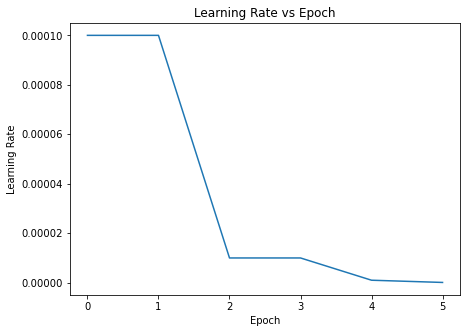

In [18]:
plot_learning_rate(history_dict)

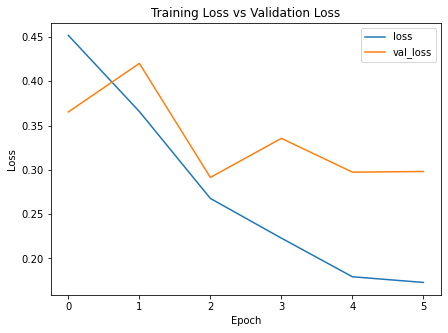

In [19]:
plot_metric(history_dict, 'loss')

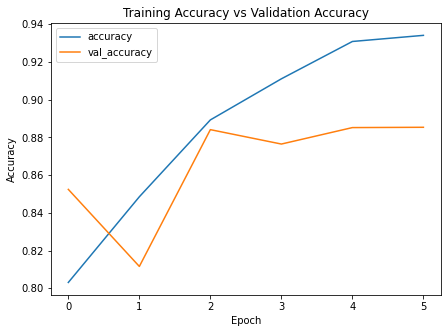

In [20]:
plot_metric(history_dict, 'accuracy')

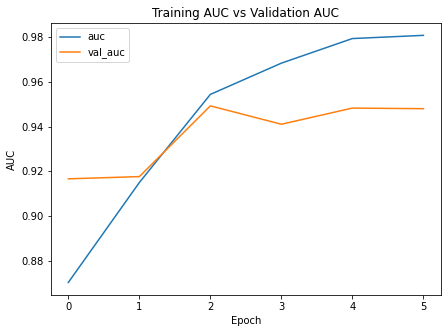

In [21]:
plot_metric(history_dict, 'auc')

---

## Calculate Performance on Test Set

In [22]:
test_metrics = model.evaluate(test_ds, verbose=1)
test_metrics = map_to_metrics(model.metrics_names, test_metrics)

  1/258 [..............................] - ETA: 23s - loss: 0.1817 - accuracy: 0.9062 - auc: 0.9961

 12/258 [>.............................] - ETA: 1s - loss: 0.2647 - accuracy: 0.9036 - auc: 0.9557 

 23/258 [=>............................] - ETA: 1s - loss: 0.2877 - accuracy: 0.8872 - auc: 0.9498

 32/258 [==>...........................] - ETA: 1s - loss: 0.2989 - accuracy: 0.8867 - auc: 0.9461

 43/258 [====>.........................] - ETA: 1s - loss: 0.2929 - accuracy: 0.8895 - auc: 0.9483

 54/258 [=====>........................] - ETA: 1s - loss: 0.2874 - accuracy: 0.8872 - auc: 0.9508

 65/258 [======>.......................] - ETA: 0s - loss: 0.2887 - accuracy: 0.8870 - auc: 0.9493

 76/258 [=======>......................] - ETA: 0s - loss: 0.2915 - accuracy: 0.8853 - auc: 0.9477

 87/258 [=========>....................] - ETA: 0s - loss: 0.2883 - accuracy: 0.8876 - auc: 0.9488

 98/258 [==========>...................] - ETA: 0s - loss: 0.2905 - accuracy: 0.8874 - auc: 0.9483

109/258 [===========>..................] - ETA: 0s - loss: 0.2910 - accuracy: 0.8882 - auc: 0.9485

120/258 [============>.................] - ETA: 0s - loss: 0.2992 - accuracy: 0.8854 - auc: 0.9463

131/258 [==============>...............] - ETA: 0s - loss: 0.2941 - accuracy: 0.8869 - auc: 0.9479

142/258 [===============>..............] - ETA: 0s - loss: 0.2960 - accuracy: 0.8853 - auc: 0.9473

153/258 [================>.............] - ETA: 0s - loss: 0.2952 - accuracy: 0.8856 - auc: 0.9476

164/258 [==================>...........] - ETA: 0s - loss: 0.2996 - accuracy: 0.8832 - auc: 0.9463

175/258 [===================>..........] - ETA: 0s - loss: 0.2971 - accuracy: 0.8852 - auc: 0.9470

186/258 [====================>.........] - ETA: 0s - loss: 0.2989 - accuracy: 0.8839 - auc: 0.9466

197/258 [=====================>........] - ETA: 0s - loss: 0.2995 - accuracy: 0.8837 - auc: 0.9467

208/258 [=======================>......] - ETA: 0s - loss: 0.3059 - accuracy: 0.8819 - auc: 0.9446

219/258 [========================>.....] - ETA: 0s - loss: 0.3041 - accuracy: 0.8820 - auc: 0.9452

230/258 [=========================>....] - ETA: 0s - loss: 0.3034 - accuracy: 0.8817 - auc: 0.9454

241/258 [===========================>..] - ETA: 0s - loss: 0.3055 - accuracy: 0.8814 - auc: 0.9448

252/258 [============================>.] - ETA: 0s - loss: 0.3043 - accuracy: 0.8818 - auc: 0.9450

258/258 [==============================] - ETA: 0s - loss: 0.3057 - accuracy: 0.8812 - auc: 0.9446

258/258 [==============================] - 1s 5ms/step - loss: 0.3057 - accuracy: 0.8812 - auc: 0.9446


In [23]:
# Save test metrics
json.dump(test_metrics, open(f"{model_output_dir}/{MODEL_NAME}/test_metrics.json", 'w'))

---